# Extract cancer variant reads for alignment visualization

## In this notebook, we use a single RNA-seq fastq file from a melanoma cancer cell line from the the CCLE project. Learn more about the project here:
- sequencing data (ENA): https://www.ebi.ac.uk/ena/browser/view/PRJNA523380
- paper: https://www.nature.com/articles/s41586-019-1186-3

### Requirements: kb, samtools, and bowtie2

In [1]:
try:
    import varseek as vk
except ImportError:
    print("varseek not found, installing...")
    !pip install -U -q varseek
try:
    import RLSRP_2025
except ImportError:
    print("RLSRP_2025 not found, installing...")
    !pip install -q git+https://github.com/pachterlab/RLSRP_2025.git

In [2]:
import anndata
import os
import subprocess
from datetime import datetime
import numpy as np
import pandas as pd
import re
import gget
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import pyfastx
import glob
import requests
from collections import Counter
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
from tqdm import tqdm
# pd.set_option('display.max_columns', None)
import varseek as vk

RLSRP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRP_2025
threads = "8"

### File path definitions and imports

ENST00000390312:c.218G>A       1848.0
ENST00000336023:c.614A>G       1493.0
ENST00000579721:c.870G>C       1464.0
ENST00000496168:c.382G>A       1382.0
ENST00000579721:c.41C>T        1346.0

In [3]:
experiment_alias = "E_GEUV_1_NA20502_3_M_120202_4"
fastq_file_base = "ERR188380"

notebook_out_dir = os.path.join(RLSRP_2025_dir, "data", "geuvadis_data_base", experiment_alias, "vk_count_out_w37_k41")
figures_out_dir = os.path.join(RLSRP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias)
aligned_reads_parent_dir = os.path.join(notebook_out_dir, "pseudoaligned_reads_to_vcrs_reference")
bowtie_read_alignments = os.path.join(notebook_out_dir, "bowtie_read_alignments_modified_bam")
detailed_txt_out = os.path.join(notebook_out_dir, "detailed_out_modified_bam.txt")
overall_txt_out = os.path.join(notebook_out_dir, "overall_out_modified_bam.txt")

# fp df
fp_df_path = os.path.join(RLSRP_2025_dir, "data", "geuvadis_analysis_supplement", experiment_alias, "fp_df.parquet")
number_of_variants = None  # sorted by counts descending; None for all
hgvs_df_path = os.path.join(RLSRP_2025_dir, "data", "reference", "geuvadis", "variants_transcriptome.parquet")

# vk ref out directory and files - downloaded if not already present
vk_ref_out_dir = os.path.join(RLSRP_2025_dir, "data", "vk_ref_out_geuvadis", "w37_k41")
vcrs_index = os.path.join(vk_ref_out_dir, "vcrs_index.idx")
vcrs_t2g = os.path.join(vk_ref_out_dir, "vcrs_t2g_filtered.txt")
vcrs_fasta = os.path.join(vk_ref_out_dir, "vcrs_filtered.fa")

# fastq directories - fastqs_dir downloaded if not already present, and fastqs_processed_dir created with fastp if not already present
fastqs_dir = os.path.join(RLSRP_2025_dir, "data", "geuvadis_data_base", experiment_alias)
fastq_files = [os.path.join(fastqs_dir, f"{fastq_file_base}_1.fastq.gz"), os.path.join(fastqs_dir, f"{fastq_file_base}_2.fastq.gz")]
fastq_file = os.path.join(fastqs_dir, "fastqs_combined", "fastqs_combined.fastq.gz")  # os.path.join(fastqs_dir, "ERR204838_1.fastq.gz")
technology = "bulk"

# reference genome directory
reference_genome_dir = os.path.join(RLSRP_2025_dir, "data", "reference", "ensembl_grch37_release113")
reference_genome_fasta = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.dna.primary_assembly.fa")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf
reference_genome_gtf = os.path.join(reference_genome_dir, "Homo_sapiens.GRCh37.87.gtf")  # if reference_genome_index/reference_genome_t2g do not exist, then I need to supply the reference genome fasta and gtf

# for bowtie2 - also uses reference_genome_fasta above (I could use cdna instead of genome too if desired)
bowtie_reference_dir = os.path.join(reference_genome_dir, "bowtie_index_genome")
bowtie_reference_prefix = os.path.join(bowtie_reference_dir, "index")

# more settings for vk count if needed
reference_out_dir = os.path.join(RLSRP_2025_dir, "data", "reference")
reference_genome_index = os.path.join(reference_out_dir, "ensembl_grch37_release113", "index.idx")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
reference_genome_t2g = os.path.join(reference_out_dir, "ensembl_grch37_release113", "t2g.txt")  # can either already exist or will be created; only used if qc_against_gene_matrix=True
geuvadis_reference_files_dir = os.path.join(reference_out_dir, "geuvadis")
seq_id_column = "transcript_ID"
var_column = "variant_cdna"
gene_id_column = "gene_name"
variants_usecols = [seq_id_column, var_column, gene_id_column]

# general
w = "37"  # used during creation of the index, so cannot be altered
k = "41"  # used during creation of the index, so cannot be altered
strand = "unstranded"
parity = "single"
mm = True
union = True
quality_control_fastqs = True
qc_against_gene_matrix = False
mistake_ratio = 0.5
use_combined = True
modify_bam = True  # convert 256 flag to 0
min_counts = 2

# software
bustools = "/home/jmrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools"
bowtie2 = "bowtie2"
bowtie2_build = "bowtie2-build"
samtools = "samtools"
email = os.environ.get("EMAIL")

### Make bowtie2 index files

In [4]:
if not os.path.exists(bowtie_reference_dir) or len(os.listdir(bowtie_reference_dir)) == 0:
    os.makedirs(bowtie_reference_dir, exist_ok=True)
    !{bowtie2_build} --threads {threads} {reference_genome_fasta} {bowtie_reference_prefix}

### Load in FP df

In [5]:
fp_df = pd.read_parquet(fp_df_path)
if "variant_count" in fp_df.columns and "vcrs_count" not in fp_df.columns:
    fp_df = fp_df.rename(columns={"variant_count": "vcrs_count"})
fp_df = fp_df.sort_values("vcrs_count", ascending=False)
if number_of_variants is not None:
    fp_df = fp_df.head(number_of_variants)

# fp_df = fp_df.set_index('variant_header')
fps = set(fp_df['variant_header'].tolist())
print(fps)
fp_df.head()

{'ENST00000344063:c.819A>C', 'ENST00000348462:c.406C>T', 'ENST00000338110:c.1510C>T', 'ENST00000264258:c.905C>T', 'ENST00000338110:c.1336A>G', 'ENST00000322203:c.354G>T', 'ENST00000310931:c.3444C>T', 'ENST00000223641:c.201C>T', 'ENST00000222247:c.318G>A', 'ENST00000261366:c.1863C>T', 'ENST00000599678:c.780G>A', 'ENST00000331825:c.255C>T', 'ENST00000374550:c.412A>G', 'ENST00000170564:c.1066C>T', 'ENST00000390321:c.143C>T', 'ENST00000196551:c.348C>A', 'ENST00000315579:c.1456T>C', 'ENST00000262746:c.524A>G', 'ENST00000418115:c.934T>C', 'ENST00000260379:c.299G>C', 'ENST00000394665:c.293G>A', 'ENST00000353801:c.1055C>G', 'ENST00000325823:c.246C>A', 'ENST00000269122:c.5220T>G', 'ENST00000407280:c.327G>C', 'ENST00000304921:c.599C>T', 'ENST00000392132:c.2306T>C', 'ENST00000370007:c.1765C>T', 'ENST00000300026:c.847C>T', 'ENST00000262746:c.564G>A', 'ENST00000327892:c.972C>T', 'ENST00000329276:c.595C>T', 'ENST00000338110:c.1114C>T', 'ENST00000317799:c.475G>T', 'ENST00000331789:c.1209G>C', 'ENST00

,vcrs_count,variant_header_cds,variant_header,transcript_ID,gene,gene_count,genotype
index,,,,,,,
128120,4943.0,ENST00000603423.1:c.87G>A,ENST00000603423:c.137G>A,ENST00000603423,None,NaN,0.0
58563,568.0,ENST00000579721.1:c.112C>T,ENST00000579721:c.112C>T,ENST00000579721,None,NaN,0.0
174896,313.0,ENST00000390299.2:c.177G>A,ENST00000390299:c.228G>A,ENST00000390299,ENSG00000211653,33972.0,0.0
142189,50.0,ENST00000268720.5:c.1809G>A,ENST00000268720:c.1939G>A,ENST00000268720,ENSG00000178773,621.0,0.0
136646,30.0,ENST00000325823.7:c.159C>A,ENST00000325823:c.246C>A,ENST00000325823,ENSG00000179889,2714.0,0.0


### Make pyfastx index files

In [6]:
if use_combined:
    if not os.path.isfile(fastq_file):
        import gzip
        os.makedirs(os.path.dirname(fastq_file), exist_ok=True)
        def process_and_write(input_path, output_file, file_tag):
            with gzip.open(input_path, "rt") as f_in:
                for i, line in enumerate(f_in):
                    if i % 4 == 0 and line.startswith('@'):
                        line = f"@{file_tag}{line[1:]}"  # replace @ with @fileX
                    output_file.write(line)

        with gzip.open(fastq_file, "wt") as f_out:
            process_and_write(fastq_files[0], f_out, "file1")
            process_and_write(fastq_files[1], f_out, "file2")
else:
    fastq_file = fastq_files[0]

In [7]:
fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)

### Perform variant screening with varseek count

In [8]:
kb_count_out_dir = os.path.join(notebook_out_dir, "kb_count_out_vcrs")
adata_path = os.path.join(kb_count_out_dir, "counts_unfiltered", "adata.h5ad")

if not os.path.exists(adata_path):
    vk_count_output_dict = vk.count(
        fastqs=fastq_file,
        index=vcrs_index,
        t2g=vcrs_t2g,
        technology=technology,
        out=notebook_out_dir,
        k=k,
        strand=strand,
        parity=parity,
        threads=threads,
        mm=mm,
        union=union,
        disable_fastqpp=False,
        quality_control_fastqs=True, cut_front=True, cut_tail=True,
        qc_against_gene_matrix=qc_against_gene_matrix, reference_genome_index=reference_genome_index, reference_genome_t2g=reference_genome_t2g, mistake_ratio=mistake_ratio,
        variants = os.path.join(geuvadis_reference_files_dir, "variants_transcriptome.parquet"),
        seq_id_column=seq_id_column,
        var_column=var_column,
        gene_id_column=gene_id_column,
        variants_usecols=variants_usecols,
    )

In [9]:
# url = "https://grch37.rest.ensembl.org/vep/human/id"
# headers = {"Content-Type": "application/json"}

hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df = hgvs_df.merge(fp_df, how="left", left_on="header_cdna", right_on="variant_header", suffixes=("", "_fp"))
hgvs_df = hgvs_df.loc[~hgvs_df['vcrs_count'].isna()].sort_values('vcrs_count', ascending=False)  # .sort_values('vcrs_id', ascending=True)
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [10]:
fp_df.head()

,vcrs_count,variant_header_cds,variant_header,transcript_ID,gene,gene_count,genotype
index,,,,,,,
128120,4943.0,ENST00000603423.1:c.87G>A,ENST00000603423:c.137G>A,ENST00000603423,None,NaN,0.0
58563,568.0,ENST00000579721.1:c.112C>T,ENST00000579721:c.112C>T,ENST00000579721,None,NaN,0.0
174896,313.0,ENST00000390299.2:c.177G>A,ENST00000390299:c.228G>A,ENST00000390299,ENSG00000211653,33972.0,0.0
142189,50.0,ENST00000268720.5:c.1809G>A,ENST00000268720:c.1939G>A,ENST00000268720,ENSG00000178773,621.0,0.0
136646,30.0,ENST00000325823.7:c.159C>A,ENST00000325823:c.246C>A,ENST00000325823,ENSG00000179889,2714.0,0.0


From dbSNP (roughly):
ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.23101523G>A chrom22
ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
ENST00000579721:c.41C>T: rs115527405
ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6

### Align (1) pulled out reads and (2) the VCRSs to the human genome to generate bam files:

In [11]:
import pysam

def make_all_alignments_primary(infile_path, outfile_path):
    infile = pysam.AlignmentFile(infile_path, "rb")
    outfile = pysam.AlignmentFile(outfile_path, "wb", template=infile)

    for read in infile:
        read.flag = read.flag & ~256  # remove secondary flag
        outfile.write(read)

    infile.close()
    outfile.close()

In [12]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FP where varseek was correct
false_variants = []  # varseek FP where varseek was incorrect
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        hgvs_df_row = hgvs_df.loc[hgvs_df['vcrs_id'] == variant]
        dbsnp_id = hgvs_df_row['dbsnp_id'].values[0]
        hgvsc = hgvs_df_row['header_cdna'].values[0]
        strand = hgvs_df_row['strand'].values[0]
        variant_counts = hgvs_df_row['vcrs_count'].values[0]
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = hgvs_df_row['transcript_ID'].values[0]
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out) else "w"
        with open(detailed_txt_out, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} | {variant_counts} reported counts\n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

12:43:57: Entering the loop


  0%|                                                                                                                             | 0/483 [00:00<?, ?it/s]

  0%|▏                                                                                                                    | 1/483 [00:02<18:07,  2.26s/it]

  0%|▍                                                                                                                    | 2/483 [00:04<17:15,  2.15s/it]

  1%|▋                                                                                                                    | 3/483 [00:05<12:07,  1.51s/it]

  1%|▉                                                                                                                    | 4/483 [00:05<09:46,  1.22s/it]

  1%|█▏                                                                                                                   | 5/483 [00:06<08:59,  1.13s/it]

  1%|█▍                                                                                                                   | 6/483 [00:07<08:06,  1.02s/it]

  1%|█▋                                                                                                                   | 7/483 [00:08<07:19,  1.08it/s]

  2%|█▉                                                                                                                   | 8/483 [00:09<06:51,  1.15it/s]

  2%|██▏                                                                                                                  | 9/483 [00:10<06:59,  1.13it/s]

  2%|██▍                                                                                                                 | 10/483 [00:10<06:32,  1.20it/s]

  2%|██▋                                                                                                                 | 11/483 [00:11<06:15,  1.26it/s]

  2%|██▉                                                                                                                 | 12/483 [00:12<06:00,  1.31it/s]

  3%|███                                                                                                                 | 13/483 [00:13<07:40,  1.02it/s]

  3%|███▎                                                                                                                | 14/483 [00:14<06:57,  1.12it/s]

  3%|███▌                                                                                                                | 15/483 [00:15<07:08,  1.09it/s]

  3%|███▊                                                                                                                | 16/483 [00:16<06:41,  1.16it/s]

  4%|████                                                                                                                | 17/483 [00:17<07:03,  1.10it/s]

  4%|████▎                                                                                                               | 18/483 [00:17<06:33,  1.18it/s]

  4%|████▌                                                                                                               | 19/483 [00:18<06:08,  1.26it/s]

  4%|████▊                                                                                                               | 20/483 [00:19<06:03,  1.27it/s]

  4%|█████                                                                                                               | 21/483 [00:19<06:00,  1.28it/s]

  5%|█████▎                                                                                                              | 22/483 [00:20<06:00,  1.28it/s]

  5%|█████▌                                                                                                              | 23/483 [00:21<06:06,  1.25it/s]

  5%|█████▊                                                                                                              | 24/483 [00:22<05:48,  1.32it/s]

  5%|██████                                                                                                              | 25/483 [00:22<05:29,  1.39it/s]

  5%|██████▏                                                                                                             | 26/483 [00:23<05:23,  1.41it/s]

  6%|██████▍                                                                                                             | 27/483 [00:24<05:28,  1.39it/s]

  6%|██████▋                                                                                                             | 28/483 [00:25<05:45,  1.32it/s]

  6%|██████▉                                                                                                             | 29/483 [00:25<05:28,  1.38it/s]

  6%|███████▏                                                                                                            | 30/483 [00:27<06:57,  1.09it/s]

  6%|███████▍                                                                                                            | 31/483 [00:27<06:24,  1.18it/s]

  7%|███████▋                                                                                                            | 32/483 [00:28<05:59,  1.25it/s]

  7%|███████▉                                                                                                            | 33/483 [00:29<06:15,  1.20it/s]

  7%|████████▏                                                                                                           | 34/483 [00:30<05:59,  1.25it/s]

  7%|████████▍                                                                                                           | 35/483 [00:30<05:41,  1.31it/s]

  8%|████████▉                                                                                                           | 37/483 [00:31<04:09,  1.79it/s]

  8%|█████████▏                                                                                                          | 38/483 [00:32<04:47,  1.55it/s]

  8%|█████████▎                                                                                                          | 39/483 [00:33<04:51,  1.52it/s]

  8%|█████████▌                                                                                                          | 40/483 [00:33<04:56,  1.50it/s]

  8%|█████████▊                                                                                                          | 41/483 [00:34<05:05,  1.45it/s]

  9%|██████████                                                                                                          | 42/483 [00:35<04:52,  1.51it/s]

  9%|██████████▎                                                                                                         | 43/483 [00:36<06:35,  1.11it/s]

  9%|██████████▌                                                                                                         | 44/483 [00:37<06:08,  1.19it/s]

  9%|██████████▊                                                                                                         | 45/483 [00:37<05:37,  1.30it/s]

 10%|███████████                                                                                                         | 46/483 [00:38<05:23,  1.35it/s]

 10%|███████████▌                                                                                                        | 48/483 [00:39<04:08,  1.75it/s]

 10%|███████████▊                                                                                                        | 49/483 [00:40<04:42,  1.54it/s]

 10%|████████████                                                                                                        | 50/483 [00:40<04:35,  1.57it/s]

 11%|████████████▏                                                                                                       | 51/483 [00:41<05:10,  1.39it/s]

 11%|████████████▍                                                                                                       | 52/483 [00:42<04:56,  1.45it/s]

 11%|████████████▋                                                                                                       | 53/483 [00:43<05:07,  1.40it/s]

 11%|████████████▉                                                                                                       | 54/483 [00:43<05:05,  1.40it/s]

 11%|█████████████▏                                                                                                      | 55/483 [00:45<06:28,  1.10it/s]

 12%|█████████████▍                                                                                                      | 56/483 [00:46<07:28,  1.05s/it]

 12%|█████████████▋                                                                                                      | 57/483 [00:47<06:43,  1.05it/s]

 12%|█████████████▉                                                                                                      | 58/483 [00:48<06:34,  1.08it/s]

 12%|██████████████▏                                                                                                     | 59/483 [00:48<05:58,  1.18it/s]

 12%|██████████████▍                                                                                                     | 60/483 [00:49<05:38,  1.25it/s]

 13%|██████████████▋                                                                                                     | 61/483 [00:50<05:27,  1.29it/s]

 13%|██████████████▉                                                                                                     | 62/483 [00:50<05:15,  1.34it/s]

 13%|███████████████▏                                                                                                    | 63/483 [00:51<05:09,  1.36it/s]

 13%|███████████████▎                                                                                                    | 64/483 [00:52<05:12,  1.34it/s]

 13%|███████████████▌                                                                                                    | 65/483 [00:53<06:50,  1.02it/s]

 14%|███████████████▊                                                                                                    | 66/483 [00:54<06:12,  1.12it/s]

 14%|████████████████                                                                                                    | 67/483 [00:55<06:02,  1.15it/s]

 14%|████████████████▎                                                                                                   | 68/483 [00:56<05:34,  1.24it/s]

 14%|████████████████▌                                                                                                   | 69/483 [00:56<05:25,  1.27it/s]

 14%|████████████████▊                                                                                                   | 70/483 [00:58<07:02,  1.02s/it]

 15%|█████████████████                                                                                                   | 71/483 [00:59<06:24,  1.07it/s]

 15%|█████████████████▎                                                                                                  | 72/483 [00:59<05:43,  1.20it/s]

 15%|█████████████████▌                                                                                                  | 73/483 [01:00<05:22,  1.27it/s]

 15%|█████████████████▊                                                                                                  | 74/483 [01:01<06:53,  1.01s/it]

 16%|██████████████████                                                                                                  | 75/483 [01:02<06:06,  1.11it/s]

 16%|██████████████████▎                                                                                                 | 76/483 [01:03<06:52,  1.01s/it]

 16%|██████████████████▍                                                                                                 | 77/483 [01:05<08:21,  1.24s/it]

 16%|██████████████████▋                                                                                                 | 78/483 [01:06<07:18,  1.08s/it]

 16%|██████████████████▉                                                                                                 | 79/483 [01:06<06:21,  1.06it/s]

 17%|███████████████████▏                                                                                                | 80/483 [01:07<05:48,  1.16it/s]

 17%|███████████████████▍                                                                                                | 81/483 [01:09<06:58,  1.04s/it]

 17%|███████████████████▋                                                                                                | 82/483 [01:10<07:06,  1.06s/it]

 17%|███████████████████▉                                                                                                | 83/483 [01:10<06:13,  1.07it/s]

 17%|████████████████████▏                                                                                               | 84/483 [01:11<05:37,  1.18it/s]

 18%|████████████████████▍                                                                                               | 85/483 [01:12<05:23,  1.23it/s]

 18%|████████████████████▋                                                                                               | 86/483 [01:12<05:10,  1.28it/s]

 18%|████████████████████▉                                                                                               | 87/483 [01:13<04:58,  1.33it/s]

 18%|█████████████████████▏                                                                                              | 88/483 [01:14<04:54,  1.34it/s]

 18%|█████████████████████▎                                                                                              | 89/483 [01:15<05:15,  1.25it/s]

 19%|█████████████████████▌                                                                                              | 90/483 [01:16<05:07,  1.28it/s]

 19%|█████████████████████▊                                                                                              | 91/483 [01:16<04:43,  1.38it/s]

 19%|██████████████████████                                                                                              | 92/483 [01:17<04:40,  1.39it/s]

 19%|██████████████████████▎                                                                                             | 93/483 [01:17<04:29,  1.45it/s]

 19%|██████████████████████▌                                                                                             | 94/483 [01:18<04:28,  1.45it/s]

 20%|██████████████████████▊                                                                                             | 95/483 [01:19<04:25,  1.46it/s]

 20%|███████████████████████                                                                                             | 96/483 [01:20<04:33,  1.42it/s]

 20%|███████████████████████▎                                                                                            | 97/483 [01:20<04:26,  1.45it/s]

 20%|███████████████████████▌                                                                                            | 98/483 [01:21<04:19,  1.48it/s]

 20%|███████████████████████▊                                                                                            | 99/483 [01:21<04:12,  1.52it/s]

 21%|███████████████████████▊                                                                                           | 100/483 [01:22<04:15,  1.50it/s]

 21%|████████████████████████                                                                                           | 101/483 [01:23<04:14,  1.50it/s]

 21%|████████████████████████▎                                                                                          | 102/483 [01:24<04:16,  1.48it/s]

 21%|████████████████████████▌                                                                                          | 103/483 [01:24<04:31,  1.40it/s]

 22%|████████████████████████▊                                                                                          | 104/483 [01:25<04:25,  1.43it/s]

 22%|█████████████████████████                                                                                          | 105/483 [01:26<04:19,  1.46it/s]

 22%|█████████████████████████▏                                                                                         | 106/483 [01:26<04:17,  1.47it/s]

 22%|█████████████████████████▍                                                                                         | 107/483 [01:27<04:29,  1.40it/s]

 22%|█████████████████████████▋                                                                                         | 108/483 [01:28<04:15,  1.47it/s]

 23%|█████████████████████████▉                                                                                         | 109/483 [01:28<04:06,  1.52it/s]

 23%|██████████████████████████▏                                                                                        | 110/483 [01:29<04:05,  1.52it/s]

 23%|██████████████████████████▍                                                                                        | 111/483 [01:30<04:04,  1.52it/s]

 23%|██████████████████████████▋                                                                                        | 112/483 [01:30<04:03,  1.52it/s]

 23%|██████████████████████████▉                                                                                        | 113/483 [01:31<04:04,  1.51it/s]

 24%|███████████████████████████▏                                                                                       | 114/483 [01:32<04:01,  1.53it/s]

 24%|███████████████████████████▍                                                                                       | 115/483 [01:33<04:36,  1.33it/s]

 24%|███████████████████████████▌                                                                                       | 116/483 [01:33<04:31,  1.35it/s]

 24%|███████████████████████████▊                                                                                       | 117/483 [01:34<04:14,  1.44it/s]

 24%|████████████████████████████                                                                                       | 118/483 [01:35<04:08,  1.47it/s]

 25%|████████████████████████████▎                                                                                      | 119/483 [01:35<04:01,  1.51it/s]

 25%|████████████████████████████▌                                                                                      | 120/483 [01:36<03:53,  1.55it/s]

 25%|████████████████████████████▊                                                                                      | 121/483 [01:37<05:06,  1.18it/s]

 25%|█████████████████████████████                                                                                      | 122/483 [01:38<04:46,  1.26it/s]

 25%|█████████████████████████████▎                                                                                     | 123/483 [01:38<04:26,  1.35it/s]

 26%|█████████████████████████████▌                                                                                     | 124/483 [01:39<04:27,  1.34it/s]

 26%|█████████████████████████████▊                                                                                     | 125/483 [01:40<04:41,  1.27it/s]

 26%|██████████████████████████████                                                                                     | 126/483 [01:41<04:18,  1.38it/s]

 26%|██████████████████████████████▏                                                                                    | 127/483 [01:41<04:08,  1.43it/s]

 27%|██████████████████████████████▍                                                                                    | 128/483 [01:42<04:24,  1.34it/s]

 27%|██████████████████████████████▋                                                                                    | 129/483 [01:43<04:20,  1.36it/s]

 27%|██████████████████████████████▉                                                                                    | 130/483 [01:43<04:07,  1.43it/s]

 27%|███████████████████████████████▏                                                                                   | 131/483 [01:44<03:59,  1.47it/s]

 27%|███████████████████████████████▍                                                                                   | 132/483 [01:45<03:55,  1.49it/s]

 28%|███████████████████████████████▋                                                                                   | 133/483 [01:45<03:56,  1.48it/s]

 28%|███████████████████████████████▉                                                                                   | 134/483 [01:46<03:59,  1.46it/s]

 28%|████████████████████████████████▏                                                                                  | 135/483 [01:47<04:01,  1.44it/s]

 28%|████████████████████████████████▍                                                                                  | 136/483 [01:47<03:57,  1.46it/s]

 28%|████████████████████████████████▌                                                                                  | 137/483 [01:48<03:52,  1.49it/s]

 29%|████████████████████████████████▊                                                                                  | 138/483 [01:49<03:46,  1.53it/s]

 29%|█████████████████████████████████                                                                                  | 139/483 [01:49<03:48,  1.50it/s]

 29%|█████████████████████████████████▎                                                                                 | 140/483 [01:50<03:49,  1.49it/s]

 29%|█████████████████████████████████▌                                                                                 | 141/483 [01:51<03:53,  1.46it/s]

 29%|█████████████████████████████████▊                                                                                 | 142/483 [01:52<05:14,  1.08it/s]

 30%|██████████████████████████████████                                                                                 | 143/483 [01:53<04:46,  1.19it/s]

 30%|██████████████████████████████████▎                                                                                | 144/483 [01:54<04:41,  1.21it/s]

 30%|██████████████████████████████████▌                                                                                | 145/483 [01:54<04:22,  1.29it/s]

 30%|██████████████████████████████████▊                                                                                | 146/483 [01:55<04:06,  1.37it/s]

 30%|███████████████████████████████████                                                                                | 147/483 [01:56<03:59,  1.40it/s]

 31%|███████████████████████████████████▏                                                                               | 148/483 [01:56<03:53,  1.43it/s]

 31%|███████████████████████████████████▍                                                                               | 149/483 [01:57<03:47,  1.47it/s]

 31%|███████████████████████████████████▋                                                                               | 150/483 [01:58<03:39,  1.52it/s]

 31%|███████████████████████████████████▉                                                                               | 151/483 [01:58<03:39,  1.51it/s]

 31%|████████████████████████████████████▏                                                                              | 152/483 [01:59<03:35,  1.53it/s]

 32%|████████████████████████████████████▍                                                                              | 153/483 [02:00<03:34,  1.54it/s]

 32%|████████████████████████████████████▋                                                                              | 154/483 [02:00<03:28,  1.58it/s]

 32%|████████████████████████████████████▉                                                                              | 155/483 [02:01<03:25,  1.60it/s]

 32%|█████████████████████████████████████▏                                                                             | 156/483 [02:01<03:22,  1.62it/s]

 33%|█████████████████████████████████████▍                                                                             | 157/483 [02:03<04:33,  1.19it/s]

 33%|█████████████████████████████████████▌                                                                             | 158/483 [02:04<04:43,  1.14it/s]

 33%|█████████████████████████████████████▊                                                                             | 159/483 [02:04<04:27,  1.21it/s]

 33%|██████████████████████████████████████                                                                             | 160/483 [02:05<04:08,  1.30it/s]

 33%|██████████████████████████████████████▎                                                                            | 161/483 [02:06<04:00,  1.34it/s]

 34%|██████████████████████████████████████▌                                                                            | 162/483 [02:06<03:51,  1.39it/s]

 34%|██████████████████████████████████████▊                                                                            | 163/483 [02:07<03:44,  1.42it/s]

 34%|███████████████████████████████████████                                                                            | 164/483 [02:08<03:37,  1.47it/s]

 34%|███████████████████████████████████████▎                                                                           | 165/483 [02:08<03:34,  1.48it/s]

 34%|███████████████████████████████████████▌                                                                           | 166/483 [02:09<03:30,  1.50it/s]

 35%|███████████████████████████████████████▊                                                                           | 167/483 [02:10<03:23,  1.56it/s]

 35%|████████████████████████████████████████                                                                           | 168/483 [02:10<03:27,  1.52it/s]

 35%|████████████████████████████████████████▏                                                                          | 169/483 [02:11<03:35,  1.46it/s]

 35%|████████████████████████████████████████▍                                                                          | 170/483 [02:12<04:48,  1.09it/s]

 35%|████████████████████████████████████████▋                                                                          | 171/483 [02:13<04:18,  1.21it/s]

 36%|████████████████████████████████████████▉                                                                          | 172/483 [02:14<04:12,  1.23it/s]

 36%|█████████████████████████████████████████▏                                                                         | 173/483 [02:15<04:04,  1.27it/s]

 36%|█████████████████████████████████████████▍                                                                         | 174/483 [02:15<03:53,  1.32it/s]

 36%|█████████████████████████████████████████▋                                                                         | 175/483 [02:16<03:42,  1.38it/s]

 36%|█████████████████████████████████████████▉                                                                         | 176/483 [02:17<03:41,  1.38it/s]

 37%|██████████████████████████████████████████▏                                                                        | 177/483 [02:17<03:38,  1.40it/s]

 37%|██████████████████████████████████████████▍                                                                        | 178/483 [02:18<03:35,  1.42it/s]

 37%|██████████████████████████████████████████▌                                                                        | 179/483 [02:19<03:50,  1.32it/s]

 37%|██████████████████████████████████████████▊                                                                        | 180/483 [02:20<03:46,  1.34it/s]

 37%|███████████████████████████████████████████                                                                        | 181/483 [02:20<03:34,  1.41it/s]

 38%|███████████████████████████████████████████▎                                                                       | 182/483 [02:21<03:55,  1.28it/s]

 38%|███████████████████████████████████████████▌                                                                       | 183/483 [02:22<03:45,  1.33it/s]

 38%|███████████████████████████████████████████▊                                                                       | 184/483 [02:23<04:36,  1.08it/s]

 38%|████████████████████████████████████████████                                                                       | 185/483 [02:24<04:37,  1.07it/s]

 39%|████████████████████████████████████████████▎                                                                      | 186/483 [02:25<04:18,  1.15it/s]

 39%|████████████████████████████████████████████▌                                                                      | 187/483 [02:26<04:10,  1.18it/s]

 39%|████████████████████████████████████████████▊                                                                      | 188/483 [02:26<03:47,  1.30it/s]

 39%|█████████████████████████████████████████████                                                                      | 189/483 [02:28<04:32,  1.08it/s]

 39%|█████████████████████████████████████████████▏                                                                     | 190/483 [02:28<04:05,  1.19it/s]

 40%|█████████████████████████████████████████████▍                                                                     | 191/483 [02:29<03:58,  1.22it/s]

 40%|█████████████████████████████████████████████▋                                                                     | 192/483 [02:30<04:03,  1.20it/s]

 40%|█████████████████████████████████████████████▉                                                                     | 193/483 [02:31<04:05,  1.18it/s]

 40%|██████████████████████████████████████████████▏                                                                    | 194/483 [02:32<04:24,  1.09it/s]

 41%|██████████████████████████████████████████████▋                                                                    | 196/483 [02:32<03:05,  1.54it/s]

 41%|██████████████████████████████████████████████▉                                                                    | 197/483 [02:33<03:02,  1.56it/s]

 41%|███████████████████████████████████████████████▏                                                                   | 198/483 [02:34<03:09,  1.51it/s]

 41%|███████████████████████████████████████████████▍                                                                   | 199/483 [02:35<03:13,  1.47it/s]

 41%|███████████████████████████████████████████████▌                                                                   | 200/483 [02:35<03:12,  1.47it/s]

 42%|███████████████████████████████████████████████▊                                                                   | 201/483 [02:36<03:14,  1.45it/s]

 42%|████████████████████████████████████████████████                                                                   | 202/483 [02:37<03:16,  1.43it/s]

 42%|████████████████████████████████████████████████▎                                                                  | 203/483 [02:37<03:10,  1.47it/s]

 42%|████████████████████████████████████████████████▌                                                                  | 204/483 [02:38<03:02,  1.53it/s]

 42%|████████████████████████████████████████████████▊                                                                  | 205/483 [02:39<03:06,  1.49it/s]

 43%|█████████████████████████████████████████████████                                                                  | 206/483 [02:39<03:04,  1.50it/s]

 43%|█████████████████████████████████████████████████▎                                                                 | 207/483 [02:40<03:00,  1.53it/s]

 43%|█████████████████████████████████████████████████▌                                                                 | 208/483 [02:40<02:58,  1.54it/s]

 43%|█████████████████████████████████████████████████▊                                                                 | 209/483 [02:41<02:55,  1.56it/s]

 43%|██████████████████████████████████████████████████                                                                 | 210/483 [02:42<02:54,  1.57it/s]

 44%|██████████████████████████████████████████████████▏                                                                | 211/483 [02:42<02:54,  1.55it/s]

 44%|██████████████████████████████████████████████████▍                                                                | 212/483 [02:43<02:54,  1.55it/s]

 44%|██████████████████████████████████████████████████▋                                                                | 213/483 [02:44<02:53,  1.55it/s]

 44%|██████████████████████████████████████████████████▉                                                                | 214/483 [02:44<03:00,  1.49it/s]

 45%|███████████████████████████████████████████████████▏                                                               | 215/483 [02:45<02:57,  1.51it/s]

 45%|███████████████████████████████████████████████████▍                                                               | 216/483 [02:46<02:51,  1.55it/s]

 45%|███████████████████████████████████████████████████▋                                                               | 217/483 [02:46<02:50,  1.56it/s]

 45%|███████████████████████████████████████████████████▉                                                               | 218/483 [02:47<02:49,  1.56it/s]

 45%|████████████████████████████████████████████████████▏                                                              | 219/483 [02:48<02:57,  1.49it/s]

 46%|████████████████████████████████████████████████████▍                                                              | 220/483 [02:48<03:01,  1.45it/s]

 46%|████████████████████████████████████████████████████▌                                                              | 221/483 [02:49<02:57,  1.48it/s]

 46%|████████████████████████████████████████████████████▊                                                              | 222/483 [02:50<02:56,  1.48it/s]

 46%|█████████████████████████████████████████████████████                                                              | 223/483 [02:50<02:57,  1.47it/s]

 46%|█████████████████████████████████████████████████████▎                                                             | 224/483 [02:51<02:50,  1.52it/s]

 47%|█████████████████████████████████████████████████████▌                                                             | 225/483 [02:52<02:47,  1.54it/s]

 47%|█████████████████████████████████████████████████████▊                                                             | 226/483 [02:52<02:53,  1.48it/s]

 47%|██████████████████████████████████████████████████████                                                             | 227/483 [02:53<02:49,  1.51it/s]

 47%|██████████████████████████████████████████████████████▎                                                            | 228/483 [02:54<02:46,  1.53it/s]

 47%|██████████████████████████████████████████████████████▌                                                            | 229/483 [02:54<02:46,  1.53it/s]

 48%|██████████████████████████████████████████████████████▊                                                            | 230/483 [02:55<02:47,  1.51it/s]

 48%|███████████████████████████████████████████████████████                                                            | 231/483 [02:56<02:43,  1.55it/s]

 48%|███████████████████████████████████████████████████████▏                                                           | 232/483 [02:57<03:35,  1.16it/s]

 48%|███████████████████████████████████████████████████████▍                                                           | 233/483 [02:58<03:18,  1.26it/s]

 48%|███████████████████████████████████████████████████████▋                                                           | 234/483 [02:58<03:06,  1.34it/s]

 49%|███████████████████████████████████████████████████████▉                                                           | 235/483 [02:59<02:56,  1.40it/s]

 49%|████████████████████████████████████████████████████████▏                                                          | 236/483 [02:59<02:45,  1.50it/s]

 49%|████████████████████████████████████████████████████████▍                                                          | 237/483 [03:00<02:40,  1.53it/s]

 49%|████████████████████████████████████████████████████████▋                                                          | 238/483 [03:01<02:53,  1.41it/s]

 49%|████████████████████████████████████████████████████████▉                                                          | 239/483 [03:01<02:44,  1.48it/s]

 50%|█████████████████████████████████████████████████████████▏                                                         | 240/483 [03:02<02:39,  1.52it/s]

 50%|█████████████████████████████████████████████████████████▍                                                         | 241/483 [03:03<02:39,  1.52it/s]

 50%|█████████████████████████████████████████████████████████▌                                                         | 242/483 [03:03<02:34,  1.56it/s]

 50%|█████████████████████████████████████████████████████████▊                                                         | 243/483 [03:04<02:29,  1.60it/s]

 51%|██████████████████████████████████████████████████████████                                                         | 244/483 [03:05<02:27,  1.62it/s]

 51%|██████████████████████████████████████████████████████████▎                                                        | 245/483 [03:05<02:27,  1.62it/s]

 51%|██████████████████████████████████████████████████████████▌                                                        | 246/483 [03:06<02:24,  1.64it/s]

 51%|██████████████████████████████████████████████████████████▊                                                        | 247/483 [03:06<02:25,  1.62it/s]

 51%|███████████████████████████████████████████████████████████                                                        | 248/483 [03:07<02:28,  1.58it/s]

 52%|███████████████████████████████████████████████████████████▎                                                       | 249/483 [03:08<02:23,  1.63it/s]

 52%|███████████████████████████████████████████████████████████▌                                                       | 250/483 [03:08<02:20,  1.66it/s]

 52%|███████████████████████████████████████████████████████████▊                                                       | 251/483 [03:09<02:23,  1.62it/s]

 52%|████████████████████████████████████████████████████████████                                                       | 252/483 [03:10<02:25,  1.59it/s]

 52%|████████████████████████████████████████████████████████████▏                                                      | 253/483 [03:10<02:28,  1.55it/s]

 53%|████████████████████████████████████████████████████████████▍                                                      | 254/483 [03:11<03:10,  1.20it/s]

 53%|████████████████████████████████████████████████████████████▋                                                      | 255/483 [03:12<02:53,  1.32it/s]

 53%|████████████████████████████████████████████████████████████▉                                                      | 256/483 [03:13<02:44,  1.38it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                     | 257/483 [03:13<02:41,  1.40it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                     | 258/483 [03:14<02:32,  1.48it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                     | 259/483 [03:15<02:25,  1.54it/s]

 54%|█████████████████████████████████████████████████████████████▉                                                     | 260/483 [03:15<02:24,  1.54it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                    | 261/483 [03:16<02:22,  1.56it/s]

 54%|██████████████████████████████████████████████████████████████▍                                                    | 262/483 [03:16<02:19,  1.58it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                    | 263/483 [03:17<02:32,  1.44it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                    | 264/483 [03:18<02:24,  1.52it/s]

 55%|███████████████████████████████████████████████████████████████                                                    | 265/483 [03:18<02:19,  1.56it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                   | 266/483 [03:19<02:15,  1.60it/s]

 55%|███████████████████████████████████████████████████████████████▌                                                   | 267/483 [03:20<02:13,  1.62it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                   | 268/483 [03:20<02:10,  1.65it/s]

 56%|████████████████████████████████████████████████████████████████                                                   | 269/483 [03:21<02:13,  1.61it/s]

 56%|████████████████████████████████████████████████████████████████▎                                                  | 270/483 [03:22<02:56,  1.21it/s]

 56%|████████████████████████████████████████████████████████████████▌                                                  | 271/483 [03:23<02:41,  1.31it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                  | 272/483 [03:23<02:33,  1.38it/s]

 57%|█████████████████████████████████████████████████████████████████                                                  | 273/483 [03:24<02:26,  1.43it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                 | 274/483 [03:25<02:23,  1.46it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 275/483 [03:25<02:22,  1.46it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                 | 276/483 [03:26<02:19,  1.49it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                 | 277/483 [03:27<02:17,  1.50it/s]

 58%|██████████████████████████████████████████████████████████████████▏                                                | 278/483 [03:27<02:15,  1.51it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                                | 279/483 [03:28<02:13,  1.53it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                | 280/483 [03:29<02:10,  1.55it/s]

 58%|██████████████████████████████████████████████████████████████████▉                                                | 281/483 [03:29<02:08,  1.57it/s]

 58%|███████████████████████████████████████████████████████████████████▏                                               | 282/483 [03:30<02:06,  1.59it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                               | 283/483 [03:31<02:23,  1.40it/s]

 59%|███████████████████████████████████████████████████████████████████▌                                               | 284/483 [03:31<02:14,  1.48it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                               | 285/483 [03:33<02:49,  1.17it/s]

 59%|████████████████████████████████████████████████████████████████████                                               | 286/483 [03:33<02:34,  1.27it/s]

 59%|████████████████████████████████████████████████████████████████████▎                                              | 287/483 [03:34<02:22,  1.37it/s]

 60%|████████████████████████████████████████████████████████████████████▌                                              | 288/483 [03:35<02:17,  1.42it/s]

 60%|████████████████████████████████████████████████████████████████████▊                                              | 289/483 [03:35<02:12,  1.47it/s]

 60%|█████████████████████████████████████████████████████████████████████                                              | 290/483 [03:36<02:06,  1.53it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                             | 291/483 [03:36<02:03,  1.55it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                             | 292/483 [03:37<02:02,  1.56it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                             | 293/483 [03:38<02:11,  1.45it/s]

 61%|██████████████████████████████████████████████████████████████████████                                             | 294/483 [03:38<02:04,  1.52it/s]

 61%|██████████████████████████████████████████████████████████████████████▏                                            | 295/483 [03:39<02:01,  1.55it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                            | 296/483 [03:40<01:57,  1.59it/s]

 61%|██████████████████████████████████████████████████████████████████████▋                                            | 297/483 [03:41<02:36,  1.19it/s]

 62%|██████████████████████████████████████████████████████████████████████▉                                            | 298/483 [03:42<02:22,  1.30it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                           | 299/483 [03:42<02:14,  1.37it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                           | 300/483 [03:43<02:07,  1.44it/s]

 62%|███████████████████████████████████████████████████████████████████████▋                                           | 301/483 [03:43<02:04,  1.46it/s]

 63%|███████████████████████████████████████████████████████████████████████▉                                           | 302/483 [03:44<01:58,  1.53it/s]

 63%|████████████████████████████████████████████████████████████████████████▏                                          | 303/483 [03:45<01:58,  1.52it/s]

 63%|████████████████████████████████████████████████████████████████████████▍                                          | 304/483 [03:45<01:55,  1.55it/s]

 63%|████████████████████████████████████████████████████████████████████████▌                                          | 305/483 [03:46<01:52,  1.58it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                          | 306/483 [03:47<01:53,  1.56it/s]

 64%|█████████████████████████████████████████████████████████████████████████                                          | 307/483 [03:47<01:54,  1.54it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                         | 308/483 [03:49<02:29,  1.17it/s]

 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 309/483 [03:49<02:21,  1.23it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                         | 310/483 [03:50<02:09,  1.34it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                         | 311/483 [03:51<02:03,  1.39it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                        | 312/483 [03:51<01:58,  1.44it/s]

 65%|██████████████████████████████████████████████████████████████████████████▌                                        | 313/483 [03:52<01:55,  1.47it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                        | 314/483 [03:52<01:54,  1.48it/s]

 65%|███████████████████████████████████████████████████████████████████████████                                        | 315/483 [03:53<01:52,  1.49it/s]

 65%|███████████████████████████████████████████████████████████████████████████▏                                       | 316/483 [03:54<02:20,  1.19it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                       | 317/483 [03:55<02:08,  1.29it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                       | 318/483 [03:56<02:09,  1.28it/s]

 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 319/483 [03:56<01:59,  1.37it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                      | 320/483 [03:57<01:55,  1.41it/s]

 66%|████████████████████████████████████████████████████████████████████████████▍                                      | 321/483 [03:58<01:53,  1.43it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 322/483 [03:58<01:48,  1.49it/s]

 67%|████████████████████████████████████████████████████████████████████████████▉                                      | 323/483 [03:59<01:44,  1.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▏                                     | 324/483 [04:00<01:42,  1.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▍                                     | 325/483 [04:00<01:41,  1.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                     | 326/483 [04:01<01:41,  1.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                     | 327/483 [04:02<01:40,  1.55it/s]

 68%|██████████████████████████████████████████████████████████████████████████████                                     | 328/483 [04:02<01:48,  1.43it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                    | 329/483 [04:03<01:45,  1.47it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                    | 330/483 [04:04<01:42,  1.49it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                    | 331/483 [04:04<01:41,  1.49it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                    | 332/483 [04:06<02:13,  1.13it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▎                                   | 333/483 [04:07<02:46,  1.11s/it]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                   | 334/483 [04:09<03:01,  1.22s/it]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                   | 335/483 [04:10<02:42,  1.10s/it]

 70%|████████████████████████████████████████████████████████████████████████████████                                   | 336/483 [04:10<02:18,  1.06it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▏                                  | 337/483 [04:11<02:02,  1.19it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▍                                  | 338/483 [04:11<01:51,  1.30it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                  | 339/483 [04:12<01:50,  1.30it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                  | 340/483 [04:13<01:42,  1.40it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                 | 341/483 [04:14<01:45,  1.35it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                 | 342/483 [04:14<01:40,  1.41it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▋                                 | 343/483 [04:15<01:37,  1.43it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 344/483 [04:16<01:35,  1.45it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▏                                | 345/483 [04:16<01:31,  1.51it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▍                                | 346/483 [04:17<01:41,  1.35it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                                | 347/483 [04:18<01:37,  1.40it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▊                                | 348/483 [04:19<01:40,  1.35it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                | 349/483 [04:19<01:33,  1.43it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                               | 350/483 [04:20<01:29,  1.49it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                               | 351/483 [04:20<01:25,  1.54it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▊                               | 352/483 [04:21<01:22,  1.59it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████                               | 353/483 [04:22<01:28,  1.47it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                              | 354/483 [04:22<01:24,  1.52it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▌                              | 355/483 [04:23<01:24,  1.51it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▊                              | 356/483 [04:24<01:23,  1.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████                              | 357/483 [04:24<01:22,  1.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▏                             | 358/483 [04:25<01:20,  1.56it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                             | 359/483 [04:26<01:20,  1.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▋                             | 360/483 [04:26<01:21,  1.52it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                             | 361/483 [04:27<01:18,  1.56it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▏                            | 362/483 [04:27<01:17,  1.57it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                            | 363/483 [04:28<01:14,  1.61it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                            | 364/483 [04:29<01:13,  1.61it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▉                            | 365/483 [04:29<01:13,  1.61it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▏                           | 366/483 [04:30<01:16,  1.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▍                           | 367/483 [04:31<01:20,  1.43it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▌                           | 368/483 [04:31<01:19,  1.45it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▊                           | 369/483 [04:32<01:15,  1.51it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████                           | 370/483 [04:33<01:14,  1.52it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                          | 371/483 [04:33<01:16,  1.47it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▌                          | 372/483 [04:34<01:12,  1.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▊                          | 373/483 [04:35<01:09,  1.59it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                          | 374/483 [04:35<01:12,  1.51it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                         | 375/483 [04:36<01:08,  1.57it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▌                         | 376/483 [04:37<01:06,  1.60it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▊                         | 377/483 [04:37<01:06,  1.60it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████                         | 378/483 [04:38<01:06,  1.59it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                        | 379/483 [04:38<01:05,  1.59it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                        | 380/483 [04:39<01:05,  1.57it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▋                        | 381/483 [04:40<01:04,  1.58it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 382/483 [04:40<01:02,  1.60it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                       | 383/483 [04:41<01:02,  1.61it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                       | 384/483 [04:42<01:05,  1.52it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                       | 385/483 [04:42<01:02,  1.56it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▉                       | 386/483 [04:43<01:01,  1.57it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▏                      | 387/483 [04:43<01:00,  1.59it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                      | 388/483 [04:44<01:01,  1.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 389/483 [04:45<00:59,  1.57it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                      | 390/483 [04:45<00:58,  1.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████                      | 391/483 [04:46<00:57,  1.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▎                     | 392/483 [04:47<00:58,  1.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                     | 393/483 [04:47<00:56,  1.60it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                     | 394/483 [04:49<01:13,  1.22it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 395/483 [04:50<01:26,  1.01it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▎                    | 396/483 [04:51<01:16,  1.14it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                    | 397/483 [04:52<01:27,  1.02s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                    | 398/483 [04:53<01:30,  1.07s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                    | 399/483 [04:54<01:19,  1.06it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                   | 400/483 [04:54<01:11,  1.16it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▍                   | 401/483 [04:55<01:04,  1.28it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 402/483 [04:56<00:59,  1.36it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                   | 403/483 [04:56<00:56,  1.42it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 404/483 [04:57<00:53,  1.46it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 405/483 [04:58<00:51,  1.51it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 406/483 [04:58<00:50,  1.52it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 407/483 [04:59<00:49,  1.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 408/483 [05:00<00:52,  1.44it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 409/483 [05:00<00:50,  1.47it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 410/483 [05:01<00:49,  1.49it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 411/483 [05:02<00:47,  1.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                 | 412/483 [05:02<00:46,  1.52it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                | 413/483 [05:03<00:45,  1.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 414/483 [05:03<00:44,  1.56it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 415/483 [05:04<00:47,  1.42it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████                | 416/483 [05:05<00:46,  1.44it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎               | 417/483 [05:06<00:46,  1.43it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌               | 418/483 [05:06<00:43,  1.50it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 419/483 [05:07<00:42,  1.52it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████               | 420/483 [05:07<00:40,  1.57it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 421/483 [05:08<00:38,  1.61it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 422/483 [05:09<00:37,  1.64it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 423/483 [05:09<00:36,  1.65it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 424/483 [05:10<00:36,  1.62it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 425/483 [05:10<00:35,  1.64it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 426/483 [05:11<00:35,  1.62it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 427/483 [05:12<00:35,  1.60it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 428/483 [05:12<00:35,  1.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 429/483 [05:13<00:33,  1.60it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 430/483 [05:14<00:36,  1.47it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 431/483 [05:14<00:34,  1.51it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 432/483 [05:15<00:33,  1.52it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████            | 433/483 [05:16<00:32,  1.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 434/483 [05:16<00:31,  1.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 435/483 [05:18<00:40,  1.17it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 436/483 [05:19<00:45,  1.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████           | 437/483 [05:20<00:48,  1.05s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 438/483 [05:21<00:41,  1.07it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 439/483 [05:21<00:36,  1.20it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 440/483 [05:22<00:32,  1.32it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 441/483 [05:23<00:30,  1.40it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 442/483 [05:23<00:28,  1.46it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 443/483 [05:24<00:26,  1.51it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 444/483 [05:25<00:25,  1.51it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 445/483 [05:25<00:24,  1.56it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 446/483 [05:26<00:23,  1.57it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 447/483 [05:26<00:22,  1.59it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 448/483 [05:27<00:21,  1.59it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 449/483 [05:28<00:21,  1.61it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 450/483 [05:28<00:21,  1.52it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 451/483 [05:30<00:27,  1.18it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 452/483 [05:30<00:23,  1.29it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 453/483 [05:31<00:21,  1.37it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 454/483 [05:32<00:20,  1.41it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 455/483 [05:32<00:20,  1.39it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 456/483 [05:33<00:19,  1.39it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 457/483 [05:34<00:18,  1.39it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 458/483 [05:35<00:18,  1.34it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 459/483 [05:35<00:17,  1.36it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 460/483 [05:36<00:16,  1.43it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 461/483 [05:36<00:14,  1.49it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 462/483 [05:37<00:14,  1.48it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 463/483 [05:38<00:13,  1.49it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 464/483 [05:38<00:12,  1.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 465/483 [05:39<00:11,  1.59it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 466/483 [05:40<00:10,  1.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 467/483 [05:40<00:10,  1.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 468/483 [05:41<00:09,  1.59it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 469/483 [05:41<00:08,  1.61it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 470/483 [05:42<00:07,  1.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 471/483 [05:43<00:07,  1.63it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 472/483 [05:43<00:06,  1.63it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 473/483 [05:44<00:06,  1.63it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 474/483 [05:45<00:05,  1.63it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 475/483 [05:45<00:04,  1.65it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 476/483 [05:46<00:04,  1.64it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 477/483 [05:46<00:03,  1.54it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 478/483 [05:48<00:03,  1.29it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 479/483 [05:49<00:03,  1.11it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 480/483 [05:49<00:02,  1.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 481/483 [05:50<00:01,  1.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 482/483 [05:51<00:00,  1.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 483/483 [05:51<00:00,  1.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 483/483 [05:51<00:00,  1.37it/s]

In [13]:
!cat {overall_txt_out}

Number of true variants: 216
Number of false variants: 262
Number of undetermined variants: 2
True variants list: ['ENST00000603423:c.137G>A', 'ENST00000579721:c.112C>T', 'ENST00000390299:c.228G>A', 'ENST00000268720:c.1939G>A', 'ENST00000325823:c.246C>A', 'ENST00000390321:c.143C>T', 'ENST00000331789:c.1209G>C', 'ENST00000360830:c.196A>G', 'ENST00000374550:c.412A>G', 'ENST00000390299:c.334G>A', 'ENST00000563769:c.953G>A', 'ENST00000390321:c.62C>T', 'ENST00000368567:c.58T>C', 'ENST00000339647:c.2562C>T', 'ENST00000301821:c.880G>T', 'ENST00000339647:c.1158C>T', 'ENST00000272317:c.538A>C', 'ENST00000390299:c.88C>T', 'ENST00000338970:c.107C>T', 'ENST00000338110:c.1510C>T', 'ENST00000301072:c.488A>G', 'ENST00000330752:c.564T>G', 'ENST00000274065:c.104C>T', 'ENST00000412585:c.346G>T', 'ENST00000264258:c.649C>T', 'ENST00000374550:c.71A>G', 'ENST00000374550:c.336C>G', 'ENST00000202773:c.688T>A', 'ENST00000374550:c.384C>T', 'ENST00000339647:c.1329A>G', 'ENST00000321153:c.478C>G', 'ENST0000060404

In [14]:
# !cat {detailed_txt_out}

In [15]:
print("Overall file: ", overall_txt_out)
print("Detailed file: ", detailed_txt_out)

Overall file:  /home/jmrich/Desktop/RLSRP_2025/data/geuvadis_data_base/E_GEUV_1_NA20502_3_M_120202_4/vk_count_out_w37_k41/overall_out_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRP_2025/data/geuvadis_data_base/E_GEUV_1_NA20502_3_M_120202_4/vk_count_out_w37_k41/detailed_out_modified_bam.txt


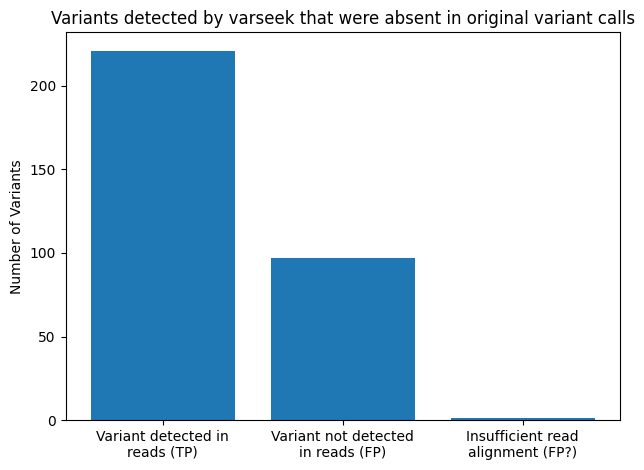

In [16]:
def plot_overall_bar_plot(overall_results, wrap_width = None, out_file=None, title = None):
    # Unpack keys and values
    labels = list(overall_results.keys())
    values = list(overall_results.values())

    if wrap_width:
        labels = ['\n'.join(textwrap.wrap(label, wrap_width)) for label in labels]

    # Create bar plot
    plt.bar(labels, values)
    plt.ylabel('Number of Variants')
    if title:
        plt.title(title)
    plt.tight_layout()
    if out_file:
        plt.savefig(out_file, dpi=300)
    plt.show()
    plt.close()

overall_results = {
    "Variant detected in reads (TP)": 221,
    "Variant not detected in reads (FP)": 97,
    "Insufficient read alignment (FP?)": 1,
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fp_bar_plot.pdf"), title = 'Variants detected by varseek that were absent in original variant calls')

In [17]:
hgvs_df['true_variant'] = hgvs_df['header_cdna'].isin(set(true_variants))
hgvs_df.loc[hgvs_df['vcrs_id'].isna(), 'true_variant'] = pd.NA  # set the rows I didn't evaluate to NA

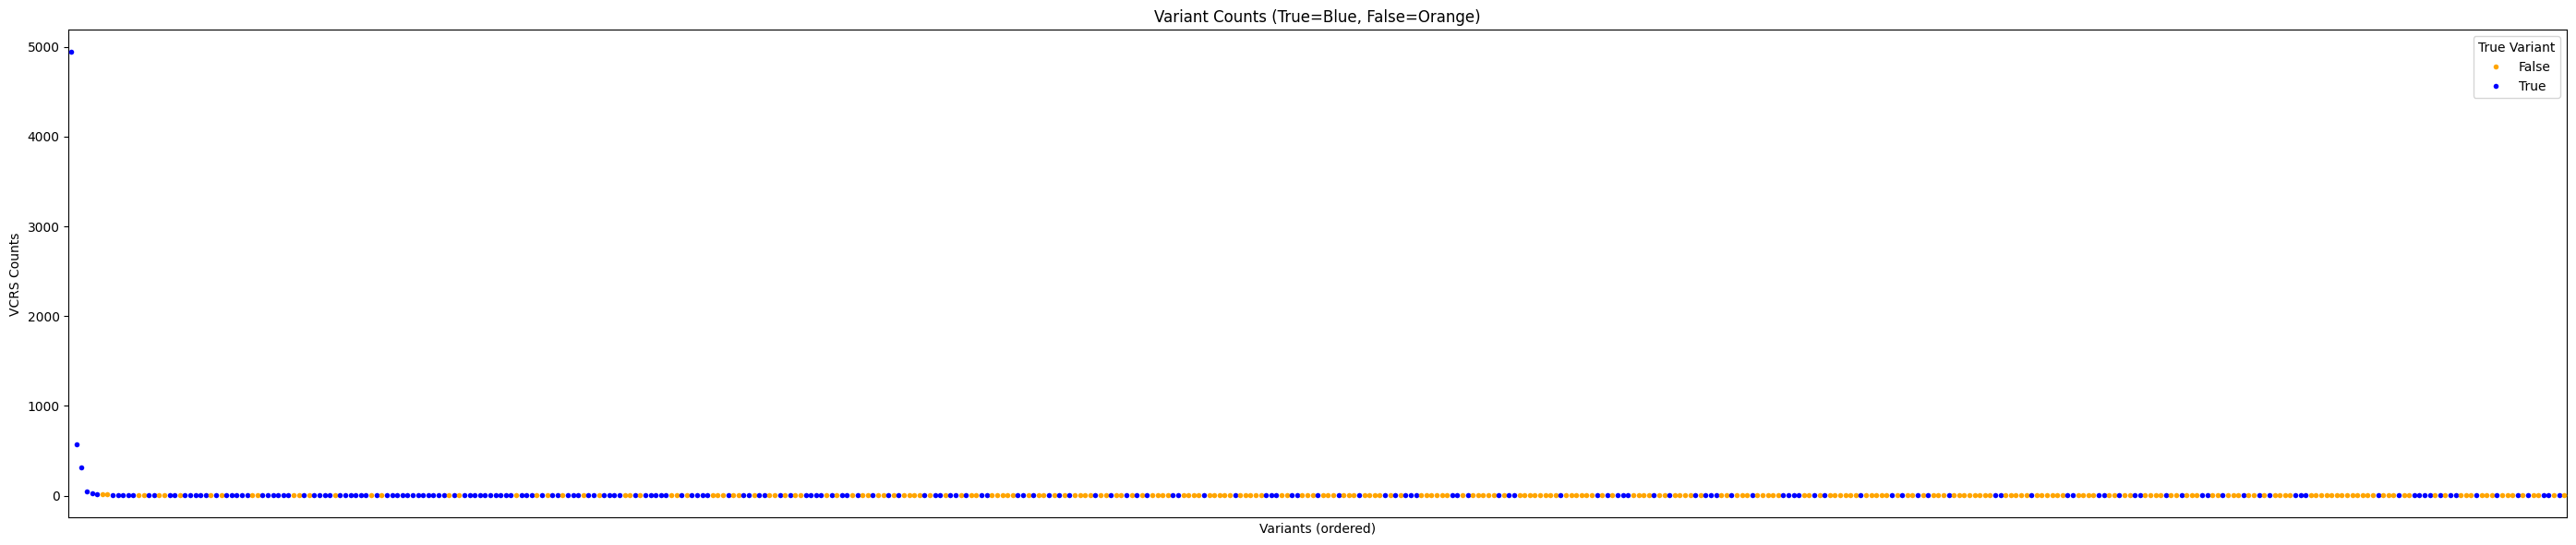

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

In [18]:
plt.figure(figsize=(28, 6))

# Sort by vcrs_count
# hgvs_df = hgvs_df.sort_values('vcrs_count', ascending=False)

sns.stripplot(
    data=hgvs_df,
    x='header_cdna',
    y='vcrs_count',
    hue='true_variant',
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4  # spread points slightly to reduce overlap
)

plt.xticks([], [])  # Hide x-axis ticks entirely
plt.xlabel('Variants (ordered)')
plt.ylabel('VCRS Counts')
plt.title('Variant Counts (True=Blue, False=Orange)')
plt.legend(title='True Variant', loc='upper right')
plt.tight_layout()

plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted.pdf"), dpi=300)
plt.show()
plt.close

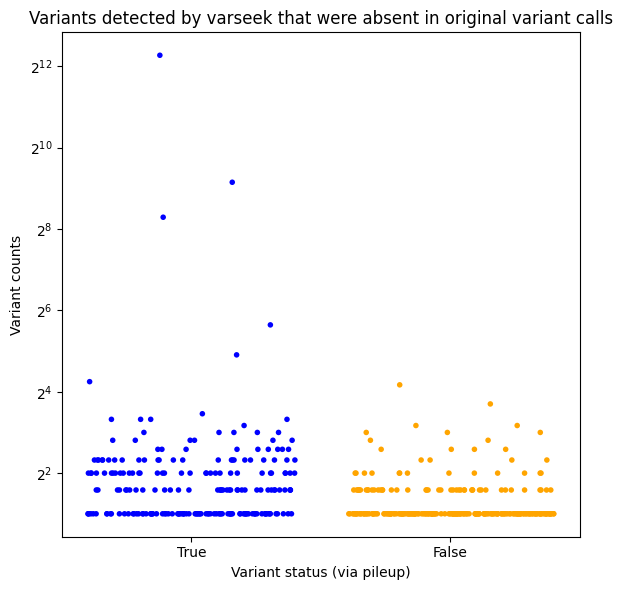

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))

# # Violin plot
# hgvs_df['true_variant_str'] = hgvs_df['true_variant'].astype(str)
# sns.violinplot(
#     data=hgvs_df,
#     x='true_variant_str',
#     y='vcrs_count',
#     palette={'True': "blue", 'False': "orange"},
#     width=0.5,
#     cut=0,  # Prevent tails from extending beyond data range
#     inner=None,  # Hide inner boxplot/sticks (optional)
#     scale='width'  # Makes area consistent
# )

# for violin in ax.collections:
#     violin.set_facecolor("lightgray")
#     violin.set_edgecolor("black")  # Optional: add black edge
#     violin.set_alpha(1)  # Optional: control transparency

# Strip plot on top
sns.stripplot(
    data=hgvs_df,
    x='true_variant',
    y='vcrs_count',
    hue='true_variant',
    order=[True, False],  # Enforce order
    hue_order=[True, False],  # Enforce order
    dodge=False,
    palette={True: "blue", False: "orange"},
    size=4,
    jitter=0.4
)

# Clean up
plt.xlabel('Variant status (via pileup)')
plt.ylabel('Variant counts')
plt.yscale("log", base=2)  # Apply log2 scaling
plt.title('Variants detected by varseek that were absent in original variant calls')
plt.legend([], [], frameon=False)  # Hide duplicate legend
plt.tight_layout()
plt.savefig(os.path.join(figures_out_dir, "alleged_FPs_vcrs_count_sorted_stacked.pdf"), dpi=300)
plt.show()
plt.close()

Get the set of especially tricky gene names and save them to a file:

In [20]:
extra_tricky_fp_threshold = 6

enst_list = []
with open(detailed_txt_out, "r") as f:
    lines = f.readlines()

for i in range(len(lines) - 1):  # stop at len-1 to access next line safely
    line = lines[i].strip()
    next_line = lines[i + 1].strip()

    if not line.startswith("vcrs"):
        continue

    try:
        # Extract the reported count value (assumes '... | ... | ... | ... | ... | xxx reported counts')
        count_str = line.split("|")[-1].strip()
        count_value = float(count_str.split()[0])
    except Exception:
        continue  # skip lines that don't match format

    if count_value < extra_tricky_fp_threshold:
        break

    if next_line == "True variant: False":
        enst_field = line.split("|")[2].strip()
        enst_id = enst_field.split(":")[0]
        enst_list.append(enst_id)

t2g_dict = vk.utils.make_t2g_dict(reference_genome_t2g)
t2g_dict = {key.split(".")[0]: val.split(".")[0] for key, val in t2g_dict.items()}  # strip off the version number
extra_tricky_fp_genes = [t2g_dict.get(enst, enst) for enst in enst_list]
extra_tricky_fp_genes = set(extra_tricky_fp_genes)  # remove duplicates
extra_tricky_fp_genes_txt_out = os.path.join(notebook_out_dir, "extra_tricky_fp_genes.txt")
with open(extra_tricky_fp_genes_txt_out, "w") as f:
    for gene in extra_tricky_fp_genes:
        f.write(f"{gene}\n")

print(f"Extra tricky FP genes: {extra_tricky_fp_genes}")

/home/jmrich/Desktop/varseek/varseek/utils/varseek_clean_utils.py:2277: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  t2g_df = pd.read_csv(t2g_file, sep="\t", header=None)


Extra tricky FP genes: {'ENSG00000108107', 'ENSG00000142541', 'ENSG00000174444', 'ENSG00000065978', 'ENSG00000181163', 'ENSG00000145425', 'ENSG00000177600', 'ENST00000608106', 'ENSG00000137818'}


### Load the files in bowtie_read_alignments into NCBI Genome workbench (or another genome viewer) to visualize the alignments (the ones with "final_")

In [21]:
# # vcrs0: ENST00000496168:c.382G>A: rs11546099 NC_000002.11:g.89246969C>T chrom2
# !samtools mpileup -r 2:89246969-89246969 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_0/final_vcrs_0_sorted_reads.bam

In [22]:
# # vcrs1: ENST00000336023:c.614A>G: rs1057725 NC_000012.11:g.49522578T>C chrom12
# !samtools mpileup -r 12:49522578-49522578 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_1/final_vcrs_1_sorted_reads.bam

In [23]:
# # vcrs3: ENST00000390312:c.218G>A: rs3737543 NC_000022.11:g.22759034G>A chrom22
# !samtools mpileup -r 22:23101523-23101523 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_3/final_vcrs_3_sorted_reads.bam

In [24]:
# # vcrs4: ENST00000579721:c.870G>C: rs114818671 NC_000006.12:g.29912149G>C chrom6
# !samtools mpileup -r 6:29912149-29912149 /data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41/bowtie_read_alignments/vcrs_4/final_vcrs_4_sorted_reads.bam

## Now look at FNs - roughly the same

In [25]:
fn_txt_path = os.path.join(RLSRP_2025_dir, "data", f"geuvadis_analysis_supplement", experiment_alias, "fns.txt")
number_of_variants = None

detailed_txt_out_fn = os.path.join(notebook_out_dir, "detailed_out_fn_modified_bam.txt")
overall_txt_out_fn = os.path.join(notebook_out_dir, "overall_out_fn_modified_bam.txt")

In [26]:
with open(fn_txt_path) as f:
    fn_set = set(line.strip() for line in f)

In [27]:
hgvs_df = pd.read_parquet(hgvs_df_path, columns=["dbsnp_id", "transcript_ID", "variant_cdna", "strand"])
hgvs_df["header_cdna"] = hgvs_df["transcript_ID"] + ":" + hgvs_df["variant_cdna"]

hgvs_df["is_false_negative"] = hgvs_df["header_cdna"].isin(fn_set)
hgvs_df = hgvs_df.loc[hgvs_df['is_false_negative']]
hgvs_df = hgvs_df.reset_index(drop=True)
hgvs_df['vcrs_id'] = 'vcrs_' + hgvs_df.index.astype(str)

hgvsc_to_vcrs_id_dict = dict(zip(hgvs_df['header_cdna'], hgvs_df['vcrs_id']))
id_to_vcrs_header = {v: k for k, v in hgvsc_to_vcrs_id_dict.items()}

In [28]:
hgvs_df.head()

,dbsnp_id,transcript_ID,variant_cdna,strand,header_cdna,is_false_negative,vcrs_id
0,rs3829740,ENST00000379407,c.1385G>C,+,ENST00000379407:c.1385G>C,True,vcrs_0
1,rs74735644,ENST00000325425,c.1242C>T,+,ENST00000325425:c.1242C>T,True,vcrs_1
2,rs202243019,ENST00000339381,c.369A>G,+,ENST00000339381:c.369A>G,True,vcrs_2
3,rs9793256,ENST00000378785,c.1167G>A,+,ENST00000378785:c.1167G>A,True,vcrs_3
4,rs1781147,ENST00000378785,c.1409C>T,+,ENST00000378785:c.1409C>T,True,vcrs_4


In [29]:
revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
valid_chromosomes = set([str(i) for i in range(1, 23)] + ["X", "Y", "MT"])

retry_strategy = Retry(
    total=5,
    backoff_factor=1,  # Wait 1s, then 2s, then 4s, etc.
    status_forcelist=[429, 500, 502, 503, 504],  # Retry on these status codes
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session = requests.Session()
session.mount("https://", adapter)
session.mount("http://", adapter)
headers = {"User-Agent": email if email else "Mozilla/5.0 (compatible; PythonScript/1.0)"}

true_variants = []  # varseek FN where varseek was incorrect
false_variants = []  # varseek FN where varseek was correct
undetermined_variants = []  # insufficient reads mapped to this point
number_of_failed_queries = 0
number_of_other_errors = 0

open(detailed_txt_out_fn, 'w').close()  # starts the file from scratch

# Align reads to human ref using bowtie2
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")
if not os.path.isfile(variant_sam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: Aligning to genome")
    subprocess.run(f"{bowtie2} --very-sensitive -k 5 -x {bowtie_reference_prefix} --quiet -p {threads} -q {fastq_file} -S {variant_sam}", shell=True, check=True)

# Convert sam to bam
variant_bam = os.path.join(notebook_out_dir, "total_reads.bam")
if not os.path.isfile(variant_bam):
    print(f"{datetime.now().strftime('%H:%M:%S')}: SAM --> BAM")
    subprocess.run(f"{samtools} view -bS -F4 {variant_sam} > {variant_bam}", shell=True, check=True)

# Sort bam file
variant_bam_sorted_prefix = "final_total_sorted_reads"
variant_bam_sorted = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + ".bam")
if not os.path.isfile(variant_bam_sorted):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM sort")
    subprocess.run(f"{samtools} sort -o {variant_bam_sorted} {variant_bam}", shell=True, check=True)

# make all alignments primary
if modify_bam:
    variant_bam_sorted_modified = os.path.join(notebook_out_dir, variant_bam_sorted_prefix + "_modified.bam")
    if not os.path.isfile(variant_bam_sorted_modified):
        print(f"{datetime.now().strftime('%H:%M:%S')}: Remove 256's")
        make_all_alignments_primary(variant_bam_sorted, variant_bam_sorted_modified)
else:
    variant_bam_sorted_modified = variant_bam_sorted
    
# Create an index for the sorted bam file (creates a .bai file)
bam_index_file = os.path.join(notebook_out_dir, variant_bam_sorted_modified + ".bai")
if not os.path.isfile(bam_index_file):
    print(f"{datetime.now().strftime('%H:%M:%S')}: BAM index")
    subprocess.run(f"{samtools} index {variant_bam_sorted_modified} -o {bam_index_file}", shell=True, check=True)

print(f"{datetime.now().strftime('%H:%M:%S')}: Entering the loop")
for _, row in tqdm(hgvs_df.iterrows(), total=len(hgvs_df)):
    variant = row['vcrs_id']
    if variant not in id_to_vcrs_header:
        continue
    variant_header = id_to_vcrs_header[variant]
    # print(f"{variant} ({variant_header})\n")

    #* new stuff
    try:
        dbsnp_id = row['dbsnp_id']
        hgvsc = row['header_cdna']
        strand = row['strand']
        if hgvsc[-2] != ">":
            continue  # only do this next part for substitutions to keep things simple for now
        
        ref_allele = hgvsc[-3].upper()
        alt_allele = hgvsc[-1].upper()
        
        if strand is None:
            transcript_id = row['transcript_ID']
            ensembl_url = f"https://grch37.rest.ensembl.org/lookup/id/{transcript_id}?content-type=application/json"
            response = requests.get(ensembl_url)
            response.raise_for_status()
            strand_numeric = response.json()["strand"]
            strand = "+" if strand_numeric == 1 else "-"
        
        if strand == "-":
            ref_allele = revcomp_dict[ref_allele]
            alt_allele = revcomp_dict[alt_allele]
        
        ncbi_url = f'https://grch37.rest.ensembl.org/variation/human/{dbsnp_id}?content-type=application/json'
        # response = requests.get(ncbi_url)
        response = session.get(ncbi_url, headers=headers, timeout=10)
        response.raise_for_status()  # Raises an error if the request failed
        ncbi_output = response.json()  # This is the full output as a string

        for mapping in ncbi_output['mappings']:
            chromosome = mapping['seq_region_name']
            position = mapping['start']
            if chromosome not in valid_chromosomes:
                continue
            else:
                break
        if chromosome not in valid_chromosomes:
            continue

        hgvsg = f"{chromosome}:g.{position}{ref_allele}>{alt_allele}"

        # Define your command as a list
        command = [
            "samtools", "mpileup",
            "-r", f"{chromosome}:{position}-{position}",
            variant_bam_sorted_modified
        ]

        # Run and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Access output
        output = result.stdout
        if output == '':
            observed_alleles = ''
        else:
            observed_alleles = output.split("\t")[4]
    
        total_allele_count = len(observed_alleles)
        base_counts = Counter(observed_alleles.upper())


        fraction_ref = base_counts[ref_allele]/total_allele_count if total_allele_count != 0 else 0
        fraction_alt = base_counts[alt_allele]/total_allele_count if total_allele_count != 0 else 0
        true_variant = base_counts[alt_allele] >= min_counts  # ((fraction_alt > fraction_ref) and (fraction_alt > 0.3))
        false_variant = base_counts[ref_allele] >= min_counts and not true_variant
            
        if true_variant:  # >= min_counts alt alleles
            variant_status = "True"
            true_variants.append(variant_header)
        elif false_variant:  # >= min_counts ref alleles and <min_counts alt alleles
            variant_status = "False"
            false_variants.append(variant_header)
        else:  # <min_counts alt alleles and <min_counts ref alleles (ie insufficient read mapping)
            variant_status = "Undetermined"
            undetermined_variants.append(variant_header)

        write_mode = "a" if os.path.isfile(detailed_txt_out_fn) else "w"
        with open(detailed_txt_out_fn, write_mode) as f:
            f.write(f"{variant} | {dbsnp_id} | {hgvsc} | ({strand}) strand | {hgvsg} \n")
            f.write(f"True variant: {variant_status}\n")
            f.write(f"Observed alleles: {observed_alleles}\n")
            f.write(f"Sequencing depth: {total_allele_count}\n")
            f.write(f"Fraction of ref: {base_counts[ref_allele]}/{total_allele_count} = {fraction_ref:.2f}\n")
            f.write(f"Fraction of alt: {base_counts[alt_allele]}/{total_allele_count} = {fraction_alt:.2f}\n")
            f.write(f"Fraction of other (should be 0): {total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]}/{total_allele_count} = {(total_allele_count - base_counts[ref_allele] - base_counts[alt_allele]) / total_allele_count if total_allele_count != 0 else 0:.2f}\n")
            f.write("--------------------------------\n")
    except requests.exceptions.HTTPError as e:
        number_of_failed_queries += 1
    except requests.exceptions.RequestException as e:
        number_of_failed_queries += 1
    except Exception as e:
        number_of_other_errors += 1
        # raise e  # can comment out if desired
    time.sleep(0.34)

    # break  # for debugging
    
with open(overall_txt_out_fn, "w") as f:
    f.write(f"Number of true variants: {len(true_variants)}\n")
    f.write(f"Number of false variants: {len(false_variants)}\n")
    f.write(f"Number of undetermined variants: {len(undetermined_variants)}\n")
    f.write(f"True variants list: {true_variants}\n")
    f.write(f"False variants list: {false_variants}\n")
    f.write(f"Undetermined variants list: {undetermined_variants}\n")
    f.write(f"Number of failed queries: {number_of_failed_queries}\n")
    f.write(f"Number of other errors: {number_of_other_errors}\n")

12:50:08: Entering the loop


  0%|                                                                                                                            | 0/3024 [00:00<?, ?it/s]

  0%|                                                                                                                    | 1/3024 [00:01<50:29,  1.00s/it]

  0%|                                                                                                                    | 2/3024 [00:01<37:40,  1.34it/s]

  0%|                                                                                                                    | 3/3024 [00:02<33:33,  1.50it/s]

  0%|▏                                                                                                                   | 4/3024 [00:02<31:32,  1.60it/s]

  0%|▏                                                                                                                   | 5/3024 [00:03<30:34,  1.65it/s]

  0%|▏                                                                                                                   | 6/3024 [00:03<29:51,  1.68it/s]

  0%|▎                                                                                                                   | 7/3024 [00:04<29:19,  1.72it/s]

  0%|▎                                                                                                                   | 8/3024 [00:04<29:04,  1.73it/s]

  0%|▎                                                                                                                   | 9/3024 [00:05<28:52,  1.74it/s]

  0%|▍                                                                                                                  | 10/3024 [00:06<29:14,  1.72it/s]

  0%|▍                                                                                                                  | 11/3024 [00:06<29:11,  1.72it/s]

  0%|▍                                                                                                                  | 12/3024 [00:07<29:00,  1.73it/s]

  0%|▍                                                                                                                  | 13/3024 [00:07<28:45,  1.74it/s]

  0%|▌                                                                                                                  | 14/3024 [00:08<28:39,  1.75it/s]

  0%|▌                                                                                                                  | 15/3024 [00:08<28:32,  1.76it/s]

  1%|▌                                                                                                                  | 16/3024 [00:09<29:06,  1.72it/s]

  1%|▋                                                                                                                  | 17/3024 [00:10<28:56,  1.73it/s]

  1%|▋                                                                                                                  | 18/3024 [00:10<28:40,  1.75it/s]

  1%|▋                                                                                                                  | 19/3024 [00:11<28:34,  1.75it/s]

  1%|▊                                                                                                                  | 20/3024 [00:11<28:26,  1.76it/s]

  1%|▊                                                                                                                  | 21/3024 [00:12<28:23,  1.76it/s]

  1%|▊                                                                                                                  | 22/3024 [00:13<29:30,  1.70it/s]

  1%|▊                                                                                                                  | 23/3024 [00:13<29:04,  1.72it/s]

  1%|▉                                                                                                                  | 24/3024 [00:14<29:18,  1.71it/s]

  1%|▉                                                                                                                  | 25/3024 [00:14<28:57,  1.73it/s]

  1%|▉                                                                                                                  | 26/3024 [00:15<28:46,  1.74it/s]

  1%|█                                                                                                                  | 27/3024 [00:15<28:32,  1.75it/s]

  1%|█                                                                                                                  | 28/3024 [00:16<28:23,  1.76it/s]

  1%|█                                                                                                                  | 29/3024 [00:17<28:25,  1.76it/s]

  1%|█▏                                                                                                                 | 30/3024 [00:17<28:35,  1.75it/s]

  1%|█▏                                                                                                                 | 31/3024 [00:18<28:28,  1.75it/s]

  1%|█▏                                                                                                                 | 32/3024 [00:18<28:21,  1.76it/s]

  1%|█▎                                                                                                                 | 33/3024 [00:19<28:16,  1.76it/s]

  1%|█▎                                                                                                                 | 34/3024 [00:19<28:09,  1.77it/s]

  1%|█▎                                                                                                                 | 35/3024 [00:20<28:16,  1.76it/s]

  1%|█▎                                                                                                                 | 36/3024 [00:21<28:12,  1.77it/s]

  1%|█▍                                                                                                                 | 37/3024 [00:21<28:19,  1.76it/s]

  1%|█▍                                                                                                                 | 38/3024 [00:22<28:10,  1.77it/s]

  1%|█▍                                                                                                                 | 39/3024 [00:22<28:06,  1.77it/s]

  1%|█▌                                                                                                                 | 40/3024 [00:23<28:28,  1.75it/s]

  1%|█▌                                                                                                                 | 41/3024 [00:23<28:23,  1.75it/s]

  1%|█▌                                                                                                                 | 42/3024 [00:24<28:25,  1.75it/s]

  1%|█▋                                                                                                                 | 43/3024 [00:25<28:24,  1.75it/s]

  1%|█▋                                                                                                                 | 44/3024 [00:25<33:44,  1.47it/s]

  1%|█▋                                                                                                                 | 45/3024 [00:26<31:58,  1.55it/s]

  2%|█▋                                                                                                                 | 46/3024 [00:27<30:46,  1.61it/s]

  2%|█▊                                                                                                                 | 47/3024 [00:27<29:59,  1.65it/s]

  2%|█▊                                                                                                                 | 48/3024 [00:28<29:39,  1.67it/s]

  2%|█▊                                                                                                                 | 49/3024 [00:28<29:17,  1.69it/s]

  2%|█▉                                                                                                                 | 50/3024 [00:29<28:52,  1.72it/s]

  2%|█▉                                                                                                                 | 51/3024 [00:29<28:33,  1.74it/s]

  2%|█▉                                                                                                                 | 52/3024 [00:30<28:17,  1.75it/s]

  2%|██                                                                                                                 | 53/3024 [00:31<28:12,  1.76it/s]

  2%|██                                                                                                                 | 54/3024 [00:31<28:10,  1.76it/s]

  2%|██                                                                                                                 | 55/3024 [00:32<28:31,  1.74it/s]

  2%|██▏                                                                                                                | 56/3024 [00:32<28:19,  1.75it/s]

  2%|██▏                                                                                                                | 57/3024 [00:33<28:09,  1.76it/s]

  2%|██▏                                                                                                                | 58/3024 [00:33<28:06,  1.76it/s]

  2%|██▎                                                                                                                | 60/3024 [00:34<21:43,  2.27it/s]

  2%|██▎                                                                                                                | 61/3024 [00:35<23:14,  2.12it/s]

  2%|██▎                                                                                                                | 62/3024 [00:35<24:33,  2.01it/s]

  2%|██▍                                                                                                                | 63/3024 [00:36<25:32,  1.93it/s]

  2%|██▍                                                                                                                | 64/3024 [00:37<34:37,  1.42it/s]

  2%|██▌                                                                                                                | 66/3024 [00:37<25:24,  1.94it/s]

  2%|██▌                                                                                                                | 67/3024 [00:38<25:57,  1.90it/s]

  2%|██▌                                                                                                                | 68/3024 [00:39<26:29,  1.86it/s]

  2%|██▌                                                                                                                | 69/3024 [00:39<27:07,  1.82it/s]

  2%|██▋                                                                                                                | 70/3024 [00:40<27:37,  1.78it/s]

  2%|██▋                                                                                                                | 71/3024 [00:40<28:54,  1.70it/s]

  2%|██▋                                                                                                                | 72/3024 [00:41<28:58,  1.70it/s]

  2%|██▊                                                                                                                | 73/3024 [00:42<29:28,  1.67it/s]

  2%|██▊                                                                                                                | 74/3024 [00:42<30:15,  1.63it/s]

  2%|██▊                                                                                                                | 75/3024 [00:43<29:49,  1.65it/s]

  3%|██▉                                                                                                                | 76/3024 [00:43<29:34,  1.66it/s]

  3%|██▉                                                                                                                | 77/3024 [00:44<29:14,  1.68it/s]

  3%|██▉                                                                                                                | 78/3024 [00:45<29:16,  1.68it/s]

  3%|███                                                                                                                | 79/3024 [00:45<29:01,  1.69it/s]

  3%|███                                                                                                                | 80/3024 [00:46<33:07,  1.48it/s]

  3%|███                                                                                                                | 81/3024 [00:47<31:28,  1.56it/s]

  3%|███                                                                                                                | 82/3024 [00:47<30:16,  1.62it/s]

  3%|███▏                                                                                                               | 83/3024 [00:48<29:47,  1.65it/s]

  3%|███▏                                                                                                               | 84/3024 [00:48<29:10,  1.68it/s]

  3%|███▏                                                                                                               | 85/3024 [00:49<28:42,  1.71it/s]

  3%|███▎                                                                                                               | 86/3024 [00:49<28:23,  1.73it/s]

  3%|███▎                                                                                                               | 87/3024 [00:50<28:21,  1.73it/s]

  3%|███▎                                                                                                               | 88/3024 [00:51<28:08,  1.74it/s]

  3%|███▍                                                                                                               | 89/3024 [00:51<28:28,  1.72it/s]

  3%|███▍                                                                                                               | 90/3024 [00:52<30:04,  1.63it/s]

  3%|███▍                                                                                                               | 91/3024 [00:52<29:24,  1.66it/s]

  3%|███▌                                                                                                               | 93/3024 [00:53<24:38,  1.98it/s]

  3%|███▌                                                                                                               | 94/3024 [00:54<25:27,  1.92it/s]

  3%|███▌                                                                                                               | 95/3024 [00:54<26:02,  1.87it/s]

  3%|███▋                                                                                                               | 96/3024 [00:55<26:34,  1.84it/s]

  3%|███▋                                                                                                               | 97/3024 [00:56<27:40,  1.76it/s]

  3%|███▋                                                                                                               | 98/3024 [00:56<27:56,  1.75it/s]

  3%|███▊                                                                                                               | 99/3024 [00:57<28:26,  1.71it/s]

  3%|███▊                                                                                                              | 100/3024 [00:57<28:32,  1.71it/s]

  3%|███▊                                                                                                              | 101/3024 [00:58<29:50,  1.63it/s]

  3%|███▊                                                                                                              | 102/3024 [00:59<29:06,  1.67it/s]

  3%|███▉                                                                                                              | 103/3024 [00:59<29:56,  1.63it/s]

  3%|███▉                                                                                                              | 104/3024 [01:00<31:17,  1.56it/s]

  3%|███▉                                                                                                              | 105/3024 [01:01<31:00,  1.57it/s]

  4%|███▉                                                                                                              | 106/3024 [01:01<30:07,  1.61it/s]

  4%|████                                                                                                              | 107/3024 [01:02<29:56,  1.62it/s]

  4%|████                                                                                                              | 108/3024 [01:02<30:28,  1.59it/s]

  4%|████                                                                                                              | 109/3024 [01:03<29:48,  1.63it/s]

  4%|████▏                                                                                                             | 110/3024 [01:04<29:42,  1.63it/s]

  4%|████▏                                                                                                             | 111/3024 [01:04<32:18,  1.50it/s]

  4%|████▏                                                                                                             | 112/3024 [01:05<31:01,  1.56it/s]

  4%|████▎                                                                                                             | 113/3024 [01:06<30:01,  1.62it/s]

  4%|████▎                                                                                                             | 114/3024 [01:06<29:26,  1.65it/s]

  4%|████▎                                                                                                             | 115/3024 [01:07<29:50,  1.62it/s]

  4%|████▍                                                                                                             | 117/3024 [01:07<23:34,  2.06it/s]

  4%|████▍                                                                                                             | 118/3024 [01:08<25:12,  1.92it/s]

  4%|████▍                                                                                                             | 119/3024 [01:09<26:11,  1.85it/s]

  4%|████▌                                                                                                             | 120/3024 [01:09<27:52,  1.74it/s]

  4%|████▌                                                                                                             | 121/3024 [01:10<30:49,  1.57it/s]

  4%|████▌                                                                                                             | 122/3024 [01:12<40:53,  1.18it/s]

  4%|████▋                                                                                                             | 123/3024 [01:13<46:46,  1.03it/s]

  4%|████▋                                                                                                             | 124/3024 [01:14<52:35,  1.09s/it]

  4%|████▋                                                                                                             | 125/3024 [01:15<55:22,  1.15s/it]

  4%|████▋                                                                                                           | 126/3024 [01:18<1:08:45,  1.42s/it]

  4%|████▋                                                                                                           | 127/3024 [01:19<1:07:27,  1.40s/it]

  4%|████▋                                                                                                           | 128/3024 [01:20<1:09:19,  1.44s/it]

  4%|████▊                                                                                                           | 129/3024 [01:22<1:07:00,  1.39s/it]

  4%|████▊                                                                                                           | 130/3024 [01:23<1:06:37,  1.38s/it]

  4%|████▉                                                                                                             | 132/3024 [01:24<42:55,  1.12it/s]

  4%|█████                                                                                                             | 133/3024 [01:25<42:25,  1.14it/s]

  4%|█████                                                                                                             | 134/3024 [01:25<42:15,  1.14it/s]

  4%|█████                                                                                                             | 135/3024 [01:26<38:22,  1.25it/s]

  4%|█████▏                                                                                                            | 136/3024 [01:27<35:41,  1.35it/s]

  5%|█████▏                                                                                                            | 137/3024 [01:27<33:21,  1.44it/s]

  5%|█████▏                                                                                                            | 138/3024 [01:28<31:41,  1.52it/s]

  5%|█████▏                                                                                                            | 139/3024 [01:28<30:36,  1.57it/s]

  5%|█████▎                                                                                                            | 140/3024 [01:29<29:53,  1.61it/s]

  5%|█████▎                                                                                                            | 141/3024 [01:29<29:36,  1.62it/s]

  5%|█████▎                                                                                                            | 142/3024 [01:30<29:21,  1.64it/s]

  5%|█████▍                                                                                                            | 143/3024 [01:31<29:26,  1.63it/s]

  5%|█████▍                                                                                                            | 144/3024 [01:31<29:49,  1.61it/s]

  5%|█████▍                                                                                                            | 145/3024 [01:32<29:31,  1.63it/s]

  5%|█████▌                                                                                                            | 146/3024 [01:33<28:58,  1.66it/s]

  5%|█████▌                                                                                                            | 147/3024 [01:33<29:16,  1.64it/s]

  5%|█████▌                                                                                                            | 148/3024 [01:34<29:24,  1.63it/s]

  5%|█████▌                                                                                                            | 149/3024 [01:34<29:07,  1.65it/s]

  5%|█████▋                                                                                                            | 150/3024 [01:35<28:41,  1.67it/s]

  5%|█████▋                                                                                                            | 151/3024 [01:36<28:17,  1.69it/s]

  5%|█████▋                                                                                                            | 152/3024 [01:36<27:56,  1.71it/s]

  5%|█████▊                                                                                                            | 153/3024 [01:37<28:20,  1.69it/s]

  5%|█████▊                                                                                                            | 154/3024 [01:37<28:34,  1.67it/s]

  5%|█████▊                                                                                                            | 155/3024 [01:38<28:21,  1.69it/s]

  5%|█████▉                                                                                                            | 156/3024 [01:38<28:16,  1.69it/s]

  5%|█████▉                                                                                                            | 158/3024 [01:39<21:38,  2.21it/s]

  5%|█████▉                                                                                                            | 159/3024 [01:40<23:10,  2.06it/s]

  5%|██████                                                                                                            | 160/3024 [01:40<24:22,  1.96it/s]

  5%|██████                                                                                                            | 161/3024 [01:41<25:04,  1.90it/s]

  5%|██████                                                                                                            | 162/3024 [01:41<25:42,  1.86it/s]

  5%|██████▏                                                                                                           | 163/3024 [01:42<26:22,  1.81it/s]

  5%|██████▏                                                                                                           | 164/3024 [01:43<26:39,  1.79it/s]

  5%|██████▏                                                                                                           | 165/3024 [01:43<27:13,  1.75it/s]

  5%|██████▎                                                                                                           | 166/3024 [01:44<27:02,  1.76it/s]

  6%|██████▎                                                                                                           | 167/3024 [01:44<27:42,  1.72it/s]

  6%|██████▎                                                                                                           | 168/3024 [01:45<28:31,  1.67it/s]

  6%|██████▎                                                                                                           | 169/3024 [01:46<28:21,  1.68it/s]

  6%|██████▍                                                                                                           | 170/3024 [01:46<28:18,  1.68it/s]

  6%|██████▍                                                                                                           | 171/3024 [01:47<30:37,  1.55it/s]

  6%|██████▍                                                                                                           | 172/3024 [01:48<34:47,  1.37it/s]

  6%|██████▌                                                                                                           | 173/3024 [01:48<33:17,  1.43it/s]

  6%|██████▌                                                                                                           | 175/3024 [01:49<24:39,  1.93it/s]

  6%|██████▋                                                                                                           | 176/3024 [01:50<25:39,  1.85it/s]

  6%|██████▋                                                                                                           | 177/3024 [01:50<26:12,  1.81it/s]

  6%|██████▋                                                                                                           | 178/3024 [01:51<26:56,  1.76it/s]

  6%|██████▋                                                                                                           | 179/3024 [01:51<27:19,  1.73it/s]

  6%|██████▊                                                                                                           | 180/3024 [01:52<27:55,  1.70it/s]

  6%|██████▊                                                                                                           | 181/3024 [01:53<28:06,  1.69it/s]

  6%|██████▊                                                                                                           | 182/3024 [01:53<27:57,  1.69it/s]

  6%|██████▉                                                                                                           | 183/3024 [01:54<27:33,  1.72it/s]

  6%|██████▉                                                                                                           | 185/3024 [01:54<21:20,  2.22it/s]

  6%|███████                                                                                                           | 186/3024 [01:55<23:11,  2.04it/s]

  6%|███████                                                                                                           | 187/3024 [01:56<24:17,  1.95it/s]

  6%|███████                                                                                                           | 188/3024 [01:56<25:30,  1.85it/s]

  6%|███████▏                                                                                                          | 189/3024 [01:57<26:18,  1.80it/s]

  6%|███████▏                                                                                                          | 190/3024 [01:57<27:44,  1.70it/s]

  6%|███████▏                                                                                                          | 191/3024 [01:58<27:27,  1.72it/s]

  6%|███████▏                                                                                                          | 192/3024 [01:59<27:49,  1.70it/s]

  6%|███████▎                                                                                                          | 193/3024 [01:59<28:27,  1.66it/s]

  6%|███████▎                                                                                                          | 194/3024 [02:00<28:10,  1.67it/s]

  6%|███████▎                                                                                                          | 195/3024 [02:00<27:48,  1.70it/s]

  6%|███████▍                                                                                                          | 196/3024 [02:01<27:54,  1.69it/s]

  7%|███████▍                                                                                                          | 197/3024 [02:02<27:35,  1.71it/s]

  7%|███████▍                                                                                                          | 198/3024 [02:02<27:54,  1.69it/s]

  7%|███████▌                                                                                                          | 199/3024 [02:03<29:29,  1.60it/s]

  7%|███████▌                                                                                                          | 200/3024 [02:04<28:42,  1.64it/s]

  7%|███████▌                                                                                                          | 201/3024 [02:04<28:52,  1.63it/s]

  7%|███████▌                                                                                                          | 202/3024 [02:05<28:23,  1.66it/s]

  7%|███████▋                                                                                                          | 203/3024 [02:05<28:30,  1.65it/s]

  7%|███████▋                                                                                                          | 204/3024 [02:06<28:22,  1.66it/s]

  7%|███████▋                                                                                                          | 205/3024 [02:07<28:41,  1.64it/s]

  7%|███████▊                                                                                                          | 206/3024 [02:07<28:27,  1.65it/s]

  7%|███████▊                                                                                                          | 207/3024 [02:08<28:48,  1.63it/s]

  7%|███████▊                                                                                                          | 208/3024 [02:09<31:09,  1.51it/s]

  7%|███████▉                                                                                                          | 209/3024 [02:09<29:49,  1.57it/s]

  7%|███████▉                                                                                                          | 210/3024 [02:10<29:12,  1.61it/s]

  7%|███████▉                                                                                                          | 211/3024 [02:10<28:30,  1.64it/s]

  7%|███████▉                                                                                                          | 212/3024 [02:11<28:28,  1.65it/s]

  7%|████████                                                                                                          | 213/3024 [02:11<28:12,  1.66it/s]

  7%|████████                                                                                                          | 214/3024 [02:12<28:08,  1.66it/s]

  7%|████████                                                                                                          | 215/3024 [02:13<29:07,  1.61it/s]

  7%|████████▏                                                                                                         | 216/3024 [02:13<28:33,  1.64it/s]

  7%|████████▏                                                                                                         | 217/3024 [02:14<27:50,  1.68it/s]

  7%|████████▏                                                                                                         | 218/3024 [02:14<27:30,  1.70it/s]

  7%|████████▎                                                                                                         | 219/3024 [02:15<27:29,  1.70it/s]

  7%|████████▎                                                                                                         | 220/3024 [02:16<27:51,  1.68it/s]

  7%|████████▎                                                                                                         | 221/3024 [02:16<27:55,  1.67it/s]

  7%|████████▎                                                                                                         | 222/3024 [02:17<27:42,  1.69it/s]

  7%|████████▍                                                                                                         | 223/3024 [02:17<27:48,  1.68it/s]

  7%|████████▍                                                                                                         | 224/3024 [02:18<28:09,  1.66it/s]

  7%|████████▍                                                                                                         | 225/3024 [02:19<28:50,  1.62it/s]

  7%|████████▌                                                                                                         | 226/3024 [02:19<28:11,  1.65it/s]

  8%|████████▌                                                                                                         | 227/3024 [02:20<27:50,  1.67it/s]

  8%|████████▌                                                                                                         | 228/3024 [02:20<27:46,  1.68it/s]

  8%|████████▋                                                                                                         | 229/3024 [02:21<27:31,  1.69it/s]

  8%|████████▋                                                                                                         | 230/3024 [02:22<27:36,  1.69it/s]

  8%|████████▋                                                                                                         | 231/3024 [02:22<28:13,  1.65it/s]

  8%|████████▋                                                                                                         | 232/3024 [02:24<39:02,  1.19it/s]

  8%|████████▊                                                                                                         | 233/3024 [02:24<36:14,  1.28it/s]

  8%|████████▊                                                                                                         | 234/3024 [02:25<34:19,  1.35it/s]

  8%|████████▊                                                                                                         | 235/3024 [02:26<32:17,  1.44it/s]

  8%|████████▉                                                                                                         | 236/3024 [02:26<31:00,  1.50it/s]

  8%|████████▉                                                                                                         | 237/3024 [02:27<30:52,  1.50it/s]

  8%|████████▉                                                                                                         | 238/3024 [02:28<31:44,  1.46it/s]

  8%|█████████                                                                                                         | 239/3024 [02:28<30:06,  1.54it/s]

  8%|█████████                                                                                                         | 240/3024 [02:29<28:59,  1.60it/s]

  8%|█████████                                                                                                         | 241/3024 [02:29<28:14,  1.64it/s]

  8%|█████████                                                                                                         | 242/3024 [02:30<27:49,  1.67it/s]

  8%|█████████▏                                                                                                        | 244/3024 [02:30<21:49,  2.12it/s]

  8%|█████████▏                                                                                                        | 245/3024 [02:31<23:23,  1.98it/s]

  8%|█████████▎                                                                                                        | 246/3024 [02:32<24:30,  1.89it/s]

  8%|█████████▎                                                                                                        | 247/3024 [02:32<25:10,  1.84it/s]

  8%|█████████▎                                                                                                        | 248/3024 [02:33<25:35,  1.81it/s]

  8%|█████████▍                                                                                                        | 249/3024 [02:33<26:32,  1.74it/s]

  8%|█████████▍                                                                                                        | 250/3024 [02:34<26:36,  1.74it/s]

  8%|█████████▍                                                                                                        | 251/3024 [02:35<27:50,  1.66it/s]

  8%|█████████▌                                                                                                        | 252/3024 [02:35<28:31,  1.62it/s]

  8%|█████████▌                                                                                                        | 253/3024 [02:36<27:50,  1.66it/s]

  8%|█████████▌                                                                                                        | 254/3024 [02:37<27:39,  1.67it/s]

  8%|█████████▌                                                                                                        | 255/3024 [02:37<27:42,  1.67it/s]

  8%|█████████▋                                                                                                        | 257/3024 [02:38<21:55,  2.10it/s]

  9%|█████████▋                                                                                                        | 258/3024 [02:38<23:19,  1.98it/s]

  9%|█████████▊                                                                                                        | 259/3024 [02:39<24:25,  1.89it/s]

  9%|█████████▊                                                                                                        | 260/3024 [02:40<25:08,  1.83it/s]

  9%|█████████▊                                                                                                        | 261/3024 [02:40<25:26,  1.81it/s]

  9%|█████████▉                                                                                                        | 262/3024 [02:41<25:51,  1.78it/s]

  9%|█████████▉                                                                                                        | 263/3024 [02:41<26:13,  1.75it/s]

  9%|█████████▉                                                                                                        | 264/3024 [02:42<26:50,  1.71it/s]

  9%|█████████▉                                                                                                        | 265/3024 [02:43<26:42,  1.72it/s]

  9%|██████████                                                                                                        | 266/3024 [02:43<27:51,  1.65it/s]

  9%|██████████                                                                                                        | 267/3024 [02:44<27:13,  1.69it/s]

  9%|██████████                                                                                                        | 268/3024 [02:44<26:51,  1.71it/s]

  9%|██████████▏                                                                                                       | 269/3024 [02:45<27:06,  1.69it/s]

  9%|██████████▏                                                                                                       | 270/3024 [02:46<27:47,  1.65it/s]

  9%|██████████▏                                                                                                       | 271/3024 [02:46<27:18,  1.68it/s]

  9%|██████████▎                                                                                                       | 272/3024 [02:47<27:15,  1.68it/s]

  9%|██████████▎                                                                                                       | 273/3024 [02:47<29:22,  1.56it/s]

  9%|██████████▎                                                                                                       | 274/3024 [02:48<28:23,  1.61it/s]

  9%|██████████▎                                                                                                       | 275/3024 [02:49<27:47,  1.65it/s]

  9%|██████████▍                                                                                                       | 276/3024 [02:49<27:43,  1.65it/s]

  9%|██████████▍                                                                                                       | 278/3024 [02:50<21:02,  2.17it/s]

  9%|██████████▌                                                                                                       | 280/3024 [02:51<19:40,  2.32it/s]

  9%|██████████▌                                                                                                       | 281/3024 [02:51<22:31,  2.03it/s]

  9%|██████████▋                                                                                                       | 282/3024 [02:52<24:28,  1.87it/s]

  9%|██████████▋                                                                                                       | 283/3024 [02:53<24:52,  1.84it/s]

  9%|██████████▋                                                                                                       | 284/3024 [02:53<25:21,  1.80it/s]

  9%|██████████▋                                                                                                       | 285/3024 [02:54<25:52,  1.76it/s]

  9%|██████████▊                                                                                                       | 286/3024 [02:54<25:56,  1.76it/s]

  9%|██████████▊                                                                                                       | 287/3024 [02:55<27:01,  1.69it/s]

 10%|██████████▉                                                                                                       | 290/3024 [02:56<17:03,  2.67it/s]

 10%|██████████▉                                                                                                       | 291/3024 [02:56<19:20,  2.35it/s]

 10%|███████████                                                                                                       | 292/3024 [02:57<21:33,  2.11it/s]

 10%|███████████                                                                                                       | 293/3024 [02:57<23:09,  1.97it/s]

 10%|███████████                                                                                                       | 294/3024 [02:58<23:56,  1.90it/s]

 10%|███████████                                                                                                       | 295/3024 [02:59<24:45,  1.84it/s]

 10%|███████████▏                                                                                                      | 296/3024 [02:59<25:14,  1.80it/s]

 10%|███████████▏                                                                                                      | 297/3024 [03:00<25:58,  1.75it/s]

 10%|███████████▏                                                                                                      | 298/3024 [03:00<27:00,  1.68it/s]

 10%|███████████▎                                                                                                      | 299/3024 [03:01<27:22,  1.66it/s]

 10%|███████████▎                                                                                                      | 301/3024 [03:02<20:59,  2.16it/s]

 10%|███████████▍                                                                                                      | 302/3024 [03:02<22:40,  2.00it/s]

 10%|███████████▍                                                                                                      | 303/3024 [03:03<26:05,  1.74it/s]

 10%|███████████▍                                                                                                      | 304/3024 [03:04<26:24,  1.72it/s]

 10%|███████████▍                                                                                                      | 305/3024 [03:04<27:27,  1.65it/s]

 10%|███████████▌                                                                                                      | 306/3024 [03:05<26:58,  1.68it/s]

 10%|███████████▌                                                                                                      | 307/3024 [03:05<26:16,  1.72it/s]

 10%|███████████▌                                                                                                      | 308/3024 [03:06<26:03,  1.74it/s]

 10%|███████████▋                                                                                                      | 309/3024 [03:07<26:12,  1.73it/s]

 10%|███████████▋                                                                                                      | 310/3024 [03:07<26:17,  1.72it/s]

 10%|███████████▋                                                                                                      | 311/3024 [03:08<26:15,  1.72it/s]

 10%|███████████▊                                                                                                      | 312/3024 [03:08<27:18,  1.66it/s]

 10%|███████████▊                                                                                                      | 313/3024 [03:09<26:56,  1.68it/s]

 10%|███████████▊                                                                                                      | 314/3024 [03:10<27:15,  1.66it/s]

 10%|███████████▉                                                                                                      | 315/3024 [03:10<26:53,  1.68it/s]

 10%|███████████▉                                                                                                      | 316/3024 [03:11<27:46,  1.62it/s]

 10%|███████████▉                                                                                                      | 317/3024 [03:11<27:03,  1.67it/s]

 11%|███████████▉                                                                                                      | 318/3024 [03:12<27:00,  1.67it/s]

 11%|████████████                                                                                                      | 319/3024 [03:13<27:29,  1.64it/s]

 11%|████████████                                                                                                      | 320/3024 [03:13<27:18,  1.65it/s]

 11%|████████████                                                                                                      | 321/3024 [03:14<27:05,  1.66it/s]

 11%|████████████▏                                                                                                     | 322/3024 [03:14<26:42,  1.69it/s]

 11%|████████████▏                                                                                                     | 323/3024 [03:15<26:49,  1.68it/s]

 11%|████████████▏                                                                                                     | 324/3024 [03:16<27:40,  1.63it/s]

 11%|████████████▎                                                                                                     | 325/3024 [03:16<28:00,  1.61it/s]

 11%|████████████▎                                                                                                     | 326/3024 [03:17<27:41,  1.62it/s]

 11%|████████████▎                                                                                                     | 327/3024 [03:17<27:02,  1.66it/s]

 11%|████████████▎                                                                                                     | 328/3024 [03:18<26:44,  1.68it/s]

 11%|████████████▍                                                                                                     | 329/3024 [03:19<27:23,  1.64it/s]

 11%|████████████▍                                                                                                     | 330/3024 [03:20<36:02,  1.25it/s]

 11%|████████████▍                                                                                                     | 331/3024 [03:21<44:55,  1.00s/it]

 11%|████████████▌                                                                                                     | 332/3024 [03:23<47:52,  1.07s/it]

 11%|████████████▌                                                                                                     | 333/3024 [03:24<49:41,  1.11s/it]

 11%|████████████▌                                                                                                     | 334/3024 [03:25<51:24,  1.15s/it]

 11%|████████████▋                                                                                                     | 335/3024 [03:26<53:22,  1.19s/it]

 11%|████████████▋                                                                                                     | 336/3024 [03:28<53:52,  1.20s/it]

 11%|████████████▋                                                                                                     | 337/3024 [03:28<45:52,  1.02s/it]

 11%|████████████▋                                                                                                     | 338/3024 [03:29<40:04,  1.12it/s]

 11%|████████████▊                                                                                                     | 339/3024 [03:29<37:08,  1.20it/s]

 11%|████████████▊                                                                                                     | 340/3024 [03:30<33:30,  1.34it/s]

 11%|████████████▊                                                                                                     | 341/3024 [03:31<31:23,  1.42it/s]

 11%|████████████▉                                                                                                     | 343/3024 [03:31<23:01,  1.94it/s]

 11%|████████████▉                                                                                                     | 344/3024 [03:32<23:49,  1.87it/s]

 11%|█████████████                                                                                                     | 345/3024 [03:32<25:03,  1.78it/s]

 11%|█████████████                                                                                                     | 346/3024 [03:33<25:22,  1.76it/s]

 11%|█████████████                                                                                                     | 347/3024 [03:34<26:00,  1.72it/s]

 12%|█████████████                                                                                                     | 348/3024 [03:34<26:34,  1.68it/s]

 12%|█████████████▏                                                                                                    | 349/3024 [03:35<26:33,  1.68it/s]

 12%|█████████████▏                                                                                                    | 350/3024 [03:35<26:45,  1.67it/s]

 12%|█████████████▏                                                                                                    | 351/3024 [03:36<29:29,  1.51it/s]

 12%|█████████████▎                                                                                                    | 352/3024 [03:37<28:33,  1.56it/s]

 12%|█████████████▎                                                                                                    | 353/3024 [03:37<27:44,  1.60it/s]

 12%|█████████████▎                                                                                                    | 354/3024 [03:38<27:09,  1.64it/s]

 12%|█████████████▍                                                                                                    | 355/3024 [03:39<27:15,  1.63it/s]

 12%|█████████████▍                                                                                                    | 356/3024 [03:39<27:08,  1.64it/s]

 12%|█████████████▍                                                                                                    | 357/3024 [03:40<28:24,  1.56it/s]

 12%|█████████████▍                                                                                                    | 358/3024 [03:41<28:56,  1.54it/s]

 12%|█████████████▌                                                                                                    | 359/3024 [03:42<33:49,  1.31it/s]

 12%|█████████████▌                                                                                                    | 360/3024 [03:42<31:15,  1.42it/s]

 12%|█████████████▌                                                                                                    | 361/3024 [03:43<29:28,  1.51it/s]

 12%|█████████████▋                                                                                                    | 362/3024 [03:43<28:08,  1.58it/s]

 12%|█████████████▋                                                                                                    | 363/3024 [03:44<27:12,  1.63it/s]

 12%|█████████████▋                                                                                                    | 364/3024 [03:45<29:26,  1.51it/s]

 12%|█████████████▊                                                                                                    | 365/3024 [03:45<28:07,  1.58it/s]

 12%|█████████████▊                                                                                                    | 366/3024 [03:46<27:12,  1.63it/s]

 12%|█████████████▊                                                                                                    | 367/3024 [03:46<26:36,  1.66it/s]

 12%|█████████████▊                                                                                                    | 368/3024 [03:47<26:04,  1.70it/s]

 12%|█████████████▉                                                                                                    | 369/3024 [03:48<25:54,  1.71it/s]

 12%|█████████████▉                                                                                                    | 370/3024 [03:48<25:42,  1.72it/s]

 12%|██████████████                                                                                                    | 372/3024 [03:50<29:12,  1.51it/s]

 12%|██████████████                                                                                                    | 373/3024 [03:51<36:48,  1.20it/s]

 12%|██████████████                                                                                                    | 374/3024 [03:52<34:45,  1.27it/s]

 12%|██████████████▏                                                                                                   | 375/3024 [03:52<32:20,  1.37it/s]

 12%|██████████████▏                                                                                                   | 376/3024 [03:53<30:26,  1.45it/s]

 12%|██████████████▏                                                                                                   | 377/3024 [03:53<29:34,  1.49it/s]

 12%|██████████████▎                                                                                                   | 378/3024 [03:54<28:42,  1.54it/s]

 13%|██████████████▎                                                                                                   | 379/3024 [03:55<27:40,  1.59it/s]

 13%|██████████████▎                                                                                                   | 380/3024 [03:55<27:02,  1.63it/s]

 13%|██████████████▎                                                                                                   | 381/3024 [03:56<26:41,  1.65it/s]

 13%|██████████████▍                                                                                                   | 382/3024 [03:56<26:20,  1.67it/s]

 13%|██████████████▍                                                                                                   | 383/3024 [03:57<26:27,  1.66it/s]

 13%|██████████████▍                                                                                                   | 384/3024 [03:58<26:26,  1.66it/s]

 13%|██████████████▌                                                                                                   | 385/3024 [03:58<27:20,  1.61it/s]

 13%|██████████████▌                                                                                                   | 386/3024 [03:59<26:50,  1.64it/s]

 13%|██████████████▌                                                                                                   | 387/3024 [03:59<26:15,  1.67it/s]

 13%|██████████████▋                                                                                                   | 388/3024 [04:00<29:02,  1.51it/s]

 13%|██████████████▋                                                                                                   | 389/3024 [04:03<51:34,  1.17s/it]

 13%|██████████████▋                                                                                                   | 390/3024 [04:03<44:28,  1.01s/it]

 13%|██████████████▋                                                                                                   | 391/3024 [04:04<39:14,  1.12it/s]

 13%|██████████████▊                                                                                                   | 392/3024 [04:04<35:34,  1.23it/s]

 13%|██████████████▊                                                                                                   | 393/3024 [04:05<32:29,  1.35it/s]

 13%|██████████████▊                                                                                                   | 394/3024 [04:06<32:53,  1.33it/s]

 13%|██████████████▉                                                                                                   | 395/3024 [04:06<30:37,  1.43it/s]

 13%|██████████████▉                                                                                                   | 396/3024 [04:07<29:09,  1.50it/s]

 13%|██████████████▉                                                                                                   | 397/3024 [04:08<28:22,  1.54it/s]

 13%|███████████████                                                                                                   | 398/3024 [04:08<27:54,  1.57it/s]

 13%|███████████████                                                                                                   | 399/3024 [04:09<27:03,  1.62it/s]

 13%|███████████████                                                                                                   | 400/3024 [04:09<26:39,  1.64it/s]

 13%|███████████████                                                                                                   | 401/3024 [04:10<27:31,  1.59it/s]

 13%|███████████████▏                                                                                                  | 402/3024 [04:11<28:04,  1.56it/s]

 13%|███████████████▏                                                                                                  | 403/3024 [04:11<27:05,  1.61it/s]

 13%|███████████████▏                                                                                                  | 404/3024 [04:12<26:33,  1.64it/s]

 13%|███████████████▎                                                                                                  | 405/3024 [04:12<26:46,  1.63it/s]

 13%|███████████████▎                                                                                                  | 406/3024 [04:13<29:15,  1.49it/s]

 13%|███████████████▎                                                                                                  | 407/3024 [04:14<28:19,  1.54it/s]

 14%|███████████████▍                                                                                                  | 409/3024 [04:14<21:15,  2.05it/s]

 14%|███████████████▍                                                                                                  | 410/3024 [04:15<22:10,  1.97it/s]

 14%|███████████████▍                                                                                                  | 411/3024 [04:16<23:32,  1.85it/s]

 14%|███████████████▌                                                                                                  | 412/3024 [04:16<24:03,  1.81it/s]

 14%|███████████████▌                                                                                                  | 413/3024 [04:17<24:31,  1.77it/s]

 14%|███████████████▌                                                                                                  | 414/3024 [04:17<25:03,  1.74it/s]

 14%|███████████████▋                                                                                                  | 415/3024 [04:18<25:21,  1.72it/s]

 14%|███████████████▋                                                                                                  | 416/3024 [04:19<25:28,  1.71it/s]

 14%|███████████████▋                                                                                                  | 417/3024 [04:19<25:21,  1.71it/s]

 14%|███████████████▊                                                                                                  | 419/3024 [04:20<19:24,  2.24it/s]

 14%|███████████████▊                                                                                                  | 420/3024 [04:20<21:35,  2.01it/s]

 14%|███████████████▊                                                                                                  | 421/3024 [04:21<22:24,  1.94it/s]

 14%|███████████████▉                                                                                                  | 422/3024 [04:22<23:02,  1.88it/s]

 14%|███████████████▉                                                                                                  | 423/3024 [04:22<23:39,  1.83it/s]

 14%|███████████████▉                                                                                                  | 424/3024 [04:23<24:31,  1.77it/s]

 14%|████████████████                                                                                                  | 425/3024 [04:23<24:51,  1.74it/s]

 14%|████████████████                                                                                                  | 426/3024 [04:24<25:26,  1.70it/s]

 14%|████████████████                                                                                                  | 427/3024 [04:25<26:36,  1.63it/s]

 14%|████████████████▏                                                                                                 | 428/3024 [04:25<28:40,  1.51it/s]

 14%|████████████████▏                                                                                                 | 429/3024 [04:26<27:22,  1.58it/s]

 14%|████████████████▏                                                                                                 | 430/3024 [04:27<26:30,  1.63it/s]

 14%|████████████████▏                                                                                                 | 431/3024 [04:27<25:52,  1.67it/s]

 14%|████████████████▎                                                                                                 | 432/3024 [04:28<25:21,  1.70it/s]

 14%|████████████████▎                                                                                                 | 433/3024 [04:28<25:13,  1.71it/s]

 14%|████████████████▎                                                                                                 | 434/3024 [04:29<25:12,  1.71it/s]

 14%|████████████████▍                                                                                                 | 435/3024 [04:29<25:20,  1.70it/s]

 14%|████████████████▍                                                                                                 | 436/3024 [04:30<25:45,  1.67it/s]

 14%|████████████████▍                                                                                                 | 437/3024 [04:31<25:49,  1.67it/s]

 14%|████████████████▌                                                                                                 | 438/3024 [04:31<25:30,  1.69it/s]

 15%|████████████████▌                                                                                                 | 439/3024 [04:32<25:22,  1.70it/s]

 15%|████████████████▌                                                                                                 | 440/3024 [04:32<25:03,  1.72it/s]

 15%|████████████████▋                                                                                                 | 441/3024 [04:33<25:09,  1.71it/s]

 15%|████████████████▋                                                                                                 | 442/3024 [04:34<25:12,  1.71it/s]

 15%|████████████████▋                                                                                                 | 443/3024 [04:34<25:06,  1.71it/s]

 15%|████████████████▋                                                                                                 | 444/3024 [04:35<25:09,  1.71it/s]

 15%|████████████████▊                                                                                                 | 445/3024 [04:35<24:58,  1.72it/s]

 15%|████████████████▊                                                                                                 | 446/3024 [04:36<24:59,  1.72it/s]

 15%|████████████████▊                                                                                                 | 447/3024 [04:36<25:03,  1.71it/s]

 15%|████████████████▉                                                                                                 | 448/3024 [04:37<25:36,  1.68it/s]

 15%|████████████████▉                                                                                                 | 449/3024 [04:38<25:27,  1.69it/s]

 15%|████████████████▉                                                                                                 | 450/3024 [04:38<25:28,  1.68it/s]

 15%|█████████████████                                                                                                 | 451/3024 [04:39<25:36,  1.67it/s]

 15%|█████████████████                                                                                                 | 452/3024 [04:39<25:36,  1.67it/s]

 15%|█████████████████                                                                                                 | 453/3024 [04:40<25:46,  1.66it/s]

 15%|█████████████████                                                                                                 | 454/3024 [04:41<25:29,  1.68it/s]

 15%|█████████████████▏                                                                                                | 455/3024 [04:41<25:55,  1.65it/s]

 15%|█████████████████▏                                                                                                | 456/3024 [04:42<25:36,  1.67it/s]

 15%|█████████████████▏                                                                                                | 457/3024 [04:42<25:37,  1.67it/s]

 15%|█████████████████▎                                                                                                | 458/3024 [04:43<25:53,  1.65it/s]

 15%|█████████████████▎                                                                                                | 459/3024 [04:44<26:00,  1.64it/s]

 15%|█████████████████▎                                                                                                | 460/3024 [04:44<25:59,  1.64it/s]

 15%|█████████████████▍                                                                                                | 461/3024 [04:45<25:49,  1.65it/s]

 15%|█████████████████▍                                                                                                | 462/3024 [04:46<25:58,  1.64it/s]

 15%|█████████████████▍                                                                                                | 463/3024 [04:46<25:32,  1.67it/s]

 15%|█████████████████▍                                                                                                | 464/3024 [04:47<25:35,  1.67it/s]

 15%|█████████████████▌                                                                                                | 465/3024 [04:47<25:46,  1.65it/s]

 15%|█████████████████▌                                                                                                | 466/3024 [04:48<25:31,  1.67it/s]

 15%|█████████████████▌                                                                                                | 467/3024 [04:49<25:47,  1.65it/s]

 15%|█████████████████▋                                                                                                | 468/3024 [04:49<25:25,  1.68it/s]

 16%|█████████████████▋                                                                                                | 469/3024 [04:50<25:17,  1.68it/s]

 16%|█████████████████▋                                                                                                | 470/3024 [04:50<25:16,  1.68it/s]

 16%|█████████████████▊                                                                                                | 471/3024 [04:51<25:07,  1.69it/s]

 16%|█████████████████▊                                                                                                | 472/3024 [04:52<26:05,  1.63it/s]

 16%|█████████████████▊                                                                                                | 473/3024 [04:52<25:56,  1.64it/s]

 16%|█████████████████▊                                                                                                | 474/3024 [04:53<25:58,  1.64it/s]

 16%|█████████████████▉                                                                                                | 475/3024 [04:53<25:23,  1.67it/s]

 16%|█████████████████▉                                                                                                | 476/3024 [04:54<25:17,  1.68it/s]

 16%|█████████████████▉                                                                                                | 477/3024 [04:55<25:42,  1.65it/s]

 16%|██████████████████                                                                                                | 478/3024 [04:55<25:47,  1.65it/s]

 16%|██████████████████                                                                                                | 479/3024 [04:56<25:48,  1.64it/s]

 16%|██████████████████                                                                                                | 480/3024 [04:56<25:45,  1.65it/s]

 16%|██████████████████▏                                                                                               | 481/3024 [04:57<25:28,  1.66it/s]

 16%|██████████████████▏                                                                                               | 482/3024 [04:58<25:11,  1.68it/s]

 16%|██████████████████▏                                                                                               | 483/3024 [04:58<24:55,  1.70it/s]

 16%|██████████████████▏                                                                                               | 484/3024 [04:59<24:50,  1.70it/s]

 16%|██████████████████▎                                                                                               | 485/3024 [04:59<25:27,  1.66it/s]

 16%|██████████████████▎                                                                                               | 486/3024 [05:00<25:10,  1.68it/s]

 16%|██████████████████▎                                                                                               | 487/3024 [05:01<24:56,  1.70it/s]

 16%|██████████████████▍                                                                                               | 488/3024 [05:02<34:17,  1.23it/s]

 16%|██████████████████▍                                                                                               | 489/3024 [05:03<39:25,  1.07it/s]

 16%|██████████████████▍                                                                                               | 490/3024 [05:04<44:07,  1.04s/it]

 16%|██████████████████▌                                                                                               | 491/3024 [05:06<46:08,  1.09s/it]

 16%|██████████████████▌                                                                                               | 492/3024 [05:07<48:48,  1.16s/it]

 16%|██████████████████▌                                                                                               | 493/3024 [05:08<49:27,  1.17s/it]

 16%|██████████████████▌                                                                                               | 494/3024 [05:09<49:25,  1.17s/it]

 16%|██████████████████▋                                                                                               | 495/3024 [05:11<50:41,  1.20s/it]

 16%|██████████████████▋                                                                                               | 496/3024 [05:12<51:29,  1.22s/it]

 16%|██████████████████▋                                                                                               | 497/3024 [05:13<51:28,  1.22s/it]

 16%|██████████████████▊                                                                                               | 498/3024 [05:14<50:50,  1.21s/it]

 17%|██████████████████▊                                                                                               | 499/3024 [05:15<52:02,  1.24s/it]

 17%|██████████████████▊                                                                                               | 500/3024 [05:16<44:51,  1.07s/it]

 17%|██████████████████▉                                                                                               | 501/3024 [05:17<38:57,  1.08it/s]

 17%|██████████████████▉                                                                                               | 502/3024 [05:17<35:02,  1.20it/s]

 17%|██████████████████▉                                                                                               | 503/3024 [05:18<31:43,  1.32it/s]

 17%|███████████████████                                                                                               | 504/3024 [05:19<29:53,  1.41it/s]

 17%|███████████████████                                                                                               | 505/3024 [05:19<28:39,  1.46it/s]

 17%|███████████████████                                                                                               | 506/3024 [05:20<27:24,  1.53it/s]

 17%|███████████████████                                                                                               | 507/3024 [05:20<26:42,  1.57it/s]

 17%|███████████████████▏                                                                                              | 508/3024 [05:21<25:53,  1.62it/s]

 17%|███████████████████▏                                                                                              | 509/3024 [05:22<25:18,  1.66it/s]

 17%|███████████████████▏                                                                                              | 510/3024 [05:22<25:03,  1.67it/s]

 17%|███████████████████▎                                                                                              | 511/3024 [05:23<29:11,  1.43it/s]

 17%|███████████████████▍                                                                                              | 514/3024 [05:24<17:22,  2.41it/s]

 17%|███████████████████▍                                                                                              | 515/3024 [05:24<18:39,  2.24it/s]

 17%|███████████████████▍                                                                                              | 516/3024 [05:25<19:48,  2.11it/s]

 17%|███████████████████▍                                                                                              | 517/3024 [05:26<27:34,  1.52it/s]

 17%|███████████████████▌                                                                                              | 519/3024 [05:27<21:10,  1.97it/s]

 17%|███████████████████▌                                                                                              | 520/3024 [05:27<21:46,  1.92it/s]

 17%|███████████████████▋                                                                                              | 521/3024 [05:28<22:35,  1.85it/s]

 17%|███████████████████▋                                                                                              | 523/3024 [05:28<18:40,  2.23it/s]

 17%|███████████████████▊                                                                                              | 524/3024 [05:29<20:12,  2.06it/s]

 17%|███████████████████▊                                                                                              | 525/3024 [05:30<21:26,  1.94it/s]

 17%|███████████████████▊                                                                                              | 526/3024 [05:30<22:18,  1.87it/s]

 17%|███████████████████▊                                                                                              | 527/3024 [05:31<22:43,  1.83it/s]

 17%|███████████████████▉                                                                                              | 528/3024 [05:31<23:53,  1.74it/s]

 17%|███████████████████▉                                                                                              | 529/3024 [05:32<24:27,  1.70it/s]

 18%|███████████████████▉                                                                                              | 530/3024 [05:33<24:30,  1.70it/s]

 18%|████████████████████                                                                                              | 531/3024 [05:33<24:31,  1.69it/s]

 18%|████████████████████                                                                                              | 532/3024 [05:34<27:50,  1.49it/s]

 18%|████████████████████                                                                                              | 533/3024 [05:35<26:48,  1.55it/s]

 18%|████████████████████▏                                                                                             | 534/3024 [05:35<25:49,  1.61it/s]

 18%|████████████████████▏                                                                                             | 535/3024 [05:36<25:20,  1.64it/s]

 18%|████████████████████▏                                                                                             | 536/3024 [05:36<25:22,  1.63it/s]

 18%|████████████████████▏                                                                                             | 537/3024 [05:37<25:16,  1.64it/s]

 18%|████████████████████▎                                                                                             | 538/3024 [05:38<24:59,  1.66it/s]

 18%|████████████████████▎                                                                                             | 539/3024 [05:38<25:05,  1.65it/s]

 18%|████████████████████▎                                                                                             | 540/3024 [05:39<25:03,  1.65it/s]

 18%|████████████████████▍                                                                                             | 541/3024 [05:39<24:57,  1.66it/s]

 18%|████████████████████▍                                                                                             | 542/3024 [05:40<24:46,  1.67it/s]

 18%|████████████████████▍                                                                                             | 543/3024 [05:41<24:22,  1.70it/s]

 18%|████████████████████▌                                                                                             | 544/3024 [05:41<24:38,  1.68it/s]

 18%|████████████████████▌                                                                                             | 545/3024 [05:42<24:25,  1.69it/s]

 18%|████████████████████▌                                                                                             | 546/3024 [05:42<24:10,  1.71it/s]

 18%|████████████████████▌                                                                                             | 547/3024 [05:43<24:12,  1.71it/s]

 18%|████████████████████▋                                                                                             | 548/3024 [05:44<25:34,  1.61it/s]

 18%|████████████████████▋                                                                                             | 549/3024 [05:44<25:15,  1.63it/s]

 18%|████████████████████▋                                                                                             | 550/3024 [05:45<25:09,  1.64it/s]

 18%|████████████████████▊                                                                                             | 551/3024 [05:45<24:56,  1.65it/s]

 18%|████████████████████▊                                                                                             | 552/3024 [05:46<24:46,  1.66it/s]

 18%|████████████████████▊                                                                                             | 553/3024 [05:47<24:37,  1.67it/s]

 18%|████████████████████▉                                                                                             | 554/3024 [05:47<24:24,  1.69it/s]

 18%|████████████████████▉                                                                                             | 555/3024 [05:48<24:07,  1.71it/s]

 18%|████████████████████▉                                                                                             | 556/3024 [05:48<24:29,  1.68it/s]

 18%|████████████████████▉                                                                                             | 557/3024 [05:49<24:20,  1.69it/s]

 18%|█████████████████████                                                                                             | 558/3024 [05:50<24:06,  1.70it/s]

 18%|█████████████████████                                                                                             | 559/3024 [05:50<24:26,  1.68it/s]

 19%|█████████████████████                                                                                             | 560/3024 [05:51<24:33,  1.67it/s]

 19%|█████████████████████▏                                                                                            | 561/3024 [05:51<24:08,  1.70it/s]

 19%|█████████████████████▏                                                                                            | 562/3024 [05:52<24:13,  1.69it/s]

 19%|█████████████████████▏                                                                                            | 563/3024 [05:52<24:07,  1.70it/s]

 19%|█████████████████████▎                                                                                            | 565/3024 [05:53<18:27,  2.22it/s]

 19%|█████████████████████▎                                                                                            | 566/3024 [05:54<20:09,  2.03it/s]

 19%|█████████████████████▍                                                                                            | 567/3024 [05:54<21:14,  1.93it/s]

 19%|█████████████████████▍                                                                                            | 568/3024 [05:55<21:49,  1.88it/s]

 19%|█████████████████████▍                                                                                            | 569/3024 [05:55<22:19,  1.83it/s]

 19%|█████████████████████▍                                                                                            | 570/3024 [05:56<22:46,  1.80it/s]

 19%|█████████████████████▌                                                                                            | 571/3024 [05:57<23:11,  1.76it/s]

 19%|█████████████████████▌                                                                                            | 572/3024 [05:57<23:18,  1.75it/s]

 19%|█████████████████████▌                                                                                            | 573/3024 [05:58<23:56,  1.71it/s]

 19%|█████████████████████▋                                                                                            | 574/3024 [05:58<25:14,  1.62it/s]

 19%|█████████████████████▋                                                                                            | 575/3024 [05:59<24:36,  1.66it/s]

 19%|█████████████████████▋                                                                                            | 576/3024 [06:00<24:27,  1.67it/s]

 19%|█████████████████████▊                                                                                            | 577/3024 [06:00<24:02,  1.70it/s]

 19%|█████████████████████▊                                                                                            | 578/3024 [06:01<24:17,  1.68it/s]

 19%|█████████████████████▊                                                                                            | 579/3024 [06:01<24:02,  1.69it/s]

 19%|█████████████████████▊                                                                                            | 580/3024 [06:02<23:39,  1.72it/s]

 19%|█████████████████████▉                                                                                            | 581/3024 [06:03<23:29,  1.73it/s]

 19%|█████████████████████▉                                                                                            | 582/3024 [06:03<26:48,  1.52it/s]

 19%|█████████████████████▉                                                                                            | 583/3024 [06:04<28:26,  1.43it/s]

 19%|██████████████████████                                                                                            | 584/3024 [06:05<30:28,  1.33it/s]

 19%|██████████████████████                                                                                            | 585/3024 [06:06<31:10,  1.30it/s]

 19%|██████████████████████                                                                                            | 586/3024 [06:07<31:16,  1.30it/s]

 19%|██████████████████████▏                                                                                           | 587/3024 [06:07<29:26,  1.38it/s]

 19%|██████████████████████▏                                                                                           | 588/3024 [06:08<27:51,  1.46it/s]

 19%|██████████████████████▏                                                                                           | 589/3024 [06:08<27:12,  1.49it/s]

 20%|██████████████████████▎                                                                                           | 592/3024 [06:10<21:55,  1.85it/s]

 20%|██████████████████████▎                                                                                           | 593/3024 [06:11<27:51,  1.45it/s]

 20%|██████████████████████▍                                                                                           | 594/3024 [06:12<32:48,  1.23it/s]

 20%|██████████████████████▍                                                                                           | 595/3024 [06:13<36:33,  1.11it/s]

 20%|██████████████████████▍                                                                                           | 596/3024 [06:15<39:53,  1.01it/s]

 20%|██████████████████████▌                                                                                           | 597/3024 [06:16<42:14,  1.04s/it]

 20%|██████████████████████▌                                                                                           | 598/3024 [06:17<44:01,  1.09s/it]

 20%|██████████████████████▌                                                                                           | 599/3024 [06:18<38:46,  1.04it/s]

 20%|██████████████████████▌                                                                                           | 600/3024 [06:18<34:49,  1.16it/s]

 20%|██████████████████████▋                                                                                           | 601/3024 [06:19<31:29,  1.28it/s]

 20%|██████████████████████▋                                                                                           | 602/3024 [06:20<29:38,  1.36it/s]

 20%|██████████████████████▋                                                                                           | 603/3024 [06:20<27:48,  1.45it/s]

 20%|██████████████████████▊                                                                                           | 604/3024 [06:21<26:40,  1.51it/s]

 20%|██████████████████████▊                                                                                           | 605/3024 [06:21<25:51,  1.56it/s]

 20%|██████████████████████▊                                                                                           | 606/3024 [06:22<25:33,  1.58it/s]

 20%|██████████████████████▉                                                                                           | 607/3024 [06:22<25:01,  1.61it/s]

 20%|██████████████████████▉                                                                                           | 608/3024 [06:23<24:48,  1.62it/s]

 20%|██████████████████████▉                                                                                           | 609/3024 [06:24<24:30,  1.64it/s]

 20%|██████████████████████▉                                                                                           | 610/3024 [06:25<27:06,  1.48it/s]

 20%|███████████████████████                                                                                           | 611/3024 [06:25<26:38,  1.51it/s]

 20%|███████████████████████                                                                                           | 612/3024 [06:26<25:34,  1.57it/s]

 20%|███████████████████████                                                                                           | 613/3024 [06:26<24:57,  1.61it/s]

 20%|███████████████████████▏                                                                                          | 614/3024 [06:27<24:23,  1.65it/s]

 20%|███████████████████████▏                                                                                          | 615/3024 [06:27<24:19,  1.65it/s]

 20%|███████████████████████▏                                                                                          | 616/3024 [06:28<24:41,  1.63it/s]

 20%|███████████████████████▎                                                                                          | 617/3024 [06:29<25:08,  1.60it/s]

 20%|███████████████████████▎                                                                                          | 618/3024 [06:29<24:46,  1.62it/s]

 20%|███████████████████████▎                                                                                          | 619/3024 [06:30<25:47,  1.55it/s]

 21%|███████████████████████▎                                                                                          | 620/3024 [06:31<24:51,  1.61it/s]

 21%|███████████████████████▍                                                                                          | 621/3024 [06:31<24:29,  1.64it/s]

 21%|███████████████████████▍                                                                                          | 622/3024 [06:32<24:03,  1.66it/s]

 21%|███████████████████████▍                                                                                          | 623/3024 [06:33<25:05,  1.60it/s]

 21%|███████████████████████▌                                                                                          | 624/3024 [06:33<25:24,  1.57it/s]

 21%|███████████████████████▌                                                                                          | 625/3024 [06:34<24:34,  1.63it/s]

 21%|███████████████████████▌                                                                                          | 626/3024 [06:34<24:24,  1.64it/s]

 21%|███████████████████████▋                                                                                          | 627/3024 [06:35<24:01,  1.66it/s]

 21%|███████████████████████▋                                                                                          | 628/3024 [06:36<24:33,  1.63it/s]

 21%|███████████████████████▋                                                                                          | 629/3024 [06:36<23:59,  1.66it/s]

 21%|███████████████████████▊                                                                                          | 630/3024 [06:37<23:53,  1.67it/s]

 21%|███████████████████████▊                                                                                          | 631/3024 [06:37<24:29,  1.63it/s]

 21%|███████████████████████▊                                                                                          | 632/3024 [06:38<24:09,  1.65it/s]

 21%|███████████████████████▊                                                                                          | 633/3024 [06:39<23:57,  1.66it/s]

 21%|███████████████████████▉                                                                                          | 634/3024 [06:39<23:42,  1.68it/s]

 21%|███████████████████████▉                                                                                          | 635/3024 [06:40<23:37,  1.68it/s]

 21%|███████████████████████▉                                                                                          | 636/3024 [06:40<23:43,  1.68it/s]

 21%|████████████████████████                                                                                          | 637/3024 [06:41<23:59,  1.66it/s]

 21%|████████████████████████                                                                                          | 638/3024 [06:42<23:52,  1.67it/s]

 21%|████████████████████████                                                                                          | 639/3024 [06:42<23:46,  1.67it/s]

 21%|████████████████████████▏                                                                                         | 640/3024 [06:43<24:58,  1.59it/s]

 21%|████████████████████████▏                                                                                         | 641/3024 [06:43<24:13,  1.64it/s]

 21%|████████████████████████▏                                                                                         | 642/3024 [06:44<23:59,  1.65it/s]

 21%|████████████████████████▏                                                                                         | 643/3024 [06:45<24:50,  1.60it/s]

 21%|████████████████████████▎                                                                                         | 644/3024 [06:45<24:19,  1.63it/s]

 21%|████████████████████████▎                                                                                         | 645/3024 [06:46<23:41,  1.67it/s]

 21%|████████████████████████▎                                                                                         | 646/3024 [06:46<23:53,  1.66it/s]

 21%|████████████████████████▍                                                                                         | 647/3024 [06:47<23:59,  1.65it/s]

 21%|████████████████████████▍                                                                                         | 648/3024 [06:48<23:49,  1.66it/s]

 21%|████████████████████████▍                                                                                         | 649/3024 [06:48<23:28,  1.69it/s]

 21%|████████████████████████▌                                                                                         | 650/3024 [06:49<23:30,  1.68it/s]

 22%|████████████████████████▌                                                                                         | 651/3024 [06:49<23:12,  1.70it/s]

 22%|████████████████████████▌                                                                                         | 652/3024 [06:50<23:15,  1.70it/s]

 22%|████████████████████████▌                                                                                         | 653/3024 [06:51<23:30,  1.68it/s]

 22%|████████████████████████▋                                                                                         | 654/3024 [06:51<23:33,  1.68it/s]

 22%|████████████████████████▋                                                                                         | 655/3024 [06:52<23:16,  1.70it/s]

 22%|████████████████████████▋                                                                                         | 656/3024 [06:52<23:38,  1.67it/s]

 22%|████████████████████████▊                                                                                         | 658/3024 [06:53<17:54,  2.20it/s]

 22%|████████████████████████▊                                                                                         | 659/3024 [06:53<19:00,  2.07it/s]

 22%|████████████████████████▉                                                                                         | 660/3024 [06:54<20:15,  1.94it/s]

 22%|████████████████████████▉                                                                                         | 661/3024 [06:55<21:11,  1.86it/s]

 22%|████████████████████████▉                                                                                         | 662/3024 [06:55<21:50,  1.80it/s]

 22%|████████████████████████▉                                                                                         | 663/3024 [06:56<22:13,  1.77it/s]

 22%|█████████████████████████                                                                                         | 664/3024 [06:56<22:10,  1.77it/s]

 22%|█████████████████████████                                                                                         | 665/3024 [06:57<22:14,  1.77it/s]

 22%|█████████████████████████                                                                                         | 666/3024 [06:58<22:54,  1.72it/s]

 22%|█████████████████████████▏                                                                                        | 667/3024 [06:58<23:09,  1.70it/s]

 22%|█████████████████████████▏                                                                                        | 668/3024 [06:59<23:04,  1.70it/s]

 22%|█████████████████████████▏                                                                                        | 669/3024 [06:59<22:53,  1.71it/s]

 22%|█████████████████████████▎                                                                                        | 670/3024 [07:00<22:37,  1.73it/s]

 22%|█████████████████████████▎                                                                                        | 672/3024 [07:01<17:26,  2.25it/s]

 22%|█████████████████████████▎                                                                                        | 673/3024 [07:01<18:55,  2.07it/s]

 22%|█████████████████████████▍                                                                                        | 674/3024 [07:02<20:06,  1.95it/s]

 22%|█████████████████████████▍                                                                                        | 676/3024 [07:02<17:05,  2.29it/s]

 22%|█████████████████████████▌                                                                                        | 677/3024 [07:03<18:46,  2.08it/s]

 22%|█████████████████████████▌                                                                                        | 678/3024 [07:04<19:44,  1.98it/s]

 22%|█████████████████████████▋                                                                                        | 680/3024 [07:04<17:18,  2.26it/s]

 23%|█████████████████████████▋                                                                                        | 681/3024 [07:05<18:26,  2.12it/s]

 23%|█████████████████████████▋                                                                                        | 682/3024 [07:06<19:57,  1.96it/s]

 23%|█████████████████████████▋                                                                                        | 683/3024 [07:06<20:46,  1.88it/s]

 23%|█████████████████████████▊                                                                                        | 684/3024 [07:07<21:17,  1.83it/s]

 23%|█████████████████████████▊                                                                                        | 685/3024 [07:07<21:42,  1.80it/s]

 23%|█████████████████████████▊                                                                                        | 686/3024 [07:08<22:12,  1.75it/s]

 23%|█████████████████████████▉                                                                                        | 687/3024 [07:09<22:49,  1.71it/s]

 23%|█████████████████████████▉                                                                                        | 689/3024 [07:09<17:39,  2.20it/s]

 23%|██████████████████████████                                                                                        | 690/3024 [07:10<18:54,  2.06it/s]

 23%|██████████████████████████                                                                                        | 691/3024 [07:10<19:56,  1.95it/s]

 23%|██████████████████████████                                                                                        | 692/3024 [07:11<21:00,  1.85it/s]

 23%|██████████████████████████▏                                                                                       | 693/3024 [07:11<21:31,  1.81it/s]

 23%|██████████████████████████▏                                                                                       | 694/3024 [07:12<22:56,  1.69it/s]

 23%|██████████████████████████▏                                                                                       | 695/3024 [07:13<23:05,  1.68it/s]

 23%|██████████████████████████▏                                                                                       | 696/3024 [07:13<22:51,  1.70it/s]

 23%|██████████████████████████▎                                                                                       | 697/3024 [07:14<22:32,  1.72it/s]

 23%|██████████████████████████▎                                                                                       | 698/3024 [07:14<22:26,  1.73it/s]

 23%|██████████████████████████▎                                                                                       | 699/3024 [07:15<22:59,  1.69it/s]

 23%|██████████████████████████▍                                                                                       | 700/3024 [07:16<23:05,  1.68it/s]

 23%|██████████████████████████▍                                                                                       | 701/3024 [07:16<22:48,  1.70it/s]

 23%|██████████████████████████▍                                                                                       | 702/3024 [07:17<22:38,  1.71it/s]

 23%|██████████████████████████▌                                                                                       | 703/3024 [07:17<22:35,  1.71it/s]

 23%|██████████████████████████▌                                                                                       | 704/3024 [07:18<22:43,  1.70it/s]

 23%|██████████████████████████▌                                                                                       | 705/3024 [07:19<22:46,  1.70it/s]

 23%|██████████████████████████▌                                                                                       | 706/3024 [07:19<22:40,  1.70it/s]

 23%|██████████████████████████▋                                                                                       | 707/3024 [07:20<22:38,  1.71it/s]

 23%|██████████████████████████▋                                                                                       | 708/3024 [07:20<22:45,  1.70it/s]

 23%|██████████████████████████▋                                                                                       | 709/3024 [07:21<22:56,  1.68it/s]

 24%|██████████████████████████▊                                                                                       | 712/3024 [07:22<14:21,  2.68it/s]

 24%|██████████████████████████▉                                                                                       | 713/3024 [07:22<16:34,  2.32it/s]

 24%|██████████████████████████▉                                                                                       | 714/3024 [07:23<17:49,  2.16it/s]

 24%|██████████████████████████▉                                                                                       | 715/3024 [07:23<19:15,  2.00it/s]

 24%|██████████████████████████▉                                                                                       | 716/3024 [07:24<20:05,  1.91it/s]

 24%|███████████████████████████                                                                                       | 718/3024 [07:25<16:18,  2.36it/s]

 24%|███████████████████████████                                                                                       | 719/3024 [07:25<17:57,  2.14it/s]

 24%|███████████████████████████▏                                                                                      | 720/3024 [07:26<19:25,  1.98it/s]

 24%|███████████████████████████▏                                                                                      | 721/3024 [07:27<21:03,  1.82it/s]

 24%|███████████████████████████▏                                                                                      | 722/3024 [07:27<21:53,  1.75it/s]

 24%|███████████████████████████▎                                                                                      | 723/3024 [07:28<22:14,  1.72it/s]

 24%|███████████████████████████▎                                                                                      | 724/3024 [07:28<22:27,  1.71it/s]

 24%|███████████████████████████▎                                                                                      | 725/3024 [07:29<22:22,  1.71it/s]

 24%|███████████████████████████▎                                                                                      | 726/3024 [07:29<22:10,  1.73it/s]

 24%|███████████████████████████▍                                                                                      | 727/3024 [07:30<22:23,  1.71it/s]

 24%|███████████████████████████▍                                                                                      | 728/3024 [07:31<22:57,  1.67it/s]

 24%|███████████████████████████▍                                                                                      | 729/3024 [07:31<22:50,  1.67it/s]

 24%|███████████████████████████▌                                                                                      | 730/3024 [07:32<22:48,  1.68it/s]

 24%|███████████████████████████▌                                                                                      | 731/3024 [07:33<22:57,  1.66it/s]

 24%|███████████████████████████▌                                                                                      | 732/3024 [07:33<22:39,  1.69it/s]

 24%|███████████████████████████▋                                                                                      | 733/3024 [07:34<23:29,  1.63it/s]

 24%|███████████████████████████▋                                                                                      | 734/3024 [07:34<24:27,  1.56it/s]

 24%|███████████████████████████▋                                                                                      | 735/3024 [07:35<23:35,  1.62it/s]

 24%|███████████████████████████▋                                                                                      | 736/3024 [07:36<23:26,  1.63it/s]

 24%|███████████████████████████▊                                                                                      | 737/3024 [07:36<22:57,  1.66it/s]

 24%|███████████████████████████▊                                                                                      | 738/3024 [07:37<23:09,  1.64it/s]

 24%|███████████████████████████▊                                                                                      | 739/3024 [07:37<22:41,  1.68it/s]

 24%|███████████████████████████▉                                                                                      | 740/3024 [07:38<22:46,  1.67it/s]

 25%|███████████████████████████▉                                                                                      | 741/3024 [07:39<31:39,  1.20it/s]

 25%|███████████████████████████▉                                                                                      | 742/3024 [07:40<28:38,  1.33it/s]

 25%|████████████████████████████                                                                                      | 743/3024 [07:41<26:51,  1.42it/s]

 25%|████████████████████████████                                                                                      | 744/3024 [07:41<26:12,  1.45it/s]

 25%|████████████████████████████                                                                                      | 745/3024 [07:42<25:06,  1.51it/s]

 25%|████████████████████████████                                                                                      | 746/3024 [07:42<24:17,  1.56it/s]

 25%|████████████████████████████▏                                                                                     | 747/3024 [07:43<23:58,  1.58it/s]

 25%|████████████████████████████▏                                                                                     | 748/3024 [07:44<23:17,  1.63it/s]

 25%|████████████████████████████▏                                                                                     | 749/3024 [07:44<24:59,  1.52it/s]

 25%|████████████████████████████▎                                                                                     | 750/3024 [07:45<24:09,  1.57it/s]

 25%|████████████████████████████▎                                                                                     | 751/3024 [07:46<24:26,  1.55it/s]

 25%|████████████████████████████▎                                                                                     | 752/3024 [07:46<23:42,  1.60it/s]

 25%|████████████████████████████▍                                                                                     | 753/3024 [07:47<24:12,  1.56it/s]

 25%|████████████████████████████▍                                                                                     | 754/3024 [07:47<23:42,  1.60it/s]

 25%|████████████████████████████▍                                                                                     | 755/3024 [07:48<23:34,  1.60it/s]

 25%|████████████████████████████▌                                                                                     | 756/3024 [07:49<23:00,  1.64it/s]

 25%|████████████████████████████▌                                                                                     | 757/3024 [07:49<23:02,  1.64it/s]

 25%|████████████████████████████▌                                                                                     | 758/3024 [07:50<22:33,  1.67it/s]

 25%|████████████████████████████▌                                                                                     | 759/3024 [07:50<22:45,  1.66it/s]

 25%|████████████████████████████▋                                                                                     | 760/3024 [07:51<22:31,  1.68it/s]

 25%|████████████████████████████▋                                                                                     | 761/3024 [07:52<24:49,  1.52it/s]

 25%|████████████████████████████▋                                                                                     | 762/3024 [07:52<24:04,  1.57it/s]

 25%|████████████████████████████▊                                                                                     | 763/3024 [07:53<23:56,  1.57it/s]

 25%|████████████████████████████▊                                                                                     | 764/3024 [07:54<23:24,  1.61it/s]

 25%|████████████████████████████▊                                                                                     | 765/3024 [07:54<23:31,  1.60it/s]

 25%|████████████████████████████▉                                                                                     | 766/3024 [07:55<23:25,  1.61it/s]

 25%|████████████████████████████▉                                                                                     | 767/3024 [07:55<23:03,  1.63it/s]

 25%|████████████████████████████▉                                                                                     | 768/3024 [07:56<23:06,  1.63it/s]

 25%|████████████████████████████▉                                                                                     | 769/3024 [07:57<22:56,  1.64it/s]

 25%|█████████████████████████████                                                                                     | 770/3024 [07:57<23:06,  1.63it/s]

 25%|█████████████████████████████                                                                                     | 771/3024 [07:58<22:44,  1.65it/s]

 26%|█████████████████████████████                                                                                     | 772/3024 [07:59<23:37,  1.59it/s]

 26%|█████████████████████████████▏                                                                                    | 773/3024 [07:59<22:59,  1.63it/s]

 26%|█████████████████████████████▏                                                                                    | 774/3024 [08:00<22:45,  1.65it/s]

 26%|█████████████████████████████▏                                                                                    | 775/3024 [08:00<22:33,  1.66it/s]

 26%|█████████████████████████████▎                                                                                    | 776/3024 [08:01<22:22,  1.67it/s]

 26%|█████████████████████████████▎                                                                                    | 777/3024 [08:01<21:56,  1.71it/s]

 26%|█████████████████████████████▎                                                                                    | 778/3024 [08:02<22:11,  1.69it/s]

 26%|█████████████████████████████▎                                                                                    | 779/3024 [08:03<22:12,  1.69it/s]

 26%|█████████████████████████████▍                                                                                    | 780/3024 [08:03<22:09,  1.69it/s]

 26%|█████████████████████████████▍                                                                                    | 781/3024 [08:04<22:39,  1.65it/s]

 26%|█████████████████████████████▍                                                                                    | 782/3024 [08:05<22:44,  1.64it/s]

 26%|█████████████████████████████▌                                                                                    | 783/3024 [08:05<23:23,  1.60it/s]

 26%|█████████████████████████████▌                                                                                    | 784/3024 [08:06<23:09,  1.61it/s]

 26%|█████████████████████████████▌                                                                                    | 785/3024 [08:07<24:39,  1.51it/s]

 26%|█████████████████████████████▋                                                                                    | 786/3024 [08:07<23:46,  1.57it/s]

 26%|█████████████████████████████▋                                                                                    | 787/3024 [08:08<23:35,  1.58it/s]

 26%|█████████████████████████████▋                                                                                    | 788/3024 [08:08<23:25,  1.59it/s]

 26%|█████████████████████████████▋                                                                                    | 789/3024 [08:09<23:01,  1.62it/s]

 26%|█████████████████████████████▊                                                                                    | 790/3024 [08:10<22:31,  1.65it/s]

 26%|█████████████████████████████▊                                                                                    | 791/3024 [08:10<22:11,  1.68it/s]

 26%|█████████████████████████████▊                                                                                    | 792/3024 [08:11<22:15,  1.67it/s]

 26%|█████████████████████████████▉                                                                                    | 793/3024 [08:11<22:09,  1.68it/s]

 26%|█████████████████████████████▉                                                                                    | 794/3024 [08:13<29:14,  1.27it/s]

 26%|█████████████████████████████▉                                                                                    | 795/3024 [08:14<34:07,  1.09it/s]

 26%|██████████████████████████████                                                                                    | 796/3024 [08:15<39:11,  1.06s/it]

 26%|██████████████████████████████                                                                                    | 797/3024 [08:16<41:39,  1.12s/it]

 26%|██████████████████████████████                                                                                    | 798/3024 [08:18<43:04,  1.16s/it]

 26%|██████████████████████████████                                                                                    | 799/3024 [08:19<46:20,  1.25s/it]

 26%|██████████████████████████████▏                                                                                   | 800/3024 [08:20<47:04,  1.27s/it]

 26%|██████████████████████████████▏                                                                                   | 801/3024 [08:22<46:42,  1.26s/it]

 27%|██████████████████████████████▏                                                                                   | 802/3024 [08:23<46:01,  1.24s/it]

 27%|██████████████████████████████▎                                                                                   | 803/3024 [08:24<45:19,  1.22s/it]

 27%|██████████████████████████████▎                                                                                   | 804/3024 [08:25<46:12,  1.25s/it]

 27%|██████████████████████████████▎                                                                                   | 805/3024 [08:26<38:36,  1.04s/it]

 27%|██████████████████████████████▍                                                                                   | 806/3024 [08:27<33:30,  1.10it/s]

 27%|██████████████████████████████▍                                                                                   | 807/3024 [08:27<30:01,  1.23it/s]

 27%|██████████████████████████████▍                                                                                   | 808/3024 [08:28<27:21,  1.35it/s]

 27%|██████████████████████████████▍                                                                                   | 809/3024 [08:28<26:05,  1.42it/s]

 27%|██████████████████████████████▌                                                                                   | 810/3024 [08:29<24:33,  1.50it/s]

 27%|██████████████████████████████▌                                                                                   | 811/3024 [08:30<24:33,  1.50it/s]

 27%|██████████████████████████████▋                                                                                   | 813/3024 [08:30<18:23,  2.00it/s]

 27%|██████████████████████████████▋                                                                                   | 814/3024 [08:31<19:08,  1.92it/s]

 27%|██████████████████████████████▋                                                                                   | 815/3024 [08:31<20:23,  1.81it/s]

 27%|██████████████████████████████▊                                                                                   | 816/3024 [08:32<20:53,  1.76it/s]

 27%|██████████████████████████████▊                                                                                   | 817/3024 [08:33<23:21,  1.58it/s]

 27%|██████████████████████████████▊                                                                                   | 818/3024 [08:33<22:38,  1.62it/s]

 27%|██████████████████████████████▊                                                                                   | 819/3024 [08:34<22:14,  1.65it/s]

 27%|██████████████████████████████▉                                                                                   | 820/3024 [08:35<21:44,  1.69it/s]

 27%|██████████████████████████████▉                                                                                   | 821/3024 [08:35<21:36,  1.70it/s]

 27%|██████████████████████████████▉                                                                                   | 822/3024 [08:36<24:17,  1.51it/s]

 27%|███████████████████████████████                                                                                   | 823/3024 [08:37<23:44,  1.55it/s]

 27%|███████████████████████████████                                                                                   | 824/3024 [08:37<23:18,  1.57it/s]

 27%|███████████████████████████████                                                                                   | 825/3024 [08:38<22:51,  1.60it/s]

 27%|███████████████████████████████▏                                                                                  | 826/3024 [08:38<22:19,  1.64it/s]

 27%|███████████████████████████████▏                                                                                  | 827/3024 [08:39<21:53,  1.67it/s]

 27%|███████████████████████████████▎                                                                                  | 829/3024 [08:39<16:32,  2.21it/s]

 27%|███████████████████████████████▎                                                                                  | 830/3024 [08:40<17:49,  2.05it/s]

 27%|███████████████████████████████▎                                                                                  | 831/3024 [08:41<18:34,  1.97it/s]

 28%|███████████████████████████████▎                                                                                  | 832/3024 [08:41<19:31,  1.87it/s]

 28%|███████████████████████████████▍                                                                                  | 833/3024 [08:42<20:22,  1.79it/s]

 28%|███████████████████████████████▍                                                                                  | 834/3024 [08:42<21:07,  1.73it/s]

 28%|███████████████████████████████▍                                                                                  | 835/3024 [08:43<21:00,  1.74it/s]

 28%|███████████████████████████████▌                                                                                  | 836/3024 [08:44<20:56,  1.74it/s]

 28%|███████████████████████████████▌                                                                                  | 837/3024 [08:44<20:54,  1.74it/s]

 28%|███████████████████████████████▌                                                                                  | 838/3024 [08:45<22:15,  1.64it/s]

 28%|███████████████████████████████▋                                                                                  | 839/3024 [08:45<21:53,  1.66it/s]

 28%|███████████████████████████████▋                                                                                  | 840/3024 [08:46<21:46,  1.67it/s]

 28%|███████████████████████████████▋                                                                                  | 842/3024 [08:47<16:40,  2.18it/s]

 28%|███████████████████████████████▊                                                                                  | 844/3024 [08:47<14:21,  2.53it/s]

 28%|███████████████████████████████▉                                                                                  | 846/3024 [08:48<13:38,  2.66it/s]

 28%|███████████████████████████████▉                                                                                  | 848/3024 [08:49<12:56,  2.80it/s]

 28%|████████████████████████████████                                                                                  | 849/3024 [08:49<14:31,  2.50it/s]

 28%|████████████████████████████████                                                                                  | 850/3024 [08:50<16:16,  2.23it/s]

 28%|████████████████████████████████                                                                                  | 851/3024 [08:50<17:46,  2.04it/s]

 28%|████████████████████████████████                                                                                  | 852/3024 [08:51<18:45,  1.93it/s]

 28%|████████████████████████████████▏                                                                                 | 853/3024 [08:52<19:21,  1.87it/s]

 28%|████████████████████████████████▏                                                                                 | 854/3024 [08:52<19:44,  1.83it/s]

 28%|████████████████████████████████▏                                                                                 | 855/3024 [08:53<20:08,  1.79it/s]

 28%|████████████████████████████████▎                                                                                 | 856/3024 [08:53<20:29,  1.76it/s]

 28%|████████████████████████████████▎                                                                                 | 857/3024 [08:54<21:14,  1.70it/s]

 28%|████████████████████████████████▎                                                                                 | 858/3024 [08:55<21:10,  1.70it/s]

 28%|████████████████████████████████▍                                                                                 | 859/3024 [08:55<21:01,  1.72it/s]

 28%|████████████████████████████████▍                                                                                 | 860/3024 [08:56<21:00,  1.72it/s]

 28%|████████████████████████████████▍                                                                                 | 861/3024 [08:56<21:32,  1.67it/s]

 29%|████████████████████████████████▍                                                                                 | 862/3024 [08:57<21:14,  1.70it/s]

 29%|████████████████████████████████▌                                                                                 | 863/3024 [08:57<21:01,  1.71it/s]

 29%|████████████████████████████████▌                                                                                 | 864/3024 [08:58<21:38,  1.66it/s]

 29%|████████████████████████████████▌                                                                                 | 865/3024 [08:59<21:34,  1.67it/s]

 29%|████████████████████████████████▋                                                                                 | 866/3024 [09:00<28:47,  1.25it/s]

 29%|████████████████████████████████▋                                                                                 | 867/3024 [09:01<27:46,  1.29it/s]

 29%|████████████████████████████████▋                                                                                 | 868/3024 [09:01<27:27,  1.31it/s]

 29%|████████████████████████████████▊                                                                                 | 869/3024 [09:02<25:28,  1.41it/s]

 29%|████████████████████████████████▊                                                                                 | 870/3024 [09:03<24:40,  1.45it/s]

 29%|████████████████████████████████▊                                                                                 | 871/3024 [09:03<24:29,  1.46it/s]

 29%|████████████████████████████████▊                                                                                 | 872/3024 [09:04<23:37,  1.52it/s]

 29%|████████████████████████████████▉                                                                                 | 873/3024 [09:05<23:43,  1.51it/s]

 29%|████████████████████████████████▉                                                                                 | 874/3024 [09:05<23:40,  1.51it/s]

 29%|█████████████████████████████████                                                                                 | 876/3024 [09:06<18:10,  1.97it/s]

 29%|█████████████████████████████████                                                                                 | 878/3024 [09:07<20:14,  1.77it/s]

 29%|█████████████████████████████████▏                                                                                | 879/3024 [09:08<25:37,  1.40it/s]

 29%|█████████████████████████████████▏                                                                                | 881/3024 [09:10<25:17,  1.41it/s]

 29%|█████████████████████████████████▎                                                                                | 882/3024 [09:11<29:14,  1.22it/s]

 29%|█████████████████████████████████▎                                                                                | 883/3024 [09:12<33:34,  1.06it/s]

 29%|█████████████████████████████████▎                                                                                | 884/3024 [09:14<36:28,  1.02s/it]

 29%|█████████████████████████████████▎                                                                                | 885/3024 [09:15<38:57,  1.09s/it]

 29%|█████████████████████████████████▍                                                                                | 886/3024 [09:16<39:55,  1.12s/it]

 29%|█████████████████████████████████▍                                                                                | 887/3024 [09:17<40:53,  1.15s/it]

 29%|█████████████████████████████████▍                                                                                | 888/3024 [09:19<44:25,  1.25s/it]

 29%|█████████████████████████████████▌                                                                                | 889/3024 [09:20<44:15,  1.24s/it]

 29%|█████████████████████████████████▌                                                                                | 890/3024 [09:21<45:00,  1.27s/it]

 29%|█████████████████████████████████▌                                                                                | 891/3024 [09:23<45:13,  1.27s/it]

 29%|█████████████████████████████████▋                                                                                | 892/3024 [09:24<44:36,  1.26s/it]

 30%|█████████████████████████████████▋                                                                                | 893/3024 [09:25<44:08,  1.24s/it]

 30%|█████████████████████████████████▋                                                                                | 895/3024 [09:27<36:05,  1.02s/it]

 30%|█████████████████████████████████▊                                                                                | 896/3024 [09:28<38:32,  1.09s/it]

 30%|█████████████████████████████████▊                                                                                | 897/3024 [09:29<39:47,  1.12s/it]

 30%|█████████████████████████████████▊                                                                                | 898/3024 [09:30<35:03,  1.01it/s]

 30%|█████████████████████████████████▉                                                                                | 899/3024 [09:31<37:30,  1.06s/it]

 30%|█████████████████████████████████▉                                                                                | 900/3024 [09:32<39:42,  1.12s/it]

 30%|█████████████████████████████████▉                                                                                | 901/3024 [09:33<34:51,  1.02it/s]

 30%|██████████████████████████████████                                                                                | 902/3024 [09:34<32:27,  1.09it/s]

 30%|██████████████████████████████████                                                                                | 903/3024 [09:34<29:33,  1.20it/s]

 30%|██████████████████████████████████                                                                                | 904/3024 [09:36<35:17,  1.00it/s]

 30%|██████████████████████████████████                                                                                | 905/3024 [09:37<38:12,  1.08s/it]

 30%|██████████████████████████████████▏                                                                               | 906/3024 [09:38<41:14,  1.17s/it]

 30%|██████████████████████████████████▏                                                                               | 907/3024 [09:39<34:54,  1.01it/s]

 30%|██████████████████████████████████▏                                                                               | 908/3024 [09:40<31:31,  1.12it/s]

 30%|██████████████████████████████████▎                                                                               | 909/3024 [09:40<29:03,  1.21it/s]

 30%|██████████████████████████████████▎                                                                               | 910/3024 [09:41<26:39,  1.32it/s]

 30%|██████████████████████████████████▎                                                                               | 911/3024 [09:42<25:51,  1.36it/s]

 30%|██████████████████████████████████▍                                                                               | 912/3024 [09:42<24:27,  1.44it/s]

 30%|██████████████████████████████████▍                                                                               | 913/3024 [09:43<23:53,  1.47it/s]

 30%|██████████████████████████████████▍                                                                               | 914/3024 [09:43<22:48,  1.54it/s]

 30%|██████████████████████████████████▍                                                                               | 915/3024 [09:44<23:04,  1.52it/s]

 30%|██████████████████████████████████▌                                                                               | 916/3024 [09:45<22:51,  1.54it/s]

 30%|██████████████████████████████████▌                                                                               | 918/3024 [09:46<24:09,  1.45it/s]

 30%|██████████████████████████████████▋                                                                               | 919/3024 [09:47<28:53,  1.21it/s]

 30%|██████████████████████████████████▋                                                                               | 920/3024 [09:48<27:24,  1.28it/s]

 30%|██████████████████████████████████▋                                                                               | 921/3024 [09:49<33:20,  1.05it/s]

 30%|██████████████████████████████████▊                                                                               | 922/3024 [09:50<29:43,  1.18it/s]

 31%|██████████████████████████████████▊                                                                               | 923/3024 [09:51<29:51,  1.17it/s]

 31%|██████████████████████████████████▊                                                                               | 924/3024 [09:52<27:09,  1.29it/s]

 31%|██████████████████████████████████▊                                                                               | 925/3024 [09:53<31:23,  1.11it/s]

 31%|██████████████████████████████████▉                                                                               | 928/3024 [09:53<17:42,  1.97it/s]

 31%|███████████████████████████████████                                                                               | 929/3024 [09:54<18:47,  1.86it/s]

 31%|███████████████████████████████████                                                                               | 930/3024 [09:55<19:05,  1.83it/s]

 31%|███████████████████████████████████                                                                               | 931/3024 [09:56<25:04,  1.39it/s]

 31%|███████████████████████████████████▏                                                                              | 932/3024 [09:57<29:23,  1.19it/s]

 31%|███████████████████████████████████▏                                                                              | 933/3024 [09:58<32:42,  1.07it/s]

 31%|███████████████████████████████████▏                                                                              | 934/3024 [10:00<38:05,  1.09s/it]

 31%|███████████████████████████████████▏                                                                              | 935/3024 [10:02<47:13,  1.36s/it]

 31%|███████████████████████████████████▎                                                                              | 936/3024 [10:03<45:23,  1.30s/it]

 31%|███████████████████████████████████▎                                                                              | 937/3024 [10:04<44:21,  1.28s/it]

 31%|███████████████████████████████████▎                                                                              | 938/3024 [10:05<43:19,  1.25s/it]

 31%|███████████████████████████████████▍                                                                              | 939/3024 [10:06<42:41,  1.23s/it]

 31%|███████████████████████████████████▍                                                                              | 940/3024 [10:07<36:37,  1.05s/it]

 31%|███████████████████████████████████▍                                                                              | 941/3024 [10:08<32:10,  1.08it/s]

 31%|███████████████████████████████████▌                                                                              | 942/3024 [10:08<28:36,  1.21it/s]

 31%|███████████████████████████████████▌                                                                              | 943/3024 [10:09<26:01,  1.33it/s]

 31%|███████████████████████████████████▌                                                                              | 944/3024 [10:09<24:09,  1.44it/s]

 31%|███████████████████████████████████▋                                                                              | 945/3024 [10:10<22:52,  1.51it/s]

 31%|███████████████████████████████████▋                                                                              | 946/3024 [10:11<28:37,  1.21it/s]

 31%|███████████████████████████████████▋                                                                              | 947/3024 [10:12<26:09,  1.32it/s]

 31%|███████████████████████████████████▋                                                                              | 948/3024 [10:12<24:20,  1.42it/s]

 31%|███████████████████████████████████▊                                                                              | 949/3024 [10:13<22:57,  1.51it/s]

 31%|███████████████████████████████████▉                                                                              | 952/3024 [10:14<14:10,  2.44it/s]

 32%|███████████████████████████████████▉                                                                              | 953/3024 [10:14<15:45,  2.19it/s]

 32%|███████████████████████████████████▉                                                                              | 954/3024 [10:15<17:04,  2.02it/s]

 32%|████████████████████████████████████                                                                              | 955/3024 [10:15<18:15,  1.89it/s]

 32%|████████████████████████████████████                                                                              | 956/3024 [10:16<19:07,  1.80it/s]

 32%|████████████████████████████████████                                                                              | 957/3024 [10:17<19:42,  1.75it/s]

 32%|████████████████████████████████████                                                                              | 958/3024 [10:17<20:00,  1.72it/s]

 32%|████████████████████████████████████▏                                                                             | 959/3024 [10:18<20:10,  1.71it/s]

 32%|████████████████████████████████████▏                                                                             | 960/3024 [10:18<20:09,  1.71it/s]

 32%|████████████████████████████████████▏                                                                             | 961/3024 [10:19<20:12,  1.70it/s]

 32%|████████████████████████████████████▎                                                                             | 962/3024 [10:20<20:20,  1.69it/s]

 32%|████████████████████████████████████▎                                                                             | 963/3024 [10:20<20:12,  1.70it/s]

 32%|████████████████████████████████████▎                                                                             | 964/3024 [10:21<20:10,  1.70it/s]

 32%|████████████████████████████████████▍                                                                             | 965/3024 [10:21<20:17,  1.69it/s]

 32%|████████████████████████████████████▍                                                                             | 966/3024 [10:22<21:12,  1.62it/s]

 32%|████████████████████████████████████▍                                                                             | 967/3024 [10:23<21:05,  1.63it/s]

 32%|████████████████████████████████████▍                                                                             | 968/3024 [10:23<20:40,  1.66it/s]

 32%|████████████████████████████████████▌                                                                             | 969/3024 [10:24<20:28,  1.67it/s]

 32%|████████████████████████████████████▌                                                                             | 970/3024 [10:24<20:09,  1.70it/s]

 32%|████████████████████████████████████▌                                                                             | 971/3024 [10:25<19:53,  1.72it/s]

 32%|████████████████████████████████████▋                                                                             | 972/3024 [10:26<19:59,  1.71it/s]

 32%|████████████████████████████████████▋                                                                             | 973/3024 [10:26<19:46,  1.73it/s]

 32%|████████████████████████████████████▋                                                                             | 974/3024 [10:27<20:31,  1.67it/s]

 32%|████████████████████████████████████▊                                                                             | 975/3024 [10:27<20:51,  1.64it/s]

 32%|████████████████████████████████████▊                                                                             | 976/3024 [10:28<20:56,  1.63it/s]

 32%|████████████████████████████████████▊                                                                             | 977/3024 [10:29<20:44,  1.64it/s]

 32%|████████████████████████████████████▊                                                                             | 978/3024 [10:29<20:26,  1.67it/s]

 32%|████████████████████████████████████▉                                                                             | 979/3024 [10:30<20:20,  1.68it/s]

 32%|████████████████████████████████████▉                                                                             | 980/3024 [10:30<20:42,  1.65it/s]

 32%|████████████████████████████████████▉                                                                             | 981/3024 [10:31<20:44,  1.64it/s]

 32%|█████████████████████████████████████                                                                             | 982/3024 [10:32<20:50,  1.63it/s]

 33%|█████████████████████████████████████                                                                             | 983/3024 [10:32<20:45,  1.64it/s]

 33%|█████████████████████████████████████                                                                             | 984/3024 [10:33<21:29,  1.58it/s]

 33%|█████████████████████████████████████▏                                                                            | 986/3024 [10:34<16:22,  2.08it/s]

 33%|█████████████████████████████████████▏                                                                            | 987/3024 [10:34<17:28,  1.94it/s]

 33%|█████████████████████████████████████▏                                                                            | 988/3024 [10:35<18:07,  1.87it/s]

 33%|█████████████████████████████████████▎                                                                            | 989/3024 [10:35<18:22,  1.85it/s]

 33%|█████████████████████████████████████▎                                                                            | 990/3024 [10:36<18:45,  1.81it/s]

 33%|█████████████████████████████████████▎                                                                            | 991/3024 [10:37<26:21,  1.29it/s]

 33%|█████████████████████████████████████▍                                                                            | 992/3024 [10:39<30:33,  1.11it/s]

 33%|█████████████████████████████████████▍                                                                            | 993/3024 [10:40<33:59,  1.00s/it]

 33%|█████████████████████████████████████▍                                                                            | 994/3024 [10:41<36:21,  1.07s/it]

 33%|█████████████████████████████████████▌                                                                            | 995/3024 [10:42<37:30,  1.11s/it]

 33%|█████████████████████████████████████▌                                                                            | 996/3024 [10:43<38:11,  1.13s/it]

 33%|█████████████████████████████████████▌                                                                            | 997/3024 [10:45<39:13,  1.16s/it]

 33%|█████████████████████████████████████▌                                                                            | 998/3024 [10:46<39:40,  1.17s/it]

 33%|█████████████████████████████████████▋                                                                            | 999/3024 [10:47<41:09,  1.22s/it]

 33%|█████████████████████████████████████▎                                                                           | 1000/3024 [10:48<34:59,  1.04s/it]

 33%|█████████████████████████████████████▍                                                                           | 1001/3024 [10:48<30:27,  1.11it/s]

 33%|█████████████████████████████████████▍                                                                           | 1002/3024 [10:49<27:54,  1.21it/s]

 33%|█████████████████████████████████████▍                                                                           | 1003/3024 [10:50<25:21,  1.33it/s]

 33%|█████████████████████████████████████▌                                                                           | 1004/3024 [10:50<23:33,  1.43it/s]

 33%|█████████████████████████████████████▌                                                                           | 1005/3024 [10:51<22:18,  1.51it/s]

 33%|█████████████████████████████████████▌                                                                           | 1006/3024 [10:51<21:32,  1.56it/s]

 33%|█████████████████████████████████████▋                                                                           | 1007/3024 [10:52<20:52,  1.61it/s]

 33%|█████████████████████████████████████▋                                                                           | 1008/3024 [10:53<20:57,  1.60it/s]

 33%|█████████████████████████████████████▋                                                                           | 1009/3024 [10:53<20:28,  1.64it/s]

 33%|█████████████████████████████████████▋                                                                           | 1010/3024 [10:54<20:13,  1.66it/s]

 33%|█████████████████████████████████████▊                                                                           | 1011/3024 [10:54<20:10,  1.66it/s]

 33%|█████████████████████████████████████▊                                                                           | 1012/3024 [10:56<27:00,  1.24it/s]

 33%|█████████████████████████████████████▊                                                                           | 1013/3024 [10:56<24:42,  1.36it/s]

 34%|█████████████████████████████████████▉                                                                           | 1014/3024 [10:57<23:43,  1.41it/s]

 34%|█████████████████████████████████████▉                                                                           | 1015/3024 [10:57<23:26,  1.43it/s]

 34%|█████████████████████████████████████▉                                                                           | 1016/3024 [10:58<22:14,  1.50it/s]

 34%|██████████████████████████████████████                                                                           | 1017/3024 [10:59<21:34,  1.55it/s]

 34%|██████████████████████████████████████                                                                           | 1018/3024 [10:59<21:19,  1.57it/s]

 34%|██████████████████████████████████████                                                                           | 1019/3024 [11:00<20:50,  1.60it/s]

 34%|██████████████████████████████████████                                                                           | 1020/3024 [11:00<20:29,  1.63it/s]

 34%|██████████████████████████████████████▏                                                                          | 1021/3024 [11:01<19:58,  1.67it/s]

 34%|██████████████████████████████████████▏                                                                          | 1022/3024 [11:02<21:00,  1.59it/s]

 34%|██████████████████████████████████████▏                                                                          | 1023/3024 [11:02<20:31,  1.62it/s]

 34%|██████████████████████████████████████▎                                                                          | 1024/3024 [11:03<20:41,  1.61it/s]

 34%|██████████████████████████████████████▎                                                                          | 1025/3024 [11:04<20:18,  1.64it/s]

 34%|██████████████████████████████████████▎                                                                          | 1026/3024 [11:04<20:15,  1.64it/s]

 34%|██████████████████████████████████████▍                                                                          | 1027/3024 [11:05<19:55,  1.67it/s]

 34%|██████████████████████████████████████▍                                                                          | 1028/3024 [11:05<19:37,  1.70it/s]

 34%|██████████████████████████████████████▍                                                                          | 1029/3024 [11:06<19:22,  1.72it/s]

 34%|██████████████████████████████████████▍                                                                          | 1030/3024 [11:06<19:26,  1.71it/s]

 34%|██████████████████████████████████████▌                                                                          | 1031/3024 [11:07<19:24,  1.71it/s]

 34%|██████████████████████████████████████▌                                                                          | 1032/3024 [11:08<19:35,  1.69it/s]

 34%|██████████████████████████████████████▌                                                                          | 1033/3024 [11:08<19:39,  1.69it/s]

 34%|██████████████████████████████████████▋                                                                          | 1034/3024 [11:09<19:46,  1.68it/s]

 34%|██████████████████████████████████████▋                                                                          | 1035/3024 [11:09<19:37,  1.69it/s]

 34%|██████████████████████████████████████▋                                                                          | 1036/3024 [11:10<19:51,  1.67it/s]

 34%|██████████████████████████████████████▊                                                                          | 1037/3024 [11:11<19:48,  1.67it/s]

 34%|██████████████████████████████████████▊                                                                          | 1038/3024 [11:11<19:53,  1.66it/s]

 34%|██████████████████████████████████████▊                                                                          | 1039/3024 [11:12<19:40,  1.68it/s]

 34%|██████████████████████████████████████▊                                                                          | 1040/3024 [11:12<19:38,  1.68it/s]

 34%|██████████████████████████████████████▉                                                                          | 1041/3024 [11:13<19:27,  1.70it/s]

 34%|██████████████████████████████████████▉                                                                          | 1042/3024 [11:14<19:20,  1.71it/s]

 34%|██████████████████████████████████████▉                                                                          | 1043/3024 [11:14<19:15,  1.72it/s]

 35%|███████████████████████████████████████                                                                          | 1044/3024 [11:15<19:09,  1.72it/s]

 35%|███████████████████████████████████████                                                                          | 1045/3024 [11:15<19:15,  1.71it/s]

 35%|███████████████████████████████████████                                                                          | 1046/3024 [11:16<19:26,  1.70it/s]

 35%|███████████████████████████████████████▏                                                                         | 1048/3024 [11:17<15:21,  2.14it/s]

 35%|███████████████████████████████████████▏                                                                         | 1049/3024 [11:17<17:06,  1.92it/s]

 35%|███████████████████████████████████████▏                                                                         | 1050/3024 [11:18<17:35,  1.87it/s]

 35%|███████████████████████████████████████▎                                                                         | 1051/3024 [11:18<18:37,  1.76it/s]

 35%|███████████████████████████████████████▎                                                                         | 1052/3024 [11:19<18:45,  1.75it/s]

 35%|███████████████████████████████████████▎                                                                         | 1053/3024 [11:20<19:02,  1.73it/s]

 35%|███████████████████████████████████████▍                                                                         | 1055/3024 [11:20<15:18,  2.14it/s]

 35%|███████████████████████████████████████▍                                                                         | 1056/3024 [11:21<16:12,  2.02it/s]

 35%|███████████████████████████████████████▍                                                                         | 1057/3024 [11:21<17:05,  1.92it/s]

 35%|███████████████████████████████████████▌                                                                         | 1058/3024 [11:22<17:34,  1.86it/s]

 35%|███████████████████████████████████████▌                                                                         | 1059/3024 [11:23<18:02,  1.81it/s]

 35%|███████████████████████████████████████▌                                                                         | 1060/3024 [11:23<18:30,  1.77it/s]

 35%|███████████████████████████████████████▋                                                                         | 1061/3024 [11:24<20:57,  1.56it/s]

 35%|███████████████████████████████████████▋                                                                         | 1062/3024 [11:25<20:51,  1.57it/s]

 35%|███████████████████████████████████████▋                                                                         | 1063/3024 [11:25<20:31,  1.59it/s]

 35%|███████████████████████████████████████▊                                                                         | 1064/3024 [11:26<20:46,  1.57it/s]

 35%|███████████████████████████████████████▊                                                                         | 1065/3024 [11:27<20:05,  1.63it/s]

 35%|███████████████████████████████████████▊                                                                         | 1066/3024 [11:27<20:06,  1.62it/s]

 35%|███████████████████████████████████████▊                                                                         | 1067/3024 [11:28<19:43,  1.65it/s]

 35%|███████████████████████████████████████▉                                                                         | 1068/3024 [11:28<19:59,  1.63it/s]

 35%|███████████████████████████████████████▉                                                                         | 1069/3024 [11:29<19:53,  1.64it/s]

 35%|███████████████████████████████████████▉                                                                         | 1070/3024 [11:30<22:07,  1.47it/s]

 35%|████████████████████████████████████████                                                                         | 1071/3024 [11:31<23:34,  1.38it/s]

 35%|████████████████████████████████████████                                                                         | 1072/3024 [11:31<22:05,  1.47it/s]

 35%|████████████████████████████████████████                                                                         | 1073/3024 [11:32<20:55,  1.55it/s]

 36%|████████████████████████████████████████▏                                                                        | 1074/3024 [11:32<20:09,  1.61it/s]

 36%|████████████████████████████████████████▏                                                                        | 1075/3024 [11:33<19:35,  1.66it/s]

 36%|████████████████████████████████████████▏                                                                        | 1076/3024 [11:33<19:09,  1.69it/s]

 36%|████████████████████████████████████████▏                                                                        | 1077/3024 [11:34<18:51,  1.72it/s]

 36%|████████████████████████████████████████▎                                                                        | 1078/3024 [11:35<19:29,  1.66it/s]

 36%|████████████████████████████████████████▎                                                                        | 1079/3024 [11:35<19:21,  1.67it/s]

 36%|████████████████████████████████████████▎                                                                        | 1080/3024 [11:36<19:12,  1.69it/s]

 36%|████████████████████████████████████████▍                                                                        | 1081/3024 [11:36<19:23,  1.67it/s]

 36%|████████████████████████████████████████▍                                                                        | 1082/3024 [11:37<19:00,  1.70it/s]

 36%|████████████████████████████████████████▍                                                                        | 1083/3024 [11:38<18:54,  1.71it/s]

 36%|████████████████████████████████████████▌                                                                        | 1084/3024 [11:38<19:31,  1.66it/s]

 36%|████████████████████████████████████████▌                                                                        | 1085/3024 [11:39<19:27,  1.66it/s]

 36%|████████████████████████████████████████▌                                                                        | 1086/3024 [11:40<26:20,  1.23it/s]

 36%|████████████████████████████████████████▌                                                                        | 1087/3024 [11:41<24:15,  1.33it/s]

 36%|████████████████████████████████████████▋                                                                        | 1088/3024 [11:41<22:45,  1.42it/s]

 36%|████████████████████████████████████████▋                                                                        | 1089/3024 [11:42<21:35,  1.49it/s]

 36%|████████████████████████████████████████▋                                                                        | 1090/3024 [11:43<28:55,  1.11it/s]

 36%|████████████████████████████████████████▊                                                                        | 1091/3024 [11:45<33:25,  1.04s/it]

 36%|████████████████████████████████████████▊                                                                        | 1092/3024 [11:46<35:43,  1.11s/it]

 36%|████████████████████████████████████████▊                                                                        | 1093/3024 [11:47<36:44,  1.14s/it]

 36%|████████████████████████████████████████▉                                                                        | 1094/3024 [11:48<38:16,  1.19s/it]

 36%|████████████████████████████████████████▉                                                                        | 1095/3024 [11:50<39:29,  1.23s/it]

 36%|████████████████████████████████████████▉                                                                        | 1096/3024 [11:51<39:08,  1.22s/it]

 36%|████████████████████████████████████████▉                                                                        | 1097/3024 [11:52<32:54,  1.02s/it]

 36%|█████████████████████████████████████████                                                                        | 1098/3024 [11:52<28:59,  1.11it/s]

 36%|█████████████████████████████████████████                                                                        | 1099/3024 [11:53<25:35,  1.25it/s]

 36%|█████████████████████████████████████████                                                                        | 1100/3024 [11:53<24:48,  1.29it/s]

 36%|█████████████████████████████████████████▏                                                                       | 1101/3024 [11:54<24:00,  1.33it/s]

 36%|█████████████████████████████████████████▏                                                                       | 1102/3024 [11:55<22:47,  1.41it/s]

 36%|█████████████████████████████████████████▏                                                                       | 1103/3024 [11:55<21:48,  1.47it/s]

 37%|█████████████████████████████████████████▎                                                                       | 1104/3024 [11:56<21:37,  1.48it/s]

 37%|█████████████████████████████████████████▎                                                                       | 1105/3024 [11:57<23:14,  1.38it/s]

 37%|█████████████████████████████████████████▎                                                                       | 1106/3024 [11:58<23:17,  1.37it/s]

 37%|█████████████████████████████████████████▎                                                                       | 1107/3024 [11:58<21:39,  1.48it/s]

 37%|█████████████████████████████████████████▍                                                                       | 1108/3024 [11:59<20:36,  1.55it/s]

 37%|█████████████████████████████████████████▍                                                                       | 1109/3024 [11:59<20:13,  1.58it/s]

 37%|█████████████████████████████████████████▍                                                                       | 1110/3024 [12:00<20:20,  1.57it/s]

 37%|█████████████████████████████████████████▌                                                                       | 1111/3024 [12:01<19:56,  1.60it/s]

 37%|█████████████████████████████████████████▌                                                                       | 1113/3024 [12:01<15:06,  2.11it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1114/3024 [12:02<16:25,  1.94it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1115/3024 [12:03<17:59,  1.77it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1116/3024 [12:04<25:26,  1.25it/s]

 37%|█████████████████████████████████████████▋                                                                       | 1117/3024 [12:05<28:56,  1.10it/s]

 37%|█████████████████████████████████████████▊                                                                       | 1118/3024 [12:06<31:50,  1.00s/it]

 37%|█████████████████████████████████████████▊                                                                       | 1119/3024 [12:08<33:35,  1.06s/it]

 37%|█████████████████████████████████████████▊                                                                       | 1120/3024 [12:08<29:14,  1.09it/s]

 37%|█████████████████████████████████████████▉                                                                       | 1121/3024 [12:09<26:45,  1.19it/s]

 37%|█████████████████████████████████████████▉                                                                       | 1122/3024 [12:09<24:06,  1.32it/s]

 37%|█████████████████████████████████████████▉                                                                       | 1123/3024 [12:10<22:18,  1.42it/s]

 37%|██████████████████████████████████████████                                                                       | 1124/3024 [12:11<21:10,  1.50it/s]

 37%|██████████████████████████████████████████                                                                       | 1125/3024 [12:11<20:16,  1.56it/s]

 37%|██████████████████████████████████████████                                                                       | 1126/3024 [12:13<29:05,  1.09it/s]

 37%|██████████████████████████████████████████                                                                       | 1127/3024 [12:14<31:47,  1.01s/it]

 37%|██████████████████████████████████████████▏                                                                      | 1128/3024 [12:15<34:10,  1.08s/it]

 37%|██████████████████████████████████████████▏                                                                      | 1129/3024 [12:17<37:04,  1.17s/it]

 37%|██████████████████████████████████████████▏                                                                      | 1130/3024 [12:18<37:37,  1.19s/it]

 37%|██████████████████████████████████████████▎                                                                      | 1131/3024 [12:19<37:55,  1.20s/it]

 37%|██████████████████████████████████████████▎                                                                      | 1132/3024 [12:20<38:41,  1.23s/it]

 37%|██████████████████████████████████████████▎                                                                      | 1133/3024 [12:22<38:25,  1.22s/it]

 38%|██████████████████████████████████████████▍                                                                      | 1134/3024 [12:23<38:30,  1.22s/it]

 38%|██████████████████████████████████████████▍                                                                      | 1135/3024 [12:24<39:03,  1.24s/it]

 38%|██████████████████████████████████████████▍                                                                      | 1136/3024 [12:25<38:34,  1.23s/it]

 38%|██████████████████████████████████████████▍                                                                      | 1137/3024 [12:27<39:27,  1.25s/it]

 38%|██████████████████████████████████████████▌                                                                      | 1138/3024 [12:28<38:58,  1.24s/it]

 38%|██████████████████████████████████████████▌                                                                      | 1139/3024 [12:29<39:40,  1.26s/it]

 38%|██████████████████████████████████████████▌                                                                      | 1140/3024 [12:30<38:36,  1.23s/it]

 38%|██████████████████████████████████████████▋                                                                      | 1141/3024 [12:32<39:09,  1.25s/it]

 38%|██████████████████████████████████████████▋                                                                      | 1142/3024 [12:33<38:45,  1.24s/it]

 38%|██████████████████████████████████████████▋                                                                      | 1143/3024 [12:34<38:43,  1.24s/it]

 38%|██████████████████████████████████████████▋                                                                      | 1144/3024 [12:35<38:17,  1.22s/it]

 38%|██████████████████████████████████████████▊                                                                      | 1145/3024 [12:36<39:03,  1.25s/it]

 38%|██████████████████████████████████████████▊                                                                      | 1146/3024 [12:38<40:00,  1.28s/it]

 38%|██████████████████████████████████████████▊                                                                      | 1147/3024 [12:39<41:33,  1.33s/it]

 38%|██████████████████████████████████████████▉                                                                      | 1148/3024 [12:40<40:24,  1.29s/it]

 38%|██████████████████████████████████████████▉                                                                      | 1149/3024 [12:42<40:14,  1.29s/it]

 38%|██████████████████████████████████████████▉                                                                      | 1150/3024 [12:43<40:04,  1.28s/it]

 38%|███████████████████████████████████████████                                                                      | 1151/3024 [12:44<35:09,  1.13s/it]

 38%|███████████████████████████████████████████                                                                      | 1152/3024 [12:44<30:06,  1.04it/s]

 38%|███████████████████████████████████████████                                                                      | 1153/3024 [12:45<26:48,  1.16it/s]

 38%|███████████████████████████████████████████                                                                      | 1154/3024 [12:46<24:15,  1.28it/s]

 38%|███████████████████████████████████████████▏                                                                     | 1155/3024 [12:46<22:14,  1.40it/s]

 38%|███████████████████████████████████████████▏                                                                     | 1156/3024 [12:47<21:14,  1.47it/s]

 38%|███████████████████████████████████████████▏                                                                     | 1157/3024 [12:47<20:18,  1.53it/s]

 38%|███████████████████████████████████████████▎                                                                     | 1158/3024 [12:48<20:08,  1.54it/s]

 38%|███████████████████████████████████████████▎                                                                     | 1159/3024 [12:49<19:36,  1.58it/s]

 38%|███████████████████████████████████████████▎                                                                     | 1160/3024 [12:49<19:25,  1.60it/s]

 38%|███████████████████████████████████████████▍                                                                     | 1161/3024 [12:50<19:21,  1.60it/s]

 38%|███████████████████████████████████████████▍                                                                     | 1162/3024 [12:50<19:02,  1.63it/s]

 38%|███████████████████████████████████████████▍                                                                     | 1163/3024 [12:51<19:06,  1.62it/s]

 38%|███████████████████████████████████████████▍                                                                     | 1164/3024 [12:52<19:29,  1.59it/s]

 39%|███████████████████████████████████████████▌                                                                     | 1165/3024 [12:52<18:59,  1.63it/s]

 39%|███████████████████████████████████████████▌                                                                     | 1166/3024 [12:53<18:39,  1.66it/s]

 39%|███████████████████████████████████████████▌                                                                     | 1167/3024 [12:53<18:23,  1.68it/s]

 39%|███████████████████████████████████████████▋                                                                     | 1168/3024 [12:54<18:17,  1.69it/s]

 39%|███████████████████████████████████████████▋                                                                     | 1169/3024 [12:55<18:08,  1.70it/s]

 39%|███████████████████████████████████████████▋                                                                     | 1170/3024 [12:55<18:29,  1.67it/s]

 39%|███████████████████████████████████████████▊                                                                     | 1171/3024 [12:56<18:52,  1.64it/s]

 39%|███████████████████████████████████████████▊                                                                     | 1172/3024 [12:56<19:05,  1.62it/s]

 39%|███████████████████████████████████████████▊                                                                     | 1173/3024 [12:57<19:00,  1.62it/s]

 39%|███████████████████████████████████████████▉                                                                     | 1175/3024 [12:58<14:20,  2.15it/s]

 39%|███████████████████████████████████████████▉                                                                     | 1176/3024 [12:58<15:20,  2.01it/s]

 39%|███████████████████████████████████████████▉                                                                     | 1177/3024 [12:59<16:30,  1.86it/s]

 39%|████████████████████████████████████████████                                                                     | 1178/3024 [13:00<17:14,  1.78it/s]

 39%|████████████████████████████████████████████                                                                     | 1179/3024 [13:00<17:47,  1.73it/s]

 39%|████████████████████████████████████████████                                                                     | 1180/3024 [13:01<24:34,  1.25it/s]

 39%|████████████████████████████████████████████▏                                                                    | 1181/3024 [13:02<25:07,  1.22it/s]

 39%|████████████████████████████████████████████▏                                                                    | 1182/3024 [13:03<24:28,  1.25it/s]

 39%|████████████████████████████████████████████▏                                                                    | 1183/3024 [13:04<24:53,  1.23it/s]

 39%|████████████████████████████████████████████▏                                                                    | 1184/3024 [13:05<23:00,  1.33it/s]

 39%|████████████████████████████████████████████▎                                                                    | 1185/3024 [13:05<21:25,  1.43it/s]

 39%|████████████████████████████████████████████▎                                                                    | 1186/3024 [13:06<21:09,  1.45it/s]

 39%|████████████████████████████████████████████▎                                                                    | 1187/3024 [13:06<20:03,  1.53it/s]

 39%|████████████████████████████████████████████▍                                                                    | 1188/3024 [13:07<19:14,  1.59it/s]

 39%|████████████████████████████████████████████▍                                                                    | 1189/3024 [13:08<19:17,  1.59it/s]

 39%|████████████████████████████████████████████▍                                                                    | 1190/3024 [13:08<18:51,  1.62it/s]

 39%|████████████████████████████████████████████▌                                                                    | 1191/3024 [13:09<18:31,  1.65it/s]

 39%|████████████████████████████████████████████▌                                                                    | 1192/3024 [13:09<19:01,  1.60it/s]

 39%|████████████████████████████████████████████▌                                                                    | 1193/3024 [13:10<18:35,  1.64it/s]

 39%|████████████████████████████████████████████▌                                                                    | 1194/3024 [13:11<18:37,  1.64it/s]

 40%|████████████████████████████████████████████▋                                                                    | 1195/3024 [13:11<18:12,  1.67it/s]

 40%|████████████████████████████████████████████▋                                                                    | 1196/3024 [13:12<18:32,  1.64it/s]

 40%|████████████████████████████████████████████▋                                                                    | 1197/3024 [13:12<18:08,  1.68it/s]

 40%|████████████████████████████████████████████▊                                                                    | 1198/3024 [13:13<17:58,  1.69it/s]

 40%|████████████████████████████████████████████▊                                                                    | 1199/3024 [13:14<18:08,  1.68it/s]

 40%|████████████████████████████████████████████▊                                                                    | 1200/3024 [13:14<18:42,  1.63it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1201/3024 [13:15<19:09,  1.59it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1202/3024 [13:15<18:30,  1.64it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1203/3024 [13:16<18:40,  1.63it/s]

 40%|████████████████████████████████████████████▉                                                                    | 1204/3024 [13:17<22:04,  1.37it/s]

 40%|█████████████████████████████████████████████                                                                    | 1205/3024 [13:18<21:16,  1.43it/s]

 40%|█████████████████████████████████████████████                                                                    | 1206/3024 [13:18<20:43,  1.46it/s]

 40%|█████████████████████████████████████████████                                                                    | 1207/3024 [13:19<20:01,  1.51it/s]

 40%|█████████████████████████████████████████████▏                                                                   | 1208/3024 [13:20<20:00,  1.51it/s]

 40%|█████████████████████████████████████████████▏                                                                   | 1209/3024 [13:20<20:00,  1.51it/s]

 40%|█████████████████████████████████████████████▏                                                                   | 1210/3024 [13:21<19:05,  1.58it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1211/3024 [13:21<18:30,  1.63it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1212/3024 [13:22<18:13,  1.66it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1213/3024 [13:23<18:23,  1.64it/s]

 40%|█████████████████████████████████████████████▎                                                                   | 1214/3024 [13:23<18:20,  1.65it/s]

 40%|█████████████████████████████████████████████▍                                                                   | 1215/3024 [13:24<18:44,  1.61it/s]

 40%|█████████████████████████████████████████████▍                                                                   | 1216/3024 [13:24<18:19,  1.64it/s]

 40%|█████████████████████████████████████████████▍                                                                   | 1217/3024 [13:25<19:35,  1.54it/s]

 40%|█████████████████████████████████████████████▌                                                                   | 1218/3024 [13:26<18:48,  1.60it/s]

 40%|█████████████████████████████████████████████▌                                                                   | 1219/3024 [13:26<18:36,  1.62it/s]

 40%|█████████████████████████████████████████████▌                                                                   | 1220/3024 [13:27<18:52,  1.59it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1221/3024 [13:28<18:58,  1.58it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1222/3024 [13:28<18:29,  1.62it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1223/3024 [13:29<18:32,  1.62it/s]

 40%|█████████████████████████████████████████████▋                                                                   | 1224/3024 [13:29<18:05,  1.66it/s]

 41%|█████████████████████████████████████████████▊                                                                   | 1225/3024 [13:30<18:10,  1.65it/s]

 41%|█████████████████████████████████████████████▊                                                                   | 1226/3024 [13:31<17:54,  1.67it/s]

 41%|█████████████████████████████████████████████▊                                                                   | 1227/3024 [13:31<17:46,  1.68it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1228/3024 [13:32<17:53,  1.67it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1229/3024 [13:32<18:08,  1.65it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1230/3024 [13:33<18:29,  1.62it/s]

 41%|█████████████████████████████████████████████▉                                                                   | 1231/3024 [13:34<18:31,  1.61it/s]

 41%|██████████████████████████████████████████████                                                                   | 1232/3024 [13:34<18:03,  1.65it/s]

 41%|██████████████████████████████████████████████                                                                   | 1233/3024 [13:35<17:46,  1.68it/s]

 41%|██████████████████████████████████████████████                                                                   | 1234/3024 [13:35<18:00,  1.66it/s]

 41%|██████████████████████████████████████████████▏                                                                  | 1235/3024 [13:36<17:56,  1.66it/s]

 41%|██████████████████████████████████████████████▏                                                                  | 1236/3024 [13:37<17:40,  1.69it/s]

 41%|██████████████████████████████████████████████▏                                                                  | 1237/3024 [13:37<17:36,  1.69it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1238/3024 [13:38<17:41,  1.68it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1239/3024 [13:38<17:34,  1.69it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1240/3024 [13:39<17:17,  1.72it/s]

 41%|██████████████████████████████████████████████▎                                                                  | 1241/3024 [13:40<17:09,  1.73it/s]

 41%|██████████████████████████████████████████████▍                                                                  | 1242/3024 [13:40<17:18,  1.72it/s]

 41%|██████████████████████████████████████████████▍                                                                  | 1243/3024 [13:41<17:20,  1.71it/s]

 41%|██████████████████████████████████████████████▍                                                                  | 1244/3024 [13:41<17:26,  1.70it/s]

 41%|██████████████████████████████████████████████▌                                                                  | 1245/3024 [13:42<17:41,  1.68it/s]

 41%|██████████████████████████████████████████████▌                                                                  | 1246/3024 [13:42<17:32,  1.69it/s]

 41%|██████████████████████████████████████████████▌                                                                  | 1247/3024 [13:43<17:35,  1.68it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1248/3024 [13:44<17:30,  1.69it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1249/3024 [13:44<17:38,  1.68it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1250/3024 [13:45<17:21,  1.70it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 1251/3024 [13:45<17:26,  1.69it/s]

 41%|██████████████████████████████████████████████▊                                                                  | 1252/3024 [13:46<17:21,  1.70it/s]

 41%|██████████████████████████████████████████████▊                                                                  | 1253/3024 [13:47<17:26,  1.69it/s]

 41%|██████████████████████████████████████████████▊                                                                  | 1254/3024 [13:47<17:21,  1.70it/s]

 42%|██████████████████████████████████████████████▉                                                                  | 1255/3024 [13:48<17:24,  1.69it/s]

 42%|██████████████████████████████████████████████▉                                                                  | 1256/3024 [13:48<17:20,  1.70it/s]

 42%|██████████████████████████████████████████████▉                                                                  | 1257/3024 [13:49<17:21,  1.70it/s]

 42%|███████████████████████████████████████████████                                                                  | 1258/3024 [13:50<17:44,  1.66it/s]

 42%|███████████████████████████████████████████████                                                                  | 1259/3024 [13:50<19:28,  1.51it/s]

 42%|███████████████████████████████████████████████                                                                  | 1260/3024 [13:52<24:56,  1.18it/s]

 42%|███████████████████████████████████████████████                                                                  | 1261/3024 [13:52<22:33,  1.30it/s]

 42%|███████████████████████████████████████████████▏                                                                 | 1262/3024 [13:53<21:04,  1.39it/s]

 42%|███████████████████████████████████████████████▏                                                                 | 1263/3024 [13:54<25:29,  1.15it/s]

 42%|███████████████████████████████████████████████▏                                                                 | 1264/3024 [13:55<23:24,  1.25it/s]

 42%|███████████████████████████████████████████████▎                                                                 | 1265/3024 [13:55<21:24,  1.37it/s]

 42%|███████████████████████████████████████████████▎                                                                 | 1266/3024 [13:56<20:03,  1.46it/s]

 42%|███████████████████████████████████████████████▎                                                                 | 1267/3024 [13:56<19:10,  1.53it/s]

 42%|███████████████████████████████████████████████▍                                                                 | 1268/3024 [13:58<24:22,  1.20it/s]

 42%|███████████████████████████████████████████████▍                                                                 | 1269/3024 [13:59<29:25,  1.01s/it]

 42%|███████████████████████████████████████████████▍                                                                 | 1270/3024 [14:00<28:45,  1.02it/s]

 42%|███████████████████████████████████████████████▍                                                                 | 1271/3024 [14:01<26:29,  1.10it/s]

 42%|███████████████████████████████████████████████▌                                                                 | 1272/3024 [14:01<24:34,  1.19it/s]

 42%|███████████████████████████████████████████████▌                                                                 | 1273/3024 [14:02<22:25,  1.30it/s]

 42%|███████████████████████████████████████████████▌                                                                 | 1274/3024 [14:03<20:48,  1.40it/s]

 42%|███████████████████████████████████████████████▋                                                                 | 1275/3024 [14:03<20:15,  1.44it/s]

 42%|███████████████████████████████████████████████▋                                                                 | 1276/3024 [14:04<19:17,  1.51it/s]

 42%|███████████████████████████████████████████████▋                                                                 | 1277/3024 [14:04<18:33,  1.57it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1278/3024 [14:05<18:17,  1.59it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1279/3024 [14:06<18:16,  1.59it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1280/3024 [14:06<17:55,  1.62it/s]

 42%|███████████████████████████████████████████████▊                                                                 | 1281/3024 [14:07<17:51,  1.63it/s]

 42%|███████████████████████████████████████████████▉                                                                 | 1282/3024 [14:08<19:08,  1.52it/s]

 42%|███████████████████████████████████████████████▉                                                                 | 1283/3024 [14:08<18:18,  1.59it/s]

 42%|███████████████████████████████████████████████▉                                                                 | 1284/3024 [14:09<17:45,  1.63it/s]

 43%|████████████████████████████████████████████████                                                                 | 1286/3024 [14:10<14:12,  2.04it/s]

 43%|████████████████████████████████████████████████                                                                 | 1287/3024 [14:10<15:18,  1.89it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1288/3024 [14:11<15:58,  1.81it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1289/3024 [14:11<16:07,  1.79it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1290/3024 [14:12<16:12,  1.78it/s]

 43%|████████████████████████████████████████████████▏                                                                | 1291/3024 [14:12<16:10,  1.79it/s]

 43%|████████████████████████████████████████████████▎                                                                | 1293/3024 [14:13<12:32,  2.30it/s]

 43%|████████████████████████████████████████████████▎                                                                | 1294/3024 [14:14<13:33,  2.13it/s]

 43%|████████████████████████████████████████████████▍                                                                | 1295/3024 [14:14<14:41,  1.96it/s]

 43%|████████████████████████████████████████████████▍                                                                | 1296/3024 [14:15<15:09,  1.90it/s]

 43%|████████████████████████████████████████████████▍                                                                | 1297/3024 [14:15<15:35,  1.85it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1298/3024 [14:16<16:01,  1.80it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1299/3024 [14:17<16:15,  1.77it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1300/3024 [14:17<16:29,  1.74it/s]

 43%|████████████████████████████████████████████████▌                                                                | 1301/3024 [14:18<16:32,  1.74it/s]

 43%|████████████████████████████████████████████████▋                                                                | 1302/3024 [14:18<16:51,  1.70it/s]

 43%|████████████████████████████████████████████████▋                                                                | 1303/3024 [14:19<17:02,  1.68it/s]

 43%|████████████████████████████████████████████████▋                                                                | 1304/3024 [14:20<16:51,  1.70it/s]

 43%|████████████████████████████████████████████████▊                                                                | 1305/3024 [14:20<16:58,  1.69it/s]

 43%|████████████████████████████████████████████████▊                                                                | 1306/3024 [14:21<16:48,  1.70it/s]

 43%|████████████████████████████████████████████████▊                                                                | 1307/3024 [14:21<16:58,  1.69it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1308/3024 [14:22<16:53,  1.69it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1309/3024 [14:23<17:01,  1.68it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1310/3024 [14:23<16:56,  1.69it/s]

 43%|████████████████████████████████████████████████▉                                                                | 1311/3024 [14:24<17:22,  1.64it/s]

 43%|█████████████████████████████████████████████████                                                                | 1312/3024 [14:24<17:45,  1.61it/s]

 43%|█████████████████████████████████████████████████                                                                | 1313/3024 [14:25<17:32,  1.63it/s]

 43%|█████████████████████████████████████████████████                                                                | 1314/3024 [14:26<17:15,  1.65it/s]

 43%|█████████████████████████████████████████████████▏                                                               | 1315/3024 [14:26<16:58,  1.68it/s]

 44%|█████████████████████████████████████████████████▏                                                               | 1316/3024 [14:27<17:12,  1.65it/s]

 44%|█████████████████████████████████████████████████▏                                                               | 1317/3024 [14:27<17:07,  1.66it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1318/3024 [14:28<17:05,  1.66it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1319/3024 [14:29<16:59,  1.67it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1320/3024 [14:29<17:21,  1.64it/s]

 44%|█████████████████████████████████████████████████▎                                                               | 1321/3024 [14:30<17:02,  1.67it/s]

 44%|█████████████████████████████████████████████████▍                                                               | 1322/3024 [14:30<17:18,  1.64it/s]

 44%|█████████████████████████████████████████████████▍                                                               | 1323/3024 [14:31<17:09,  1.65it/s]

 44%|█████████████████████████████████████████████████▍                                                               | 1324/3024 [14:32<16:58,  1.67it/s]

 44%|█████████████████████████████████████████████████▌                                                               | 1325/3024 [14:32<16:55,  1.67it/s]

 44%|█████████████████████████████████████████████████▌                                                               | 1326/3024 [14:33<16:58,  1.67it/s]

 44%|█████████████████████████████████████████████████▌                                                               | 1328/3024 [14:33<13:21,  2.11it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 1329/3024 [14:34<14:25,  1.96it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 1330/3024 [14:35<16:05,  1.76it/s]

 44%|█████████████████████████████████████████████████▋                                                               | 1331/3024 [14:35<16:24,  1.72it/s]

 44%|█████████████████████████████████████████████████▊                                                               | 1332/3024 [14:36<16:43,  1.69it/s]

 44%|█████████████████████████████████████████████████▊                                                               | 1333/3024 [14:37<16:38,  1.69it/s]

 44%|█████████████████████████████████████████████████▊                                                               | 1334/3024 [14:37<16:25,  1.71it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1335/3024 [14:38<16:24,  1.72it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1336/3024 [14:38<16:15,  1.73it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1337/3024 [14:39<16:23,  1.72it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 1338/3024 [14:40<16:30,  1.70it/s]

 44%|██████████████████████████████████████████████████                                                               | 1339/3024 [14:40<16:20,  1.72it/s]

 44%|██████████████████████████████████████████████████                                                               | 1340/3024 [14:41<16:19,  1.72it/s]

 44%|██████████████████████████████████████████████████                                                               | 1341/3024 [14:41<16:32,  1.70it/s]

 44%|██████████████████████████████████████████████████▏                                                              | 1342/3024 [14:42<16:22,  1.71it/s]

 44%|██████████████████████████████████████████████████▏                                                              | 1343/3024 [14:42<16:13,  1.73it/s]

 44%|██████████████████████████████████████████████████▏                                                              | 1344/3024 [14:43<16:56,  1.65it/s]

 44%|██████████████████████████████████████████████████▎                                                              | 1345/3024 [14:44<16:34,  1.69it/s]

 45%|██████████████████████████████████████████████████▎                                                              | 1346/3024 [14:44<16:17,  1.72it/s]

 45%|██████████████████████████████████████████████████▎                                                              | 1347/3024 [14:45<17:12,  1.62it/s]

 45%|██████████████████████████████████████████████████▎                                                              | 1348/3024 [14:46<17:05,  1.64it/s]

 45%|██████████████████████████████████████████████████▍                                                              | 1349/3024 [14:46<16:50,  1.66it/s]

 45%|██████████████████████████████████████████████████▍                                                              | 1350/3024 [14:47<16:33,  1.68it/s]

 45%|██████████████████████████████████████████████████▍                                                              | 1351/3024 [14:47<16:39,  1.67it/s]

 45%|██████████████████████████████████████████████████▌                                                              | 1353/3024 [14:48<12:59,  2.14it/s]

 45%|██████████████████████████████████████████████████▌                                                              | 1354/3024 [14:49<14:56,  1.86it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1355/3024 [14:49<15:30,  1.79it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1356/3024 [14:50<15:48,  1.76it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1357/3024 [14:50<15:51,  1.75it/s]

 45%|██████████████████████████████████████████████████▋                                                              | 1358/3024 [14:51<15:55,  1.74it/s]

 45%|██████████████████████████████████████████████████▊                                                              | 1359/3024 [14:52<15:53,  1.75it/s]

 45%|██████████████████████████████████████████████████▊                                                              | 1360/3024 [14:52<16:24,  1.69it/s]

 45%|██████████████████████████████████████████████████▊                                                              | 1361/3024 [14:53<17:26,  1.59it/s]

 45%|██████████████████████████████████████████████████▉                                                              | 1362/3024 [14:54<17:34,  1.58it/s]

 45%|██████████████████████████████████████████████████▉                                                              | 1363/3024 [14:54<17:26,  1.59it/s]

 45%|██████████████████████████████████████████████████▉                                                              | 1364/3024 [14:56<23:55,  1.16it/s]

 45%|███████████████████████████████████████████████████                                                              | 1365/3024 [14:57<27:10,  1.02it/s]

 45%|███████████████████████████████████████████████████                                                              | 1366/3024 [14:58<31:23,  1.14s/it]

 45%|███████████████████████████████████████████████████                                                              | 1367/3024 [14:59<26:36,  1.04it/s]

 45%|███████████████████████████████████████████████████                                                              | 1368/3024 [15:00<23:14,  1.19it/s]

 45%|███████████████████████████████████████████████████▏                                                             | 1369/3024 [15:00<20:53,  1.32it/s]

 45%|███████████████████████████████████████████████████▏                                                             | 1370/3024 [15:01<19:42,  1.40it/s]

 45%|███████████████████████████████████████████████████▏                                                             | 1371/3024 [15:01<19:54,  1.38it/s]

 45%|███████████████████████████████████████████████████▎                                                             | 1372/3024 [15:03<24:12,  1.14it/s]

 45%|███████████████████████████████████████████████████▎                                                             | 1373/3024 [15:03<21:49,  1.26it/s]

 45%|███████████████████████████████████████████████████▎                                                             | 1374/3024 [15:04<20:08,  1.37it/s]

 45%|███████████████████████████████████████████████████▍                                                             | 1375/3024 [15:04<18:53,  1.45it/s]

 46%|███████████████████████████████████████████████████▍                                                             | 1376/3024 [15:05<18:24,  1.49it/s]

 46%|███████████████████████████████████████████████████▍                                                             | 1377/3024 [15:06<17:36,  1.56it/s]

 46%|███████████████████████████████████████████████████▍                                                             | 1378/3024 [15:06<17:02,  1.61it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 1379/3024 [15:07<16:34,  1.65it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 1380/3024 [15:07<16:37,  1.65it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 1381/3024 [15:08<16:24,  1.67it/s]

 46%|███████████████████████████████████████████████████▋                                                             | 1382/3024 [15:09<17:00,  1.61it/s]

 46%|███████████████████████████████████████████████████▋                                                             | 1383/3024 [15:09<16:29,  1.66it/s]

 46%|███████████████████████████████████████████████████▋                                                             | 1384/3024 [15:10<16:49,  1.62it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1385/3024 [15:10<16:57,  1.61it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1386/3024 [15:11<16:56,  1.61it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1387/3024 [15:12<16:38,  1.64it/s]

 46%|███████████████████████████████████████████████████▊                                                             | 1388/3024 [15:12<16:32,  1.65it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 1389/3024 [15:13<16:20,  1.67it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 1390/3024 [15:13<16:10,  1.68it/s]

 46%|███████████████████████████████████████████████████▉                                                             | 1391/3024 [15:14<16:03,  1.69it/s]

 46%|████████████████████████████████████████████████████                                                             | 1392/3024 [15:15<15:58,  1.70it/s]

 46%|████████████████████████████████████████████████████                                                             | 1393/3024 [15:15<16:18,  1.67it/s]

 46%|████████████████████████████████████████████████████                                                             | 1394/3024 [15:16<16:50,  1.61it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1395/3024 [15:17<16:53,  1.61it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1396/3024 [15:17<16:31,  1.64it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1397/3024 [15:18<16:18,  1.66it/s]

 46%|████████████████████████████████████████████████████▏                                                            | 1398/3024 [15:18<16:10,  1.68it/s]

 46%|████████████████████████████████████████████████████▎                                                            | 1399/3024 [15:19<16:16,  1.66it/s]

 46%|████████████████████████████████████████████████████▎                                                            | 1401/3024 [15:20<17:52,  1.51it/s]

 46%|████████████████████████████████████████████████████▍                                                            | 1403/3024 [15:22<16:57,  1.59it/s]

 46%|████████████████████████████████████████████████████▍                                                            | 1404/3024 [15:23<21:31,  1.25it/s]

 46%|████████████████████████████████████████████████████▌                                                            | 1405/3024 [15:24<23:56,  1.13it/s]

 47%|████████████████████████████████████████████████████▌                                                            | 1407/3024 [15:25<17:20,  1.55it/s]

 47%|████████████████████████████████████████████████████▌                                                            | 1408/3024 [15:25<16:51,  1.60it/s]

 47%|████████████████████████████████████████████████████▋                                                            | 1409/3024 [15:26<16:28,  1.63it/s]

 47%|████████████████████████████████████████████████████▋                                                            | 1410/3024 [15:26<16:46,  1.60it/s]

 47%|████████████████████████████████████████████████████▋                                                            | 1411/3024 [15:27<17:53,  1.50it/s]

 47%|████████████████████████████████████████████████████▊                                                            | 1412/3024 [15:28<17:10,  1.56it/s]

 47%|████████████████████████████████████████████████████▊                                                            | 1413/3024 [15:28<17:11,  1.56it/s]

 47%|████████████████████████████████████████████████████▊                                                            | 1414/3024 [15:30<22:16,  1.20it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1416/3024 [15:31<19:32,  1.37it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1417/3024 [15:32<22:25,  1.19it/s]

 47%|████████████████████████████████████████████████████▉                                                            | 1418/3024 [15:33<24:41,  1.08it/s]

 47%|█████████████████████████████████████████████████████                                                            | 1419/3024 [15:34<26:31,  1.01it/s]

 47%|█████████████████████████████████████████████████████                                                            | 1420/3024 [15:36<29:41,  1.11s/it]

 47%|█████████████████████████████████████████████████████                                                            | 1421/3024 [15:37<31:09,  1.17s/it]

 47%|█████████████████████████████████████████████████████▏                                                           | 1422/3024 [15:38<28:17,  1.06s/it]

 47%|█████████████████████████████████████████████████████▏                                                           | 1423/3024 [15:39<29:10,  1.09s/it]

 47%|█████████████████████████████████████████████████████▏                                                           | 1424/3024 [15:40<30:13,  1.13s/it]

 47%|█████████████████████████████████████████████████████▏                                                           | 1425/3024 [15:42<31:05,  1.17s/it]

 47%|█████████████████████████████████████████████████████▎                                                           | 1426/3024 [15:43<31:19,  1.18s/it]

 47%|█████████████████████████████████████████████████████▎                                                           | 1427/3024 [15:44<31:43,  1.19s/it]

 47%|█████████████████████████████████████████████████████▎                                                           | 1428/3024 [15:45<31:32,  1.19s/it]

 47%|█████████████████████████████████████████████████████▍                                                           | 1429/3024 [15:46<26:52,  1.01s/it]

 47%|█████████████████████████████████████████████████████▍                                                           | 1430/3024 [15:46<23:25,  1.13it/s]

 47%|█████████████████████████████████████████████████████▍                                                           | 1431/3024 [15:47<21:37,  1.23it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1432/3024 [15:48<19:54,  1.33it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1433/3024 [15:48<18:42,  1.42it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1434/3024 [15:49<17:51,  1.48it/s]

 47%|█████████████████████████████████████████████████████▌                                                           | 1435/3024 [15:49<17:00,  1.56it/s]

 47%|█████████████████████████████████████████████████████▋                                                           | 1436/3024 [15:50<16:29,  1.61it/s]

 48%|█████████████████████████████████████████████████████▋                                                           | 1437/3024 [15:51<16:10,  1.64it/s]

 48%|█████████████████████████████████████████████████████▋                                                           | 1438/3024 [15:51<15:53,  1.66it/s]

 48%|█████████████████████████████████████████████████████▊                                                           | 1439/3024 [15:52<16:22,  1.61it/s]

 48%|█████████████████████████████████████████████████████▊                                                           | 1440/3024 [15:52<16:32,  1.60it/s]

 48%|█████████████████████████████████████████████████████▊                                                           | 1441/3024 [15:53<16:14,  1.63it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1442/3024 [15:54<16:02,  1.64it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1443/3024 [15:54<15:53,  1.66it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1444/3024 [15:55<15:58,  1.65it/s]

 48%|█████████████████████████████████████████████████████▉                                                           | 1445/3024 [15:55<15:49,  1.66it/s]

 48%|██████████████████████████████████████████████████████                                                           | 1446/3024 [15:56<15:33,  1.69it/s]

 48%|██████████████████████████████████████████████████████                                                           | 1447/3024 [15:57<15:23,  1.71it/s]

 48%|██████████████████████████████████████████████████████                                                           | 1448/3024 [15:57<15:33,  1.69it/s]

 48%|██████████████████████████████████████████████████████▏                                                          | 1449/3024 [15:58<15:30,  1.69it/s]

 48%|██████████████████████████████████████████████████████▏                                                          | 1450/3024 [15:58<15:33,  1.69it/s]

 48%|██████████████████████████████████████████████████████▏                                                          | 1451/3024 [15:59<15:38,  1.68it/s]

 48%|██████████████████████████████████████████████████████▎                                                          | 1452/3024 [16:00<15:53,  1.65it/s]

 48%|██████████████████████████████████████████████████████▎                                                          | 1453/3024 [16:00<16:15,  1.61it/s]

 48%|██████████████████████████████████████████████████████▎                                                          | 1454/3024 [16:01<16:25,  1.59it/s]

 48%|██████████████████████████████████████████████████████▎                                                          | 1455/3024 [16:02<16:16,  1.61it/s]

 48%|██████████████████████████████████████████████████████▍                                                          | 1456/3024 [16:02<15:58,  1.64it/s]

 48%|██████████████████████████████████████████████████████▍                                                          | 1457/3024 [16:03<16:08,  1.62it/s]

 48%|██████████████████████████████████████████████████████▍                                                          | 1458/3024 [16:03<15:45,  1.66it/s]

 48%|██████████████████████████████████████████████████████▌                                                          | 1459/3024 [16:04<15:29,  1.68it/s]

 48%|██████████████████████████████████████████████████████▌                                                          | 1460/3024 [16:05<15:52,  1.64it/s]

 48%|██████████████████████████████████████████████████████▌                                                          | 1461/3024 [16:05<15:44,  1.66it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1462/3024 [16:06<15:51,  1.64it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1463/3024 [16:06<15:44,  1.65it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1464/3024 [16:07<15:36,  1.67it/s]

 48%|██████████████████████████████████████████████████████▋                                                          | 1465/3024 [16:08<15:32,  1.67it/s]

 48%|██████████████████████████████████████████████████████▊                                                          | 1466/3024 [16:08<15:28,  1.68it/s]

 49%|██████████████████████████████████████████████████████▊                                                          | 1467/3024 [16:09<15:24,  1.68it/s]

 49%|██████████████████████████████████████████████████████▊                                                          | 1468/3024 [16:09<15:15,  1.70it/s]

 49%|██████████████████████████████████████████████████████▉                                                          | 1469/3024 [16:10<15:23,  1.68it/s]

 49%|██████████████████████████████████████████████████████▉                                                          | 1470/3024 [16:10<15:17,  1.69it/s]

 49%|██████████████████████████████████████████████████████▉                                                          | 1471/3024 [16:11<15:29,  1.67it/s]

 49%|███████████████████████████████████████████████████████                                                          | 1472/3024 [16:12<15:25,  1.68it/s]

 49%|███████████████████████████████████████████████████████                                                          | 1473/3024 [16:12<15:47,  1.64it/s]

 49%|███████████████████████████████████████████████████████                                                          | 1474/3024 [16:13<15:36,  1.66it/s]

 49%|███████████████████████████████████████████████████████                                                          | 1475/3024 [16:14<16:02,  1.61it/s]

 49%|███████████████████████████████████████████████████████▏                                                         | 1476/3024 [16:14<15:51,  1.63it/s]

 49%|███████████████████████████████████████████████████████▏                                                         | 1477/3024 [16:15<15:34,  1.66it/s]

 49%|███████████████████████████████████████████████████████▏                                                         | 1478/3024 [16:15<15:26,  1.67it/s]

 49%|███████████████████████████████████████████████████████▎                                                         | 1479/3024 [16:16<15:24,  1.67it/s]

 49%|███████████████████████████████████████████████████████▎                                                         | 1480/3024 [16:17<15:30,  1.66it/s]

 49%|███████████████████████████████████████████████████████▎                                                         | 1481/3024 [16:17<15:50,  1.62it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1482/3024 [16:18<15:31,  1.65it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1483/3024 [16:19<16:37,  1.54it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1484/3024 [16:19<16:04,  1.60it/s]

 49%|███████████████████████████████████████████████████████▍                                                         | 1485/3024 [16:20<15:47,  1.62it/s]

 49%|███████████████████████████████████████████████████████▌                                                         | 1486/3024 [16:20<15:56,  1.61it/s]

 49%|███████████████████████████████████████████████████████▌                                                         | 1487/3024 [16:21<16:19,  1.57it/s]

 49%|███████████████████████████████████████████████████████▌                                                         | 1488/3024 [16:22<18:47,  1.36it/s]

 49%|███████████████████████████████████████████████████████▋                                                         | 1489/3024 [16:23<17:58,  1.42it/s]

 49%|███████████████████████████████████████████████████████▋                                                         | 1490/3024 [16:24<22:40,  1.13it/s]

 49%|███████████████████████████████████████████████████████▋                                                         | 1491/3024 [16:25<20:19,  1.26it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1492/3024 [16:25<20:35,  1.24it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1493/3024 [16:26<18:48,  1.36it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1494/3024 [16:26<17:30,  1.46it/s]

 49%|███████████████████████████████████████████████████████▊                                                         | 1495/3024 [16:27<16:35,  1.54it/s]

 49%|███████████████████████████████████████████████████████▉                                                         | 1496/3024 [16:28<15:54,  1.60it/s]

 50%|███████████████████████████████████████████████████████▉                                                         | 1497/3024 [16:28<15:22,  1.65it/s]

 50%|███████████████████████████████████████████████████████▉                                                         | 1498/3024 [16:29<15:04,  1.69it/s]

 50%|████████████████████████████████████████████████████████                                                         | 1499/3024 [16:29<14:58,  1.70it/s]

 50%|████████████████████████████████████████████████████████                                                         | 1500/3024 [16:30<14:46,  1.72it/s]

 50%|████████████████████████████████████████████████████████                                                         | 1501/3024 [16:30<14:41,  1.73it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1502/3024 [16:31<14:40,  1.73it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1503/3024 [16:32<14:48,  1.71it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1504/3024 [16:32<14:42,  1.72it/s]

 50%|████████████████████████████████████████████████████████▏                                                        | 1505/3024 [16:33<14:46,  1.71it/s]

 50%|████████████████████████████████████████████████████████▎                                                        | 1507/3024 [16:33<11:34,  2.18it/s]

 50%|████████████████████████████████████████████████████████▎                                                        | 1508/3024 [16:34<12:17,  2.05it/s]

 50%|████████████████████████████████████████████████████████▍                                                        | 1509/3024 [16:35<12:53,  1.96it/s]

 50%|████████████████████████████████████████████████████████▍                                                        | 1510/3024 [16:35<13:15,  1.90it/s]

 50%|████████████████████████████████████████████████████████▍                                                        | 1511/3024 [16:36<13:32,  1.86it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 1512/3024 [16:36<13:56,  1.81it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 1513/3024 [16:37<14:21,  1.75it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 1514/3024 [16:37<14:22,  1.75it/s]

 50%|████████████████████████████████████████████████████████▋                                                        | 1516/3024 [16:38<11:17,  2.23it/s]

 50%|████████████████████████████████████████████████████████▋                                                        | 1517/3024 [16:39<12:14,  2.05it/s]

 50%|████████████████████████████████████████████████████████▋                                                        | 1518/3024 [16:39<12:44,  1.97it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1519/3024 [16:40<13:19,  1.88it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1520/3024 [16:40<14:02,  1.79it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1521/3024 [16:41<14:38,  1.71it/s]

 50%|████████████████████████████████████████████████████████▊                                                        | 1522/3024 [16:42<14:32,  1.72it/s]

 50%|████████████████████████████████████████████████████████▉                                                        | 1523/3024 [16:42<14:20,  1.74it/s]

 50%|████████████████████████████████████████████████████████▉                                                        | 1524/3024 [16:43<14:26,  1.73it/s]

 50%|████████████████████████████████████████████████████████▉                                                        | 1525/3024 [16:44<15:12,  1.64it/s]

 50%|█████████████████████████████████████████████████████████                                                        | 1526/3024 [16:44<14:52,  1.68it/s]

 50%|█████████████████████████████████████████████████████████                                                        | 1527/3024 [16:45<14:45,  1.69it/s]

 51%|█████████████████████████████████████████████████████████                                                        | 1528/3024 [16:45<14:43,  1.69it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1529/3024 [16:46<14:51,  1.68it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1530/3024 [16:46<14:39,  1.70it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1531/3024 [16:47<14:45,  1.69it/s]

 51%|█████████████████████████████████████████████████████████▏                                                       | 1532/3024 [16:48<18:00,  1.38it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 1533/3024 [16:49<17:16,  1.44it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 1534/3024 [16:49<16:21,  1.52it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 1535/3024 [16:50<15:41,  1.58it/s]

 51%|█████████████████████████████████████████████████████████▍                                                       | 1536/3024 [16:51<18:21,  1.35it/s]

 51%|█████████████████████████████████████████████████████████▍                                                       | 1537/3024 [16:52<19:55,  1.24it/s]

 51%|█████████████████████████████████████████████████████████▍                                                       | 1538/3024 [16:53<21:30,  1.15it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1539/3024 [16:54<22:25,  1.10it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1540/3024 [16:54<19:55,  1.24it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1541/3024 [16:55<18:23,  1.34it/s]

 51%|█████████████████████████████████████████████████████████▌                                                       | 1542/3024 [16:56<17:11,  1.44it/s]

 51%|█████████████████████████████████████████████████████████▋                                                       | 1543/3024 [16:56<16:27,  1.50it/s]

 51%|█████████████████████████████████████████████████████████▋                                                       | 1544/3024 [16:57<15:50,  1.56it/s]

 51%|█████████████████████████████████████████████████████████▋                                                       | 1545/3024 [16:57<15:32,  1.59it/s]

 51%|█████████████████████████████████████████████████████████▊                                                       | 1546/3024 [16:58<15:06,  1.63it/s]

 51%|█████████████████████████████████████████████████████████▊                                                       | 1547/3024 [16:58<14:48,  1.66it/s]

 51%|█████████████████████████████████████████████████████████▊                                                       | 1548/3024 [16:59<14:43,  1.67it/s]

 51%|█████████████████████████████████████████████████████████▉                                                       | 1551/3024 [17:00<09:11,  2.67it/s]

 51%|█████████████████████████████████████████████████████████▉                                                       | 1552/3024 [17:00<10:12,  2.40it/s]

 51%|██████████████████████████████████████████████████████████                                                       | 1553/3024 [17:01<11:11,  2.19it/s]

 51%|██████████████████████████████████████████████████████████                                                       | 1554/3024 [17:01<11:53,  2.06it/s]

 51%|██████████████████████████████████████████████████████████                                                       | 1555/3024 [17:02<12:41,  1.93it/s]

 51%|██████████████████████████████████████████████████████████▏                                                      | 1556/3024 [17:03<13:12,  1.85it/s]

 51%|██████████████████████████████████████████████████████████▏                                                      | 1557/3024 [17:03<13:34,  1.80it/s]

 52%|██████████████████████████████████████████████████████████▏                                                      | 1558/3024 [17:04<13:48,  1.77it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1559/3024 [17:04<13:52,  1.76it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1560/3024 [17:05<14:15,  1.71it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1561/3024 [17:06<14:13,  1.71it/s]

 52%|██████████████████████████████████████████████████████████▎                                                      | 1562/3024 [17:06<14:28,  1.68it/s]

 52%|██████████████████████████████████████████████████████████▍                                                      | 1563/3024 [17:07<15:08,  1.61it/s]

 52%|██████████████████████████████████████████████████████████▍                                                      | 1564/3024 [17:07<14:48,  1.64it/s]

 52%|██████████████████████████████████████████████████████████▍                                                      | 1565/3024 [17:08<14:39,  1.66it/s]

 52%|██████████████████████████████████████████████████████████▌                                                      | 1566/3024 [17:09<14:28,  1.68it/s]

 52%|██████████████████████████████████████████████████████████▌                                                      | 1567/3024 [17:09<15:02,  1.61it/s]

 52%|██████████████████████████████████████████████████████████▌                                                      | 1568/3024 [17:10<14:49,  1.64it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1569/3024 [17:10<14:34,  1.66it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1570/3024 [17:11<14:27,  1.68it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1571/3024 [17:12<14:22,  1.68it/s]

 52%|██████████████████████████████████████████████████████████▋                                                      | 1572/3024 [17:12<14:26,  1.68it/s]

 52%|██████████████████████████████████████████████████████████▊                                                      | 1573/3024 [17:13<14:24,  1.68it/s]

 52%|██████████████████████████████████████████████████████████▊                                                      | 1574/3024 [17:13<14:31,  1.66it/s]

 52%|██████████████████████████████████████████████████████████▊                                                      | 1575/3024 [17:14<14:35,  1.66it/s]

 52%|██████████████████████████████████████████████████████████▉                                                      | 1576/3024 [17:15<14:50,  1.63it/s]

 52%|██████████████████████████████████████████████████████████▉                                                      | 1577/3024 [17:15<14:28,  1.67it/s]

 52%|██████████████████████████████████████████████████████████▉                                                      | 1578/3024 [17:16<14:13,  1.69it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1579/3024 [17:16<14:01,  1.72it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1580/3024 [17:17<14:01,  1.72it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1581/3024 [17:18<14:39,  1.64it/s]

 52%|███████████████████████████████████████████████████████████                                                      | 1582/3024 [17:18<14:20,  1.68it/s]

 52%|███████████████████████████████████████████████████████████▏                                                     | 1583/3024 [17:19<14:03,  1.71it/s]

 52%|███████████████████████████████████████████████████████████▏                                                     | 1584/3024 [17:19<13:54,  1.72it/s]

 52%|███████████████████████████████████████████████████████████▏                                                     | 1585/3024 [17:20<14:04,  1.70it/s]

 52%|███████████████████████████████████████████████████████████▎                                                     | 1586/3024 [17:21<13:58,  1.71it/s]

 52%|███████████████████████████████████████████████████████████▎                                                     | 1587/3024 [17:21<13:55,  1.72it/s]

 53%|███████████████████████████████████████████████████████████▎                                                     | 1588/3024 [17:22<14:26,  1.66it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1589/3024 [17:22<14:09,  1.69it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1590/3024 [17:23<14:09,  1.69it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1591/3024 [17:24<14:00,  1.70it/s]

 53%|███████████████████████████████████████████████████████████▍                                                     | 1592/3024 [17:24<13:55,  1.71it/s]

 53%|███████████████████████████████████████████████████████████▌                                                     | 1593/3024 [17:25<14:00,  1.70it/s]

 53%|███████████████████████████████████████████████████████████▌                                                     | 1594/3024 [17:25<14:01,  1.70it/s]

 53%|███████████████████████████████████████████████████████████▌                                                     | 1595/3024 [17:26<14:04,  1.69it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 1596/3024 [17:26<14:10,  1.68it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 1597/3024 [17:27<14:08,  1.68it/s]

 53%|███████████████████████████████████████████████████████████▋                                                     | 1598/3024 [17:28<13:59,  1.70it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1599/3024 [17:28<13:54,  1.71it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1600/3024 [17:29<13:51,  1.71it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1601/3024 [17:29<13:48,  1.72it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 1602/3024 [17:30<13:51,  1.71it/s]

 53%|███████████████████████████████████████████████████████████▉                                                     | 1603/3024 [17:31<13:51,  1.71it/s]

 53%|███████████████████████████████████████████████████████████▉                                                     | 1604/3024 [17:31<14:14,  1.66it/s]

 53%|███████████████████████████████████████████████████████████▉                                                     | 1605/3024 [17:32<14:14,  1.66it/s]

 53%|████████████████████████████████████████████████████████████                                                     | 1606/3024 [17:32<14:06,  1.67it/s]

 53%|████████████████████████████████████████████████████████████                                                     | 1607/3024 [17:33<13:58,  1.69it/s]

 53%|████████████████████████████████████████████████████████████                                                     | 1608/3024 [17:34<13:52,  1.70it/s]

 53%|████████████████████████████████████████████████████████████                                                     | 1609/3024 [17:34<13:48,  1.71it/s]

 53%|████████████████████████████████████████████████████████████▏                                                    | 1610/3024 [17:35<13:42,  1.72it/s]

 53%|████████████████████████████████████████████████████████████▏                                                    | 1611/3024 [17:35<13:53,  1.69it/s]

 53%|████████████████████████████████████████████████████████████▏                                                    | 1612/3024 [17:36<14:13,  1.66it/s]

 53%|████████████████████████████████████████████████████████████▎                                                    | 1613/3024 [17:37<14:02,  1.67it/s]

 53%|████████████████████████████████████████████████████████████▎                                                    | 1614/3024 [17:37<13:54,  1.69it/s]

 53%|████████████████████████████████████████████████████████████▎                                                    | 1615/3024 [17:38<13:44,  1.71it/s]

 53%|████████████████████████████████████████████████████████████▍                                                    | 1616/3024 [17:38<13:45,  1.71it/s]

 53%|████████████████████████████████████████████████████████████▍                                                    | 1617/3024 [17:40<18:42,  1.25it/s]

 54%|████████████████████████████████████████████████████████████▍                                                    | 1618/3024 [17:41<21:14,  1.10it/s]

 54%|████████████████████████████████████████████████████████████▍                                                    | 1619/3024 [17:42<23:37,  1.01s/it]

 54%|████████████████████████████████████████████████████████████▌                                                    | 1620/3024 [17:43<25:13,  1.08s/it]

 54%|████████████████████████████████████████████████████████████▌                                                    | 1621/3024 [17:44<21:40,  1.08it/s]

 54%|████████████████████████████████████████████████████████████▌                                                    | 1622/3024 [17:44<19:16,  1.21it/s]

 54%|████████████████████████████████████████████████████████████▋                                                    | 1623/3024 [17:45<17:42,  1.32it/s]

 54%|████████████████████████████████████████████████████████████▋                                                    | 1624/3024 [17:46<16:36,  1.40it/s]

 54%|████████████████████████████████████████████████████████████▋                                                    | 1625/3024 [17:46<16:19,  1.43it/s]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1626/3024 [17:47<15:30,  1.50it/s]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1627/3024 [17:48<16:40,  1.40it/s]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1628/3024 [17:48<15:49,  1.47it/s]

 54%|████████████████████████████████████████████████████████████▊                                                    | 1629/3024 [17:49<15:06,  1.54it/s]

 54%|████████████████████████████████████████████████████████████▉                                                    | 1630/3024 [17:49<14:37,  1.59it/s]

 54%|████████████████████████████████████████████████████████████▉                                                    | 1631/3024 [17:50<14:15,  1.63it/s]

 54%|████████████████████████████████████████████████████████████▉                                                    | 1632/3024 [17:51<14:25,  1.61it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1633/3024 [17:51<15:12,  1.52it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1634/3024 [17:52<14:47,  1.57it/s]

 54%|█████████████████████████████████████████████████████████████                                                    | 1635/3024 [17:53<14:26,  1.60it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1636/3024 [17:53<14:09,  1.63it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1637/3024 [17:54<14:19,  1.61it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1638/3024 [17:54<14:18,  1.61it/s]

 54%|█████████████████████████████████████████████████████████████▏                                                   | 1639/3024 [17:55<14:14,  1.62it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                   | 1640/3024 [17:56<13:59,  1.65it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                   | 1641/3024 [17:56<13:54,  1.66it/s]

 54%|█████████████████████████████████████████████████████████████▎                                                   | 1642/3024 [17:57<13:47,  1.67it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 1643/3024 [17:57<13:53,  1.66it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 1644/3024 [17:58<13:47,  1.67it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 1645/3024 [17:59<13:44,  1.67it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                   | 1646/3024 [17:59<14:16,  1.61it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                   | 1647/3024 [18:00<18:09,  1.26it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                   | 1648/3024 [18:02<21:04,  1.09it/s]

 55%|█████████████████████████████████████████████████████████████▌                                                   | 1649/3024 [18:03<22:55,  1.00s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                   | 1650/3024 [18:04<24:10,  1.06s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                   | 1651/3024 [18:05<25:10,  1.10s/it]

 55%|█████████████████████████████████████████████████████████████▋                                                   | 1652/3024 [18:06<22:15,  1.03it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 1653/3024 [18:07<19:40,  1.16it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 1654/3024 [18:07<17:49,  1.28it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                   | 1655/3024 [18:08<16:39,  1.37it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1656/3024 [18:08<16:09,  1.41it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1657/3024 [18:09<15:08,  1.50it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1658/3024 [18:10<14:41,  1.55it/s]

 55%|█████████████████████████████████████████████████████████████▉                                                   | 1659/3024 [18:10<14:15,  1.60it/s]

 55%|██████████████████████████████████████████████████████████████                                                   | 1660/3024 [18:11<14:11,  1.60it/s]

 55%|██████████████████████████████████████████████████████████████                                                   | 1661/3024 [18:11<14:00,  1.62it/s]

 55%|██████████████████████████████████████████████████████████████                                                   | 1662/3024 [18:12<13:59,  1.62it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                  | 1663/3024 [18:13<13:41,  1.66it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                  | 1664/3024 [18:13<13:29,  1.68it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                  | 1665/3024 [18:14<13:17,  1.70it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1666/3024 [18:14<13:11,  1.72it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1667/3024 [18:15<13:02,  1.73it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1668/3024 [18:15<12:59,  1.74it/s]

 55%|██████████████████████████████████████████████████████████████▎                                                  | 1669/3024 [18:16<12:59,  1.74it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                  | 1670/3024 [18:17<12:57,  1.74it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                  | 1671/3024 [18:17<13:01,  1.73it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                  | 1672/3024 [18:18<13:01,  1.73it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                  | 1673/3024 [18:18<13:02,  1.73it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                  | 1674/3024 [18:19<13:07,  1.71it/s]

 55%|██████████████████████████████████████████████████████████████▌                                                  | 1675/3024 [18:19<13:13,  1.70it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                  | 1676/3024 [18:20<13:03,  1.72it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                  | 1677/3024 [18:21<17:31,  1.28it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                  | 1678/3024 [18:22<20:07,  1.11it/s]

 56%|██████████████████████████████████████████████████████████████▋                                                  | 1679/3024 [18:24<22:20,  1.00it/s]

 56%|██████████████████████████████████████████████████████████████▊                                                  | 1680/3024 [18:25<24:18,  1.09s/it]

 56%|██████████████████████████████████████████████████████████████▊                                                  | 1681/3024 [18:26<25:23,  1.13s/it]

 56%|██████████████████████████████████████████████████████████████▊                                                  | 1682/3024 [18:27<25:46,  1.15s/it]

 56%|██████████████████████████████████████████████████████████████▉                                                  | 1683/3024 [18:29<26:23,  1.18s/it]

 56%|██████████████████████████████████████████████████████████████▉                                                  | 1684/3024 [18:30<26:43,  1.20s/it]

 56%|██████████████████████████████████████████████████████████████▉                                                  | 1685/3024 [18:31<26:30,  1.19s/it]

 56%|███████████████████████████████████████████████████████████████                                                  | 1686/3024 [18:32<26:36,  1.19s/it]

 56%|███████████████████████████████████████████████████████████████                                                  | 1687/3024 [18:33<26:30,  1.19s/it]

 56%|███████████████████████████████████████████████████████████████                                                  | 1688/3024 [18:35<26:38,  1.20s/it]

 56%|███████████████████████████████████████████████████████████████                                                  | 1689/3024 [18:36<26:51,  1.21s/it]

 56%|███████████████████████████████████████████████████████████████▏                                                 | 1690/3024 [18:37<26:39,  1.20s/it]

 56%|███████████████████████████████████████████████████████████████▏                                                 | 1691/3024 [18:38<26:49,  1.21s/it]

 56%|███████████████████████████████████████████████████████████████▏                                                 | 1692/3024 [18:40<27:06,  1.22s/it]

 56%|███████████████████████████████████████████████████████████████▎                                                 | 1693/3024 [18:40<22:44,  1.03s/it]

 56%|███████████████████████████████████████████████████████████████▎                                                 | 1695/3024 [18:41<15:10,  1.46it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1696/3024 [18:41<14:28,  1.53it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1697/3024 [18:42<13:57,  1.59it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1698/3024 [18:42<13:36,  1.62it/s]

 56%|███████████████████████████████████████████████████████████████▍                                                 | 1699/3024 [18:43<13:45,  1.60it/s]

 56%|███████████████████████████████████████████████████████████████▌                                                 | 1700/3024 [18:44<13:33,  1.63it/s]

 56%|███████████████████████████████████████████████████████████████▌                                                 | 1701/3024 [18:45<19:01,  1.16it/s]

 56%|███████████████████████████████████████████████████████████████▌                                                 | 1702/3024 [18:46<21:03,  1.05it/s]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1703/3024 [18:48<22:42,  1.03s/it]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1704/3024 [18:49<24:19,  1.11s/it]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1705/3024 [18:50<24:45,  1.13s/it]

 56%|███████████████████████████████████████████████████████████████▋                                                 | 1706/3024 [18:51<25:18,  1.15s/it]

 56%|███████████████████████████████████████████████████████████████▊                                                 | 1707/3024 [18:52<25:20,  1.15s/it]

 56%|███████████████████████████████████████████████████████████████▊                                                 | 1708/3024 [18:54<25:24,  1.16s/it]

 57%|███████████████████████████████████████████████████████████████▊                                                 | 1709/3024 [18:55<26:56,  1.23s/it]

 57%|███████████████████████████████████████████████████████████████▉                                                 | 1710/3024 [18:56<26:35,  1.21s/it]

 57%|███████████████████████████████████████████████████████████████▉                                                 | 1711/3024 [18:57<26:14,  1.20s/it]

 57%|████████████████████████████████████████████████████████████████                                                 | 1713/3024 [18:58<20:00,  1.09it/s]

 57%|████████████████████████████████████████████████████████████████                                                 | 1714/3024 [19:00<21:30,  1.02it/s]

 57%|████████████████████████████████████████████████████████████████                                                 | 1715/3024 [19:01<22:48,  1.05s/it]

 57%|████████████████████████████████████████████████████████████████                                                 | 1716/3024 [19:01<20:08,  1.08it/s]

 57%|████████████████████████████████████████████████████████████████▏                                                | 1717/3024 [19:02<18:13,  1.20it/s]

 57%|████████████████████████████████████████████████████████████████▏                                                | 1718/3024 [19:03<17:48,  1.22it/s]

 57%|████████████████████████████████████████████████████████████████▏                                                | 1719/3024 [19:03<16:20,  1.33it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1720/3024 [19:04<15:15,  1.42it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1721/3024 [19:05<14:24,  1.51it/s]

 57%|████████████████████████████████████████████████████████████████▎                                                | 1722/3024 [19:05<13:54,  1.56it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1723/3024 [19:06<13:34,  1.60it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1724/3024 [19:06<13:27,  1.61it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1725/3024 [19:07<13:55,  1.55it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                | 1726/3024 [19:08<13:31,  1.60it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                | 1727/3024 [19:08<13:08,  1.65it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                | 1728/3024 [19:09<13:04,  1.65it/s]

 57%|████████████████████████████████████████████████████████████████▌                                                | 1729/3024 [19:09<12:46,  1.69it/s]

 57%|████████████████████████████████████████████████████████████████▋                                                | 1730/3024 [19:10<12:38,  1.71it/s]

 57%|████████████████████████████████████████████████████████████████▋                                                | 1731/3024 [19:10<12:33,  1.72it/s]

 57%|████████████████████████████████████████████████████████████████▋                                                | 1732/3024 [19:11<12:24,  1.74it/s]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1733/3024 [19:12<12:18,  1.75it/s]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1734/3024 [19:12<12:17,  1.75it/s]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1735/3024 [19:13<12:33,  1.71it/s]

 57%|████████████████████████████████████████████████████████████████▊                                                | 1736/3024 [19:13<12:44,  1.68it/s]

 57%|████████████████████████████████████████████████████████████████▉                                                | 1737/3024 [19:14<13:00,  1.65it/s]

 57%|████████████████████████████████████████████████████████████████▉                                                | 1738/3024 [19:15<12:48,  1.67it/s]

 58%|████████████████████████████████████████████████████████████████▉                                                | 1739/3024 [19:15<12:48,  1.67it/s]

 58%|█████████████████████████████████████████████████████████████████                                                | 1740/3024 [19:16<12:44,  1.68it/s]

 58%|█████████████████████████████████████████████████████████████████                                                | 1742/3024 [19:16<10:05,  2.12it/s]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1743/3024 [19:17<11:11,  1.91it/s]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1744/3024 [19:18<11:48,  1.81it/s]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1745/3024 [19:18<11:58,  1.78it/s]

 58%|█████████████████████████████████████████████████████████████████▏                                               | 1746/3024 [19:19<12:01,  1.77it/s]

 58%|█████████████████████████████████████████████████████████████████▎                                               | 1747/3024 [19:20<12:07,  1.75it/s]

 58%|█████████████████████████████████████████████████████████████████▎                                               | 1748/3024 [19:20<12:09,  1.75it/s]

 58%|█████████████████████████████████████████████████████████████████▎                                               | 1749/3024 [19:21<12:07,  1.75it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                               | 1751/3024 [19:21<09:23,  2.26it/s]

 58%|█████████████████████████████████████████████████████████████████▍                                               | 1752/3024 [19:22<10:11,  2.08it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 1753/3024 [19:22<10:51,  1.95it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 1755/3024 [19:23<08:55,  2.37it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 1756/3024 [19:24<09:48,  2.16it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                               | 1757/3024 [19:24<10:22,  2.04it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                               | 1758/3024 [19:25<10:48,  1.95it/s]

 58%|█████████████████████████████████████████████████████████████████▋                                               | 1759/3024 [19:25<11:28,  1.84it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                               | 1760/3024 [19:26<13:30,  1.56it/s]

 58%|█████████████████████████████████████████████████████████████████▊                                               | 1762/3024 [19:27<10:10,  2.07it/s]

 58%|█████████████████████████████████████████████████████████████████▉                                               | 1763/3024 [19:27<10:36,  1.98it/s]

 58%|█████████████████████████████████████████████████████████████████▉                                               | 1764/3024 [19:28<11:12,  1.87it/s]

 58%|█████████████████████████████████████████████████████████████████▉                                               | 1766/3024 [19:29<12:27,  1.68it/s]

 58%|██████████████████████████████████████████████████████████████████                                               | 1767/3024 [19:30<12:24,  1.69it/s]

 58%|██████████████████████████████████████████████████████████████████                                               | 1768/3024 [19:31<12:17,  1.70it/s]

 58%|██████████████████████████████████████████████████████████████████                                               | 1769/3024 [19:31<12:19,  1.70it/s]

 59%|██████████████████████████████████████████████████████████████████▏                                              | 1770/3024 [19:32<12:24,  1.68it/s]

 59%|██████████████████████████████████████████████████████████████████▏                                              | 1771/3024 [19:32<12:17,  1.70it/s]

 59%|██████████████████████████████████████████████████████████████████▏                                              | 1772/3024 [19:33<12:14,  1.70it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1773/3024 [19:34<16:30,  1.26it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1774/3024 [19:35<18:55,  1.10it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1775/3024 [19:36<16:54,  1.23it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 1776/3024 [19:37<15:37,  1.33it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                              | 1777/3024 [19:37<14:55,  1.39it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                              | 1778/3024 [19:38<14:05,  1.47it/s]

 59%|██████████████████████████████████████████████████████████████████▍                                              | 1779/3024 [19:38<13:31,  1.54it/s]

 59%|██████████████████████████████████████████████████████████████████▌                                              | 1780/3024 [19:39<13:21,  1.55it/s]

 59%|██████████████████████████████████████████████████████████████████▌                                              | 1781/3024 [19:40<13:05,  1.58it/s]

 59%|██████████████████████████████████████████████████████████████████▌                                              | 1782/3024 [19:40<12:53,  1.61it/s]

 59%|██████████████████████████████████████████████████████████████████▋                                              | 1783/3024 [19:41<12:35,  1.64it/s]

 59%|██████████████████████████████████████████████████████████████████▋                                              | 1784/3024 [19:41<12:24,  1.67it/s]

 59%|██████████████████████████████████████████████████████████████████▋                                              | 1785/3024 [19:43<16:23,  1.26it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                              | 1787/3024 [19:44<14:53,  1.38it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                              | 1788/3024 [19:45<15:11,  1.36it/s]

 59%|██████████████████████████████████████████████████████████████████▊                                              | 1789/3024 [19:45<14:27,  1.42it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                              | 1790/3024 [19:46<13:43,  1.50it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                              | 1791/3024 [19:46<13:07,  1.57it/s]

 59%|██████████████████████████████████████████████████████████████████▉                                              | 1792/3024 [19:48<16:35,  1.24it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1793/3024 [19:49<19:31,  1.05it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1794/3024 [19:50<17:19,  1.18it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1795/3024 [19:50<15:38,  1.31it/s]

 59%|███████████████████████████████████████████████████████████████████                                              | 1796/3024 [19:51<14:24,  1.42it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                             | 1797/3024 [19:51<13:44,  1.49it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                             | 1798/3024 [19:52<13:19,  1.53it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                             | 1799/3024 [19:53<13:08,  1.55it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1800/3024 [19:53<12:50,  1.59it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1801/3024 [19:54<13:47,  1.48it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1802/3024 [19:55<13:10,  1.55it/s]

 60%|███████████████████████████████████████████████████████████████████▎                                             | 1803/3024 [19:55<12:46,  1.59it/s]

 60%|███████████████████████████████████████████████████████████████████▍                                             | 1804/3024 [19:56<12:28,  1.63it/s]

 60%|███████████████████████████████████████████████████████████████████▍                                             | 1805/3024 [19:56<12:22,  1.64it/s]

 60%|███████████████████████████████████████████████████████████████████▍                                             | 1806/3024 [19:57<12:14,  1.66it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                             | 1807/3024 [19:58<12:41,  1.60it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                             | 1808/3024 [19:58<12:19,  1.64it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                             | 1809/3024 [19:59<12:23,  1.63it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1810/3024 [20:00<13:23,  1.51it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1811/3024 [20:00<12:46,  1.58it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1812/3024 [20:01<12:23,  1.63it/s]

 60%|███████████████████████████████████████████████████████████████████▋                                             | 1813/3024 [20:01<12:05,  1.67it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                             | 1814/3024 [20:02<11:58,  1.68it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                             | 1815/3024 [20:02<11:51,  1.70it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                             | 1816/3024 [20:03<11:45,  1.71it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                             | 1817/3024 [20:03<11:36,  1.73it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                             | 1818/3024 [20:04<11:33,  1.74it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                             | 1819/3024 [20:05<11:33,  1.74it/s]

 60%|████████████████████████████████████████████████████████████████████                                             | 1820/3024 [20:05<12:43,  1.58it/s]

 60%|████████████████████████████████████████████████████████████████████                                             | 1822/3024 [20:06<10:13,  1.96it/s]

 60%|████████████████████████████████████████████████████████████████████                                             | 1823/3024 [20:07<10:37,  1.88it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                            | 1824/3024 [20:07<11:16,  1.78it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                            | 1825/3024 [20:08<11:16,  1.77it/s]

 60%|████████████████████████████████████████████████████████████████████▏                                            | 1826/3024 [20:09<11:16,  1.77it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                            | 1827/3024 [20:09<11:21,  1.76it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                            | 1828/3024 [20:10<11:23,  1.75it/s]

 60%|████████████████████████████████████████████████████████████████████▎                                            | 1829/3024 [20:10<11:27,  1.74it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                            | 1830/3024 [20:11<11:37,  1.71it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                            | 1831/3024 [20:11<11:47,  1.69it/s]

 61%|████████████████████████████████████████████████████████████████████▍                                            | 1832/3024 [20:12<11:42,  1.70it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                            | 1834/3024 [20:13<08:58,  2.21it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                            | 1835/3024 [20:13<09:45,  2.03it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                            | 1836/3024 [20:14<10:12,  1.94it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                            | 1837/3024 [20:14<10:37,  1.86it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                            | 1838/3024 [20:15<10:49,  1.83it/s]

 61%|████████████████████████████████████████████████████████████████████▋                                            | 1839/3024 [20:16<10:53,  1.81it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1840/3024 [20:17<15:12,  1.30it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1841/3024 [20:17<14:09,  1.39it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1842/3024 [20:18<13:23,  1.47it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 1843/3024 [20:19<16:54,  1.16it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                            | 1844/3024 [20:20<15:54,  1.24it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                            | 1845/3024 [20:21<14:51,  1.32it/s]

 61%|████████████████████████████████████████████████████████████████████▉                                            | 1846/3024 [20:21<13:48,  1.42it/s]

 61%|█████████████████████████████████████████████████████████████████████                                            | 1847/3024 [20:22<13:23,  1.47it/s]

 61%|█████████████████████████████████████████████████████████████████████                                            | 1848/3024 [20:22<12:45,  1.54it/s]

 61%|█████████████████████████████████████████████████████████████████████                                            | 1849/3024 [20:23<12:18,  1.59it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 1850/3024 [20:24<16:49,  1.16it/s]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 1851/3024 [20:26<20:33,  1.05s/it]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 1852/3024 [20:27<21:46,  1.11s/it]

 61%|█████████████████████████████████████████████████████████████████████▏                                           | 1853/3024 [20:28<22:07,  1.13s/it]

 61%|█████████████████████████████████████████████████████████████████████▎                                           | 1854/3024 [20:30<22:46,  1.17s/it]

 61%|█████████████████████████████████████████████████████████████████████▎                                           | 1855/3024 [20:30<19:32,  1.00s/it]

 61%|█████████████████████████████████████████████████████████████████████▎                                           | 1856/3024 [20:31<17:31,  1.11it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                           | 1857/3024 [20:31<15:33,  1.25it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                           | 1858/3024 [20:32<14:22,  1.35it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                           | 1859/3024 [20:33<13:30,  1.44it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 1860/3024 [20:33<13:40,  1.42it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 1861/3024 [20:36<22:19,  1.15s/it]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 1862/3024 [20:37<22:49,  1.18s/it]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 1863/3024 [20:38<22:42,  1.17s/it]

 62%|█████████████████████████████████████████████████████████████████████▋                                           | 1864/3024 [20:39<22:41,  1.17s/it]

 62%|█████████████████████████████████████████████████████████████████████▋                                           | 1865/3024 [20:40<22:34,  1.17s/it]

 62%|█████████████████████████████████████████████████████████████████████▋                                           | 1866/3024 [20:41<22:37,  1.17s/it]

 62%|█████████████████████████████████████████████████████████████████████▊                                           | 1867/3024 [20:43<23:02,  1.20s/it]

 62%|█████████████████████████████████████████████████████████████████████▊                                           | 1868/3024 [20:44<22:53,  1.19s/it]

 62%|█████████████████████████████████████████████████████████████████████▊                                           | 1869/3024 [20:45<22:49,  1.19s/it]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 1870/3024 [20:46<22:44,  1.18s/it]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 1871/3024 [20:47<22:49,  1.19s/it]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 1872/3024 [20:49<22:47,  1.19s/it]

 62%|█████████████████████████████████████████████████████████████████████▉                                           | 1873/3024 [20:50<22:47,  1.19s/it]

 62%|██████████████████████████████████████████████████████████████████████                                           | 1874/3024 [20:51<22:35,  1.18s/it]

 62%|██████████████████████████████████████████████████████████████████████                                           | 1875/3024 [20:52<22:31,  1.18s/it]

 62%|██████████████████████████████████████████████████████████████████████                                           | 1876/3024 [20:53<22:23,  1.17s/it]

 62%|██████████████████████████████████████████████████████████████████████▏                                          | 1877/3024 [20:55<22:31,  1.18s/it]

 62%|██████████████████████████████████████████████████████████████████████▏                                          | 1878/3024 [20:56<22:27,  1.18s/it]

 62%|██████████████████████████████████████████████████████████████████████▏                                          | 1879/3024 [20:57<22:28,  1.18s/it]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 1880/3024 [20:58<22:32,  1.18s/it]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 1881/3024 [20:59<22:22,  1.17s/it]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 1882/3024 [21:00<22:17,  1.17s/it]

 62%|██████████████████████████████████████████████████████████████████████▎                                          | 1883/3024 [21:02<22:08,  1.16s/it]

 62%|██████████████████████████████████████████████████████████████████████▍                                          | 1884/3024 [21:03<23:04,  1.21s/it]

 62%|██████████████████████████████████████████████████████████████████████▍                                          | 1885/3024 [21:04<22:50,  1.20s/it]

 62%|██████████████████████████████████████████████████████████████████████▍                                          | 1886/3024 [21:05<22:40,  1.20s/it]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 1887/3024 [21:06<22:33,  1.19s/it]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 1888/3024 [21:07<21:28,  1.13s/it]

 62%|██████████████████████████████████████████████████████████████████████▌                                          | 1889/3024 [21:08<20:19,  1.07s/it]

 62%|██████████████████████████████████████████████████████████████████████▋                                          | 1890/3024 [21:09<17:23,  1.09it/s]

 63%|██████████████████████████████████████████████████████████████████████▋                                          | 1891/3024 [21:09<15:26,  1.22it/s]

 63%|██████████████████████████████████████████████████████████████████████▋                                          | 1892/3024 [21:10<14:04,  1.34it/s]

 63%|██████████████████████████████████████████████████████████████████████▊                                          | 1895/3024 [21:11<08:09,  2.31it/s]

 63%|██████████████████████████████████████████████████████████████████████▊                                          | 1896/3024 [21:11<08:39,  2.17it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 1897/3024 [21:12<09:09,  2.05it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 1898/3024 [21:12<09:34,  1.96it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 1899/3024 [21:13<10:02,  1.87it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                          | 1900/3024 [21:14<10:09,  1.84it/s]

 63%|███████████████████████████████████████████████████████████████████████                                          | 1901/3024 [21:14<10:18,  1.82it/s]

 63%|███████████████████████████████████████████████████████████████████████                                          | 1902/3024 [21:15<10:33,  1.77it/s]

 63%|███████████████████████████████████████████████████████████████████████                                          | 1903/3024 [21:15<10:34,  1.77it/s]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 1904/3024 [21:16<10:41,  1.75it/s]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 1905/3024 [21:16<10:44,  1.74it/s]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 1906/3024 [21:17<10:42,  1.74it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 1907/3024 [21:18<10:50,  1.72it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 1908/3024 [21:18<10:47,  1.72it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 1909/3024 [21:19<10:51,  1.71it/s]

 63%|███████████████████████████████████████████████████████████████████████▎                                         | 1910/3024 [21:19<10:50,  1.71it/s]

 63%|███████████████████████████████████████████████████████████████████████▍                                         | 1911/3024 [21:20<10:45,  1.72it/s]

 63%|███████████████████████████████████████████████████████████████████████▍                                         | 1912/3024 [21:20<10:39,  1.74it/s]

 63%|███████████████████████████████████████████████████████████████████████▍                                         | 1913/3024 [21:21<10:42,  1.73it/s]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 1914/3024 [21:22<10:53,  1.70it/s]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 1915/3024 [21:22<10:42,  1.73it/s]

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 1916/3024 [21:23<10:54,  1.69it/s]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 1917/3024 [21:24<11:11,  1.65it/s]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 1918/3024 [21:24<10:59,  1.68it/s]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 1919/3024 [21:25<10:56,  1.68it/s]

 63%|███████████████████████████████████████████████████████████████████████▋                                         | 1920/3024 [21:25<10:50,  1.70it/s]

 64%|███████████████████████████████████████████████████████████████████████▊                                         | 1922/3024 [21:26<08:19,  2.21it/s]

 64%|███████████████████████████████████████████████████████████████████████▊                                         | 1923/3024 [21:26<08:49,  2.08it/s]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 1924/3024 [21:27<09:15,  1.98it/s]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 1925/3024 [21:28<09:31,  1.92it/s]

 64%|███████████████████████████████████████████████████████████████████████▉                                         | 1926/3024 [21:28<09:42,  1.89it/s]

 64%|████████████████████████████████████████████████████████████████████████                                         | 1927/3024 [21:29<09:57,  1.84it/s]

 64%|████████████████████████████████████████████████████████████████████████                                         | 1928/3024 [21:29<10:25,  1.75it/s]

 64%|████████████████████████████████████████████████████████████████████████                                         | 1929/3024 [21:30<10:38,  1.71it/s]

 64%|████████████████████████████████████████████████████████████████████████                                         | 1930/3024 [21:31<10:41,  1.71it/s]

 64%|████████████████████████████████████████████████████████████████████████▏                                        | 1931/3024 [21:31<10:43,  1.70it/s]

 64%|████████████████████████████████████████████████████████████████████████▏                                        | 1932/3024 [21:32<10:45,  1.69it/s]

 64%|████████████████████████████████████████████████████████████████████████▏                                        | 1933/3024 [21:32<10:41,  1.70it/s]

 64%|████████████████████████████████████████████████████████████████████████▎                                        | 1934/3024 [21:33<10:32,  1.72it/s]

 64%|████████████████████████████████████████████████████████████████████████▎                                        | 1935/3024 [21:33<10:43,  1.69it/s]

 64%|████████████████████████████████████████████████████████████████████████▎                                        | 1936/3024 [21:34<10:38,  1.70it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 1937/3024 [21:35<10:40,  1.70it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 1938/3024 [21:35<10:37,  1.70it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 1939/3024 [21:36<10:35,  1.71it/s]

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 1940/3024 [21:37<11:44,  1.54it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                        | 1941/3024 [21:37<11:15,  1.60it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                        | 1942/3024 [21:38<11:15,  1.60it/s]

 64%|████████████████████████████████████████████████████████████████████████▌                                        | 1943/3024 [21:38<11:05,  1.63it/s]

 64%|████████████████████████████████████████████████████████████████████████▋                                        | 1945/3024 [21:39<08:17,  2.17it/s]

 64%|████████████████████████████████████████████████████████████████████████▋                                        | 1946/3024 [21:40<08:56,  2.01it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                        | 1947/3024 [21:40<09:15,  1.94it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                        | 1948/3024 [21:41<09:41,  1.85it/s]

 64%|████████████████████████████████████████████████████████████████████████▊                                        | 1949/3024 [21:41<10:01,  1.79it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                        | 1951/3024 [21:42<07:58,  2.24it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                        | 1952/3024 [21:42<08:26,  2.11it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                        | 1953/3024 [21:43<08:56,  2.00it/s]

 65%|█████████████████████████████████████████████████████████████████████████                                        | 1954/3024 [21:44<09:23,  1.90it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 1957/3024 [21:44<06:10,  2.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 1958/3024 [21:45<07:20,  2.42it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 1959/3024 [21:46<08:19,  2.13it/s]

 65%|█████████████████████████████████████████████████████████████████████████▏                                       | 1960/3024 [21:46<08:51,  2.00it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 1961/3024 [21:47<09:12,  1.92it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 1962/3024 [21:47<09:33,  1.85it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 1963/3024 [21:48<09:45,  1.81it/s]

 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 1964/3024 [21:49<09:58,  1.77it/s]

 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 1965/3024 [21:49<10:12,  1.73it/s]

 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 1966/3024 [21:50<10:19,  1.71it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                       | 1967/3024 [21:50<10:30,  1.68it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                       | 1968/3024 [21:51<10:26,  1.69it/s]

 65%|█████████████████████████████████████████████████████████████████████████▌                                       | 1970/3024 [21:52<08:02,  2.18it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 1971/3024 [21:52<08:36,  2.04it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 1972/3024 [21:53<09:20,  1.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 1973/3024 [21:53<09:28,  1.85it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                       | 1974/3024 [21:54<11:00,  1.59it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                       | 1975/3024 [21:55<10:42,  1.63it/s]

 65%|█████████████████████████████████████████████████████████████████████████▊                                       | 1976/3024 [21:55<10:31,  1.66it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 1977/3024 [21:56<10:34,  1.65it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 1978/3024 [21:57<11:45,  1.48it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 1979/3024 [21:57<11:23,  1.53it/s]

 65%|█████████████████████████████████████████████████████████████████████████▉                                       | 1980/3024 [21:58<11:06,  1.57it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                       | 1981/3024 [21:59<10:57,  1.59it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                       | 1982/3024 [21:59<10:59,  1.58it/s]

 66%|██████████████████████████████████████████████████████████████████████████                                       | 1983/3024 [22:00<10:37,  1.63it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 1984/3024 [22:00<10:27,  1.66it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 1985/3024 [22:01<10:21,  1.67it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 1986/3024 [22:02<14:14,  1.21it/s]

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 1987/3024 [22:03<12:55,  1.34it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 1988/3024 [22:04<12:20,  1.40it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 1989/3024 [22:04<12:07,  1.42it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 1990/3024 [22:05<11:26,  1.51it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 1991/3024 [22:05<11:04,  1.55it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 1992/3024 [22:06<10:45,  1.60it/s]

 66%|██████████████████████████████████████████████████████████████████████████▍                                      | 1993/3024 [22:07<10:30,  1.64it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 1994/3024 [22:07<10:55,  1.57it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 1995/3024 [22:08<12:29,  1.37it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 1996/3024 [22:09<11:38,  1.47it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 1997/3024 [22:09<11:09,  1.53it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                      | 1998/3024 [22:10<11:02,  1.55it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                      | 1999/3024 [22:11<10:52,  1.57it/s]

 66%|██████████████████████████████████████████████████████████████████████████▋                                      | 2000/3024 [22:11<10:36,  1.61it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 2001/3024 [22:12<10:28,  1.63it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 2002/3024 [22:12<10:18,  1.65it/s]

 66%|██████████████████████████████████████████████████████████████████████████▊                                      | 2003/3024 [22:13<10:16,  1.65it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 2004/3024 [22:14<10:09,  1.67it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 2005/3024 [22:14<10:07,  1.68it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 2006/3024 [22:15<10:20,  1.64it/s]

 66%|██████████████████████████████████████████████████████████████████████████▉                                      | 2007/3024 [22:15<10:24,  1.63it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                      | 2008/3024 [22:16<10:18,  1.64it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                      | 2009/3024 [22:17<10:30,  1.61it/s]

 66%|███████████████████████████████████████████████████████████████████████████                                      | 2010/3024 [22:17<10:15,  1.65it/s]

 67%|███████████████████████████████████████████████████████████████████████████▏                                     | 2011/3024 [22:18<10:01,  1.68it/s]

 67%|███████████████████████████████████████████████████████████████████████████▏                                     | 2012/3024 [22:18<10:17,  1.64it/s]

 67%|███████████████████████████████████████████████████████████████████████████▏                                     | 2013/3024 [22:19<10:01,  1.68it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 2014/3024 [22:20<10:23,  1.62it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 2015/3024 [22:20<10:21,  1.62it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 2016/3024 [22:21<10:14,  1.64it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 2017/3024 [22:22<10:30,  1.60it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 2018/3024 [22:22<10:19,  1.62it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 2019/3024 [22:23<10:15,  1.63it/s]

 67%|███████████████████████████████████████████████████████████████████████████▍                                     | 2020/3024 [22:24<11:36,  1.44it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 2021/3024 [22:24<11:03,  1.51it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 2022/3024 [22:25<10:56,  1.53it/s]

 67%|███████████████████████████████████████████████████████████████████████████▌                                     | 2023/3024 [22:25<10:35,  1.57it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 2024/3024 [22:26<10:40,  1.56it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 2025/3024 [22:27<10:17,  1.62it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 2026/3024 [22:27<10:25,  1.60it/s]

 67%|███████████████████████████████████████████████████████████████████████████▋                                     | 2027/3024 [22:28<10:20,  1.61it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 2028/3024 [22:28<10:04,  1.65it/s]

 67%|███████████████████████████████████████████████████████████████████████████▊                                     | 2030/3024 [22:29<07:32,  2.20it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 2031/3024 [22:30<08:04,  2.05it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 2032/3024 [22:30<08:23,  1.97it/s]

 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 2033/3024 [22:31<08:42,  1.90it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                     | 2034/3024 [22:31<08:54,  1.85it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                     | 2035/3024 [22:32<09:07,  1.81it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                     | 2036/3024 [22:32<09:06,  1.81it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 2038/3024 [22:33<07:01,  2.34it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 2039/3024 [22:34<08:06,  2.03it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 2040/3024 [22:34<08:18,  1.97it/s]

 67%|████████████████████████████████████████████████████████████████████████████▎                                    | 2041/3024 [22:35<08:28,  1.93it/s]

 68%|████████████████████████████████████████████████████████████████████████████▎                                    | 2042/3024 [22:36<10:13,  1.60it/s]

 68%|████████████████████████████████████████████████████████████████████████████▎                                    | 2043/3024 [22:37<11:11,  1.46it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 2044/3024 [22:37<10:36,  1.54it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 2045/3024 [22:38<10:07,  1.61it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 2046/3024 [22:38<10:06,  1.61it/s]

 68%|████████████████████████████████████████████████████████████████████████████▍                                    | 2047/3024 [22:39<09:53,  1.65it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                    | 2048/3024 [22:39<09:50,  1.65it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                    | 2049/3024 [22:40<09:41,  1.68it/s]

 68%|████████████████████████████████████████████████████████████████████████████▌                                    | 2050/3024 [22:41<09:43,  1.67it/s]

 68%|████████████████████████████████████████████████████████████████████████████▋                                    | 2051/3024 [22:41<09:31,  1.70it/s]

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 2055/3024 [22:42<04:58,  3.25it/s]

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 2056/3024 [22:42<05:51,  2.76it/s]

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 2057/3024 [22:43<06:34,  2.45it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 2058/3024 [22:44<07:11,  2.24it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 2059/3024 [22:44<07:41,  2.09it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 2060/3024 [22:45<08:22,  1.92it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                    | 2061/3024 [22:45<08:29,  1.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                    | 2062/3024 [22:46<08:36,  1.86it/s]

 68%|█████████████████████████████████████████████████████████████████████████████                                    | 2063/3024 [22:46<08:40,  1.85it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2064/3024 [22:47<10:23,  1.54it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2065/3024 [22:48<09:54,  1.61it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2066/3024 [22:49<09:48,  1.63it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▏                                   | 2067/3024 [22:49<09:33,  1.67it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 2068/3024 [22:50<09:37,  1.66it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▎                                   | 2070/3024 [22:50<07:20,  2.17it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▍                                   | 2071/3024 [22:51<07:48,  2.03it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▍                                   | 2072/3024 [22:52<09:50,  1.61it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▍                                   | 2073/3024 [22:53<11:03,  1.43it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2074/3024 [22:54<12:06,  1.31it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2075/3024 [22:55<12:57,  1.22it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2076/3024 [22:56<13:38,  1.16it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▌                                   | 2077/3024 [22:56<12:21,  1.28it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 2078/3024 [22:57<11:27,  1.38it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 2079/3024 [22:57<10:42,  1.47it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 2080/3024 [22:58<11:28,  1.37it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 2082/3024 [22:59<08:18,  1.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 2084/3024 [23:00<07:28,  2.10it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 2085/3024 [23:00<07:47,  2.01it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 2086/3024 [23:01<08:14,  1.90it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▉                                   | 2087/3024 [23:02<09:18,  1.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                   | 2088/3024 [23:02<09:10,  1.70it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                   | 2089/3024 [23:03<09:38,  1.62it/s]

 69%|██████████████████████████████████████████████████████████████████████████████                                   | 2090/3024 [23:03<09:30,  1.64it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 2091/3024 [23:04<09:18,  1.67it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 2092/3024 [23:05<09:15,  1.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 2093/3024 [23:05<09:05,  1.71it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▏                                  | 2094/3024 [23:06<09:01,  1.72it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 2095/3024 [23:06<08:59,  1.72it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 2096/3024 [23:07<09:11,  1.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▎                                  | 2097/3024 [23:08<09:20,  1.66it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 2098/3024 [23:08<09:15,  1.67it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 2099/3024 [23:09<09:19,  1.65it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 2100/3024 [23:09<09:44,  1.58it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2101/3024 [23:10<09:23,  1.64it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2102/3024 [23:11<09:15,  1.66it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2103/3024 [23:11<09:04,  1.69it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 2104/3024 [23:12<09:09,  1.67it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 2105/3024 [23:12<09:01,  1.70it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                  | 2106/3024 [23:13<09:10,  1.67it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 2108/3024 [23:14<07:06,  2.15it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 2109/3024 [23:14<07:40,  1.99it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▊                                  | 2110/3024 [23:15<07:59,  1.91it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2111/3024 [23:15<08:21,  1.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2112/3024 [23:16<08:24,  1.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2113/3024 [23:17<08:38,  1.76it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▉                                  | 2114/3024 [23:17<08:42,  1.74it/s]

 70%|███████████████████████████████████████████████████████████████████████████████                                  | 2115/3024 [23:18<08:44,  1.73it/s]

 70%|███████████████████████████████████████████████████████████████████████████████                                  | 2116/3024 [23:18<08:47,  1.72it/s]

 70%|███████████████████████████████████████████████████████████████████████████████                                  | 2117/3024 [23:19<08:45,  1.73it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 2118/3024 [23:20<08:49,  1.71it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 2119/3024 [23:20<09:01,  1.67it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▏                                 | 2120/3024 [23:21<09:16,  1.63it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 2121/3024 [23:21<09:03,  1.66it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 2122/3024 [23:22<08:53,  1.69it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 2123/3024 [23:23<08:49,  1.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 2124/3024 [23:23<08:52,  1.69it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 2125/3024 [23:24<08:52,  1.69it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 2126/3024 [23:24<08:59,  1.66it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 2128/3024 [23:25<06:57,  2.15it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 2129/3024 [23:26<07:20,  2.03it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▌                                 | 2130/3024 [23:26<07:42,  1.93it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▋                                 | 2131/3024 [23:27<07:58,  1.86it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▋                                 | 2132/3024 [23:27<08:09,  1.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▋                                 | 2133/3024 [23:28<08:20,  1.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 2135/3024 [23:28<06:36,  2.24it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 2136/3024 [23:29<07:02,  2.10it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                 | 2137/3024 [23:30<07:40,  1.93it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 2138/3024 [23:30<07:54,  1.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 2139/3024 [23:31<08:18,  1.78it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▉                                 | 2140/3024 [23:32<08:27,  1.74it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2141/3024 [23:32<08:36,  1.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2142/3024 [23:33<08:43,  1.69it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2143/3024 [23:33<08:38,  1.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████████                                 | 2144/3024 [23:34<08:40,  1.69it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 2145/3024 [23:34<08:33,  1.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 2146/3024 [23:35<08:32,  1.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 2147/3024 [23:36<09:27,  1.55it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 2148/3024 [23:36<09:18,  1.57it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 2150/3024 [23:37<07:00,  2.08it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2151/3024 [23:38<07:21,  1.98it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2152/3024 [23:38<07:39,  1.90it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2153/3024 [23:39<07:55,  1.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▍                                | 2154/3024 [23:39<08:03,  1.80it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 2155/3024 [23:40<08:06,  1.79it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 2156/3024 [23:41<09:00,  1.61it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▌                                | 2157/3024 [23:41<08:49,  1.64it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 2158/3024 [23:42<08:40,  1.66it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 2159/3024 [23:42<08:30,  1.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▋                                | 2160/3024 [23:43<08:27,  1.70it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▊                                | 2161/3024 [23:44<08:23,  1.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▊                                | 2162/3024 [23:44<08:26,  1.70it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▊                                | 2163/3024 [23:45<08:23,  1.71it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▊                                | 2164/3024 [23:45<08:33,  1.67it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▉                                | 2165/3024 [23:46<08:25,  1.70it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▉                                | 2166/3024 [23:47<08:27,  1.69it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2168/3024 [23:48<08:55,  1.60it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2169/3024 [23:49<11:20,  1.26it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 2170/3024 [23:51<13:31,  1.05it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 2171/3024 [23:52<14:58,  1.05s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 2172/3024 [23:53<16:08,  1.14s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 2173/3024 [23:55<16:46,  1.18s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 2174/3024 [23:56<17:50,  1.26s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 2175/3024 [23:57<17:43,  1.25s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 2176/3024 [23:59<17:39,  1.25s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 2177/3024 [24:00<18:12,  1.29s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2178/3024 [24:01<17:43,  1.26s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2179/3024 [24:02<17:29,  1.24s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2180/3024 [24:04<17:22,  1.23s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▍                               | 2181/3024 [24:05<17:16,  1.23s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 2182/3024 [24:06<17:20,  1.24s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 2183/3024 [24:07<17:10,  1.23s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▌                               | 2184/3024 [24:08<17:24,  1.24s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 2185/3024 [24:10<17:33,  1.26s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 2186/3024 [24:11<17:33,  1.26s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▋                               | 2187/3024 [24:12<17:11,  1.23s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2188/3024 [24:13<17:15,  1.24s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2189/3024 [24:15<17:41,  1.27s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2190/3024 [24:16<17:23,  1.25s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▊                               | 2191/3024 [24:17<17:34,  1.27s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████▉                               | 2192/3024 [24:19<17:30,  1.26s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▉                               | 2193/3024 [24:20<17:12,  1.24s/it]

 73%|█████████████████████████████████████████████████████████████████████████████████▉                               | 2194/3024 [24:21<16:56,  1.23s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2195/3024 [24:22<17:22,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2196/3024 [24:24<17:19,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████                               | 2197/3024 [24:25<17:04,  1.24s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2198/3024 [24:26<16:53,  1.23s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2199/3024 [24:27<16:37,  1.21s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2200/3024 [24:28<17:18,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                              | 2201/3024 [24:30<17:07,  1.25s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 2202/3024 [24:31<16:48,  1.23s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 2203/3024 [24:32<17:03,  1.25s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▎                              | 2204/3024 [24:33<16:52,  1.23s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2205/3024 [24:35<17:04,  1.25s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2206/3024 [24:36<17:46,  1.30s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▍                              | 2207/3024 [24:37<17:27,  1.28s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2208/3024 [24:39<17:16,  1.27s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2209/3024 [24:40<17:08,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2210/3024 [24:41<17:12,  1.27s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▌                              | 2211/3024 [24:42<17:12,  1.27s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 2212/3024 [24:44<17:22,  1.28s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 2213/3024 [24:45<17:02,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▋                              | 2214/3024 [24:46<16:50,  1.25s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 2215/3024 [24:47<16:34,  1.23s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 2216/3024 [24:49<16:30,  1.23s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 2217/3024 [24:50<16:33,  1.23s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2218/3024 [24:51<16:42,  1.24s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2219/3024 [24:52<16:51,  1.26s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2220/3024 [24:53<16:33,  1.24s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 2221/3024 [24:55<16:28,  1.23s/it]

 73%|███████████████████████████████████████████████████████████████████████████████████                              | 2222/3024 [24:56<16:39,  1.25s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████                              | 2223/3024 [24:57<16:44,  1.25s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████                              | 2224/3024 [24:58<16:33,  1.24s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 2225/3024 [25:00<16:22,  1.23s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 2226/3024 [25:01<16:49,  1.27s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                             | 2227/3024 [25:03<17:46,  1.34s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2228/3024 [25:04<17:44,  1.34s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2229/3024 [25:05<17:12,  1.30s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2230/3024 [25:06<17:27,  1.32s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▎                             | 2231/3024 [25:08<17:15,  1.31s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2232/3024 [25:09<17:37,  1.34s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2233/3024 [25:10<17:21,  1.32s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▍                             | 2234/3024 [25:12<16:41,  1.27s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 2235/3024 [25:13<16:16,  1.24s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 2236/3024 [25:14<16:47,  1.28s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 2237/3024 [25:15<16:23,  1.25s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2238/3024 [25:17<16:41,  1.27s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2239/3024 [25:18<16:19,  1.25s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2240/3024 [25:19<16:28,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 2241/3024 [25:20<16:29,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 2242/3024 [25:22<16:14,  1.25s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 2243/3024 [25:23<16:02,  1.23s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 2244/3024 [25:24<16:36,  1.28s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2245/3024 [25:25<16:23,  1.26s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2246/3024 [25:27<16:31,  1.27s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████▉                             | 2247/3024 [25:28<16:13,  1.25s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2248/3024 [25:29<16:03,  1.24s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2249/3024 [25:30<15:46,  1.22s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2250/3024 [25:31<15:43,  1.22s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████                             | 2251/3024 [25:33<15:53,  1.23s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████▏                            | 2252/3024 [25:34<15:34,  1.21s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▏                            | 2253/3024 [25:35<15:24,  1.20s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▏                            | 2254/3024 [25:36<15:59,  1.25s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 2255/3024 [25:38<15:43,  1.23s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 2256/3024 [25:39<16:00,  1.25s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▎                            | 2257/3024 [25:40<15:46,  1.23s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2258/3024 [25:41<15:56,  1.25s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2259/3024 [25:43<15:55,  1.25s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2260/3024 [25:44<15:49,  1.24s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                            | 2261/3024 [25:45<15:40,  1.23s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 2262/3024 [25:46<14:09,  1.12s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 2263/3024 [25:47<12:58,  1.02s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 2264/3024 [25:47<11:23,  1.11it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 2265/3024 [25:48<10:18,  1.23it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 2266/3024 [25:49<09:32,  1.32it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 2267/3024 [25:49<09:46,  1.29it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2268/3024 [25:50<09:23,  1.34it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2269/3024 [25:51<08:56,  1.41it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2270/3024 [25:51<08:26,  1.49it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 2271/3024 [25:52<08:14,  1.52it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 2272/3024 [25:52<07:54,  1.58it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 2273/3024 [25:53<07:42,  1.62it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▉                            | 2274/3024 [25:54<07:53,  1.58it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2275/3024 [25:54<07:52,  1.58it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2276/3024 [25:55<07:53,  1.58it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2277/3024 [25:56<08:02,  1.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████                            | 2278/3024 [25:56<07:48,  1.59it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 2279/3024 [25:57<07:46,  1.60it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 2280/3024 [25:57<07:36,  1.63it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▏                           | 2281/3024 [25:58<07:30,  1.65it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2282/3024 [25:59<07:42,  1.60it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2283/3024 [25:59<07:39,  1.61it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▎                           | 2284/3024 [26:00<07:33,  1.63it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2285/3024 [26:01<07:31,  1.64it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2286/3024 [26:01<07:29,  1.64it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2287/3024 [26:02<08:12,  1.50it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 2288/3024 [26:03<07:53,  1.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 2289/3024 [26:03<07:41,  1.59it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 2290/3024 [26:04<07:40,  1.59it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 2291/3024 [26:04<07:37,  1.60it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 2292/3024 [26:05<07:29,  1.63it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▋                           | 2294/3024 [26:06<05:45,  2.11it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2295/3024 [26:06<06:17,  1.93it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2296/3024 [26:07<06:30,  1.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2297/3024 [26:07<06:51,  1.77it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▊                           | 2298/3024 [26:08<07:03,  1.71it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 2299/3024 [26:09<07:02,  1.72it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 2300/3024 [26:09<07:06,  1.70it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 2302/3024 [26:10<05:26,  2.21it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 2303/3024 [26:10<05:48,  2.07it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████                           | 2304/3024 [26:11<06:05,  1.97it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2305/3024 [26:12<06:18,  1.90it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2306/3024 [26:12<07:22,  1.62it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2307/3024 [26:13<07:16,  1.64it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▏                          | 2308/3024 [26:14<07:12,  1.66it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2309/3024 [26:14<07:05,  1.68it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2310/3024 [26:15<07:00,  1.70it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 2311/3024 [26:15<07:04,  1.68it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 2312/3024 [26:16<07:06,  1.67it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 2313/3024 [26:17<07:09,  1.66it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▍                          | 2314/3024 [26:17<07:03,  1.68it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2315/3024 [26:18<06:59,  1.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2316/3024 [26:18<06:59,  1.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2317/3024 [26:19<06:53,  1.71it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                          | 2318/3024 [26:20<06:53,  1.71it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 2319/3024 [26:20<06:54,  1.70it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 2320/3024 [26:21<07:02,  1.67it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▋                          | 2321/3024 [26:21<06:58,  1.68it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 2322/3024 [26:22<06:52,  1.70it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 2323/3024 [26:22<06:58,  1.68it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▊                          | 2324/3024 [26:23<07:08,  1.63it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2325/3024 [26:24<07:09,  1.63it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2326/3024 [26:24<07:15,  1.60it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2327/3024 [26:25<07:05,  1.64it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▉                          | 2328/3024 [26:26<07:01,  1.65it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 2329/3024 [26:27<09:30,  1.22it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 2330/3024 [26:28<10:47,  1.07it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████                          | 2331/3024 [26:29<11:45,  1.02s/it]

 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 2332/3024 [26:30<10:16,  1.12it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 2334/3024 [26:31<07:06,  1.62it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 2335/3024 [26:31<07:41,  1.49it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▎                         | 2336/3024 [26:32<07:26,  1.54it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▍                         | 2340/3024 [26:33<03:58,  2.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 2342/3024 [26:33<03:47,  3.00it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 2343/3024 [26:34<04:26,  2.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▌                         | 2344/3024 [26:34<04:53,  2.32it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2345/3024 [26:35<05:16,  2.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2346/3024 [26:36<05:36,  2.01it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2347/3024 [26:36<05:55,  1.90it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                         | 2348/3024 [26:37<06:20,  1.78it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 2349/3024 [26:37<06:22,  1.77it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 2350/3024 [26:38<06:32,  1.72it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▊                         | 2351/3024 [26:39<06:30,  1.72it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 2352/3024 [26:39<06:29,  1.73it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 2353/3024 [26:40<06:44,  1.66it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                         | 2354/3024 [26:40<06:45,  1.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2355/3024 [26:41<06:38,  1.68it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2356/3024 [26:42<06:42,  1.66it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2357/3024 [26:42<06:44,  1.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 2358/3024 [26:43<07:36,  1.46it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2359/3024 [26:44<07:27,  1.49it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2360/3024 [26:44<07:07,  1.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 2361/3024 [26:45<06:58,  1.59it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2362/3024 [26:46<06:46,  1.63it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2363/3024 [26:46<06:48,  1.62it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2364/3024 [26:47<06:55,  1.59it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▎                        | 2365/3024 [26:47<07:04,  1.55it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 2366/3024 [26:48<07:03,  1.56it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▍                        | 2367/3024 [26:49<06:57,  1.57it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 2369/3024 [26:49<05:15,  2.07it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 2370/3024 [26:50<05:34,  1.96it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▌                        | 2371/3024 [26:51<05:44,  1.90it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2372/3024 [26:51<05:54,  1.84it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2373/3024 [26:52<06:13,  1.74it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▋                        | 2374/3024 [26:52<06:19,  1.71it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 2376/3024 [26:53<04:56,  2.18it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 2377/3024 [26:54<05:14,  2.06it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 2379/3024 [26:54<04:28,  2.41it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 2380/3024 [26:55<04:57,  2.17it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 2381/3024 [26:55<05:17,  2.02it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 2382/3024 [26:56<05:38,  1.90it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 2383/3024 [26:57<05:49,  1.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 2384/3024 [26:57<05:55,  1.80it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 2385/3024 [26:58<06:05,  1.75it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2386/3024 [26:58<06:08,  1.73it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2387/3024 [26:59<06:23,  1.66it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▏                       | 2388/3024 [27:00<06:21,  1.67it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 2389/3024 [27:00<06:47,  1.56it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 2390/3024 [27:01<06:39,  1.59it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▎                       | 2391/3024 [27:02<06:32,  1.61it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 2392/3024 [27:02<06:26,  1.63it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 2393/3024 [27:03<06:19,  1.66it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 2394/3024 [27:03<06:21,  1.65it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▍                       | 2395/3024 [27:04<06:20,  1.65it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 2396/3024 [27:05<06:20,  1.65it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 2397/3024 [27:05<06:15,  1.67it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                       | 2398/3024 [27:06<06:22,  1.64it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 2400/3024 [27:06<04:49,  2.15it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 2401/3024 [27:07<05:49,  1.78it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2402/3024 [27:08<05:51,  1.77it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2403/3024 [27:08<05:53,  1.76it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2404/3024 [27:09<06:32,  1.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 2405/3024 [27:10<07:00,  1.47it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 2406/3024 [27:11<06:46,  1.52it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 2407/3024 [27:11<06:32,  1.57it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                       | 2408/3024 [27:12<06:32,  1.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 2409/3024 [27:13<08:31,  1.20it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 2410/3024 [27:14<07:50,  1.30it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                       | 2411/3024 [27:14<07:20,  1.39it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2412/3024 [27:15<06:51,  1.49it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2413/3024 [27:16<07:22,  1.38it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2414/3024 [27:16<07:04,  1.44it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▏                      | 2415/3024 [27:17<06:45,  1.50it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 2416/3024 [27:18<06:29,  1.56it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 2417/3024 [27:18<06:17,  1.61it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▎                      | 2418/3024 [27:19<06:17,  1.61it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 2419/3024 [27:19<06:12,  1.62it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 2420/3024 [27:21<08:18,  1.21it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 2421/3024 [27:21<07:30,  1.34it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2422/3024 [27:22<06:59,  1.43it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2423/3024 [27:22<06:52,  1.46it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2424/3024 [27:23<06:30,  1.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 2425/3024 [27:24<06:34,  1.52it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 2426/3024 [27:24<06:18,  1.58it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 2427/3024 [27:25<06:09,  1.61it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 2428/3024 [27:25<06:04,  1.63it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 2429/3024 [27:26<07:03,  1.40it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 2430/3024 [27:27<06:48,  1.45it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▊                      | 2431/3024 [27:28<06:49,  1.45it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2432/3024 [27:28<06:25,  1.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2433/3024 [27:29<06:17,  1.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2434/3024 [27:29<06:03,  1.63it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▉                      | 2435/3024 [27:30<05:53,  1.66it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 2436/3024 [27:31<05:46,  1.70it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 2437/3024 [27:31<05:46,  1.69it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████                      | 2438/3024 [27:32<05:48,  1.68it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 2439/3024 [27:32<05:42,  1.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 2440/3024 [27:33<05:39,  1.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▏                     | 2441/3024 [27:34<05:37,  1.73it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2442/3024 [27:34<05:42,  1.70it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2443/3024 [27:35<05:50,  1.66it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2444/3024 [27:35<05:45,  1.68it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▎                     | 2445/3024 [27:36<05:39,  1.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 2446/3024 [27:36<05:38,  1.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 2447/3024 [27:37<05:36,  1.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 2448/3024 [27:38<06:19,  1.52it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 2449/3024 [27:38<06:09,  1.56it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 2450/3024 [27:39<06:00,  1.59it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 2451/3024 [27:40<05:51,  1.63it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 2452/3024 [27:40<05:42,  1.67it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 2454/3024 [27:42<05:54,  1.61it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▋                     | 2455/3024 [27:42<05:52,  1.61it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 2456/3024 [27:43<05:47,  1.64it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 2457/3024 [27:43<05:43,  1.65it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▊                     | 2458/3024 [27:44<05:38,  1.67it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2459/3024 [27:44<05:33,  1.69it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2460/3024 [27:45<05:37,  1.67it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2461/3024 [27:46<06:12,  1.51it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████▉                     | 2462/3024 [27:47<06:02,  1.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 2463/3024 [27:47<05:49,  1.61it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████                     | 2464/3024 [27:48<05:46,  1.62it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████                     | 2465/3024 [27:48<05:39,  1.65it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2466/3024 [27:49<05:36,  1.66it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2468/3024 [27:49<04:19,  2.14it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2469/3024 [27:50<04:34,  2.02it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2470/3024 [27:51<04:48,  1.92it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2471/3024 [27:51<04:59,  1.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2472/3024 [27:52<05:44,  1.60it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2473/3024 [27:53<05:37,  1.63it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2474/3024 [27:53<05:32,  1.66it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2475/3024 [27:54<05:27,  1.68it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2477/3024 [27:54<04:11,  2.18it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2478/3024 [27:55<04:28,  2.04it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2479/3024 [27:56<04:40,  1.95it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2480/3024 [27:56<04:52,  1.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2481/3024 [27:57<05:00,  1.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2482/3024 [27:57<05:04,  1.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2483/3024 [27:58<05:06,  1.77it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2484/3024 [27:59<05:12,  1.73it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2485/3024 [27:59<05:12,  1.73it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2486/3024 [28:00<05:11,  1.73it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2487/3024 [28:00<05:11,  1.73it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2488/3024 [28:01<05:13,  1.71it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2489/3024 [28:02<05:22,  1.66it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2490/3024 [28:02<05:15,  1.69it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2491/3024 [28:03<05:11,  1.71it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████                    | 2492/3024 [28:03<05:14,  1.69it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2493/3024 [28:04<05:12,  1.70it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2494/3024 [28:04<05:10,  1.71it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2495/3024 [28:05<05:14,  1.68it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2496/3024 [28:06<05:13,  1.69it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2497/3024 [28:06<05:18,  1.66it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2498/3024 [28:07<05:12,  1.68it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2499/3024 [28:07<05:09,  1.70it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2500/3024 [28:08<05:13,  1.67it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2501/3024 [28:09<05:54,  1.48it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2502/3024 [28:10<06:16,  1.39it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2503/3024 [28:11<06:24,  1.35it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2504/3024 [28:11<06:25,  1.35it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2505/3024 [28:12<06:41,  1.29it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2506/3024 [28:13<06:59,  1.23it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2507/3024 [28:14<08:15,  1.04it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2508/3024 [28:16<09:00,  1.05s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2509/3024 [28:17<09:52,  1.15s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2510/3024 [28:18<10:16,  1.20s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2511/3024 [28:19<08:38,  1.01s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2512/3024 [28:20<09:22,  1.10s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2513/3024 [28:21<09:48,  1.15s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2514/3024 [28:22<08:18,  1.02it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2515/3024 [28:23<07:16,  1.17it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 2516/3024 [28:23<06:36,  1.28it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 2517/3024 [28:24<06:11,  1.37it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 2518/3024 [28:24<05:54,  1.43it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2519/3024 [28:25<05:35,  1.51it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2520/3024 [28:26<05:20,  1.57it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2521/3024 [28:26<05:12,  1.61it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2522/3024 [28:27<06:52,  1.22it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2523/3024 [28:29<08:00,  1.04it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2524/3024 [28:30<08:40,  1.04s/it]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2525/3024 [28:31<07:35,  1.09it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2527/3024 [28:31<05:10,  1.60it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2528/3024 [28:32<05:13,  1.58it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2529/3024 [28:33<05:22,  1.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2530/3024 [28:33<05:12,  1.58it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2531/3024 [28:34<05:17,  1.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2532/3024 [28:35<06:54,  1.19it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2533/3024 [28:36<07:47,  1.05it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2534/3024 [28:38<08:25,  1.03s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2535/3024 [28:39<08:49,  1.08s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2536/3024 [28:40<09:15,  1.14s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2537/3024 [28:41<09:20,  1.15s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2538/3024 [28:42<09:32,  1.18s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2539/3024 [28:44<09:32,  1.18s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2540/3024 [28:45<09:48,  1.22s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2541/3024 [28:46<09:55,  1.23s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2542/3024 [28:47<09:52,  1.23s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 2543/3024 [28:49<10:08,  1.26s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 2544/3024 [28:50<09:55,  1.24s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 2545/3024 [28:51<10:00,  1.25s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2546/3024 [28:52<09:56,  1.25s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2547/3024 [28:54<09:50,  1.24s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2548/3024 [28:55<10:33,  1.33s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2549/3024 [28:56<10:15,  1.30s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2550/3024 [28:58<10:04,  1.27s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2551/3024 [28:59<10:02,  1.27s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2552/3024 [29:00<09:50,  1.25s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2553/3024 [29:02<10:07,  1.29s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2554/3024 [29:03<09:57,  1.27s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2555/3024 [29:04<09:51,  1.26s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2556/3024 [29:05<09:48,  1.26s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2557/3024 [29:06<09:41,  1.24s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2558/3024 [29:08<09:58,  1.28s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2559/3024 [29:09<10:16,  1.33s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2560/3024 [29:10<08:36,  1.11s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2561/3024 [29:10<07:22,  1.05it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2562/3024 [29:11<06:39,  1.16it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2563/3024 [29:12<05:57,  1.29it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2564/3024 [29:12<05:29,  1.40it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2566/3024 [29:13<03:56,  1.93it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2567/3024 [29:13<04:03,  1.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2568/3024 [29:14<04:09,  1.83it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2569/3024 [29:15<04:14,  1.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 2570/3024 [29:15<04:58,  1.52it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 2571/3024 [29:16<04:51,  1.55it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 2572/3024 [29:17<04:41,  1.61it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2573/3024 [29:17<04:46,  1.57it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2574/3024 [29:18<05:00,  1.50it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2575/3024 [29:19<04:47,  1.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2576/3024 [29:19<04:36,  1.62it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2577/3024 [29:20<04:29,  1.66it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2578/3024 [29:20<04:24,  1.69it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2579/3024 [29:21<04:19,  1.72it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2580/3024 [29:21<04:16,  1.73it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2582/3024 [29:22<03:19,  2.21it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2583/3024 [29:23<03:33,  2.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2584/3024 [29:23<03:46,  1.95it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2585/3024 [29:25<05:27,  1.34it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2586/3024 [29:26<06:27,  1.13it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2587/3024 [29:27<07:30,  1.03s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2588/3024 [29:28<07:12,  1.01it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2590/3024 [29:29<04:52,  1.49it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2591/3024 [29:29<04:49,  1.50it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2592/3024 [29:30<04:36,  1.56it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2593/3024 [29:31<04:28,  1.61it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2594/3024 [29:31<04:23,  1.63it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2595/3024 [29:32<04:18,  1.66it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2596/3024 [29:32<04:16,  1.67it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2597/3024 [29:33<04:14,  1.68it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2598/3024 [29:33<04:09,  1.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████                | 2599/3024 [29:34<04:11,  1.69it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2600/3024 [29:35<04:08,  1.71it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2601/3024 [29:35<04:06,  1.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2602/3024 [29:36<04:04,  1.72it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2603/3024 [29:36<04:04,  1.73it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2604/3024 [29:37<04:05,  1.71it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2605/3024 [29:38<04:08,  1.68it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2606/3024 [29:38<04:05,  1.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2607/3024 [29:39<05:22,  1.29it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2608/3024 [29:40<05:05,  1.36it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2609/3024 [29:41<04:47,  1.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2610/3024 [29:41<04:36,  1.50it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2611/3024 [29:42<04:23,  1.57it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2612/3024 [29:42<04:19,  1.59it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2613/3024 [29:44<06:00,  1.14it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2614/3024 [29:45<06:41,  1.02it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2615/3024 [29:46<07:02,  1.03s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2617/3024 [29:47<04:41,  1.44it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2618/3024 [29:47<04:27,  1.52it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2619/3024 [29:48<04:16,  1.58it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2620/3024 [29:48<04:10,  1.61it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2621/3024 [29:49<04:09,  1.62it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2622/3024 [29:50<04:58,  1.35it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 2623/3024 [29:51<04:37,  1.44it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 2624/3024 [29:51<04:22,  1.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████               | 2625/3024 [29:52<04:12,  1.58it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2626/3024 [29:52<04:05,  1.62it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2627/3024 [29:53<04:00,  1.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2628/3024 [29:54<04:00,  1.65it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2629/3024 [29:54<04:06,  1.60it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2630/3024 [29:55<04:02,  1.62it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2631/3024 [29:55<03:59,  1.64it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2632/3024 [29:56<03:55,  1.66it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2633/3024 [29:57<03:58,  1.64it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2634/3024 [29:57<04:10,  1.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2635/3024 [29:58<04:02,  1.61it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2636/3024 [29:59<04:00,  1.62it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2637/3024 [29:59<03:59,  1.62it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2638/3024 [30:00<03:54,  1.64it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2639/3024 [30:00<03:49,  1.68it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2640/3024 [30:01<03:47,  1.68it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2641/3024 [30:02<03:48,  1.67it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2642/3024 [30:02<03:47,  1.68it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2643/3024 [30:03<03:48,  1.67it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2644/3024 [30:03<03:45,  1.69it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2645/3024 [30:04<03:42,  1.70it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2646/3024 [30:05<03:41,  1.71it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2647/3024 [30:05<03:39,  1.72it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2648/3024 [30:06<03:38,  1.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 2650/3024 [30:06<02:48,  2.23it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████              | 2651/3024 [30:08<04:09,  1.50it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2653/3024 [30:08<03:08,  1.97it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2654/3024 [30:09<03:14,  1.90it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2655/3024 [30:09<03:23,  1.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2656/3024 [30:10<03:28,  1.76it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2657/3024 [30:11<03:34,  1.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2658/3024 [30:11<03:36,  1.69it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2659/3024 [30:12<03:33,  1.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2660/3024 [30:12<03:32,  1.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2661/3024 [30:13<03:31,  1.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2663/3024 [30:14<02:43,  2.21it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2664/3024 [30:14<02:52,  2.09it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2665/3024 [30:15<03:05,  1.93it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2666/3024 [30:15<03:15,  1.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2667/3024 [30:16<03:19,  1.79it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2668/3024 [30:17<03:25,  1.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2669/3024 [30:17<03:25,  1.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2670/3024 [30:18<03:24,  1.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2671/3024 [30:18<03:25,  1.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2672/3024 [30:19<03:23,  1.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2673/3024 [30:19<03:24,  1.71it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2674/3024 [30:20<03:29,  1.67it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2675/3024 [30:21<03:27,  1.68it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2676/3024 [30:21<03:25,  1.69it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 2677/3024 [30:22<03:24,  1.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 2678/3024 [30:22<03:22,  1.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 2679/3024 [30:23<03:21,  1.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2680/3024 [30:24<03:21,  1.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2681/3024 [30:24<03:19,  1.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2682/3024 [30:25<03:22,  1.69it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2683/3024 [30:25<03:20,  1.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2684/3024 [30:26<03:18,  1.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2685/3024 [30:27<03:19,  1.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2686/3024 [30:27<03:16,  1.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2687/3024 [30:28<03:15,  1.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2688/3024 [30:28<03:15,  1.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2689/3024 [30:29<03:16,  1.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2690/3024 [30:29<03:14,  1.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2691/3024 [30:30<03:15,  1.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2692/3024 [30:31<03:13,  1.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2693/3024 [30:32<04:14,  1.30it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2694/3024 [30:33<04:55,  1.12it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2695/3024 [30:34<05:28,  1.00it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2696/3024 [30:36<06:01,  1.10s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2697/3024 [30:37<06:26,  1.18s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2698/3024 [30:38<05:45,  1.06s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2699/3024 [30:38<04:55,  1.10it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2700/3024 [30:39<04:21,  1.24it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2702/3024 [30:39<03:02,  1.77it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2703/3024 [30:40<03:07,  1.71it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2704/3024 [30:41<03:07,  1.70it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2705/3024 [30:41<03:06,  1.71it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 2706/3024 [30:42<03:04,  1.73it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2707/3024 [30:42<03:01,  1.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2708/3024 [30:43<03:00,  1.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2709/3024 [30:44<02:59,  1.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2710/3024 [30:44<02:59,  1.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2711/3024 [30:45<02:59,  1.75it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2712/3024 [30:45<03:09,  1.65it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2713/3024 [30:46<03:05,  1.67it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2714/3024 [30:46<03:02,  1.70it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2715/3024 [30:47<03:01,  1.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2716/3024 [30:48<02:59,  1.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2717/3024 [30:48<03:04,  1.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2718/3024 [30:49<03:02,  1.67it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2719/3024 [30:49<03:00,  1.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2720/3024 [30:50<03:07,  1.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2721/3024 [30:51<03:02,  1.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2722/3024 [30:51<03:01,  1.66it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2723/3024 [30:52<02:58,  1.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2724/3024 [30:52<02:57,  1.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2725/3024 [30:53<02:55,  1.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2726/3024 [30:54<02:53,  1.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2727/3024 [30:54<02:55,  1.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2728/3024 [30:55<03:12,  1.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2729/3024 [30:56<03:06,  1.58it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2730/3024 [30:56<03:00,  1.63it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2731/3024 [30:57<02:57,  1.65it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████           | 2732/3024 [30:57<02:55,  1.66it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2733/3024 [30:58<02:53,  1.67it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2734/3024 [30:59<03:53,  1.24it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2735/3024 [31:01<04:32,  1.06it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2736/3024 [31:01<04:00,  1.20it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2737/3024 [31:02<03:46,  1.27it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2738/3024 [31:02<03:26,  1.39it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2739/3024 [31:03<03:11,  1.49it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2740/3024 [31:03<03:02,  1.56it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2741/3024 [31:04<02:57,  1.60it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2742/3024 [31:05<02:54,  1.61it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2743/3024 [31:06<03:15,  1.44it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2744/3024 [31:06<03:21,  1.39it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2746/3024 [31:07<02:26,  1.90it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2747/3024 [31:07<02:29,  1.85it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2748/3024 [31:08<02:33,  1.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2749/3024 [31:09<02:41,  1.71it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2750/3024 [31:09<02:38,  1.73it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2752/3024 [31:10<02:03,  2.20it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2753/3024 [31:11<02:13,  2.02it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2754/3024 [31:11<02:23,  1.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2755/3024 [31:12<02:26,  1.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2756/3024 [31:12<02:29,  1.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 2757/3024 [31:13<02:30,  1.77it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████          | 2759/3024 [31:13<01:56,  2.27it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2760/3024 [31:14<02:04,  2.11it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2762/3024 [31:15<02:23,  1.82it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2763/3024 [31:17<03:05,  1.40it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2764/3024 [31:17<03:08,  1.38it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2765/3024 [31:18<02:57,  1.46it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2766/3024 [31:19<02:48,  1.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2767/3024 [31:19<02:46,  1.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2768/3024 [31:20<02:40,  1.59it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2769/3024 [31:20<02:38,  1.61it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2770/3024 [31:21<02:35,  1.64it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2771/3024 [31:22<02:33,  1.65it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2772/3024 [31:22<02:48,  1.50it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2773/3024 [31:23<02:41,  1.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2774/3024 [31:24<02:41,  1.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2775/3024 [31:24<02:34,  1.61it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2776/3024 [31:25<02:29,  1.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2777/3024 [31:25<02:26,  1.69it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2778/3024 [31:26<02:24,  1.70it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2779/3024 [31:27<02:27,  1.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2780/3024 [31:27<02:27,  1.65it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2781/3024 [31:28<02:25,  1.67it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2782/3024 [31:28<02:23,  1.69it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2783/3024 [31:29<02:22,  1.69it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2784/3024 [31:29<02:21,  1.70it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2785/3024 [31:30<02:20,  1.71it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2786/3024 [31:31<02:17,  1.73it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2787/3024 [31:31<02:17,  1.73it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2789/3024 [31:32<01:46,  2.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2791/3024 [31:33<01:40,  2.32it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2792/3024 [31:33<01:51,  2.08it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2793/3024 [31:34<01:57,  1.97it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2794/3024 [31:34<02:02,  1.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2795/3024 [31:35<02:05,  1.83it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2796/3024 [31:36<02:06,  1.81it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2797/3024 [31:36<02:07,  1.78it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2798/3024 [31:37<02:08,  1.75it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2799/3024 [31:37<02:10,  1.73it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2800/3024 [31:38<02:09,  1.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2801/3024 [31:39<02:08,  1.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2802/3024 [31:39<02:08,  1.73it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2803/3024 [31:40<02:07,  1.74it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2804/3024 [31:40<02:05,  1.75it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2805/3024 [31:41<02:05,  1.75it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2806/3024 [31:41<02:04,  1.75it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2807/3024 [31:42<02:05,  1.73it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2808/3024 [31:43<02:31,  1.43it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2809/3024 [31:44<02:22,  1.51it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2810/3024 [31:44<02:15,  1.58it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2811/3024 [31:45<03:00,  1.18it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2812/3024 [31:47<03:24,  1.04it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2813/3024 [31:48<03:44,  1.06s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2814/3024 [31:49<03:54,  1.12s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2815/3024 [31:50<04:02,  1.16s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2816/3024 [31:52<04:08,  1.19s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2817/3024 [31:53<04:09,  1.21s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2818/3024 [31:54<04:08,  1.20s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2819/3024 [31:55<04:07,  1.21s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2820/3024 [31:57<04:03,  1.20s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2821/3024 [31:58<04:03,  1.20s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2823/3024 [31:59<03:04,  1.09it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2824/3024 [32:00<03:17,  1.01it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2825/3024 [32:01<03:28,  1.05s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2826/3024 [32:03<03:41,  1.12s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2827/3024 [32:04<03:47,  1.16s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2828/3024 [32:05<04:00,  1.23s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2829/3024 [32:07<04:02,  1.24s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2830/3024 [32:08<04:01,  1.24s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2831/3024 [32:09<03:57,  1.23s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2832/3024 [32:10<04:01,  1.26s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2833/3024 [32:12<03:56,  1.24s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2834/3024 [32:12<03:18,  1.05s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2835/3024 [32:13<02:51,  1.10it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2836/3024 [32:13<02:31,  1.24it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2837/3024 [32:14<02:17,  1.36it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2838/3024 [32:15<02:09,  1.44it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2839/3024 [32:15<02:05,  1.47it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2840/3024 [32:16<02:00,  1.52it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2841/3024 [32:16<01:55,  1.58it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2842/3024 [32:17<01:52,  1.61it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2843/3024 [32:18<01:50,  1.64it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2844/3024 [32:18<01:48,  1.66it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2845/3024 [32:19<01:51,  1.61it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2846/3024 [32:19<01:47,  1.66it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2847/3024 [32:20<01:46,  1.67it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2848/3024 [32:21<01:46,  1.65it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2849/3024 [32:21<01:49,  1.60it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2850/3024 [32:22<01:46,  1.64it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2851/3024 [32:22<01:45,  1.64it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2852/3024 [32:23<01:51,  1.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2853/3024 [32:24<01:47,  1.59it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2854/3024 [32:24<01:44,  1.62it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2856/3024 [32:25<01:19,  2.13it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2857/3024 [32:26<01:29,  1.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2858/3024 [32:26<01:35,  1.74it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2859/3024 [32:27<01:35,  1.72it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2862/3024 [32:28<01:02,  2.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2863/3024 [32:28<01:09,  2.32it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2864/3024 [32:29<01:15,  2.13it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2865/3024 [32:29<01:21,  1.96it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2866/3024 [32:31<01:54,  1.38it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2867/3024 [32:31<01:49,  1.44it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2868/3024 [32:32<01:43,  1.50it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2869/3024 [32:33<01:39,  1.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2870/3024 [32:33<01:39,  1.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2871/3024 [32:34<01:37,  1.57it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2872/3024 [32:34<01:34,  1.60it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2873/3024 [32:35<01:33,  1.61it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2874/3024 [32:36<01:32,  1.63it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2875/3024 [32:36<01:39,  1.49it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2876/3024 [32:37<01:34,  1.56it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2877/3024 [32:38<01:30,  1.62it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2878/3024 [32:38<01:28,  1.65it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2879/3024 [32:39<01:27,  1.66it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2880/3024 [32:39<01:25,  1.69it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2881/3024 [32:40<01:24,  1.69it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2882/3024 [32:40<01:24,  1.68it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2883/3024 [32:41<01:31,  1.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2884/3024 [32:42<01:30,  1.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2885/3024 [32:42<01:27,  1.59it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2886/3024 [32:43<01:27,  1.57it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2887/3024 [32:44<01:24,  1.62it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2888/3024 [32:44<01:21,  1.66it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2889/3024 [32:45<01:20,  1.68it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2890/3024 [32:45<01:18,  1.71it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2891/3024 [32:46<01:16,  1.73it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2892/3024 [32:47<01:19,  1.66it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2893/3024 [32:47<01:20,  1.64it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2895/3024 [32:48<01:00,  2.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2896/3024 [32:48<01:04,  1.99it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2897/3024 [32:49<01:06,  1.91it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2898/3024 [32:50<01:07,  1.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2899/3024 [32:50<01:12,  1.72it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2900/3024 [32:51<01:12,  1.72it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2901/3024 [32:52<01:12,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2902/3024 [32:52<01:12,  1.68it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2903/3024 [32:53<01:11,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2904/3024 [32:53<01:10,  1.71it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2905/3024 [32:54<01:10,  1.68it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2906/3024 [32:54<01:09,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2907/3024 [32:55<01:08,  1.70it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2908/3024 [32:56<01:09,  1.66it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2909/3024 [32:57<01:34,  1.21it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2910/3024 [32:58<01:25,  1.33it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2911/3024 [32:58<01:24,  1.34it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2912/3024 [32:59<01:17,  1.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2913/3024 [33:00<01:15,  1.46it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2914/3024 [33:00<01:12,  1.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2915/3024 [33:01<01:10,  1.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2918/3024 [33:01<00:41,  2.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2920/3024 [33:03<00:58,  1.77it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2921/3024 [33:04<01:11,  1.43it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2922/3024 [33:06<01:23,  1.22it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2923/3024 [33:07<01:34,  1.07it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2924/3024 [33:08<01:24,  1.18it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2925/3024 [33:08<01:17,  1.27it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2926/3024 [33:09<01:12,  1.35it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2927/3024 [33:09<01:07,  1.43it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2928/3024 [33:10<01:03,  1.51it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2929/3024 [33:11<01:01,  1.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2930/3024 [33:11<00:58,  1.61it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2931/3024 [33:12<00:57,  1.62it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2932/3024 [33:12<00:57,  1.59it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2933/3024 [33:13<00:55,  1.64it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2934/3024 [33:14<00:54,  1.66it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2935/3024 [33:14<00:52,  1.69it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2937/3024 [33:15<00:39,  2.21it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2938/3024 [33:15<00:44,  1.95it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2939/3024 [33:16<00:44,  1.90it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2940/3024 [33:17<01:01,  1.37it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2941/3024 [33:19<01:15,  1.10it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2942/3024 [33:20<01:21,  1.00it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2943/3024 [33:21<01:25,  1.06s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2944/3024 [33:22<01:27,  1.10s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2945/3024 [33:23<01:29,  1.13s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2946/3024 [33:25<01:32,  1.19s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2947/3024 [33:26<01:31,  1.19s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2948/3024 [33:26<01:16,  1.00s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2949/3024 [33:27<01:06,  1.14it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2950/3024 [33:28<00:59,  1.23it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2951/3024 [33:28<00:54,  1.33it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2952/3024 [33:29<00:50,  1.43it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2954/3024 [33:30<00:42,  1.66it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2955/3024 [33:31<00:46,  1.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2956/3024 [33:32<00:47,  1.43it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2957/3024 [33:32<00:45,  1.49it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2959/3024 [33:33<00:33,  1.96it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2960/3024 [33:33<00:33,  1.91it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2961/3024 [33:34<00:33,  1.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2962/3024 [33:35<00:34,  1.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2963/3024 [33:35<00:34,  1.78it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2964/3024 [33:36<00:34,  1.75it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2965/3024 [33:36<00:34,  1.71it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2966/3024 [33:37<00:33,  1.71it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2967/3024 [33:38<00:36,  1.55it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2968/3024 [33:38<00:37,  1.51it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2969/3024 [33:39<00:36,  1.51it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2970/3024 [33:40<00:37,  1.44it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2971/3024 [33:40<00:36,  1.46it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2972/3024 [33:41<00:34,  1.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2973/3024 [33:42<00:32,  1.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2974/3024 [33:42<00:31,  1.60it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2975/3024 [33:43<00:29,  1.64it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2976/3024 [33:43<00:28,  1.66it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2977/3024 [33:44<00:27,  1.69it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2979/3024 [33:45<00:20,  2.20it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2980/3024 [33:45<00:21,  2.03it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2981/3024 [33:46<00:24,  1.73it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2982/3024 [33:47<00:25,  1.62it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2983/3024 [33:47<00:24,  1.64it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2984/3024 [33:48<00:23,  1.68it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2985/3024 [33:48<00:22,  1.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2986/3024 [33:49<00:22,  1.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2987/3024 [33:50<00:21,  1.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2988/3024 [33:50<00:21,  1.68it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2989/3024 [33:51<00:20,  1.68it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2990/3024 [33:51<00:20,  1.64it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2991/3024 [33:52<00:19,  1.67it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2992/3024 [33:53<00:18,  1.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2993/3024 [33:53<00:18,  1.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2994/3024 [33:54<00:17,  1.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2995/3024 [33:54<00:16,  1.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2996/3024 [33:55<00:16,  1.71it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2997/3024 [33:56<00:16,  1.66it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2998/3024 [33:57<00:20,  1.24it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2999/3024 [33:58<00:23,  1.08it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 3000/3024 [33:59<00:19,  1.21it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3001/3024 [33:59<00:17,  1.33it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3002/3024 [34:00<00:15,  1.43it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3003/3024 [34:00<00:14,  1.48it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3004/3024 [34:01<00:12,  1.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3005/3024 [34:02<00:12,  1.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3006/3024 [34:02<00:11,  1.60it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3007/3024 [34:03<00:10,  1.63it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3008/3024 [34:03<00:10,  1.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3009/3024 [34:04<00:09,  1.61it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3010/3024 [34:05<00:08,  1.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3011/3024 [34:05<00:07,  1.68it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3012/3024 [34:06<00:07,  1.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3013/3024 [34:06<00:06,  1.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3014/3024 [34:07<00:05,  1.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3015/3024 [34:08<00:05,  1.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3016/3024 [34:08<00:04,  1.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3017/3024 [34:09<00:04,  1.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3018/3024 [34:09<00:03,  1.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3019/3024 [34:10<00:02,  1.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3020/3024 [34:10<00:02,  1.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3021/3024 [34:11<00:01,  1.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3022/3024 [34:12<00:01,  1.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3023/3024 [34:12<00:00,  1.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3024/3024 [34:13<00:00,  1.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3024/3024 [34:13<00:00,  1.47it/s]

In [30]:
!cat {overall_txt_out_fn}

Number of true variants: 153
Number of false variants: 316
Number of undetermined variants: 2417
True variants list: ['ENST00000497986:c.262A>G', 'ENST00000359858:c.367G>A', 'ENST00000340450:c.795T>G', 'ENST00000340450:c.801T>G', 'ENST00000372476:c.3052A>G', 'ENST00000370139:c.96G>A', 'ENST00000370139:c.97C>T', 'ENST00000309851:c.79G>A', 'ENST00000256593:c.594T>C', 'ENST00000585156:c.6692C>G', 'ENST00000581821:c.709G>C', 'ENST00000272167:c.932C>T', 'ENST00000238181:c.457C>T', 'ENST00000238181:c.458A>G', 'ENST00000359594:c.439A>G', 'ENST00000593798:c.103G>A', 'ENST00000260653:c.918C>T', 'ENST00000456023:c.173G>C', 'ENST00000354986:c.3448C>T', 'ENST00000302640:c.5474T>C', 'ENST00000310252:c.1371T>G', 'ENST00000256458:c.1255G>C', 'ENST00000360311:c.1113A>G', 'ENST00000360311:c.1621A>G', 'ENST00000360311:c.2375G>T', 'ENST00000358160:c.2043C>T', 'ENST00000608343:c.2645G>C', 'ENST00000506456:c.421G>T', 'ENST00000407797:c.215C>T', 'ENST00000265293:c.2704G>T', 'ENST00000265293:c.2705T>G', 'ENS

In [31]:
# !cat {detailed_txt_out_fn}

In [32]:
print("Overall file: ", overall_txt_out_fn)
print("Detailed file: ", detailed_txt_out_fn)

Overall file:  /home/jmrich/Desktop/RLSRP_2025/data/geuvadis_data_base/E_GEUV_1_NA20502_3_M_120202_4/vk_count_out_w37_k41/overall_out_fn_modified_bam.txt
Detailed file:  /home/jmrich/Desktop/RLSRP_2025/data/geuvadis_data_base/E_GEUV_1_NA20502_3_M_120202_4/vk_count_out_w37_k41/detailed_out_fn_modified_bam.txt


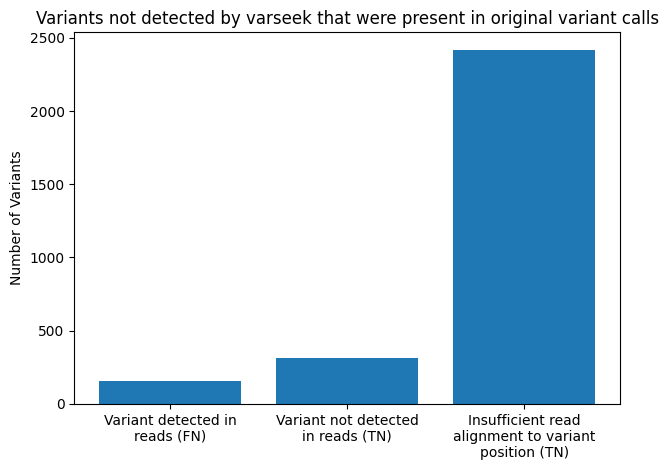

In [33]:
overall_results = {
    "Variant detected in reads (FN)": len(true_variants),
    "Variant not detected in reads (TN)": len(false_variants),
    "Insufficient read alignment to variant position (TN)": len(undetermined_variants),
}

plot_overall_bar_plot(overall_results, wrap_width=20, out_file=os.path.join(figures_out_dir, "fn_bar_plot.pdf"), title = 'Variants not detected by varseek that were present in original variant calls')

## Analyze a FN

In [34]:
# detailed_txt_out_fn = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/detailed_out_fn_NOT_modified_bam.txt"
# vcrs_fasta = "/data/vk_ref_out_geuvadis/w37_k41/vcrs_filtered.fa"

variants_in_vcrs_reference = []
variants_not_in_vcrs_reference = []

with open(vcrs_fasta) as f:
    vcrs_reference_contents = f.read()

# loop through detailed_txt_out_fn and check if the variant was in the vcrs_fasta
with open(detailed_txt_out_fn) as f:
    lines = f.readlines()

for i in tqdm(range(len(lines))):
    if i + 1 < len(lines) and "True variant: True" not in lines[i + 1]:
        continue  # I only want to analyze True variants that varseek missed
    line = lines[i]
    if not line.startswith("vcrs"):
        continue
    parts = line.strip().split("|")
    if len(parts) < 3:
        continue
    mutation_str = parts[2].strip()  # e.g., ENST00000338591:c.716G>C
    if mutation_str in vcrs_reference_contents:
        variants_in_vcrs_reference.append(mutation_str)
    else:
        variants_not_in_vcrs_reference.append(mutation_str)

print(f"Variants in vcrs_reference: {len(variants_in_vcrs_reference)}")
print(f"Variants not in vcrs_reference: {len(variants_not_in_vcrs_reference)}")

  0%|                                                                                                                           | 0/46152 [00:00<?, ?it/s]

 20%|█████████████████████▎                                                                                       | 9041/46152 [00:00<00:00, 89813.30it/s]

 39%|██████████████████████████████████████████▏                                                                 | 18023/46152 [00:00<00:01, 21587.14it/s]

 49%|████████████████████████████████████████████████████▊                                                       | 22549/46152 [00:00<00:00, 24870.94it/s]

 65%|██████████████████████████████████████████████████████████████████████▏                                     | 29999/46152 [00:00<00:00, 34251.58it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████                         | 35503/46152 [00:01<00:00, 17266.75it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 39313/46152 [00:01<00:00, 16263.36it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 42291/46152 [00:02<00:00, 17549.66it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45124/46152 [00:02<00:00, 18974.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46152/46152 [00:02<00:00, 20112.43it/s]

Variants in vcrs_reference: 306
Variants not in vcrs_reference: 0


In [35]:
variants_in_vcrs_reference[:20]

['ENST00000497986:c.262A>G',
 'ENST00000497986:c.262A>G',
 'ENST00000359858:c.367G>A',
 'ENST00000359858:c.367G>A',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.795T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000340450:c.801T>G',
 'ENST00000372476:c.3052A>G',
 'ENST00000372476:c.3052A>G',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.96G>A',
 'ENST00000370139:c.97C>T',
 'ENST00000370139:c.97C>T',
 'ENST00000309851:c.79G>A',
 'ENST00000309851:c.79G>A',
 'ENST00000256593:c.594T>C',
 'ENST00000256593:c.594T>C',
 'ENST00000585156:c.6692C>G',
 'ENST00000585156:c.6692C>G']

In [36]:
# look into detailed_txt_out_fn and pick a True variant that had reads align to ALT and is in the vcrs reference
# eg vcrs_104 | rs2502992 | ENST00000374472:c.351A>G | (-) strand | 1:g.24201919T>C 
# variant_bam_sorted_modified = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/final_total_sorted_reads_modified.bam"  #* uncomment if running only this bottom portion
# hgvsc = "ENST00000374472:c.351A>G"
# chrom = "1"
# pos = "24201919"
variant_bam_sorted = os.path.join(notebook_out_dir, "final_total_sorted_reads.bam") if not modify_bam else os.path.join(notebook_out_dir, "final_total_sorted_reads_modified.bam")
hgvsc = variants_in_vcrs_reference[0]
print(hgvsc)

result = None
with open(detailed_txt_out_fn) as f:
    for line in f:
        if hgvsc in line:
            result = line.strip().split(" | ")
            break  # stop at the first match

hgvsg = result[4]
chrom = hgvsg.split(":")[0]
match = re.search(r'g\.(\d+)', hgvsg)
pos = match.group(1) if match else None

# output_sam = f"/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/reads_at_{chrom}_{pos}.sam"
output_sam = os.path.join(notebook_out_dir, f"reads_at_{chrom}_{pos}.sam")
!samtools view {variant_bam_sorted} {chrom}:{pos}-{pos} > {output_sam}

ENST00000497986:c.262A>G


In [37]:
# revcomp_dict = {"A": "T", "T": "A", "C": "G", "G": "C", "N": "N"}
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)
print(seq_rc[:38])
print(seq_rc[37:])

AGAGCAGGCTGAAGAGGAACGATATTTCCGACATTACGGGTTATGCTTTGAGATCTCTTTGGGGTGAAGGATTGA
TCAATCCTTCACCCCAAAGAGATCTCAAAGCATAACCCGTAATGTCGGAAATATCGTTCCTCTTCAGCCTGCTCT
TCAATCCTTCACCCCAAAGAGATCTCAAAGCATAACCC
CGTAATGTCGGAAATATCGTTCCTCTTCAGCCTGCTCT


(double click on this cell for it to make sense)
Applies to ENST00000374472:c.351A>G aka 1:g.24201919T>C 

In this case, the issue was due to multiple variants - all reads had the variant toward the left end of the read, and there is another variant to the right that blocks a perfect k-mer match (also, keep in mind that read length is 75 for this dataset and w=37/k=41, so the reads are relatively small)

Eg typical read:
TTCCGGCGGAGCCGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGTTCTCCAGGGCACTTAGCAGGCCCAGA  # read
TTCCGGCGGAGCTGGTGGGAGGACAGGATCAGATAGAGCACAGCCACGT  # vcrs fragment aligned to read
           *
            ^

* mutation site for VCRS
^ unrelated mutation that blocks k-mer match

## Now let's look into a FP

In [38]:
# eg vcrs_100 | rs1131095 | ENST00000296456:c.1252T>C | (+) strand | 3:g.49714225T>C | 68.0 reported counts
# hgvsc = "ENST00000296456:c.1252T>C"
results = []

with open(detailed_txt_out) as f:
    lines = f.readlines()

for i in range(len(lines) - 1):
    line1 = lines[i].strip()
    line2 = lines[i + 1].strip()

    # Check that line1 has a reported count > min_counts
    try:
        count_str = line1.split(" | ")[-1].split()[0]  # e.g., '68.0' from '68.0 reported counts'
        reported_count = float(count_str)
    except (IndexError, ValueError):
        continue  # skip malformed lines

    # Check that the next line doesn't say "True variant: True"
    if reported_count > min_counts and line2 != "True variant: True":
        results.append(line1)

result_single = results[0]  # look at the first one
result_single = result_single.split(" | ")

hgvsc = result_single[2]
print(hgvsc)
output = !grep -A 1 "{hgvsc}" {vcrs_fasta}
seq = output[1].strip()
seq_rc = "".join([revcomp_dict.get(base, base) for base in seq[::-1]])

print(seq)
print(seq_rc)

ENST00000260379:c.299G>C


AAAGCAGCCGGTGTAAATGTTGAGCCTTTTTGGCCTGCCTTGTTTGCAAAGGCCCTGGCCAACGTCAACATTGGG
CCCAATGTTGACGTTGGCCAGGGCCTTTGCAAACAAGGCAGGCCAAAAAGGCTCAACATTTACACCGGCTGCTTT


### Manually check if any read has a k-mer that matches the VCRS

In [39]:
# import pyfastx
# fastq_file = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/fastqs_combined/fastqs_combined.fastq.gz"  #* uncomment if running only this bottom portion
# fastq_indexed = pyfastx.Fastq(fastq_file, build_index=True)  #* uncomment if running only this bottom portion

k = 41  # from vk ref settings
kmer_set = set()

# Add k-mers from seq and seq_rc
for s in [seq, seq_rc]:
    for i in range(len(s) - k + 1):
        kmer_set.add(s[i:i+k])

# Store reads that contain any of those k-mers
matching_reads = {}

fq_read_only = pyfastx.Fastx(fastq_file)

for name, read_seq, _ in tqdm((fq_read_only), total=len(fastq_indexed)):
    found = any(read_seq[i:i+k] in kmer_set for i in range(len(read_seq) - k + 1))
    if found:
        matching_reads[name] = read_seq

  0%|                                                                                                                        | 0/46292322 [00:00<?, ?it/s]

  0%|                                                                                                          | 4276/46292322 [00:00<18:02, 42752.60it/s]

  0%|                                                                                                          | 8590/46292322 [00:00<17:56, 42976.93it/s]

  0%|                                                                                                         | 12916/46292322 [00:00<17:53, 43101.74it/s]

  0%|                                                                                                         | 17227/46292322 [00:00<17:53, 43087.66it/s]

  0%|                                                                                                         | 22890/46292322 [00:00<16:04, 47968.05it/s]

  0%|                                                                                                         | 29439/46292322 [00:00<14:17, 53921.07it/s]

  0%|                                                                                                         | 36562/46292322 [00:00<12:56, 59575.42it/s]

  0%|                                                                                                         | 43136/46292322 [00:00<12:31, 61536.16it/s]

  0%|                                                                                                         | 50292/46292322 [00:00<11:55, 64666.57it/s]

  0%|▏                                                                                                        | 57437/46292322 [00:01<11:34, 66553.72it/s]

  0%|▏                                                                                                        | 65779/46292322 [00:01<10:44, 71701.75it/s]

  0%|▏                                                                                                        | 73607/46292322 [00:01<10:27, 73697.22it/s]

  0%|▏                                                                                                        | 81441/46292322 [00:01<10:15, 75100.60it/s]

  0%|▏                                                                                                        | 89618/46292322 [00:01<09:59, 77106.00it/s]

  0%|▏                                                                                                        | 97330/46292322 [00:01<10:00, 76881.42it/s]

  0%|▏                                                                                                       | 105171/46292322 [00:01<09:58, 77233.41it/s]

  0%|▎                                                                                                       | 113567/46292322 [00:01<09:42, 79247.54it/s]

  0%|▎                                                                                                       | 121493/46292322 [00:01<09:45, 78891.07it/s]

  0%|▎                                                                                                       | 129383/46292322 [00:01<09:46, 78687.80it/s]

  0%|▎                                                                                                       | 137623/46292322 [00:02<09:38, 79794.63it/s]

  0%|▎                                                                                                       | 145604/46292322 [00:02<09:42, 79278.78it/s]

  0%|▎                                                                                                       | 153534/46292322 [00:02<09:44, 78910.60it/s]

  0%|▎                                                                                                       | 161866/46292322 [00:02<09:35, 80221.03it/s]

  0%|▍                                                                                                       | 169890/46292322 [00:02<09:38, 79680.00it/s]

  0%|▍                                                                                                       | 177860/46292322 [00:02<09:43, 79010.69it/s]

  0%|▍                                                                                                       | 185993/46292322 [00:02<09:44, 78845.29it/s]

  0%|▍                                                                                                       | 194278/46292322 [00:02<09:36, 80024.60it/s]

  0%|▍                                                                                                       | 202284/46292322 [00:02<09:40, 79355.32it/s]

  0%|▍                                                                                                       | 210223/46292322 [00:02<09:42, 79052.39it/s]

  0%|▍                                                                                                       | 218499/46292322 [00:03<09:34, 80148.79it/s]

  0%|▌                                                                                                       | 226517/46292322 [00:03<09:38, 79590.88it/s]

  1%|▌                                                                                                       | 234479/46292322 [00:03<09:41, 79258.80it/s]

  1%|▌                                                                                                       | 242801/46292322 [00:03<09:32, 80430.78it/s]

  1%|▌                                                                                                       | 250847/46292322 [00:03<09:36, 79832.27it/s]

  1%|▌                                                                                                       | 258833/46292322 [00:03<09:41, 79173.17it/s]

  1%|▌                                                                                                       | 266753/46292322 [00:03<09:43, 78944.02it/s]

  1%|▌                                                                                                       | 275112/46292322 [00:03<09:32, 80320.20it/s]

  1%|▋                                                                                                       | 283147/46292322 [00:03<09:36, 79741.88it/s]

  1%|▋                                                                                                       | 291124/46292322 [00:03<09:40, 79235.07it/s]

  1%|▋                                                                                                       | 299442/46292322 [00:04<09:32, 80402.14it/s]

  1%|▋                                                                                                       | 307485/46292322 [00:04<09:35, 79868.96it/s]

  1%|▋                                                                                                       | 315475/46292322 [00:04<09:38, 79456.50it/s]

  1%|▋                                                                                                       | 323423/46292322 [00:04<09:40, 79203.68it/s]

  1%|▋                                                                                                       | 331772/46292322 [00:04<09:31, 80473.16it/s]

  1%|▊                                                                                                       | 339822/46292322 [00:04<09:38, 79480.22it/s]

  1%|▊                                                                                                       | 347774/46292322 [00:04<09:40, 79157.86it/s]

  1%|▊                                                                                                       | 356143/46292322 [00:04<09:30, 80498.49it/s]

  1%|▊                                                                                                       | 364197/46292322 [00:04<09:34, 79937.14it/s]

  1%|▊                                                                                                       | 372194/46292322 [00:04<09:39, 79252.38it/s]

  1%|▊                                                                                                       | 380122/46292322 [00:05<09:41, 79003.81it/s]

  1%|▊                                                                                                       | 388515/46292322 [00:05<09:30, 80460.76it/s]

  1%|▉                                                                                                       | 396564/46292322 [00:05<09:35, 79782.03it/s]

  1%|▉                                                                                                       | 404546/46292322 [00:05<09:38, 79370.31it/s]

  1%|▉                                                                                                       | 412655/46292322 [00:05<09:34, 79873.97it/s]

  1%|▉                                                                                                       | 420645/46292322 [00:05<09:38, 79335.22it/s]

  1%|▉                                                                                                       | 428581/46292322 [00:05<09:40, 78981.54it/s]

  1%|▉                                                                                                       | 436947/46292322 [00:05<09:30, 80368.71it/s]

  1%|▉                                                                                                       | 444987/46292322 [00:05<09:35, 79721.54it/s]

  1%|█                                                                                                       | 452962/46292322 [00:05<09:39, 79123.52it/s]

  1%|█                                                                                                       | 460884/46292322 [00:06<09:41, 78854.35it/s]

  1%|█                                                                                                       | 469242/46292322 [00:06<09:30, 80253.42it/s]

  1%|█                                                                                                       | 477270/46292322 [00:06<09:34, 79765.44it/s]

  1%|█                                                                                                       | 485249/46292322 [00:06<09:37, 79253.16it/s]

  1%|█                                                                                                       | 493514/46292322 [00:06<09:30, 80257.11it/s]

  1%|█▏                                                                                                      | 501543/46292322 [00:06<09:34, 79717.93it/s]

  1%|█▏                                                                                                      | 509517/46292322 [00:06<09:36, 79368.67it/s]

  1%|█▏                                                                                                      | 517843/46292322 [00:06<09:28, 80520.73it/s]

  1%|█▏                                                                                                      | 525898/46292322 [00:06<09:33, 79770.64it/s]

  1%|█▏                                                                                                      | 533878/46292322 [00:06<09:39, 79017.06it/s]

  1%|█▏                                                                                                      | 541783/46292322 [00:07<09:40, 78858.97it/s]

  1%|█▏                                                                                                      | 550127/46292322 [00:07<09:30, 80214.43it/s]

  1%|█▎                                                                                                      | 558152/46292322 [00:07<09:33, 79736.38it/s]

  1%|█▎                                                                                                      | 566128/46292322 [00:07<09:35, 79506.84it/s]

  1%|█▎                                                                                                      | 574395/46292322 [00:07<09:28, 80445.01it/s]

  1%|█▎                                                                                                      | 582442/46292322 [00:07<09:32, 79783.64it/s]

  1%|█▎                                                                                                      | 590423/46292322 [00:07<09:35, 79360.24it/s]

  1%|█▎                                                                                                      | 598752/46292322 [00:07<09:37, 79172.14it/s]

  1%|█▎                                                                                                      | 607126/46292322 [00:07<09:27, 80513.71it/s]

  1%|█▍                                                                                                      | 615182/46292322 [00:08<09:33, 79674.38it/s]

  1%|█▍                                                                                                      | 623154/46292322 [00:08<09:36, 79212.99it/s]

  1%|█▍                                                                                                      | 631476/46292322 [00:08<09:27, 80392.51it/s]

  1%|█▍                                                                                                      | 639519/46292322 [00:08<09:31, 79861.37it/s]

  1%|█▍                                                                                                      | 647508/46292322 [00:08<09:35, 79333.46it/s]

  1%|█▍                                                                                                      | 655588/46292322 [00:08<09:38, 78836.43it/s]

  1%|█▍                                                                                                      | 663969/46292322 [00:08<09:28, 80299.36it/s]

  1%|█▌                                                                                                      | 672004/46292322 [00:08<09:32, 79650.26it/s]

  1%|█▌                                                                                                      | 679973/46292322 [00:08<09:35, 79296.61it/s]

  1%|█▌                                                                                                      | 688353/46292322 [00:08<09:25, 80626.66it/s]

  2%|█▌                                                                                                      | 696420/46292322 [00:09<09:31, 79767.21it/s]

  2%|█▌                                                                                                      | 704401/46292322 [00:09<09:34, 79398.92it/s]

  2%|█▌                                                                                                      | 712379/46292322 [00:09<09:37, 78985.87it/s]

  2%|█▌                                                                                                      | 720732/46292322 [00:09<09:27, 80327.25it/s]

  2%|█▋                                                                                                      | 728768/46292322 [00:09<09:31, 79757.07it/s]

  2%|█▋                                                                                                      | 736747/46292322 [00:09<09:35, 79139.34it/s]

  2%|█▋                                                                                                      | 745119/46292322 [00:09<09:25, 80491.29it/s]

  2%|█▋                                                                                                      | 753172/46292322 [00:09<09:29, 79912.66it/s]

  2%|█▋                                                                                                      | 761167/46292322 [00:09<09:34, 79302.76it/s]

  2%|█▋                                                                                                      | 769170/46292322 [00:09<09:35, 79126.13it/s]

  2%|█▋                                                                                                      | 777412/46292322 [00:10<09:28, 80098.98it/s]

  2%|█▊                                                                                                      | 785425/46292322 [00:10<09:31, 79660.86it/s]

  2%|█▊                                                                                                      | 793393/46292322 [00:10<09:33, 79323.63it/s]

  2%|█▊                                                                                                      | 801763/46292322 [00:10<09:24, 80617.43it/s]

  2%|█▊                                                                                                      | 809827/46292322 [00:10<09:28, 80030.63it/s]

  2%|█▊                                                                                                      | 817833/46292322 [00:10<09:32, 79482.00it/s]

  2%|█▊                                                                                                      | 825962/46292322 [00:10<09:33, 79223.84it/s]

  2%|█▊                                                                                                      | 834321/46292322 [00:10<09:24, 80510.85it/s]

  2%|█▉                                                                                                      | 842376/46292322 [00:10<09:28, 79979.28it/s]

  2%|█▉                                                                                                      | 850377/46292322 [00:10<09:33, 79216.48it/s]

  2%|█▉                                                                                                      | 858771/46292322 [00:11<09:23, 80609.68it/s]

  2%|█▉                                                                                                      | 866836/46292322 [00:11<09:28, 79951.09it/s]

  2%|█▉                                                                                                      | 874835/46292322 [00:11<09:31, 79503.89it/s]

  2%|█▉                                                                                                      | 883091/46292322 [00:11<09:32, 79259.20it/s]

  2%|██                                                                                                      | 891357/46292322 [00:11<09:25, 80257.49it/s]

  2%|██                                                                                                      | 899387/46292322 [00:11<09:30, 79633.49it/s]

  2%|██                                                                                                      | 907354/46292322 [00:11<09:33, 79191.78it/s]

  2%|██                                                                                                      | 915766/46292322 [00:11<09:22, 80646.49it/s]

  2%|██                                                                                                      | 923835/46292322 [00:11<09:27, 80014.46it/s]

  2%|██                                                                                                      | 931840/46292322 [00:11<09:31, 79346.59it/s]

  2%|██                                                                                                      | 940141/46292322 [00:12<09:33, 79035.28it/s]

  2%|██▏                                                                                                     | 948448/46292322 [00:12<09:25, 80216.94it/s]

  2%|██▏                                                                                                     | 956475/46292322 [00:12<09:31, 79314.69it/s]

  2%|██▏                                                                                                     | 964411/46292322 [00:12<09:33, 78991.19it/s]

  2%|██▏                                                                                                     | 972669/46292322 [00:12<09:26, 80047.08it/s]

  2%|██▏                                                                                                     | 980678/46292322 [00:12<09:29, 79604.55it/s]

  2%|██▏                                                                                                     | 988642/46292322 [00:12<09:31, 79212.37it/s]

  2%|██▏                                                                                                     | 996996/46292322 [00:12<09:22, 80493.56it/s]

  2%|██▏                                                                                                    | 1005049/46292322 [00:12<09:26, 79984.49it/s]

  2%|██▎                                                                                                    | 1013050/46292322 [00:12<09:32, 79137.91it/s]

  2%|██▎                                                                                                    | 1020967/46292322 [00:13<09:32, 79054.39it/s]

  2%|██▎                                                                                                    | 1029320/46292322 [00:13<09:23, 80378.77it/s]

  2%|██▎                                                                                                    | 1037361/46292322 [00:13<09:27, 79770.98it/s]

  2%|██▎                                                                                                    | 1045341/46292322 [00:13<09:30, 79302.91it/s]

  2%|██▎                                                                                                    | 1053574/46292322 [00:13<09:24, 80196.91it/s]

  2%|██▎                                                                                                    | 1061597/46292322 [00:13<09:32, 79002.41it/s]

  2%|██▍                                                                                                    | 1069503/46292322 [00:13<11:36, 64965.92it/s]

  2%|██▍                                                                                                    | 1077515/46292322 [00:13<11:01, 68381.30it/s]

  2%|██▍                                                                                                    | 1085723/46292322 [00:13<10:27, 72043.64it/s]

  2%|██▍                                                                                                    | 1093529/46292322 [00:14<10:13, 73703.84it/s]

  2%|██▍                                                                                                    | 1101108/46292322 [00:14<13:44, 54833.98it/s]

  2%|██▍                                                                                                    | 1107422/46292322 [00:14<14:30, 51926.03it/s]

  2%|██▍                                                                                                    | 1113192/46292322 [00:14<14:32, 51791.31it/s]

  2%|██▍                                                                                                    | 1118773/46292322 [00:14<14:33, 51734.00it/s]

  2%|██▌                                                                                                    | 1124227/46292322 [00:14<14:34, 51664.64it/s]

  2%|██▌                                                                                                    | 1129589/46292322 [00:14<14:57, 50313.17it/s]

  2%|██▌                                                                                                    | 1135802/46292322 [00:14<14:04, 53456.44it/s]

  2%|██▌                                                                                                    | 1143571/46292322 [00:15<12:30, 60130.31it/s]

  2%|██▌                                                                                                    | 1151914/46292322 [00:15<11:16, 66707.25it/s]

  3%|██▌                                                                                                    | 1159693/46292322 [00:15<10:45, 69891.53it/s]

  3%|██▌                                                                                                    | 1167449/46292322 [00:15<10:25, 72122.77it/s]

  3%|██▌                                                                                                    | 1175693/46292322 [00:15<10:00, 75149.85it/s]

  3%|██▋                                                                                                    | 1183507/46292322 [00:15<09:53, 76030.20it/s]

  3%|██▋                                                                                                    | 1191295/46292322 [00:15<09:48, 76576.98it/s]

  3%|██▋                                                                                                    | 1199636/46292322 [00:15<09:33, 78609.99it/s]

  3%|██▋                                                                                                    | 1207524/46292322 [00:15<09:34, 78471.83it/s]

  3%|██▋                                                                                                    | 1215390/46292322 [00:15<09:37, 78074.18it/s]

  3%|██▋                                                                                                    | 1223569/46292322 [00:16<09:36, 78201.80it/s]

  3%|██▋                                                                                                    | 1231911/46292322 [00:16<09:25, 79742.70it/s]

  3%|██▊                                                                                                    | 1239894/46292322 [00:16<09:27, 79353.64it/s]

  3%|██▊                                                                                                    | 1247836/46292322 [00:16<09:29, 79095.19it/s]

  3%|██▊                                                                                                    | 1256090/46292322 [00:16<09:22, 80114.75it/s]

  3%|██▊                                                                                                    | 1264106/46292322 [00:16<09:25, 79578.82it/s]

  3%|██▊                                                                                                    | 1272068/46292322 [00:16<09:28, 79245.04it/s]

  3%|██▊                                                                                                    | 1280151/46292322 [00:16<09:29, 78992.46it/s]

  3%|██▊                                                                                                    | 1288479/46292322 [00:16<09:20, 80258.74it/s]

  3%|██▉                                                                                                    | 1296508/46292322 [00:17<09:26, 79471.14it/s]

  3%|██▉                                                                                                    | 1304459/46292322 [00:17<09:28, 79092.90it/s]

  3%|██▉                                                                                                    | 1312812/46292322 [00:17<09:19, 80404.77it/s]

  3%|██▉                                                                                                    | 1320856/46292322 [00:17<09:23, 79797.61it/s]

  3%|██▉                                                                                                    | 1328839/46292322 [00:17<09:26, 79332.77it/s]

  3%|██▉                                                                                                    | 1337006/46292322 [00:17<09:30, 78852.72it/s]

  3%|██▉                                                                                                    | 1345369/46292322 [00:17<09:20, 80256.61it/s]

  3%|███                                                                                                    | 1353400/46292322 [00:17<09:25, 79430.23it/s]

  3%|███                                                                                                    | 1361348/46292322 [00:17<09:28, 78985.87it/s]

  3%|███                                                                                                    | 1369702/46292322 [00:17<09:19, 80328.01it/s]

  3%|███                                                                                                    | 1377739/46292322 [00:18<09:24, 79629.15it/s]

  3%|███                                                                                                    | 1385706/46292322 [00:18<09:26, 79224.23it/s]

  3%|███                                                                                                    | 1393797/46292322 [00:18<09:28, 78978.14it/s]

  3%|███                                                                                                    | 1402145/46292322 [00:18<09:18, 80305.91it/s]

  3%|███▏                                                                                                   | 1410180/46292322 [00:18<09:24, 79488.73it/s]

  3%|███▏                                                                                                   | 1418133/46292322 [00:18<09:28, 78867.49it/s]

  3%|███▏                                                                                                   | 1426484/46292322 [00:18<09:19, 80236.35it/s]

  3%|███▏                                                                                                   | 1434512/46292322 [00:18<09:22, 79731.09it/s]

  3%|███▏                                                                                                   | 1442489/46292322 [00:18<09:25, 79312.25it/s]

  3%|███▏                                                                                                   | 1450590/46292322 [00:18<09:27, 78992.02it/s]

  3%|███▏                                                                                                   | 1458844/46292322 [00:19<09:20, 80036.16it/s]

  3%|███▎                                                                                                   | 1466851/46292322 [00:19<09:23, 79512.00it/s]

  3%|███▎                                                                                                   | 1474805/46292322 [00:19<09:26, 79086.77it/s]

  3%|███▎                                                                                                   | 1483158/46292322 [00:19<09:17, 80400.17it/s]

  3%|███▎                                                                                                   | 1491201/46292322 [00:19<09:23, 79568.30it/s]

  3%|███▎                                                                                                   | 1499162/46292322 [00:19<09:24, 79342.86it/s]

  3%|███▎                                                                                                   | 1507372/46292322 [00:19<09:26, 79111.05it/s]

  3%|███▎                                                                                                   | 1515749/46292322 [00:19<09:16, 80480.76it/s]

  3%|███▍                                                                                                   | 1523801/46292322 [00:19<09:20, 79891.89it/s]

  3%|███▍                                                                                                   | 1531794/46292322 [00:19<09:24, 79337.06it/s]

  3%|███▍                                                                                                   | 1540157/46292322 [00:20<09:15, 80604.18it/s]

  3%|███▍                                                                                                   | 1548221/46292322 [00:20<09:19, 80018.33it/s]

  3%|███▍                                                                                                   | 1556226/46292322 [00:20<09:22, 79512.02it/s]

  3%|███▍                                                                                                   | 1564180/46292322 [00:20<09:25, 79123.21it/s]

  3%|███▍                                                                                                   | 1572250/46292322 [00:20<09:21, 79586.01it/s]

  3%|███▌                                                                                                   | 1580211/46292322 [00:20<09:24, 79143.88it/s]

  3%|███▌                                                                                                   | 1588127/46292322 [00:20<09:26, 78907.82it/s]

  3%|███▌                                                                                                   | 1596408/46292322 [00:20<09:18, 80065.98it/s]

  3%|███▌                                                                                                   | 1604417/46292322 [00:20<09:22, 79503.55it/s]

  3%|███▌                                                                                                   | 1612370/46292322 [00:20<09:26, 78850.97it/s]

  4%|███▌                                                                                                   | 1620446/46292322 [00:21<09:27, 78725.04it/s]

  4%|███▌                                                                                                   | 1628768/46292322 [00:21<09:17, 80051.22it/s]

  4%|███▋                                                                                                   | 1636777/46292322 [00:21<09:21, 79510.09it/s]

  4%|███▋                                                                                                   | 1644731/46292322 [00:21<09:24, 79047.10it/s]

  4%|███▋                                                                                                   | 1652993/46292322 [00:21<09:17, 80101.87it/s]

  4%|███▋                                                                                                   | 1661006/46292322 [00:21<09:20, 79558.43it/s]

  4%|███▋                                                                                                   | 1668965/46292322 [00:21<09:23, 79142.83it/s]

  4%|███▋                                                                                                   | 1676984/46292322 [00:21<09:25, 78959.83it/s]

  4%|███▋                                                                                                   | 1685335/46292322 [00:21<09:15, 80303.51it/s]

  4%|███▊                                                                                                   | 1693368/46292322 [00:21<09:21, 79405.20it/s]

  4%|███▊                                                                                                   | 1701312/46292322 [00:22<09:23, 79094.46it/s]

  4%|███▊                                                                                                   | 1709636/46292322 [00:22<09:15, 80320.54it/s]

  4%|███▊                                                                                                   | 1717672/46292322 [00:22<09:17, 79902.62it/s]

  4%|███▊                                                                                                   | 1725665/46292322 [00:22<09:19, 79587.97it/s]

  4%|███▊                                                                                                   | 1733626/46292322 [00:22<09:24, 78950.74it/s]

  4%|███▉                                                                                                   | 1741975/46292322 [00:22<09:14, 80293.45it/s]

  4%|███▉                                                                                                   | 1750008/46292322 [00:22<09:18, 79722.32it/s]

  4%|███▉                                                                                                   | 1757983/46292322 [00:22<09:21, 79324.46it/s]

  4%|███▉                                                                                                   | 1766305/46292322 [00:22<09:13, 80477.63it/s]

  4%|███▉                                                                                                   | 1774356/46292322 [00:23<09:18, 79733.11it/s]

  4%|███▉                                                                                                   | 1782333/46292322 [00:23<09:22, 79182.78it/s]

  4%|███▉                                                                                                   | 1790343/46292322 [00:23<09:24, 78831.16it/s]

  4%|████                                                                                                   | 1798689/46292322 [00:23<09:14, 80196.69it/s]

  4%|████                                                                                                   | 1806712/46292322 [00:23<09:18, 79650.17it/s]

  4%|████                                                                                                   | 1814680/46292322 [00:23<09:22, 79074.23it/s]

  4%|████                                                                                                   | 1822994/46292322 [00:23<09:13, 80274.92it/s]

  4%|████                                                                                                   | 1831025/46292322 [00:23<09:18, 79663.63it/s]

  4%|████                                                                                                   | 1838995/46292322 [00:23<09:21, 79239.43it/s]

  4%|████                                                                                                   | 1847136/46292322 [00:23<09:22, 79034.94it/s]

  4%|████▏                                                                                                  | 1855405/46292322 [00:24<09:14, 80111.39it/s]

  4%|████▏                                                                                                  | 1863420/46292322 [00:24<09:18, 79606.16it/s]

  4%|████▏                                                                                                  | 1871383/46292322 [00:24<09:20, 79184.15it/s]

  4%|████▏                                                                                                  | 1879684/46292322 [00:24<09:12, 80315.11it/s]

  4%|████▏                                                                                                  | 1887719/46292322 [00:24<09:17, 79660.40it/s]

  4%|████▏                                                                                                  | 1895688/46292322 [00:24<09:22, 78995.89it/s]

  4%|████▏                                                                                                  | 1903928/46292322 [00:24<09:23, 78791.93it/s]

  4%|████▎                                                                                                  | 1912263/46292322 [00:24<09:13, 80128.00it/s]

  4%|████▎                                                                                                  | 1920280/46292322 [00:24<09:17, 79603.10it/s]

  4%|████▎                                                                                                  | 1928244/46292322 [00:24<09:20, 79093.58it/s]

  4%|████▎                                                                                                  | 1936503/46292322 [00:25<09:13, 80123.25it/s]

  4%|████▎                                                                                                  | 1944519/46292322 [00:25<09:17, 79588.03it/s]

  4%|████▎                                                                                                  | 1952481/46292322 [00:25<09:20, 79176.63it/s]

  4%|████▎                                                                                                  | 1960720/46292322 [00:25<09:21, 78984.36it/s]

  4%|████▍                                                                                                  | 1968957/46292322 [00:25<09:14, 79979.60it/s]

  4%|████▍                                                                                                  | 1976958/46292322 [00:25<09:17, 79422.45it/s]

  4%|████▍                                                                                                  | 1984903/46292322 [00:25<09:20, 79064.00it/s]

  4%|████▍                                                                                                  | 1993259/46292322 [00:25<09:11, 80392.68it/s]

  4%|████▍                                                                                                  | 2001302/46292322 [00:25<09:16, 79649.01it/s]

  4%|████▍                                                                                                  | 2009270/46292322 [00:25<09:20, 78971.25it/s]

  4%|████▍                                                                                                  | 2017391/46292322 [00:26<09:22, 78675.30it/s]

  4%|████▌                                                                                                  | 2025709/46292322 [00:26<09:13, 79998.29it/s]

  4%|████▌                                                                                                  | 2033713/46292322 [00:26<09:16, 79484.07it/s]

  4%|████▌                                                                                                  | 2041665/46292322 [00:26<09:19, 79119.44it/s]

  4%|████▌                                                                                                  | 2049924/46292322 [00:26<09:12, 80143.64it/s]

  4%|████▌                                                                                                  | 2057942/46292322 [00:26<09:16, 79500.86it/s]

  4%|████▌                                                                                                  | 2065895/46292322 [00:26<09:19, 79017.96it/s]

  4%|████▌                                                                                                  | 2073927/46292322 [00:26<09:19, 78982.26it/s]

  4%|████▋                                                                                                  | 2082248/46292322 [00:26<09:11, 80231.64it/s]

  5%|████▋                                                                                                  | 2090274/46292322 [00:26<09:16, 79364.26it/s]

  5%|████▋                                                                                                  | 2098214/46292322 [00:27<09:19, 79010.91it/s]

  5%|████▋                                                                                                  | 2106552/46292322 [00:27<09:10, 80303.09it/s]

  5%|████▋                                                                                                  | 2114586/46292322 [00:27<09:15, 79547.65it/s]

  5%|████▋                                                                                                  | 2122544/46292322 [00:27<09:17, 79206.13it/s]

  5%|████▋                                                                                                  | 2130467/46292322 [00:27<09:21, 78664.87it/s]

  5%|████▊                                                                                                  | 2138782/46292322 [00:27<09:11, 79989.27it/s]

  5%|████▊                                                                                                  | 2146784/46292322 [00:27<09:14, 79571.90it/s]

  5%|████▊                                                                                                  | 2154744/46292322 [00:27<09:16, 79251.04it/s]

  5%|████▊                                                                                                  | 2163058/46292322 [00:27<09:08, 80404.45it/s]

  5%|████▊                                                                                                  | 2171101/46292322 [00:28<09:15, 79493.73it/s]

  5%|████▊                                                                                                  | 2179054/46292322 [00:28<09:16, 79222.90it/s]

  5%|████▊                                                                                                  | 2187002/46292322 [00:28<09:18, 78934.99it/s]

  5%|████▉                                                                                                  | 2195351/46292322 [00:28<09:09, 80283.32it/s]

  5%|████▉                                                                                                  | 2203382/46292322 [00:28<09:14, 79511.05it/s]

  5%|████▉                                                                                                  | 2211337/46292322 [00:28<09:19, 78766.71it/s]

  5%|████▉                                                                                                  | 2219679/46292322 [00:28<09:09, 80139.75it/s]

  5%|████▉                                                                                                  | 2227698/46292322 [00:28<09:12, 79715.55it/s]

  5%|████▉                                                                                                  | 2235673/46292322 [00:28<09:15, 79278.68it/s]

  5%|████▉                                                                                                  | 2243604/46292322 [00:28<09:17, 78945.42it/s]

  5%|█████                                                                                                  | 2251890/46292322 [00:29<09:09, 80104.00it/s]

  5%|█████                                                                                                  | 2259903/46292322 [00:29<09:13, 79560.47it/s]

  5%|█████                                                                                                  | 2267862/46292322 [00:29<09:16, 79154.68it/s]

  5%|█████                                                                                                  | 2276178/46292322 [00:29<09:07, 80338.57it/s]

  5%|█████                                                                                                  | 2284215/46292322 [00:29<09:11, 79743.12it/s]

  5%|█████                                                                                                  | 2292192/46292322 [00:29<09:16, 79004.08it/s]

  5%|█████                                                                                                  | 2300426/46292322 [00:29<09:19, 78687.67it/s]

  5%|█████▏                                                                                                 | 2308782/46292322 [00:29<09:09, 80115.54it/s]

  5%|█████▏                                                                                                 | 2316799/46292322 [00:29<09:12, 79633.07it/s]

  5%|█████▏                                                                                                 | 2324766/46292322 [00:29<09:15, 79094.45it/s]

  5%|█████▏                                                                                                 | 2333023/46292322 [00:30<09:08, 80119.34it/s]

  5%|█████▏                                                                                                 | 2341039/46292322 [00:30<09:12, 79586.44it/s]

  5%|█████▏                                                                                                 | 2349001/46292322 [00:30<09:15, 79150.48it/s]

  5%|█████▏                                                                                                 | 2357169/46292322 [00:30<09:09, 79897.23it/s]

  5%|█████▎                                                                                                 | 2365161/46292322 [00:30<09:14, 79199.44it/s]

  5%|█████▎                                                                                                 | 2373084/46292322 [00:30<09:18, 78611.50it/s]

  5%|█████▎                                                                                                 | 2380948/46292322 [00:30<09:20, 78402.86it/s]

  5%|█████▎                                                                                                 | 2389274/46292322 [00:30<09:09, 79839.82it/s]

  5%|█████▎                                                                                                 | 2397261/46292322 [00:30<09:14, 79128.41it/s]

  5%|█████▎                                                                                                 | 2405177/46292322 [00:30<09:19, 78505.26it/s]

  5%|█████▎                                                                                                 | 2413509/46292322 [00:31<09:08, 79926.42it/s]

  5%|█████▍                                                                                                 | 2421506/46292322 [00:31<09:15, 78988.92it/s]

  5%|█████▍                                                                                                 | 2429410/46292322 [00:31<09:18, 78552.40it/s]

  5%|█████▍                                                                                                 | 2437676/46292322 [00:31<09:19, 78418.90it/s]

  5%|█████▍                                                                                                 | 2445920/46292322 [00:31<09:10, 79597.11it/s]

  5%|█████▍                                                                                                 | 2453885/46292322 [00:31<09:15, 78986.89it/s]

  5%|█████▍                                                                                                 | 2461787/46292322 [00:31<09:16, 78744.86it/s]

  5%|█████▍                                                                                                 | 2470039/46292322 [00:31<09:08, 79858.51it/s]

  5%|█████▌                                                                                                 | 2478028/46292322 [00:31<09:12, 79258.73it/s]

  5%|█████▌                                                                                                 | 2485957/46292322 [00:31<09:20, 78210.40it/s]

  5%|█████▌                                                                                                 | 2494332/46292322 [00:32<09:08, 79839.28it/s]

  5%|█████▌                                                                                                 | 2502322/46292322 [00:32<09:12, 79310.89it/s]

  5%|█████▌                                                                                                 | 2510258/46292322 [00:32<09:14, 79028.11it/s]

  5%|█████▌                                                                                                 | 2518164/46292322 [00:32<09:17, 78477.73it/s]

  5%|█████▌                                                                                                 | 2526306/46292322 [00:32<09:11, 79345.37it/s]

  5%|█████▋                                                                                                 | 2534244/46292322 [00:32<09:15, 78739.57it/s]

  5%|█████▋                                                                                                 | 2542121/46292322 [00:32<09:17, 78517.26it/s]

  6%|█████▋                                                                                                 | 2550448/46292322 [00:32<09:07, 79926.69it/s]

  6%|█████▋                                                                                                 | 2558444/46292322 [00:32<09:13, 79038.99it/s]

  6%|█████▋                                                                                                 | 2566352/46292322 [00:32<09:16, 78557.78it/s]

  6%|█████▋                                                                                                 | 2574585/46292322 [00:33<09:16, 78627.67it/s]

  6%|█████▋                                                                                                 | 2582843/46292322 [00:33<09:07, 79788.48it/s]

  6%|█████▊                                                                                                 | 2590826/46292322 [00:33<09:11, 79225.72it/s]

  6%|█████▊                                                                                                 | 2598752/46292322 [00:33<09:13, 78917.73it/s]

  6%|█████▊                                                                                                 | 2606993/46292322 [00:33<09:06, 79948.02it/s]

  6%|█████▊                                                                                                 | 2614991/46292322 [00:33<09:11, 79138.17it/s]

  6%|█████▊                                                                                                 | 2622908/46292322 [00:33<09:14, 78806.04it/s]

  6%|█████▊                                                                                                 | 2631121/46292322 [00:33<09:16, 78449.48it/s]

  6%|█████▊                                                                                                 | 2639410/46292322 [00:33<09:07, 79752.54it/s]

  6%|█████▉                                                                                                 | 2647390/46292322 [00:34<09:12, 79017.06it/s]

  6%|█████▉                                                                                                 | 2655296/46292322 [00:34<09:12, 78917.69it/s]

  6%|█████▉                                                                                                 | 2663501/46292322 [00:34<09:06, 79843.32it/s]

  6%|█████▉                                                                                                 | 2671489/46292322 [00:34<09:09, 79341.24it/s]

  6%|█████▉                                                                                                 | 2679426/46292322 [00:34<09:14, 78695.95it/s]

  6%|█████▉                                                                                                 | 2687658/46292322 [00:34<09:16, 78319.31it/s]

  6%|█████▉                                                                                                 | 2696034/46292322 [00:34<09:05, 79913.52it/s]

  6%|██████                                                                                                 | 2704031/46292322 [00:34<09:09, 79379.02it/s]

  6%|██████                                                                                                 | 2711973/46292322 [00:34<09:13, 78739.83it/s]

  6%|██████                                                                                                 | 2720215/46292322 [00:34<09:05, 79821.64it/s]

  6%|██████                                                                                                 | 2728202/46292322 [00:35<09:11, 78985.17it/s]

  6%|██████                                                                                                 | 2736105/46292322 [00:35<09:13, 78686.35it/s]

  6%|██████                                                                                                 | 2744195/46292322 [00:35<09:13, 78655.04it/s]

  6%|██████                                                                                                 | 2752419/46292322 [00:35<09:06, 79712.25it/s]

  6%|██████▏                                                                                                | 2760394/46292322 [00:35<09:08, 79311.60it/s]

  6%|██████▏                                                                                                | 2768328/46292322 [00:35<09:13, 78650.62it/s]

  6%|██████▏                                                                                                | 2776690/46292322 [00:35<09:03, 80117.00it/s]

  6%|██████▏                                                                                                | 2784706/46292322 [00:35<09:06, 79571.81it/s]

  6%|██████▏                                                                                                | 2792666/46292322 [00:35<09:09, 79198.12it/s]

  6%|██████▏                                                                                                | 2800929/46292322 [00:35<09:02, 80209.35it/s]

  6%|██████▏                                                                                                | 2808953/46292322 [00:36<09:07, 79399.53it/s]

  6%|██████▎                                                                                                | 2816896/46292322 [00:36<09:10, 78995.19it/s]

  6%|██████▎                                                                                                | 2824798/46292322 [00:36<09:12, 78716.67it/s]

  6%|██████▎                                                                                                | 2833148/46292322 [00:36<09:02, 80132.89it/s]

  6%|██████▎                                                                                                | 2841164/46292322 [00:36<09:09, 79054.82it/s]

  6%|██████▎                                                                                                | 2849074/46292322 [00:36<09:13, 78498.37it/s]

  6%|██████▎                                                                                                | 2857415/46292322 [00:36<09:03, 79947.54it/s]

  6%|██████▍                                                                                                | 2865415/46292322 [00:36<09:07, 79338.39it/s]

  6%|██████▍                                                                                                | 2873353/46292322 [00:36<09:11, 78710.91it/s]

  6%|██████▍                                                                                                | 2881435/46292322 [00:36<09:14, 78300.67it/s]

  6%|██████▍                                                                                                | 2889654/46292322 [00:37<09:06, 79443.19it/s]

  6%|██████▍                                                                                                | 2897603/46292322 [00:37<09:09, 78984.44it/s]

  6%|██████▍                                                                                                | 2905505/46292322 [00:37<09:11, 78629.71it/s]

  6%|██████▍                                                                                                | 2913828/46292322 [00:37<09:02, 79988.55it/s]

  6%|██████▌                                                                                                | 2921830/46292322 [00:37<09:14, 78231.08it/s]

  6%|██████▌                                                                                                | 2929663/46292322 [00:37<09:16, 77879.40it/s]

  6%|██████▌                                                                                                | 2937958/46292322 [00:37<09:06, 79369.35it/s]

  6%|██████▌                                                                                                | 2945903/46292322 [00:37<09:08, 78999.84it/s]

  6%|██████▌                                                                                                | 2953808/46292322 [00:37<09:10, 78661.40it/s]

  6%|██████▌                                                                                                | 2961891/46292322 [00:37<09:15, 77950.71it/s]

  6%|██████▌                                                                                                | 2970207/46292322 [00:38<09:05, 79477.88it/s]

  6%|██████▋                                                                                                | 2978161/46292322 [00:38<09:09, 78832.25it/s]

  6%|██████▋                                                                                                | 2986049/46292322 [00:38<09:12, 78365.19it/s]

  6%|██████▋                                                                                                | 2994423/46292322 [00:38<09:01, 79949.13it/s]

  6%|██████▋                                                                                                | 3002423/46292322 [00:38<09:07, 79003.60it/s]

  7%|██████▋                                                                                                | 3010329/46292322 [00:38<09:12, 78338.30it/s]

  7%|██████▋                                                                                                | 3018666/46292322 [00:38<09:02, 79818.54it/s]

  7%|██████▋                                                                                                | 3026654/46292322 [00:38<09:06, 79119.25it/s]

  7%|██████▊                                                                                                | 3034571/46292322 [00:38<09:10, 78553.15it/s]

  7%|██████▊                                                                                                | 3042430/46292322 [00:39<09:13, 78167.06it/s]

  7%|██████▊                                                                                                | 3050782/46292322 [00:39<09:02, 79747.59it/s]

  7%|██████▊                                                                                                | 3058761/46292322 [00:39<09:07, 78996.41it/s]

  7%|██████▊                                                                                                | 3066665/46292322 [00:39<09:09, 78672.88it/s]

  7%|██████▊                                                                                                | 3074845/46292322 [00:39<09:02, 79595.47it/s]

  7%|██████▊                                                                                                | 3082808/46292322 [00:39<09:07, 78865.81it/s]

  7%|██████▉                                                                                                | 3090698/46292322 [00:39<09:09, 78580.16it/s]

  7%|██████▉                                                                                                | 3098850/46292322 [00:39<09:10, 78458.82it/s]

  7%|██████▉                                                                                                | 3107082/46292322 [00:39<09:02, 79594.61it/s]

  7%|██████▉                                                                                                | 3115045/46292322 [00:39<09:07, 78826.69it/s]

  7%|██████▉                                                                                                | 3122931/46292322 [00:40<09:12, 78068.78it/s]

  7%|██████▉                                                                                                | 3131283/46292322 [00:40<09:01, 79672.22it/s]

  7%|██████▉                                                                                                | 3139255/46292322 [00:40<09:04, 79197.14it/s]

  7%|███████                                                                                                | 3147179/46292322 [00:40<09:09, 78520.90it/s]

  7%|███████                                                                                                | 3155387/46292322 [00:40<09:09, 78478.45it/s]

  7%|███████                                                                                                | 3163495/46292322 [00:40<09:04, 79239.56it/s]

  7%|███████                                                                                                | 3171422/46292322 [00:40<09:06, 78845.30it/s]

  7%|███████                                                                                                | 3179309/46292322 [00:40<09:08, 78559.70it/s]

  7%|███████                                                                                                | 3187612/46292322 [00:40<08:59, 79882.32it/s]

  7%|███████                                                                                                | 3195603/46292322 [00:40<09:06, 78920.75it/s]

  7%|███████▏                                                                                               | 3203499/46292322 [00:41<09:11, 78059.60it/s]

  7%|███████▏                                                                                               | 3211777/46292322 [00:41<09:02, 79448.31it/s]

  7%|███████▏                                                                                               | 3219727/46292322 [00:41<09:05, 79029.53it/s]

  7%|███████▏                                                                                               | 3227634/46292322 [00:41<09:07, 78657.27it/s]

  7%|███████▏                                                                                               | 3235503/46292322 [00:41<09:13, 77817.79it/s]

  7%|███████▏                                                                                               | 3243851/46292322 [00:41<09:01, 79486.02it/s]

  7%|███████▏                                                                                               | 3251805/46292322 [00:41<09:06, 78745.13it/s]

  7%|███████▎                                                                                               | 3259684/46292322 [00:41<09:09, 78311.92it/s]

  7%|███████▎                                                                                               | 3268035/46292322 [00:41<08:58, 79847.10it/s]

  7%|███████▎                                                                                               | 3276024/46292322 [00:41<09:04, 78998.27it/s]

  7%|███████▎                                                                                               | 3283929/46292322 [00:42<09:09, 78260.06it/s]

  7%|███████▎                                                                                               | 3292015/46292322 [00:42<09:09, 78200.41it/s]

  7%|███████▎                                                                                               | 3300333/46292322 [00:42<08:59, 79662.67it/s]

  7%|███████▎                                                                                               | 3308304/46292322 [00:42<09:03, 79139.37it/s]

  7%|███████▍                                                                                               | 3316222/46292322 [00:42<09:09, 78247.43it/s]

  7%|███████▍                                                                                               | 3324557/46292322 [00:42<08:58, 79748.13it/s]

  7%|███████▍                                                                                               | 3332537/46292322 [00:42<09:04, 78920.50it/s]

  7%|███████▍                                                                                               | 3340434/46292322 [00:42<09:06, 78616.68it/s]

  7%|███████▍                                                                                               | 3348669/46292322 [00:42<08:58, 79717.97it/s]

  7%|███████▍                                                                                               | 3356645/46292322 [00:42<09:04, 78796.11it/s]

  7%|███████▍                                                                                               | 3364529/46292322 [00:43<09:06, 78556.24it/s]

  7%|███████▌                                                                                               | 3372468/46292322 [00:43<09:07, 78332.42it/s]

  7%|███████▌                                                                                               | 3380692/46292322 [00:43<08:59, 79487.75it/s]

  7%|███████▌                                                                                               | 3388644/46292322 [00:43<09:03, 78968.30it/s]

  7%|███████▌                                                                                               | 3396544/46292322 [00:43<09:07, 78372.95it/s]

  7%|███████▌                                                                                               | 3404863/46292322 [00:43<08:57, 79796.00it/s]

  7%|███████▌                                                                                               | 3412846/46292322 [00:43<09:02, 79031.96it/s]

  7%|███████▌                                                                                               | 3420753/46292322 [00:43<09:04, 78758.66it/s]

  7%|███████▋                                                                                               | 3428989/46292322 [00:43<08:56, 79822.59it/s]

  7%|███████▋                                                                                               | 3436975/46292322 [00:44<09:03, 78882.89it/s]

  7%|███████▋                                                                                               | 3444868/46292322 [00:44<09:06, 78402.85it/s]

  7%|███████▋                                                                                               | 3452924/46292322 [00:44<09:07, 78285.72it/s]

  7%|███████▋                                                                                               | 3461247/46292322 [00:44<08:57, 79741.48it/s]

  7%|███████▋                                                                                               | 3469225/46292322 [00:44<09:03, 78847.04it/s]

  8%|███████▋                                                                                               | 3477114/46292322 [00:44<09:07, 78211.78it/s]

  8%|███████▊                                                                                               | 3485394/46292322 [00:44<08:58, 79563.09it/s]

  8%|███████▊                                                                                               | 3493355/46292322 [00:44<09:02, 78915.95it/s]

  8%|███████▊                                                                                               | 3501251/46292322 [00:44<09:04, 78576.93it/s]

  8%|███████▊                                                                                               | 3509455/46292322 [00:44<08:57, 79599.23it/s]

  8%|███████▊                                                                                               | 3517418/46292322 [00:45<09:05, 78450.14it/s]

  8%|███████▊                                                                                               | 3525268/46292322 [00:45<09:07, 78156.28it/s]

  8%|███████▊                                                                                               | 3533380/46292322 [00:45<09:10, 77705.90it/s]

  8%|███████▉                                                                                               | 3541600/46292322 [00:45<09:01, 79021.11it/s]

  8%|███████▉                                                                                               | 3549508/46292322 [00:45<09:03, 78615.14it/s]

  8%|███████▉                                                                                               | 3557374/46292322 [00:45<09:07, 78091.02it/s]

  8%|███████▉                                                                                               | 3565540/46292322 [00:45<08:59, 79143.46it/s]

  8%|███████▉                                                                                               | 3573458/46292322 [00:45<09:03, 78585.41it/s]

  8%|███████▉                                                                                               | 3581320/46292322 [00:45<09:05, 78344.55it/s]

  8%|███████▉                                                                                               | 3589591/46292322 [00:45<08:56, 79637.85it/s]

  8%|████████                                                                                               | 3597558/46292322 [00:46<09:03, 78597.17it/s]

  8%|████████                                                                                               | 3605422/46292322 [00:46<09:06, 78126.20it/s]

  8%|████████                                                                                               | 3613595/46292322 [00:46<09:08, 77873.21it/s]

  8%|████████                                                                                               | 3621877/46292322 [00:46<08:57, 79321.05it/s]

  8%|████████                                                                                               | 3629815/46292322 [00:46<09:05, 78205.44it/s]

  8%|████████                                                                                               | 3637642/46292322 [00:46<09:08, 77794.12it/s]

  8%|████████                                                                                               | 3645653/46292322 [00:46<09:03, 78474.01it/s]

  8%|████████▏                                                                                              | 3653505/46292322 [00:46<09:13, 77060.66it/s]

  8%|████████▏                                                                                              | 3661218/46292322 [00:46<09:14, 76922.65it/s]

  8%|████████▏                                                                                              | 3669332/46292322 [00:46<09:05, 78163.64it/s]

  8%|████████▏                                                                                              | 3677154/46292322 [00:47<09:06, 77979.65it/s]

  8%|████████▏                                                                                              | 3684956/46292322 [00:47<09:07, 77892.77it/s]

  8%|████████▏                                                                                              | 3693245/46292322 [00:47<08:56, 79378.67it/s]

  8%|████████▏                                                                                              | 3701186/46292322 [00:47<09:02, 78569.99it/s]

  8%|████████▎                                                                                              | 3709047/46292322 [00:47<09:05, 78070.85it/s]

  8%|████████▎                                                                                              | 3717248/46292322 [00:47<09:07, 77717.21it/s]

  8%|████████▎                                                                                              | 3725496/46292322 [00:47<08:58, 79111.72it/s]

  8%|████████▎                                                                                              | 3733413/46292322 [00:47<09:00, 78712.42it/s]

  8%|████████▎                                                                                              | 3741288/46292322 [00:47<09:03, 78281.03it/s]

  8%|████████▎                                                                                              | 3749418/46292322 [00:47<08:57, 79171.18it/s]

  8%|████████▎                                                                                              | 3757339/46292322 [00:48<09:00, 78629.53it/s]

  8%|████████▍                                                                                              | 3765205/46292322 [00:48<09:03, 78283.45it/s]

  8%|████████▍                                                                                              | 3773561/46292322 [00:48<08:52, 79844.92it/s]

  8%|████████▍                                                                                              | 3781549/46292322 [00:48<08:58, 78933.19it/s]

  8%|████████▍                                                                                              | 3789447/46292322 [00:48<09:04, 78060.05it/s]

  8%|████████▍                                                                                              | 3797354/46292322 [00:48<09:06, 77812.42it/s]

  8%|████████▍                                                                                              | 3805637/46292322 [00:48<08:55, 79288.73it/s]

  8%|████████▍                                                                                              | 3813571/46292322 [00:48<09:00, 78614.37it/s]

  8%|████████▌                                                                                              | 3821437/46292322 [00:48<09:02, 78324.86it/s]

  8%|████████▌                                                                                              | 3829698/46292322 [00:49<08:53, 79592.33it/s]

  8%|████████▌                                                                                              | 3837661/46292322 [00:49<08:55, 79345.09it/s]

  8%|████████▌                                                                                              | 3845598/46292322 [00:49<09:00, 78568.18it/s]

  8%|████████▌                                                                                              | 3853959/46292322 [00:49<08:50, 80058.22it/s]

  8%|████████▌                                                                                              | 3861969/46292322 [00:49<08:54, 79446.97it/s]

  8%|████████▌                                                                                              | 3869917/46292322 [00:49<08:57, 78864.18it/s]

  8%|████████▋                                                                                              | 3877819/46292322 [00:49<09:00, 78535.50it/s]

  8%|████████▋                                                                                              | 3886148/46292322 [00:49<08:50, 79941.54it/s]

  8%|████████▋                                                                                              | 3894146/46292322 [00:49<08:53, 79456.55it/s]

  8%|████████▋                                                                                              | 3902095/46292322 [00:49<08:55, 79224.60it/s]

  8%|████████▋                                                                                              | 3910370/46292322 [00:50<08:47, 80270.59it/s]

  8%|████████▋                                                                                              | 3918400/46292322 [00:50<08:51, 79753.70it/s]

  8%|████████▋                                                                                              | 3926378/46292322 [00:50<08:54, 79326.09it/s]

  8%|████████▊                                                                                              | 3934609/46292322 [00:50<08:56, 79013.50it/s]

  9%|████████▊                                                                                              | 3942934/46292322 [00:50<08:47, 80259.17it/s]

  9%|████████▊                                                                                              | 3950964/46292322 [00:50<08:52, 79581.37it/s]

  9%|████████▊                                                                                              | 3958926/46292322 [00:50<08:54, 79213.18it/s]

  9%|████████▊                                                                                              | 3967277/46292322 [00:50<08:45, 80482.80it/s]

  9%|████████▊                                                                                              | 3975329/46292322 [00:50<08:52, 79510.68it/s]

  9%|████████▊                                                                                              | 3983285/46292322 [00:50<08:54, 79125.48it/s]

  9%|████████▉                                                                                              | 3991386/46292322 [00:51<08:50, 79680.76it/s]

  9%|████████▉                                                                                              | 3999357/46292322 [00:51<08:51, 79518.02it/s]

  9%|████████▉                                                                                              | 4007311/46292322 [00:51<08:53, 79217.19it/s]

  9%|████████▉                                                                                              | 4015234/46292322 [00:51<08:55, 78923.99it/s]

  9%|████████▉                                                                                              | 4023403/46292322 [00:51<08:50, 79744.59it/s]

  9%|████████▉                                                                                              | 4031379/46292322 [00:51<08:55, 78966.64it/s]

  9%|████████▉                                                                                              | 4039278/46292322 [00:51<08:58, 78448.39it/s]

  9%|█████████                                                                                              | 4047619/46292322 [00:51<08:48, 79915.58it/s]

  9%|█████████                                                                                              | 4055614/46292322 [00:51<08:52, 79335.54it/s]

  9%|█████████                                                                                              | 4063551/46292322 [00:51<08:56, 78705.30it/s]

  9%|█████████                                                                                              | 4071570/46292322 [00:52<08:57, 78508.68it/s]

  9%|█████████                                                                                              | 4079818/46292322 [00:52<08:49, 79678.55it/s]

  9%|█████████                                                                                              | 4087789/46292322 [00:52<08:53, 79162.87it/s]

  9%|█████████                                                                                              | 4095708/46292322 [00:52<08:55, 78815.85it/s]

  9%|█████████▏                                                                                             | 4103988/46292322 [00:52<08:47, 79994.94it/s]

  9%|█████████▏                                                                                             | 4111990/46292322 [00:52<08:51, 79323.45it/s]

  9%|█████████▏                                                                                             | 4119925/46292322 [00:52<08:55, 78735.30it/s]

  9%|█████████▏                                                                                             | 4128104/46292322 [00:52<08:57, 78500.21it/s]

  9%|█████████▏                                                                                             | 4136414/46292322 [00:52<08:47, 79850.63it/s]

  9%|█████████▏                                                                                             | 4144404/46292322 [00:52<08:52, 79085.98it/s]

  9%|█████████▏                                                                                             | 4152317/46292322 [00:53<08:55, 78672.34it/s]

  9%|█████████▎                                                                                             | 4160697/46292322 [00:53<08:45, 80183.46it/s]

  9%|█████████▎                                                                                             | 4168720/46292322 [00:53<08:52, 79161.03it/s]

  9%|█████████▎                                                                                             | 4176641/46292322 [00:53<08:56, 78550.85it/s]

  9%|█████████▎                                                                                             | 4184640/46292322 [00:53<08:59, 78112.45it/s]

  9%|█████████▎                                                                                             | 4193071/46292322 [00:53<08:46, 79930.93it/s]

  9%|█████████▎                                                                                             | 4201070/46292322 [00:53<08:49, 79542.81it/s]

  9%|█████████▎                                                                                             | 4209029/46292322 [00:53<08:53, 78876.52it/s]

  9%|█████████▍                                                                                             | 4217352/46292322 [00:53<08:44, 80159.00it/s]

  9%|█████████▍                                                                                             | 4225373/46292322 [00:53<08:52, 79069.28it/s]

  9%|█████████▍                                                                                             | 4233286/46292322 [00:54<08:53, 78790.95it/s]

  9%|█████████▍                                                                                             | 4241372/46292322 [00:54<08:54, 78617.48it/s]

  9%|█████████▍                                                                                             | 4249690/46292322 [00:54<08:45, 79959.66it/s]

  9%|█████████▍                                                                                             | 4257691/46292322 [00:54<08:52, 78947.79it/s]

  9%|█████████▍                                                                                             | 4265591/46292322 [00:54<08:56, 78369.64it/s]

  9%|█████████▌                                                                                             | 4273760/46292322 [00:54<08:49, 79344.08it/s]

  9%|█████████▌                                                                                             | 4281699/46292322 [00:54<08:52, 78829.21it/s]

  9%|█████████▌                                                                                             | 4289585/46292322 [00:54<08:53, 78798.59it/s]

  9%|█████████▌                                                                                             | 4297869/46292322 [00:54<08:44, 79993.39it/s]

  9%|█████████▌                                                                                             | 4305871/46292322 [00:55<08:51, 78971.48it/s]

  9%|█████████▌                                                                                             | 4313773/46292322 [00:55<09:03, 77284.47it/s]

  9%|█████████▌                                                                                             | 4321511/46292322 [00:55<10:54, 64144.17it/s]

  9%|█████████▋                                                                                             | 4328292/46292322 [00:55<12:27, 56105.87it/s]

  9%|█████████▋                                                                                             | 4334293/46292322 [00:55<12:58, 53902.16it/s]

  9%|█████████▋                                                                                             | 4339943/46292322 [00:55<13:24, 52171.17it/s]

  9%|█████████▋                                                                                             | 4345328/46292322 [00:55<13:44, 50895.23it/s]

  9%|█████████▋                                                                                             | 4350524/46292322 [00:55<14:23, 48577.48it/s]

  9%|█████████▋                                                                                             | 4357719/46292322 [00:56<12:47, 54626.74it/s]

  9%|█████████▋                                                                                             | 4364993/46292322 [00:56<11:44, 59514.40it/s]

  9%|█████████▋                                                                                             | 4372875/46292322 [00:56<10:46, 64885.08it/s]

  9%|█████████▋                                                                                             | 4380224/46292322 [00:56<10:22, 67330.43it/s]

  9%|█████████▊                                                                                             | 4388054/46292322 [00:56<09:54, 70497.89it/s]

  9%|█████████▊                                                                                             | 4395630/46292322 [00:56<09:41, 72032.01it/s]

 10%|█████████▊                                                                                             | 4403200/46292322 [00:56<09:32, 73109.96it/s]

 10%|█████████▊                                                                                             | 4411156/46292322 [00:56<09:18, 75017.76it/s]

 10%|█████████▊                                                                                             | 4418697/46292322 [00:56<09:21, 74596.13it/s]

 10%|█████████▊                                                                                             | 4426184/46292322 [00:56<10:40, 65319.45it/s]

 10%|█████████▊                                                                                             | 4432940/46292322 [00:57<12:14, 57020.96it/s]

 10%|█████████▉                                                                                             | 4438954/46292322 [00:57<13:16, 52521.57it/s]

 10%|█████████▉                                                                                             | 4444451/46292322 [00:57<14:09, 49260.27it/s]

 10%|█████████▉                                                                                             | 4449847/46292322 [00:57<13:50, 50411.67it/s]

 10%|█████████▉                                                                                             | 4457187/46292322 [00:57<12:22, 56375.21it/s]

 10%|█████████▉                                                                                             | 4464011/46292322 [00:57<11:42, 59582.34it/s]

 10%|█████████▉                                                                                             | 4471448/46292322 [00:57<10:56, 63701.17it/s]

 10%|█████████▉                                                                                             | 4478287/46292322 [00:57<10:42, 65033.06it/s]

 10%|█████████▉                                                                                             | 4484989/46292322 [00:58<10:37, 65605.32it/s]

 10%|█████████▉                                                                                             | 4491631/46292322 [00:58<10:45, 64776.55it/s]

 10%|██████████                                                                                             | 4498167/46292322 [00:58<11:04, 62896.74it/s]

 10%|██████████                                                                                             | 4504506/46292322 [00:58<11:04, 62925.53it/s]

 10%|██████████                                                                                             | 4510833/46292322 [00:58<11:19, 61464.93it/s]

 10%|██████████                                                                                             | 4518807/46292322 [00:58<10:26, 66728.91it/s]

 10%|██████████                                                                                             | 4526524/46292322 [00:58<09:58, 69771.14it/s]

 10%|██████████                                                                                             | 4534285/46292322 [00:58<09:40, 71911.27it/s]

 10%|██████████                                                                                             | 4542598/46292322 [00:58<09:15, 75222.07it/s]

 10%|██████████                                                                                             | 4550253/46292322 [00:58<09:12, 75612.36it/s]

 10%|██████████▏                                                                                            | 4557880/46292322 [00:59<09:10, 75805.62it/s]

 10%|██████████▏                                                                                            | 4566210/46292322 [00:59<08:54, 78040.16it/s]

 10%|██████████▏                                                                                            | 4574025/46292322 [00:59<08:55, 77951.15it/s]

 10%|██████████▏                                                                                            | 4581828/46292322 [00:59<08:56, 77791.87it/s]

 10%|██████████▏                                                                                            | 4590116/46292322 [00:59<08:45, 79310.27it/s]

 10%|██████████▏                                                                                            | 4598052/46292322 [00:59<08:50, 78587.67it/s]

 10%|██████████▏                                                                                            | 4605916/46292322 [00:59<08:51, 78396.07it/s]

 10%|██████████▎                                                                                            | 4614288/46292322 [00:59<08:41, 79978.62it/s]

 10%|██████████▎                                                                                            | 4622290/46292322 [00:59<08:45, 79277.78it/s]

 10%|██████████▎                                                                                            | 4630222/46292322 [00:59<08:48, 78816.64it/s]

 10%|██████████▎                                                                                            | 4638107/46292322 [01:00<08:51, 78333.75it/s]

 10%|██████████▎                                                                                            | 4646422/46292322 [01:00<08:42, 79757.05it/s]

 10%|██████████▎                                                                                            | 4654401/46292322 [01:00<08:45, 79237.57it/s]

 10%|██████████▎                                                                                            | 4662328/46292322 [01:00<08:47, 78945.51it/s]

 10%|██████████▍                                                                                            | 4670550/46292322 [01:00<08:40, 79914.99it/s]

 10%|██████████▍                                                                                            | 4678544/46292322 [01:00<08:44, 79287.86it/s]

 10%|██████████▍                                                                                            | 4686476/46292322 [01:00<08:46, 78981.90it/s]

 10%|██████████▍                                                                                            | 4694791/46292322 [01:00<08:47, 78808.26it/s]

 10%|██████████▍                                                                                            | 4703103/46292322 [01:00<08:39, 80074.73it/s]

 10%|██████████▍                                                                                            | 4711115/46292322 [01:00<08:45, 79119.46it/s]

 10%|██████████▍                                                                                            | 4719031/46292322 [01:01<08:47, 78745.63it/s]

 10%|██████████▌                                                                                            | 4727300/46292322 [01:01<08:40, 79907.00it/s]

 10%|██████████▌                                                                                            | 4735295/46292322 [01:01<08:47, 78763.05it/s]

 10%|██████████▌                                                                                            | 4743177/46292322 [01:01<08:50, 78313.23it/s]

 10%|██████████▌                                                                                            | 4751275/46292322 [01:01<08:45, 79097.56it/s]

 10%|██████████▌                                                                                            | 4759189/46292322 [01:01<08:49, 78468.19it/s]

 10%|██████████▌                                                                                            | 4767039/46292322 [01:01<08:53, 77792.78it/s]

 10%|██████████▌                                                                                            | 4775189/46292322 [01:01<08:46, 78883.24it/s]

 10%|██████████▋                                                                                            | 4783081/46292322 [01:01<08:52, 77984.28it/s]

 10%|██████████▋                                                                                            | 4790884/46292322 [01:01<08:57, 77209.02it/s]

 10%|██████████▋                                                                                            | 4798907/46292322 [01:02<08:57, 77208.19it/s]

 10%|██████████▋                                                                                            | 4807196/46292322 [01:02<08:45, 78875.17it/s]

 10%|██████████▋                                                                                            | 4815089/46292322 [01:02<08:48, 78527.19it/s]

 10%|██████████▋                                                                                            | 4822946/46292322 [01:02<08:50, 78217.64it/s]

 10%|██████████▋                                                                                            | 4831113/46292322 [01:02<08:43, 79236.97it/s]

 10%|██████████▊                                                                                            | 4839040/46292322 [01:02<08:45, 78863.01it/s]

 10%|██████████▊                                                                                            | 4846929/46292322 [01:02<08:46, 78712.07it/s]

 10%|██████████▊                                                                                            | 4855285/46292322 [01:02<08:36, 80151.99it/s]

 11%|██████████▊                                                                                            | 4863303/46292322 [01:02<08:41, 79432.20it/s]

 11%|██████████▊                                                                                            | 4871249/46292322 [01:03<08:45, 78871.58it/s]

 11%|██████████▊                                                                                            | 4879269/46292322 [01:03<08:47, 78572.36it/s]

 11%|██████████▊                                                                                            | 4887565/46292322 [01:03<08:38, 79866.08it/s]

 11%|██████████▉                                                                                            | 4895555/46292322 [01:03<08:43, 79099.66it/s]

 11%|██████████▉                                                                                            | 4903469/46292322 [01:03<08:45, 78741.09it/s]

 11%|██████████▉                                                                                            | 4911677/46292322 [01:03<08:39, 79725.15it/s]

 11%|██████████▉                                                                                            | 4919653/46292322 [01:03<08:42, 79161.68it/s]

 11%|██████████▉                                                                                            | 4927572/46292322 [01:03<08:45, 78729.10it/s]

 11%|██████████▉                                                                                            | 4935805/46292322 [01:03<08:46, 78501.32it/s]

 11%|███████████                                                                                            | 4944131/46292322 [01:03<08:37, 79899.01it/s]

 11%|███████████                                                                                            | 4952125/46292322 [01:04<08:42, 79178.06it/s]

 11%|███████████                                                                                            | 4960047/46292322 [01:04<08:45, 78717.26it/s]

 11%|███████████                                                                                            | 4968342/46292322 [01:04<08:36, 79964.75it/s]

 11%|███████████                                                                                            | 4976343/46292322 [01:04<08:41, 79221.68it/s]

 11%|███████████                                                                                            | 4984269/46292322 [01:04<08:43, 78850.85it/s]

 11%|███████████                                                                                            | 4992339/46292322 [01:04<08:46, 78409.37it/s]

 11%|███████████▏                                                                                           | 5000647/46292322 [01:04<08:37, 79782.48it/s]

 11%|███████████▏                                                                                           | 5008630/46292322 [01:04<08:41, 79133.82it/s]

 11%|███████████▏                                                                                           | 5016547/46292322 [01:04<08:44, 78731.42it/s]

 11%|███████████▏                                                                                           | 5024852/46292322 [01:04<08:35, 80005.96it/s]

 11%|███████████▏                                                                                           | 5032856/46292322 [01:05<08:40, 79236.34it/s]

 11%|███████████▏                                                                                           | 5040783/46292322 [01:05<08:42, 78951.64it/s]

 11%|███████████▏                                                                                           | 5048874/46292322 [01:05<08:42, 78983.78it/s]

 11%|███████████▎                                                                                           | 5057234/46292322 [01:05<08:33, 80347.07it/s]

 11%|███████████▎                                                                                           | 5065272/46292322 [01:05<10:46, 63810.15it/s]

 11%|███████████▎                                                                                           | 5072187/46292322 [01:05<11:55, 57635.35it/s]

 11%|███████████▎                                                                                           | 5078394/46292322 [01:05<13:05, 52468.70it/s]

 11%|███████████▎                                                                                           | 5083987/46292322 [01:05<13:33, 50640.39it/s]

 11%|███████████▎                                                                                           | 5091291/46292322 [01:06<12:24, 55374.90it/s]

 11%|███████████▎                                                                                           | 5098713/46292322 [01:06<11:24, 60176.00it/s]

 11%|███████████▎                                                                                           | 5105578/46292322 [01:06<10:59, 62435.23it/s]

 11%|███████████▍                                                                                           | 5113040/46292322 [01:06<10:25, 65797.55it/s]

 11%|███████████▍                                                                                           | 5119997/46292322 [01:06<10:15, 66861.86it/s]

 11%|███████████▍                                                                                           | 5128226/46292322 [01:06<09:37, 71298.79it/s]

 11%|███████████▍                                                                                           | 5135812/46292322 [01:06<09:26, 72626.29it/s]

 11%|███████████▍                                                                                           | 5143475/46292322 [01:06<09:17, 73801.05it/s]

 11%|███████████▍                                                                                           | 5151675/46292322 [01:06<08:59, 76221.13it/s]

 11%|███████████▍                                                                                           | 5159342/46292322 [01:06<09:00, 76071.96it/s]

 11%|███████████▍                                                                                           | 5167157/46292322 [01:07<08:56, 76685.20it/s]

 11%|███████████▌                                                                                           | 5175393/46292322 [01:07<08:44, 78373.75it/s]

 11%|███████████▌                                                                                           | 5183248/46292322 [01:07<08:46, 78112.64it/s]

 11%|███████████▌                                                                                           | 5191072/46292322 [01:07<08:47, 77893.61it/s]

 11%|███████████▌                                                                                           | 5199218/46292322 [01:07<08:40, 78951.73it/s]

 11%|███████████▌                                                                                           | 5207120/46292322 [01:07<08:43, 78495.59it/s]

 11%|███████████▌                                                                                           | 5214975/46292322 [01:07<08:45, 78131.16it/s]

 11%|███████████▌                                                                                           | 5223204/46292322 [01:07<08:37, 79364.20it/s]

 11%|███████████▋                                                                                           | 5231145/46292322 [01:07<08:41, 78710.35it/s]

 11%|███████████▋                                                                                           | 5239020/46292322 [01:07<08:46, 78027.65it/s]

 11%|███████████▋                                                                                           | 5247281/46292322 [01:08<08:37, 79381.11it/s]

 11%|███████████▋                                                                                           | 5255224/46292322 [01:08<08:41, 78716.16it/s]

 11%|███████████▋                                                                                           | 5263100/46292322 [01:08<08:42, 78565.15it/s]

 11%|███████████▋                                                                                           | 5271204/46292322 [01:08<08:43, 78414.67it/s]

 11%|███████████▋                                                                                           | 5279356/46292322 [01:08<08:36, 79330.67it/s]

 11%|███████████▊                                                                                           | 5287292/46292322 [01:08<08:40, 78823.85it/s]

 11%|███████████▊                                                                                           | 5295177/46292322 [01:08<08:42, 78506.18it/s]

 11%|███████████▊                                                                                           | 5303455/46292322 [01:08<08:33, 79770.66it/s]

 11%|███████████▊                                                                                           | 5311435/46292322 [01:08<08:37, 79158.87it/s]

 11%|███████████▊                                                                                           | 5319354/46292322 [01:08<08:42, 78397.34it/s]

 12%|███████████▊                                                                                           | 5327604/46292322 [01:09<08:34, 79607.51it/s]

 12%|███████████▊                                                                                           | 5335569/46292322 [01:09<08:38, 79002.76it/s]

 12%|███████████▉                                                                                           | 5343473/46292322 [01:09<08:40, 78634.74it/s]

 12%|███████████▉                                                                                           | 5351517/46292322 [01:09<08:41, 78564.86it/s]

 12%|███████████▉                                                                                           | 5359738/46292322 [01:09<08:33, 79641.47it/s]

 12%|███████████▉                                                                                           | 5367705/46292322 [01:09<08:37, 79023.90it/s]

 12%|███████████▉                                                                                           | 5375610/46292322 [01:09<08:40, 78538.55it/s]

 12%|███████████▉                                                                                           | 5383877/46292322 [01:09<08:32, 79758.23it/s]

 12%|███████████▉                                                                                           | 5391856/46292322 [01:09<08:37, 79101.29it/s]

 12%|████████████                                                                                           | 5399769/46292322 [01:10<08:41, 78433.37it/s]

 12%|████████████                                                                                           | 5408053/46292322 [01:10<08:41, 78334.06it/s]

 12%|████████████                                                                                           | 5416278/46292322 [01:10<08:34, 79479.79it/s]

 12%|████████████                                                                                           | 5424230/46292322 [01:10<08:38, 78759.76it/s]

 12%|████████████                                                                                           | 5432110/46292322 [01:10<08:40, 78457.14it/s]

 12%|████████████                                                                                           | 5440294/46292322 [01:10<08:34, 79452.36it/s]

 12%|████████████                                                                                           | 5448243/46292322 [01:10<08:37, 78862.45it/s]

 12%|████████████▏                                                                                          | 5456132/46292322 [01:10<08:41, 78320.49it/s]

 12%|████████████▏                                                                                          | 5464405/46292322 [01:10<08:32, 79622.38it/s]

 12%|████████████▏                                                                                          | 5472371/46292322 [01:10<08:35, 79171.36it/s]

 12%|████████████▏                                                                                          | 5480291/46292322 [01:11<08:39, 78498.53it/s]

 12%|████████████▏                                                                                          | 5488144/46292322 [01:11<08:43, 77997.89it/s]

 12%|████████████▏                                                                                          | 5496334/46292322 [01:11<08:35, 79148.53it/s]

 12%|████████████▏                                                                                          | 5504252/46292322 [01:11<08:38, 78693.77it/s]

 12%|████████████▎                                                                                          | 5512124/46292322 [01:11<08:40, 78341.50it/s]

 12%|████████████▎                                                                                          | 5520385/46292322 [01:11<08:32, 79606.43it/s]

 12%|████████████▎                                                                                          | 5528349/46292322 [01:11<08:35, 79099.63it/s]

 12%|████████████▎                                                                                          | 5536262/46292322 [01:11<08:40, 78366.28it/s]

 12%|████████████▎                                                                                          | 5544473/46292322 [01:11<08:32, 79472.40it/s]

 12%|████████████▎                                                                                          | 5552424/46292322 [01:11<08:36, 78812.09it/s]

 12%|████████████▎                                                                                          | 5560309/46292322 [01:12<08:40, 78270.78it/s]

 12%|████████████▍                                                                                          | 5568290/46292322 [01:12<08:40, 78230.38it/s]

 12%|████████████▍                                                                                          | 5576617/46292322 [01:12<08:30, 79717.66it/s]

 12%|████████████▍                                                                                          | 5584592/46292322 [01:12<08:34, 79075.41it/s]

 12%|████████████▍                                                                                          | 5592503/46292322 [01:12<08:40, 78225.72it/s]

 12%|████████████▍                                                                                          | 5600329/46292322 [01:12<09:39, 70187.42it/s]

 12%|████████████▍                                                                                          | 5607498/46292322 [01:12<11:26, 59298.60it/s]

 12%|████████████▍                                                                                          | 5613786/46292322 [01:12<12:23, 54728.32it/s]

 12%|████████████▌                                                                                          | 5619532/46292322 [01:13<12:16, 55188.21it/s]

 12%|████████████▌                                                                                          | 5625658/46292322 [01:13<11:56, 56749.41it/s]

 12%|████████████▌                                                                                          | 5632394/46292322 [01:13<11:22, 59599.14it/s]

 12%|████████████▌                                                                                          | 5638840/46292322 [01:13<11:07, 60943.79it/s]

 12%|████████████▌                                                                                          | 5645051/46292322 [01:13<11:05, 61091.14it/s]

 12%|████████████▌                                                                                          | 5652352/46292322 [01:13<10:29, 64520.74it/s]

 12%|████████████▌                                                                                          | 5660067/46292322 [01:13<09:55, 68198.58it/s]

 12%|████████████▌                                                                                          | 5667817/46292322 [01:13<09:32, 70929.53it/s]

 12%|████████████▋                                                                                          | 5676143/46292322 [01:13<09:04, 74574.41it/s]

 12%|████████████▋                                                                                          | 5683894/46292322 [01:13<08:58, 75442.88it/s]

 12%|████████████▋                                                                                          | 5691467/46292322 [01:14<09:00, 75101.58it/s]

 12%|████████████▋                                                                                          | 5699735/46292322 [01:14<08:44, 77351.21it/s]

 12%|████████████▋                                                                                          | 5707487/46292322 [01:14<08:47, 76899.80it/s]

 12%|████████████▋                                                                                          | 5715189/46292322 [01:14<08:50, 76451.46it/s]

 12%|████████████▋                                                                                          | 5723485/46292322 [01:14<08:37, 78380.53it/s]

 12%|████████████▊                                                                                          | 5731331/46292322 [01:14<08:43, 77424.25it/s]

 12%|████████████▊                                                                                          | 5739082/46292322 [01:14<08:43, 77433.96it/s]

 12%|████████████▊                                                                                          | 5747241/46292322 [01:14<08:35, 78663.64it/s]

 12%|████████████▊                                                                                          | 5755113/46292322 [01:14<08:37, 78307.23it/s]

 12%|████████████▊                                                                                          | 5762948/46292322 [01:14<08:39, 78024.87it/s]

 12%|████████████▊                                                                                          | 5770982/46292322 [01:15<08:34, 78709.33it/s]

 12%|████████████▊                                                                                          | 5778856/46292322 [01:15<08:37, 78323.84it/s]

 13%|████████████▉                                                                                          | 5786691/46292322 [01:15<08:39, 78032.13it/s]

 13%|████████████▉                                                                                          | 5794761/46292322 [01:15<08:33, 78821.92it/s]

 13%|████████████▉                                                                                          | 5802645/46292322 [01:15<08:39, 77894.50it/s]

 13%|████████████▉                                                                                          | 5810438/46292322 [01:15<08:43, 77304.90it/s]

 13%|████████████▉                                                                                          | 5818752/46292322 [01:15<08:32, 79027.02it/s]

 13%|████████████▉                                                                                          | 5826659/46292322 [01:15<08:34, 78581.47it/s]

 13%|████████████▉                                                                                          | 5834521/46292322 [01:15<08:36, 78287.89it/s]

 13%|████████████▉                                                                                          | 5842666/46292322 [01:15<08:37, 78105.08it/s]

 13%|█████████████                                                                                          | 5850926/46292322 [01:16<08:29, 79426.72it/s]

 13%|█████████████                                                                                          | 5858873/46292322 [01:16<08:30, 79169.05it/s]

 13%|█████████████                                                                                          | 5866793/46292322 [01:16<08:33, 78696.07it/s]

 13%|█████████████                                                                                          | 5875108/46292322 [01:16<08:25, 80013.69it/s]

 13%|█████████████                                                                                          | 5883113/46292322 [01:16<08:28, 79414.85it/s]

 13%|█████████████                                                                                          | 5891058/46292322 [01:16<08:33, 78749.73it/s]

 13%|█████████████▏                                                                                         | 5899201/46292322 [01:16<08:34, 78526.25it/s]

 13%|█████████████▏                                                                                         | 5907493/46292322 [01:16<08:25, 79816.02it/s]

 13%|█████████████▏                                                                                         | 5915479/46292322 [01:16<08:29, 79247.82it/s]

 13%|█████████████▏                                                                                         | 5923407/46292322 [01:16<08:36, 78229.32it/s]

 13%|█████████████▏                                                                                         | 5931525/46292322 [01:17<08:30, 79094.06it/s]

 13%|█████████████▏                                                                                         | 5939439/46292322 [01:17<08:37, 78051.16it/s]

 13%|█████████████▏                                                                                         | 5947249/46292322 [01:17<08:36, 78044.31it/s]

 13%|█████████████▎                                                                                         | 5955334/46292322 [01:17<08:31, 78872.61it/s]

 13%|█████████████▎                                                                                         | 5963225/46292322 [01:17<08:36, 78149.18it/s]

 13%|█████████████▎                                                                                         | 5971044/46292322 [01:17<08:37, 77936.24it/s]

 13%|█████████████▎                                                                                         | 5979292/46292322 [01:17<08:36, 78070.60it/s]

 13%|█████████████▎                                                                                         | 5987631/46292322 [01:17<08:26, 79634.66it/s]

 13%|█████████████▎                                                                                         | 5995599/46292322 [01:17<08:30, 78949.94it/s]

 13%|█████████████▎                                                                                         | 6003498/46292322 [01:17<08:39, 77484.67it/s]

 13%|█████████████▍                                                                                         | 6011793/46292322 [01:18<08:29, 79082.55it/s]

 13%|█████████████▍                                                                                         | 6019710/46292322 [01:18<08:32, 78633.55it/s]

 13%|█████████████▍                                                                                         | 6027580/46292322 [01:18<08:34, 78334.69it/s]

 13%|█████████████▍                                                                                         | 6035826/46292322 [01:18<08:33, 78337.29it/s]

 13%|█████████████▍                                                                                         | 6043984/46292322 [01:18<08:27, 79286.79it/s]

 13%|█████████████▍                                                                                         | 6051917/46292322 [01:18<08:30, 78822.35it/s]

 13%|█████████████▍                                                                                         | 6059802/46292322 [01:18<08:38, 77626.98it/s]

 13%|█████████████▌                                                                                         | 6068038/46292322 [01:18<08:29, 79013.81it/s]

 13%|█████████████▌                                                                                         | 6075946/46292322 [01:18<08:30, 78801.26it/s]

 13%|█████████████▌                                                                                         | 6083831/46292322 [01:19<08:33, 78349.38it/s]

 13%|█████████████▌                                                                                         | 6092121/46292322 [01:19<08:24, 79694.83it/s]

 13%|█████████████▌                                                                                         | 6100095/46292322 [01:19<08:28, 79042.76it/s]

 13%|█████████████▌                                                                                         | 6108003/46292322 [01:19<08:30, 78704.87it/s]

 13%|█████████████▌                                                                                         | 6116273/46292322 [01:19<08:31, 78476.91it/s]

 13%|█████████████▋                                                                                         | 6124433/46292322 [01:19<08:25, 79391.65it/s]

 13%|█████████████▋                                                                                         | 6132376/46292322 [01:19<08:33, 78164.00it/s]

 13%|█████████████▋                                                                                         | 6140198/46292322 [01:19<08:35, 77835.72it/s]

 13%|█████████████▋                                                                                         | 6148225/46292322 [01:19<08:31, 78551.27it/s]

 13%|█████████████▋                                                                                         | 6156084/46292322 [01:19<08:32, 78325.52it/s]

 13%|█████████████▋                                                                                         | 6163919/46292322 [01:20<08:36, 77676.94it/s]

 13%|█████████████▋                                                                                         | 6172263/46292322 [01:20<08:25, 79380.36it/s]

 13%|█████████████▊                                                                                         | 6180205/46292322 [01:20<08:32, 78278.09it/s]

 13%|█████████████▊                                                                                         | 6188039/46292322 [01:20<08:34, 77954.31it/s]

 13%|█████████████▊                                                                                         | 6196382/46292322 [01:20<08:23, 79569.30it/s]

 13%|█████████████▊                                                                                         | 6204344/46292322 [01:20<08:28, 78854.00it/s]

 13%|█████████████▊                                                                                         | 6212234/46292322 [01:20<08:30, 78505.59it/s]

 13%|█████████████▊                                                                                         | 6220328/46292322 [01:20<08:25, 79223.73it/s]

 13%|█████████████▊                                                                                         | 6228254/46292322 [01:20<08:27, 78866.37it/s]

 13%|█████████████▉                                                                                         | 6236143/46292322 [01:20<08:30, 78468.57it/s]

 13%|█████████████▉                                                                                         | 6244052/46292322 [01:21<08:37, 77334.87it/s]

 14%|█████████████▉                                                                                         | 6252334/46292322 [01:21<08:27, 78947.03it/s]

 14%|█████████████▉                                                                                         | 6260235/46292322 [01:21<08:28, 78680.25it/s]

 14%|█████████████▉                                                                                         | 6268108/46292322 [01:21<08:30, 78437.47it/s]

 14%|█████████████▉                                                                                         | 6276177/46292322 [01:21<08:25, 79099.84it/s]

 14%|█████████████▉                                                                                         | 6284090/46292322 [01:21<08:30, 78425.97it/s]

 14%|█████████████▉                                                                                         | 6291936/46292322 [01:21<08:32, 78092.21it/s]

 14%|██████████████                                                                                         | 6300287/46292322 [01:21<08:21, 79696.57it/s]

 14%|██████████████                                                                                         | 6308260/46292322 [01:21<08:26, 78997.55it/s]

 14%|██████████████                                                                                         | 6316163/46292322 [01:21<08:29, 78411.16it/s]

 14%|██████████████                                                                                         | 6324447/46292322 [01:22<08:30, 78348.61it/s]

 14%|██████████████                                                                                         | 6332726/46292322 [01:22<08:21, 79646.42it/s]

 14%|██████████████                                                                                         | 6340695/46292322 [01:22<08:24, 79238.81it/s]

 14%|██████████████▏                                                                                        | 6348622/46292322 [01:22<08:28, 78611.95it/s]

 14%|██████████████▏                                                                                        | 6356552/46292322 [01:22<08:26, 78812.54it/s]

 14%|██████████████▏                                                                                        | 6364436/46292322 [01:22<08:29, 78357.02it/s]

 14%|██████████████▏                                                                                        | 6372274/46292322 [01:22<08:39, 76906.35it/s]

 14%|██████████████▏                                                                                        | 6380471/46292322 [01:22<08:29, 78390.36it/s]

 14%|██████████████▏                                                                                        | 6388318/46292322 [01:22<08:34, 77523.99it/s]

 14%|██████████████▏                                                                                        | 6396077/46292322 [01:22<08:37, 77162.11it/s]

 14%|██████████████▏                                                                                        | 6404456/46292322 [01:23<08:24, 79115.26it/s]

 14%|██████████████▎                                                                                        | 6412374/46292322 [01:23<08:27, 78627.31it/s]

 14%|██████████████▎                                                                                        | 6420242/46292322 [01:23<08:28, 78393.08it/s]

 14%|██████████████▎                                                                                        | 6428095/46292322 [01:23<08:30, 78112.99it/s]

 14%|██████████████▎                                                                                        | 6436341/46292322 [01:23<08:21, 79400.43it/s]

 14%|██████████████▎                                                                                        | 6444284/46292322 [01:23<08:26, 78721.61it/s]

 14%|██████████████▎                                                                                        | 6452159/46292322 [01:23<08:32, 77668.86it/s]

 14%|██████████████▎                                                                                        | 6460443/46292322 [01:23<08:22, 79189.53it/s]

 14%|██████████████▍                                                                                        | 6468368/46292322 [01:23<08:25, 78792.26it/s]

 14%|██████████████▍                                                                                        | 6476252/46292322 [01:24<08:32, 77647.43it/s]

 14%|██████████████▍                                                                                        | 6484511/46292322 [01:24<08:23, 79097.02it/s]

 14%|██████████████▍                                                                                        | 6492428/46292322 [01:24<08:25, 78752.57it/s]

 14%|██████████████▍                                                                                        | 6500308/46292322 [01:24<08:27, 78452.49it/s]

 14%|██████████████▍                                                                                        | 6508186/46292322 [01:24<08:28, 78222.20it/s]

 14%|██████████████▍                                                                                        | 6516210/46292322 [01:24<08:24, 78818.79it/s]

 14%|██████████████▌                                                                                        | 6524094/46292322 [01:24<08:26, 78542.53it/s]

 14%|██████████████▌                                                                                        | 6531950/46292322 [01:24<08:28, 78148.29it/s]

 14%|██████████████▌                                                                                        | 6540209/46292322 [01:24<08:20, 79463.67it/s]

 14%|██████████████▌                                                                                        | 6548158/46292322 [01:24<08:28, 78193.73it/s]

 14%|██████████████▌                                                                                        | 6555983/46292322 [01:25<08:32, 77605.01it/s]

 14%|██████████████▌                                                                                        | 6564277/46292322 [01:25<08:21, 79176.92it/s]

 14%|██████████████▌                                                                                        | 6572200/46292322 [01:25<08:28, 78181.21it/s]

 14%|██████████████▋                                                                                        | 6580024/46292322 [01:25<08:29, 77911.39it/s]

 14%|██████████████▋                                                                                        | 6588368/46292322 [01:25<08:28, 78102.22it/s]

 14%|██████████████▋                                                                                        | 6596601/46292322 [01:25<08:20, 79337.69it/s]

 14%|██████████████▋                                                                                        | 6604540/46292322 [01:25<08:23, 78831.84it/s]

 14%|██████████████▋                                                                                        | 6612427/46292322 [01:25<08:24, 78641.43it/s]

 14%|██████████████▋                                                                                        | 6620694/46292322 [01:25<08:16, 79830.90it/s]

 14%|██████████████▋                                                                                        | 6628680/46292322 [01:25<08:21, 79120.12it/s]

 14%|██████████████▊                                                                                        | 6636595/46292322 [01:26<08:29, 77847.56it/s]

 14%|██████████████▊                                                                                        | 6644864/46292322 [01:26<08:20, 79269.01it/s]

 14%|██████████████▊                                                                                        | 6652798/46292322 [01:26<08:23, 78682.87it/s]

 14%|██████████████▊                                                                                        | 6660672/46292322 [01:26<08:29, 77715.60it/s]

 14%|██████████████▊                                                                                        | 6668851/46292322 [01:26<08:22, 78911.71it/s]

 14%|██████████████▊                                                                                        | 6676748/46292322 [01:26<08:26, 78167.40it/s]

 14%|██████████████▊                                                                                        | 6684570/46292322 [01:26<08:27, 78017.57it/s]

 14%|██████████████▉                                                                                        | 6692536/46292322 [01:26<08:28, 77927.60it/s]

 14%|██████████████▉                                                                                        | 6700809/46292322 [01:26<08:18, 79345.53it/s]

 14%|██████████████▉                                                                                        | 6708748/46292322 [01:26<08:23, 78586.59it/s]

 15%|██████████████▉                                                                                        | 6716611/46292322 [01:27<08:24, 78375.73it/s]

 15%|██████████████▉                                                                                        | 6724813/46292322 [01:27<08:17, 79453.57it/s]

 15%|██████████████▉                                                                                        | 6732762/46292322 [01:27<08:25, 78230.12it/s]

 15%|██████████████▉                                                                                        | 6740591/46292322 [01:27<08:27, 77908.79it/s]

 15%|███████████████                                                                                        | 6748827/46292322 [01:27<08:19, 79220.34it/s]

 15%|███████████████                                                                                        | 6756754/46292322 [01:27<08:22, 78632.29it/s]

 15%|███████████████                                                                                        | 6764621/46292322 [01:27<08:25, 78229.67it/s]

 15%|███████████████                                                                                        | 6772842/46292322 [01:27<08:17, 79405.45it/s]

 15%|███████████████                                                                                        | 6780786/46292322 [01:27<08:21, 78710.93it/s]

 15%|███████████████                                                                                        | 6788661/46292322 [01:27<08:29, 77587.98it/s]

 15%|███████████████                                                                                        | 6796651/46292322 [01:28<08:29, 77481.73it/s]

 15%|███████████████▏                                                                                       | 6804938/46292322 [01:28<08:19, 79061.80it/s]

 15%|███████████████▏                                                                                       | 6812850/46292322 [01:28<08:22, 78532.93it/s]

 15%|███████████████▏                                                                                       | 6820708/46292322 [01:28<08:28, 77643.61it/s]

 15%|███████████████▏                                                                                       | 6828911/46292322 [01:28<08:19, 78933.13it/s]

 15%|███████████████▏                                                                                       | 6836810/46292322 [01:28<08:23, 78421.57it/s]

 15%|███████████████▏                                                                                       | 6844656/46292322 [01:28<08:26, 77952.61it/s]

 15%|███████████████▏                                                                                       | 6852696/46292322 [01:28<08:21, 78674.25it/s]

 15%|███████████████▎                                                                                       | 6860567/46292322 [01:28<08:23, 78335.16it/s]

 15%|███████████████▎                                                                                       | 6868403/46292322 [01:28<08:25, 78014.04it/s]

 15%|███████████████▎                                                                                       | 6876689/46292322 [01:29<08:16, 79449.15it/s]

 15%|███████████████▎                                                                                       | 6884637/46292322 [01:29<08:19, 78874.31it/s]

 15%|███████████████▎                                                                                       | 6892527/46292322 [01:29<08:22, 78387.82it/s]

 15%|███████████████▎                                                                                       | 6900513/46292322 [01:29<08:27, 77645.24it/s]

 15%|███████████████▎                                                                                       | 6908759/46292322 [01:29<08:18, 79060.51it/s]

 15%|███████████████▍                                                                                       | 6916670/46292322 [01:29<08:20, 78689.73it/s]

 15%|███████████████▍                                                                                       | 6924543/46292322 [01:29<08:21, 78436.50it/s]

 15%|███████████████▍                                                                                       | 6932526/46292322 [01:29<08:19, 78846.38it/s]

 15%|███████████████▍                                                                                       | 6940413/46292322 [01:29<08:22, 78303.67it/s]

 15%|███████████████▍                                                                                       | 6948246/46292322 [01:30<08:26, 77750.18it/s]

 15%|███████████████▍                                                                                       | 6956529/46292322 [01:30<08:16, 79253.64it/s]

 15%|███████████████▍                                                                                       | 6964458/46292322 [01:30<08:19, 78780.56it/s]

 15%|███████████████▌                                                                                       | 6972339/46292322 [01:30<08:21, 78362.44it/s]

 15%|███████████████▌                                                                                       | 6980594/46292322 [01:30<08:13, 79601.69it/s]

 15%|███████████████▌                                                                                       | 6988557/46292322 [01:30<08:19, 78619.11it/s]

 15%|███████████████▌                                                                                       | 6996423/46292322 [01:30<08:22, 78186.11it/s]

 15%|███████████████▌                                                                                       | 7004245/46292322 [01:30<08:23, 78014.36it/s]

 15%|███████████████▌                                                                                       | 7012556/46292322 [01:30<08:13, 79523.68it/s]

 15%|███████████████▌                                                                                       | 7020512/46292322 [01:30<08:21, 78256.78it/s]

 15%|███████████████▋                                                                                       | 7028344/46292322 [01:31<08:25, 77682.34it/s]

 15%|███████████████▋                                                                                       | 7036599/46292322 [01:31<08:16, 79113.53it/s]

 15%|███████████████▋                                                                                       | 7044516/46292322 [01:31<08:21, 78234.21it/s]

 15%|███████████████▋                                                                                       | 7052345/46292322 [01:31<08:26, 77438.04it/s]

 15%|███████████████▋                                                                                       | 7060557/46292322 [01:31<08:17, 78812.60it/s]

 15%|███████████████▋                                                                                       | 7068444/46292322 [01:31<08:22, 78014.17it/s]

 15%|███████████████▋                                                                                       | 7076251/46292322 [01:31<08:24, 77738.66it/s]

 15%|███████████████▊                                                                                       | 7084253/46292322 [01:31<08:28, 77089.29it/s]

 15%|███████████████▊                                                                                       | 7092543/46292322 [01:31<08:17, 78790.51it/s]

 15%|███████████████▊                                                                                       | 7100429/46292322 [01:31<08:21, 78209.06it/s]

 15%|███████████████▊                                                                                       | 7108255/46292322 [01:32<08:27, 77284.41it/s]

 15%|███████████████▊                                                                                       | 7116560/46292322 [01:32<08:16, 78976.17it/s]

 15%|███████████████▊                                                                                       | 7124465/46292322 [01:32<08:19, 78346.18it/s]

 15%|███████████████▊                                                                                       | 7132305/46292322 [01:32<08:21, 78057.88it/s]

 15%|███████████████▉                                                                                       | 7140272/46292322 [01:32<08:18, 78532.22it/s]

 15%|███████████████▉                                                                                       | 7148129/46292322 [01:32<08:20, 78274.93it/s]

 15%|███████████████▉                                                                                       | 7155959/46292322 [01:32<08:22, 77937.07it/s]

 15%|███████████████▉                                                                                       | 7164009/46292322 [01:32<08:17, 78691.82it/s]

 15%|███████████████▉                                                                                       | 7171880/46292322 [01:32<08:20, 78176.46it/s]

 16%|███████████████▉                                                                                       | 7179700/46292322 [01:32<08:24, 77508.02it/s]

 16%|███████████████▉                                                                                       | 7188079/46292322 [01:33<08:12, 79367.20it/s]

 16%|████████████████                                                                                       | 7196020/46292322 [01:33<08:20, 78180.10it/s]

 16%|████████████████                                                                                       | 7203844/46292322 [01:33<08:22, 77825.63it/s]

 16%|████████████████                                                                                       | 7211955/46292322 [01:33<08:23, 77675.07it/s]

 16%|████████████████                                                                                       | 7220156/46292322 [01:33<08:14, 78945.09it/s]

 16%|████████████████                                                                                       | 7228056/46292322 [01:33<08:21, 77849.35it/s]

 16%|████████████████                                                                                       | 7235847/46292322 [01:33<08:22, 77671.49it/s]

 16%|████████████████                                                                                       | 7244137/46292322 [01:33<08:12, 79211.54it/s]

 16%|████████████████▏                                                                                      | 7252064/46292322 [01:33<08:20, 77927.44it/s]

 16%|████████████████▏                                                                                      | 7259864/46292322 [01:33<08:25, 77241.84it/s]

 16%|████████████████▏                                                                                      | 7267594/46292322 [01:34<10:12, 63698.20it/s]

 16%|████████████████▏                                                                                      | 7274350/46292322 [01:34<11:41, 55616.76it/s]

 16%|████████████████▏                                                                                      | 7280319/46292322 [01:34<12:31, 51926.61it/s]

 16%|████████████████▏                                                                                      | 7285801/46292322 [01:34<13:07, 49527.84it/s]

 16%|████████████████▏                                                                                      | 7290943/46292322 [01:34<13:34, 47866.88it/s]

 16%|████████████████▏                                                                                      | 7295847/46292322 [01:34<13:57, 46582.13it/s]

 16%|████████████████▏                                                                                      | 7300576/46292322 [01:34<14:14, 45616.95it/s]

 16%|████████████████▎                                                                                      | 7306780/46292322 [01:35<13:00, 49941.70it/s]

 16%|████████████████▎                                                                                      | 7314201/46292322 [01:35<11:28, 56575.90it/s]

 16%|████████████████▎                                                                                      | 7321033/46292322 [01:35<10:50, 59872.72it/s]

 16%|████████████████▎                                                                                      | 7328459/46292322 [01:35<10:08, 63989.86it/s]

 16%|████████████████▎                                                                                      | 7335340/46292322 [01:35<09:55, 65387.55it/s]

 16%|████████████████▎                                                                                      | 7343336/46292322 [01:35<09:19, 69657.16it/s]

 16%|████████████████▎                                                                                      | 7351030/46292322 [01:35<09:02, 71803.59it/s]

 16%|████████████████▎                                                                                      | 7358650/46292322 [01:35<08:53, 73022.89it/s]

 16%|████████████████▍                                                                                      | 7366804/46292322 [01:35<08:35, 75552.56it/s]

 16%|████████████████▍                                                                                      | 7374486/46292322 [01:35<08:32, 75927.16it/s]

 16%|████████████████▍                                                                                      | 7382204/46292322 [01:36<08:32, 75915.88it/s]

 16%|████████████████▍                                                                                      | 7390435/46292322 [01:36<08:19, 77818.09it/s]

 16%|████████████████▍                                                                                      | 7398227/46292322 [01:36<08:22, 77348.65it/s]

 16%|████████████████▍                                                                                      | 7405970/46292322 [01:36<08:24, 77147.75it/s]

 16%|████████████████▍                                                                                      | 7414179/46292322 [01:36<08:14, 78617.24it/s]

 16%|████████████████▌                                                                                      | 7422046/46292322 [01:36<08:20, 77718.63it/s]

 16%|████████████████▌                                                                                      | 7429824/46292322 [01:36<08:21, 77535.56it/s]

 16%|████████████████▌                                                                                      | 7438026/46292322 [01:36<08:12, 78863.61it/s]

 16%|████████████████▌                                                                                      | 7445917/46292322 [01:36<08:16, 78192.51it/s]

 16%|████████████████▌                                                                                      | 7453740/46292322 [01:36<08:20, 77662.35it/s]

 16%|████████████████▌                                                                                      | 7461849/46292322 [01:37<08:13, 78674.97it/s]

 16%|████████████████▌                                                                                      | 7469720/46292322 [01:37<10:01, 64521.90it/s]

 16%|████████████████▋                                                                                      | 7477426/46292322 [01:37<09:32, 67757.88it/s]

 16%|████████████████▋                                                                                      | 7485700/46292322 [01:37<09:00, 71794.47it/s]

 16%|████████████████▋                                                                                      | 7493252/46292322 [01:37<08:52, 72827.86it/s]

 16%|████████████████▋                                                                                      | 7500857/46292322 [01:37<08:46, 73740.35it/s]

 16%|████████████████▋                                                                                      | 7509057/46292322 [01:37<08:29, 76122.19it/s]

 16%|████████████████▋                                                                                      | 7516784/46292322 [01:37<08:28, 76288.19it/s]

 16%|████████████████▋                                                                                      | 7524494/46292322 [01:37<08:28, 76310.46it/s]

 16%|████████████████▊                                                                                      | 7532647/46292322 [01:38<08:17, 77848.73it/s]

 16%|████████████████▊                                                                                      | 7540474/46292322 [01:38<08:19, 77631.82it/s]

 16%|████████████████▊                                                                                      | 7548267/46292322 [01:38<08:19, 77615.72it/s]

 16%|████████████████▊                                                                                      | 7556507/46292322 [01:38<08:20, 77420.76it/s]

 16%|████████████████▊                                                                                      | 7564713/46292322 [01:38<08:11, 78781.84it/s]

 16%|████████████████▊                                                                                      | 7572605/46292322 [01:38<08:15, 78106.67it/s]

 16%|████████████████▊                                                                                      | 7580426/46292322 [01:38<08:17, 77809.04it/s]

 16%|████████████████▉                                                                                      | 7588696/46292322 [01:38<08:08, 79252.30it/s]

 16%|████████████████▉                                                                                      | 7596629/46292322 [01:38<08:10, 78846.15it/s]

 16%|████████████████▉                                                                                      | 7604519/46292322 [01:38<08:12, 78518.99it/s]

 16%|████████████████▉                                                                                      | 7612616/46292322 [01:39<08:08, 79242.33it/s]

 16%|████████████████▉                                                                                      | 7620544/46292322 [01:39<08:12, 78541.95it/s]

 16%|████████████████▉                                                                                      | 7628402/46292322 [01:39<08:14, 78245.20it/s]

 16%|████████████████▉                                                                                      | 7636645/46292322 [01:39<08:06, 79482.89it/s]

 17%|█████████████████                                                                                      | 7644597/46292322 [01:39<08:10, 78839.32it/s]

 17%|█████████████████                                                                                      | 7652484/46292322 [01:39<08:14, 78097.72it/s]

 17%|█████████████████                                                                                      | 7660646/46292322 [01:39<08:14, 78076.97it/s]

 17%|█████████████████                                                                                      | 7668914/46292322 [01:39<08:06, 79429.00it/s]

 17%|█████████████████                                                                                      | 7676861/46292322 [01:39<08:09, 78854.55it/s]

 17%|█████████████████                                                                                      | 7684750/46292322 [01:39<08:14, 78146.78it/s]

 17%|█████████████████                                                                                      | 7693133/46292322 [01:40<08:03, 79819.77it/s]

 17%|█████████████████▏                                                                                     | 7701120/46292322 [01:40<08:07, 79098.46it/s]

 17%|█████████████████▏                                                                                     | 7709034/46292322 [01:40<08:09, 78745.57it/s]

 17%|█████████████████▏                                                                                     | 7717269/46292322 [01:40<08:03, 79809.41it/s]

 17%|█████████████████▏                                                                                     | 7725254/46292322 [01:40<08:08, 78994.29it/s]

 17%|█████████████████▏                                                                                     | 7733157/46292322 [01:40<08:10, 78586.20it/s]

 17%|█████████████████▏                                                                                     | 7741097/46292322 [01:40<08:10, 78566.24it/s]

 17%|█████████████████▏                                                                                     | 7749468/46292322 [01:40<08:01, 80088.17it/s]

 17%|█████████████████▎                                                                                     | 7757480/46292322 [01:40<08:05, 79385.14it/s]

 17%|█████████████████▎                                                                                     | 7765422/46292322 [01:40<08:10, 78552.45it/s]

 17%|█████████████████▎                                                                                     | 7773731/46292322 [01:41<08:02, 79889.68it/s]

 17%|█████████████████▎                                                                                     | 7781725/46292322 [01:41<08:05, 79254.87it/s]

 17%|█████████████████▎                                                                                     | 7789655/46292322 [01:41<08:08, 78766.29it/s]

 17%|█████████████████▎                                                                                     | 7797707/46292322 [01:41<08:09, 78589.80it/s]

 17%|█████████████████▎                                                                                     | 7805985/46292322 [01:41<08:02, 79824.57it/s]

 17%|█████████████████▍                                                                                     | 7813971/46292322 [01:41<08:06, 79156.49it/s]

 17%|█████████████████▍                                                                                     | 7821890/46292322 [01:41<08:08, 78790.17it/s]

 17%|█████████████████▍                                                                                     | 7830194/46292322 [01:41<08:00, 80044.58it/s]

 17%|█████████████████▍                                                                                     | 7838202/46292322 [01:41<08:04, 79334.85it/s]

 17%|█████████████████▍                                                                                     | 7846139/46292322 [01:42<08:10, 78441.80it/s]

 17%|█████████████████▍                                                                                     | 7854240/46292322 [01:42<08:11, 78204.91it/s]

 17%|█████████████████▍                                                                                     | 7862534/46292322 [01:42<08:02, 79593.22it/s]

 17%|█████████████████▌                                                                                     | 7870499/46292322 [01:42<08:06, 79052.45it/s]

 17%|█████████████████▌                                                                                     | 7878408/46292322 [01:42<08:08, 78590.50it/s]

 17%|█████████████████▌                                                                                     | 7886591/46292322 [01:42<08:02, 79544.56it/s]

 17%|█████████████████▌                                                                                     | 7894549/46292322 [01:42<08:06, 78977.22it/s]

 17%|█████████████████▌                                                                                     | 7902450/46292322 [01:42<08:08, 78586.38it/s]

 17%|█████████████████▌                                                                                     | 7910774/46292322 [01:42<08:08, 78587.67it/s]

 17%|█████████████████▌                                                                                     | 7919112/46292322 [01:42<07:59, 79992.20it/s]

 17%|█████████████████▋                                                                                     | 7927116/46292322 [01:43<08:04, 79105.57it/s]

 17%|█████████████████▋                                                                                     | 7935031/46292322 [01:43<08:06, 78902.18it/s]

 17%|█████████████████▋                                                                                     | 7943384/46292322 [01:43<07:57, 80250.41it/s]

 17%|█████████████████▋                                                                                     | 7951413/46292322 [01:43<08:02, 79520.89it/s]

 17%|█████████████████▋                                                                                     | 7959369/46292322 [01:43<08:04, 79042.62it/s]

 17%|█████████████████▋                                                                                     | 7967369/46292322 [01:43<08:08, 78447.89it/s]

 17%|█████████████████▋                                                                                     | 7975632/46292322 [01:43<08:00, 79678.88it/s]

 17%|█████████████████▊                                                                                     | 7983604/46292322 [01:43<08:05, 78914.33it/s]

 17%|█████████████████▊                                                                                     | 7991499/46292322 [01:43<08:06, 78779.82it/s]

 17%|█████████████████▊                                                                                     | 7999854/46292322 [01:43<07:57, 80191.82it/s]

 17%|█████████████████▊                                                                                     | 8007877/46292322 [01:44<08:03, 79224.21it/s]

 17%|█████████████████▊                                                                                     | 8015804/46292322 [01:44<08:05, 78866.39it/s]

 17%|█████████████████▊                                                                                     | 8024127/46292322 [01:44<07:57, 80155.32it/s]

 17%|█████████████████▊                                                                                     | 8032147/46292322 [01:44<08:01, 79528.30it/s]

 17%|█████████████████▉                                                                                     | 8040104/46292322 [01:44<08:02, 79282.57it/s]

 17%|█████████████████▉                                                                                     | 8048035/46292322 [01:44<10:06, 63065.39it/s]

 17%|█████████████████▉                                                                                     | 8054861/46292322 [01:44<11:11, 56979.80it/s]

 17%|█████████████████▉                                                                                     | 8060991/46292322 [01:44<11:57, 53284.18it/s]

 17%|█████████████████▉                                                                                     | 8066929/46292322 [01:45<11:38, 54750.24it/s]

 17%|█████████████████▉                                                                                     | 8074431/46292322 [01:45<10:37, 59935.38it/s]

 17%|█████████████████▉                                                                                     | 8081339/46292322 [01:45<10:12, 62381.32it/s]

 17%|█████████████████▉                                                                                     | 8088747/46292322 [01:45<09:42, 65615.51it/s]

 17%|██████████████████                                                                                     | 8095670/46292322 [01:45<09:33, 66636.97it/s]

 18%|██████████████████                                                                                     | 8103614/46292322 [01:45<09:03, 70323.19it/s]

 18%|██████████████████                                                                                     | 8111305/46292322 [01:45<08:48, 72241.59it/s]

 18%|██████████████████                                                                                     | 8118965/46292322 [01:45<08:39, 73520.25it/s]

 18%|██████████████████                                                                                     | 8127182/46292322 [01:45<08:21, 76075.83it/s]

 18%|██████████████████                                                                                     | 8134890/46292322 [01:45<08:19, 76369.63it/s]

 18%|██████████████████                                                                                     | 8142559/46292322 [01:46<08:19, 76310.73it/s]

 18%|██████████████████▏                                                                                    | 8150847/46292322 [01:46<08:07, 78267.41it/s]

 18%|██████████████████▏                                                                                    | 8158691/46292322 [01:46<08:08, 78005.04it/s]

 18%|██████████████████▏                                                                                    | 8166504/46292322 [01:46<08:09, 77849.48it/s]

 18%|██████████████████▏                                                                                    | 8174822/46292322 [01:46<07:59, 79435.93it/s]

 18%|██████████████████▏                                                                                    | 8182773/46292322 [01:46<08:04, 78684.09it/s]

 18%|██████████████████▏                                                                                    | 8190648/46292322 [01:46<08:07, 78236.11it/s]

 18%|██████████████████▏                                                                                    | 8198880/46292322 [01:46<07:59, 79446.49it/s]

 18%|██████████████████▎                                                                                    | 8206830/46292322 [01:46<08:03, 78777.26it/s]

 18%|██████████████████▎                                                                                    | 8214712/46292322 [01:46<08:05, 78365.19it/s]

 18%|██████████████████▎                                                                                    | 8222695/46292322 [01:47<08:08, 77929.78it/s]

 18%|██████████████████▎                                                                                    | 8230958/46292322 [01:47<07:59, 79311.44it/s]

 18%|██████████████████▎                                                                                    | 8238894/46292322 [01:47<08:02, 78791.41it/s]

 18%|██████████████████▎                                                                                    | 8246777/46292322 [01:47<08:04, 78485.38it/s]

 18%|██████████████████▎                                                                                    | 8255097/46292322 [01:47<07:56, 79879.01it/s]

 18%|██████████████████▍                                                                                    | 8263088/46292322 [01:47<08:01, 79035.02it/s]

 18%|██████████████████▍                                                                                    | 8270996/46292322 [01:47<08:02, 78840.03it/s]

 18%|██████████████████▍                                                                                    | 8279228/46292322 [01:47<08:03, 78638.65it/s]

 18%|██████████████████▍                                                                                    | 8287555/46292322 [01:47<07:55, 79998.85it/s]

 18%|██████████████████▍                                                                                    | 8295559/46292322 [01:47<07:59, 79166.66it/s]

 18%|██████████████████▍                                                                                    | 8303480/46292322 [01:48<08:01, 78909.28it/s]

 18%|██████████████████▍                                                                                    | 8311794/46292322 [01:48<07:53, 80159.14it/s]

 18%|██████████████████▌                                                                                    | 8319814/46292322 [01:48<07:57, 79593.88it/s]

 18%|██████████████████▌                                                                                    | 8327777/46292322 [01:48<08:00, 79057.88it/s]

 18%|██████████████████▌                                                                                    | 8335762/46292322 [01:48<08:03, 78495.49it/s]

 18%|██████████████████▌                                                                                    | 8344142/46292322 [01:48<07:54, 80059.40it/s]

 18%|██████████████████▌                                                                                    | 8352153/46292322 [01:48<07:56, 79563.80it/s]

 18%|██████████████████▌                                                                                    | 8360113/46292322 [01:48<08:00, 78926.66it/s]

 18%|██████████████████▌                                                                                    | 8368381/46292322 [01:48<07:53, 80034.35it/s]

 18%|██████████████████▋                                                                                    | 8376388/46292322 [01:48<07:58, 79219.95it/s]

 18%|██████████████████▋                                                                                    | 8384314/46292322 [01:49<08:00, 78918.25it/s]

 18%|██████████████████▋                                                                                    | 8392420/46292322 [01:49<08:02, 78498.86it/s]

 18%|██████████████████▋                                                                                    | 8400702/46292322 [01:49<07:55, 79768.99it/s]

 18%|██████████████████▋                                                                                    | 8408683/46292322 [01:49<07:58, 79250.05it/s]

 18%|██████████████████▋                                                                                    | 8416611/46292322 [01:49<08:02, 78485.39it/s]

 18%|██████████████████▋                                                                                    | 8424823/46292322 [01:49<07:55, 79554.50it/s]

 18%|██████████████████▊                                                                                    | 8432783/46292322 [01:49<08:00, 78829.22it/s]

 18%|██████████████████▊                                                                                    | 8440670/46292322 [01:49<08:02, 78468.38it/s]

 18%|██████████████████▊                                                                                    | 8448957/46292322 [01:49<07:54, 79765.83it/s]

 18%|██████████████████▊                                                                                    | 8456937/46292322 [01:49<08:00, 78736.55it/s]

 18%|██████████████████▊                                                                                    | 8464816/46292322 [01:50<08:01, 78557.54it/s]

 18%|██████████████████▊                                                                                    | 8472888/46292322 [01:50<08:03, 78254.37it/s]

 18%|██████████████████▊                                                                                    | 8481176/46292322 [01:50<07:54, 79614.06it/s]

 18%|██████████████████▉                                                                                    | 8489142/46292322 [01:50<07:58, 78991.11it/s]

 18%|██████████████████▉                                                                                    | 8497045/46292322 [01:50<08:01, 78535.98it/s]

 18%|██████████████████▉                                                                                    | 8505363/46292322 [01:50<07:52, 79907.15it/s]

 18%|██████████████████▉                                                                                    | 8513358/46292322 [01:50<07:55, 79433.16it/s]

 18%|██████████████████▉                                                                                    | 8521305/46292322 [01:50<07:58, 78968.56it/s]

 18%|██████████████████▉                                                                                    | 8529548/46292322 [01:50<07:52, 79991.89it/s]

 18%|██████████████████▉                                                                                    | 8537550/46292322 [01:51<07:57, 79141.55it/s]

 18%|███████████████████                                                                                    | 8545468/46292322 [01:51<07:59, 78795.39it/s]

 18%|███████████████████                                                                                    | 8553350/46292322 [01:51<08:01, 78402.38it/s]

 18%|███████████████████                                                                                    | 8561694/46292322 [01:51<07:52, 79892.34it/s]

 19%|███████████████████                                                                                    | 8569687/46292322 [01:51<07:55, 79350.92it/s]

 19%|███████████████████                                                                                    | 8577625/46292322 [01:51<07:58, 78765.21it/s]

 19%|███████████████████                                                                                    | 8585951/46292322 [01:51<07:50, 80092.84it/s]

 19%|███████████████████                                                                                    | 8593964/46292322 [01:51<07:54, 79424.25it/s]

 19%|███████████████████▏                                                                                   | 8601910/46292322 [01:51<07:57, 78992.35it/s]

 19%|███████████████████▏                                                                                   | 8610049/46292322 [01:51<07:57, 78876.92it/s]

 19%|███████████████████▏                                                                                   | 8618255/46292322 [01:52<07:52, 79813.56it/s]

 19%|███████████████████▏                                                                                   | 8626239/46292322 [01:52<07:55, 79187.36it/s]

 19%|███████████████████▏                                                                                   | 8634161/46292322 [01:52<07:57, 78812.16it/s]

 19%|███████████████████▏                                                                                   | 8642044/46292322 [01:52<09:40, 64861.65it/s]

 19%|███████████████████▏                                                                                   | 8648932/46292322 [01:52<11:05, 56570.31it/s]

 19%|███████████████████▎                                                                                   | 8655015/46292322 [01:52<11:50, 52989.13it/s]

 19%|███████████████████▎                                                                                   | 8660614/46292322 [01:52<12:26, 50426.18it/s]

 19%|███████████████████▎                                                                                   | 8665855/46292322 [01:52<12:56, 48479.60it/s]

 19%|███████████████████▎                                                                                   | 8672774/46292322 [01:53<11:41, 53634.22it/s]

 19%|███████████████████▎                                                                                   | 8680297/46292322 [01:53<10:34, 59297.62it/s]

 19%|███████████████████▎                                                                                   | 8687260/46292322 [01:53<10:05, 62111.80it/s]

 19%|███████████████████▎                                                                                   | 8694796/46292322 [01:53<09:31, 65823.67it/s]

 19%|███████████████████▎                                                                                   | 8701697/46292322 [01:53<09:23, 66732.63it/s]

 19%|███████████████████▍                                                                                   | 8709449/46292322 [01:53<08:57, 69858.11it/s]

 19%|███████████████████▍                                                                                   | 8717745/46292322 [01:53<08:29, 73692.70it/s]

 19%|███████████████████▍                                                                                   | 8725485/46292322 [01:53<08:22, 74784.83it/s]

 19%|███████████████████▍                                                                                   | 8733235/46292322 [01:53<08:16, 75586.73it/s]

 19%|███████████████████▍                                                                                   | 8741497/46292322 [01:53<08:03, 77677.38it/s]

 19%|███████████████████▍                                                                                   | 8749293/46292322 [01:54<08:03, 77687.34it/s]

 19%|███████████████████▍                                                                                   | 8757082/46292322 [01:54<08:02, 77721.04it/s]

 19%|███████████████████▌                                                                                   | 8765400/46292322 [01:54<07:52, 79349.90it/s]

 19%|███████████████████▌                                                                                   | 8773346/46292322 [01:54<07:55, 78865.55it/s]

 19%|███████████████████▌                                                                                   | 8781241/46292322 [01:54<07:59, 78236.23it/s]

 19%|███████████████████▌                                                                                   | 8789071/46292322 [01:54<07:59, 78163.56it/s]

 19%|███████████████████▌                                                                                   | 8797367/46292322 [01:54<07:51, 79589.11it/s]

 19%|███████████████████▌                                                                                   | 8805331/46292322 [01:54<07:54, 79037.46it/s]

 19%|███████████████████▌                                                                                   | 8813239/46292322 [01:54<07:57, 78478.20it/s]

 19%|███████████████████▋                                                                                   | 8821448/46292322 [01:54<07:51, 79548.08it/s]

 19%|███████████████████▋                                                                                   | 8829407/46292322 [01:55<07:54, 79013.95it/s]

 19%|███████████████████▋                                                                                   | 8837312/46292322 [01:55<07:57, 78499.98it/s]

 19%|███████████████████▋                                                                                   | 8845580/46292322 [01:55<07:49, 79735.88it/s]

 19%|███████████████████▋                                                                                   | 8853557/46292322 [01:55<07:53, 79148.00it/s]

 19%|███████████████████▋                                                                                   | 8861475/46292322 [01:55<07:57, 78379.02it/s]

 19%|███████████████████▋                                                                                   | 8869462/46292322 [01:55<07:58, 78133.45it/s]

 19%|███████████████████▊                                                                                   | 8877755/46292322 [01:55<07:50, 79545.41it/s]

 19%|███████████████████▊                                                                                   | 8885714/46292322 [01:55<07:53, 78944.44it/s]

 19%|███████████████████▊                                                                                   | 8893612/46292322 [01:55<07:55, 78585.81it/s]

 19%|███████████████████▊                                                                                   | 8901473/46292322 [01:56<09:42, 64199.83it/s]

 19%|███████████████████▊                                                                                   | 8908318/46292322 [01:56<11:05, 56160.15it/s]

 19%|███████████████████▊                                                                                   | 8914367/46292322 [01:56<11:52, 52439.66it/s]

 19%|███████████████████▊                                                                                   | 8919918/46292322 [01:56<12:10, 51173.68it/s]

 19%|███████████████████▊                                                                                   | 8926249/46292322 [01:56<11:37, 53578.72it/s]

 19%|███████████████████▉                                                                                   | 8932885/46292322 [01:56<10:56, 56885.51it/s]

 19%|███████████████████▉                                                                                   | 8939546/46292322 [01:56<10:27, 59509.26it/s]

 19%|███████████████████▉                                                                                   | 8945652/46292322 [01:56<10:23, 59865.88it/s]

 19%|███████████████████▉                                                                                   | 8952642/46292322 [01:56<09:55, 62716.71it/s]

 19%|███████████████████▉                                                                                   | 8960298/46292322 [01:57<09:19, 66713.37it/s]

 19%|███████████████████▉                                                                                   | 8968508/46292322 [01:57<08:44, 71206.07it/s]

 19%|███████████████████▉                                                                                   | 8976180/46292322 [01:57<08:32, 72828.39it/s]

 19%|███████████████████▉                                                                                   | 8983826/46292322 [01:57<08:24, 73901.55it/s]

 19%|████████████████████                                                                                   | 8991960/46292322 [01:57<08:10, 76110.57it/s]

 19%|████████████████████                                                                                   | 8999613/46292322 [01:57<08:09, 76232.84it/s]

 19%|████████████████████                                                                                   | 9007276/46292322 [01:57<08:08, 76348.47it/s]

 19%|████████████████████                                                                                   | 9015528/46292322 [01:57<07:56, 78191.94it/s]

 19%|████████████████████                                                                                   | 9023358/46292322 [01:57<07:58, 77813.55it/s]

 20%|████████████████████                                                                                   | 9031147/46292322 [01:57<08:01, 77346.40it/s]

 20%|████████████████████                                                                                   | 9039453/46292322 [01:58<07:51, 79044.19it/s]

 20%|████████████████████▏                                                                                  | 9047363/46292322 [01:58<07:53, 78610.43it/s]

 20%|████████████████████▏                                                                                  | 9055229/46292322 [01:58<07:57, 77942.38it/s]

 20%|████████████████████▏                                                                                  | 9063380/46292322 [01:58<07:51, 78997.17it/s]

 20%|████████████████████▏                                                                                  | 9071284/46292322 [01:58<07:56, 78085.89it/s]

 20%|████████████████████▏                                                                                  | 9079097/46292322 [01:58<07:57, 77960.73it/s]

 20%|████████████████████▏                                                                                  | 9086970/46292322 [01:58<07:59, 77634.40it/s]

 20%|████████████████████▏                                                                                  | 9095277/46292322 [01:58<07:49, 79242.80it/s]

 20%|████████████████████▎                                                                                  | 9103205/46292322 [01:58<07:50, 78961.10it/s]

 20%|████████████████████▎                                                                                  | 9111104/46292322 [01:58<07:54, 78363.68it/s]

 20%|████████████████████▎                                                                                  | 9119374/46292322 [01:59<07:46, 79647.33it/s]

 20%|████████████████████▎                                                                                  | 9127342/46292322 [01:59<07:50, 79015.63it/s]

 20%|████████████████████▎                                                                                  | 9137192/46292322 [01:59<07:18, 84791.30it/s]

 20%|████████████████████▎                                                                                  | 9147969/46292322 [01:59<06:45, 91626.72it/s]

 20%|████████████████████▍                                                                                  | 9158128/46292322 [01:59<06:32, 94596.59it/s]

 20%|████████████████████▍                                                                                  | 9168710/46292322 [01:59<06:19, 97946.44it/s]

 20%|████████████████████▏                                                                                 | 9179649/46292322 [01:59<06:06, 101364.76it/s]

 20%|████████████████████▎                                                                                 | 9190436/46292322 [01:59<05:59, 103308.76it/s]

 20%|████████████████████▍                                                                                  | 9200772/46292322 [01:59<07:31, 82062.55it/s]

 20%|████████████████████▍                                                                                  | 9209670/46292322 [02:00<09:19, 66243.29it/s]

 20%|████████████████████▌                                                                                  | 9217204/46292322 [02:00<10:23, 59465.60it/s]

 20%|████████████████████▌                                                                                  | 9223835/46292322 [02:00<10:52, 56839.83it/s]

 20%|████████████████████▌                                                                                  | 9231301/46292322 [02:00<10:09, 60833.61it/s]

 20%|████████████████████▌                                                                                  | 9238228/46292322 [02:00<09:49, 62878.14it/s]

 20%|████████████████████▌                                                                                  | 9245679/46292322 [02:00<09:22, 65870.64it/s]

 20%|████████████████████▌                                                                                  | 9252613/46292322 [02:00<09:14, 66801.45it/s]

 20%|████████████████████▌                                                                                  | 9260355/46292322 [02:00<08:50, 69746.67it/s]

 20%|████████████████████▌                                                                                  | 9268111/46292322 [02:01<08:34, 71962.34it/s]

 20%|████████████████████▋                                                                                  | 9275846/46292322 [02:01<08:23, 73515.65it/s]

 20%|████████████████████▋                                                                                  | 9284160/46292322 [02:01<08:04, 76320.76it/s]

 20%|████████████████████▋                                                                                  | 9291905/46292322 [02:01<08:02, 76651.66it/s]

 20%|████████████████████▋                                                                                  | 9299627/46292322 [02:01<08:04, 76423.00it/s]

 20%|████████████████████▋                                                                                  | 9307918/46292322 [02:01<07:52, 78341.25it/s]

 20%|████████████████████▋                                                                                  | 9315783/46292322 [02:01<07:53, 78059.04it/s]

 20%|████████████████████▋                                                                                  | 9323611/46292322 [02:01<07:54, 77981.27it/s]

 20%|████████████████████▊                                                                                  | 9331873/46292322 [02:01<07:45, 79359.01it/s]

 20%|████████████████████▊                                                                                  | 9339821/46292322 [02:02<07:51, 78455.02it/s]

 20%|████████████████████▊                                                                                  | 9347677/46292322 [02:02<07:53, 78037.02it/s]

 20%|████████████████████▊                                                                                  | 9355892/46292322 [02:02<07:46, 79250.56it/s]

 20%|████████████████████▊                                                                                  | 9363824/46292322 [02:02<07:49, 78719.24it/s]

 20%|████████████████████▊                                                                                  | 9371701/46292322 [02:02<07:50, 78427.90it/s]

 20%|████████████████████▊                                                                                  | 9379556/46292322 [02:02<07:54, 77795.60it/s]

 20%|████████████████████▉                                                                                  | 9387858/46292322 [02:02<07:45, 79339.27it/s]

 20%|████████████████████▉                                                                                  | 9395797/46292322 [02:02<07:48, 78809.39it/s]

 20%|████████████████████▉                                                                                  | 9403682/46292322 [02:02<07:50, 78445.87it/s]

 20%|████████████████████▉                                                                                  | 9411965/46292322 [02:02<07:42, 79744.53it/s]

 20%|████████████████████▉                                                                                  | 9419943/46292322 [02:03<07:48, 78777.59it/s]

 20%|████████████████████▉                                                                                  | 9427825/46292322 [02:03<07:49, 78437.85it/s]

 20%|████████████████████▉                                                                                  | 9436128/46292322 [02:03<07:41, 79794.84it/s]

 20%|█████████████████████                                                                                  | 9444112/46292322 [02:03<07:45, 79191.19it/s]

 20%|█████████████████████                                                                                  | 9452035/46292322 [02:03<07:47, 78730.42it/s]

 20%|█████████████████████                                                                                  | 9459911/46292322 [02:03<07:48, 78657.26it/s]

 20%|█████████████████████                                                                                  | 9467779/46292322 [02:03<07:49, 78357.61it/s]

 20%|█████████████████████                                                                                  | 9475616/46292322 [02:03<07:51, 78089.42it/s]

 20%|█████████████████████                                                                                  | 9483667/46292322 [02:03<07:52, 77886.90it/s]

 21%|█████████████████████                                                                                  | 9491937/46292322 [02:03<07:44, 79306.64it/s]

 21%|█████████████████████▏                                                                                 | 9499871/46292322 [02:04<07:49, 78355.49it/s]

 21%|█████████████████████▏                                                                                 | 9507711/46292322 [02:04<07:51, 77975.74it/s]

 21%|█████████████████████▏                                                                                 | 9515970/46292322 [02:04<07:43, 79337.72it/s]

 21%|█████████████████████▏                                                                                 | 9523908/46292322 [02:04<07:45, 78923.92it/s]

 21%|█████████████████████▏                                                                                 | 9531804/46292322 [02:04<07:48, 78468.30it/s]

 21%|█████████████████████▏                                                                                 | 9539957/46292322 [02:04<07:43, 79372.80it/s]

 21%|█████████████████████▏                                                                                 | 9547897/46292322 [02:04<09:05, 67354.58it/s]

 21%|█████████████████████▎                                                                                 | 9554944/46292322 [02:04<10:37, 57607.97it/s]

 21%|█████████████████████▎                                                                                 | 9561126/46292322 [02:04<11:11, 54717.85it/s]

 21%|█████████████████████▎                                                                                 | 9566886/46292322 [02:05<12:06, 50532.98it/s]

 21%|█████████████████████▎                                                                                 | 9572156/46292322 [02:05<12:55, 47365.91it/s]

 21%|█████████████████████▎                                                                                 | 9577040/46292322 [02:05<13:15, 46135.64it/s]

 21%|█████████████████████▎                                                                                 | 9581742/46292322 [02:05<13:30, 45276.78it/s]

 21%|█████████████████████▎                                                                                 | 9586322/46292322 [02:05<13:40, 44720.73it/s]

 21%|█████████████████████▎                                                                                 | 9590825/46292322 [02:05<13:49, 44270.96it/s]

 21%|█████████████████████▎                                                                                 | 9595270/46292322 [02:05<13:56, 43865.04it/s]

 21%|█████████████████████▎                                                                                 | 9599666/46292322 [02:05<14:02, 43560.28it/s]

 21%|█████████████████████▎                                                                                 | 9605748/46292322 [02:06<12:37, 48452.08it/s]

 21%|█████████████████████▍                                                                                 | 9612613/46292322 [02:06<11:15, 54272.27it/s]

 21%|█████████████████████▍                                                                                 | 9620064/46292322 [02:06<10:09, 60173.73it/s]

 21%|█████████████████████▍                                                                                 | 9626954/46292322 [02:06<09:44, 62737.41it/s]

 21%|█████████████████████▍                                                                                 | 9634375/46292322 [02:06<09:14, 66130.31it/s]

 21%|█████████████████████▍                                                                                 | 9641694/46292322 [02:06<08:57, 68225.42it/s]

 21%|█████████████████████▍                                                                                 | 9649384/46292322 [02:06<08:37, 70808.89it/s]

 21%|█████████████████████▍                                                                                 | 9657682/46292322 [02:06<08:12, 74441.44it/s]

 21%|█████████████████████▌                                                                                 | 9665376/46292322 [02:06<08:07, 75185.33it/s]

 21%|█████████████████████▌                                                                                 | 9673047/46292322 [02:06<08:04, 75640.04it/s]

 21%|█████████████████████▌                                                                                 | 9681242/46292322 [02:07<07:52, 77527.51it/s]

 21%|█████████████████████▌                                                                                 | 9689001/46292322 [02:07<07:53, 77384.77it/s]

 21%|█████████████████████▌                                                                                 | 9696744/46292322 [02:07<07:53, 77237.12it/s]

 21%|█████████████████████▌                                                                                 | 9704989/46292322 [02:07<07:44, 78793.05it/s]

 21%|█████████████████████▌                                                                                 | 9712871/46292322 [02:07<07:46, 78397.23it/s]

 21%|█████████████████████▋                                                                                 | 9720713/46292322 [02:07<07:49, 77896.36it/s]

 21%|█████████████████████▋                                                                                 | 9728845/46292322 [02:07<07:50, 77641.62it/s]

 21%|█████████████████████▋                                                                                 | 9737091/46292322 [02:07<07:42, 79059.23it/s]

 21%|█████████████████████▋                                                                                 | 9745001/46292322 [02:07<07:46, 78301.37it/s]

 21%|█████████████████████▋                                                                                 | 9752835/46292322 [02:07<07:50, 77728.85it/s]

 21%|█████████████████████▋                                                                                 | 9760911/46292322 [02:08<07:44, 78622.59it/s]

 21%|█████████████████████▋                                                                                 | 9768777/46292322 [02:08<07:46, 78347.79it/s]

 21%|█████████████████████▊                                                                                 | 9776614/46292322 [02:08<07:47, 78168.77it/s]

 21%|█████████████████████▊                                                                                 | 9784985/46292322 [02:08<07:37, 79811.97it/s]

 21%|█████████████████████▊                                                                                 | 9792969/46292322 [02:08<07:40, 79179.38it/s]

 21%|█████████████████████▊                                                                                 | 9800890/46292322 [02:08<07:44, 78504.39it/s]

 21%|█████████████████████▊                                                                                 | 9809158/46292322 [02:08<07:45, 78368.39it/s]

 21%|█████████████████████▊                                                                                 | 9817525/46292322 [02:08<07:36, 79921.80it/s]

 21%|█████████████████████▊                                                                                 | 9825522/46292322 [02:08<07:39, 79290.63it/s]

 21%|█████████████████████▉                                                                                 | 9833455/46292322 [02:08<07:42, 78759.36it/s]

 21%|█████████████████████▉                                                                                 | 9841681/46292322 [02:09<07:36, 79790.59it/s]

 21%|█████████████████████▉                                                                                 | 9849664/46292322 [02:09<07:40, 79100.28it/s]

 21%|█████████████████████▉                                                                                 | 9857578/46292322 [02:09<07:43, 78676.88it/s]

 21%|█████████████████████▉                                                                                 | 9865881/46292322 [02:09<07:35, 79962.37it/s]

 21%|█████████████████████▉                                                                                 | 9873881/46292322 [02:09<07:40, 79014.96it/s]

 21%|█████████████████████▉                                                                                 | 9881787/46292322 [02:09<07:42, 78711.87it/s]

 21%|██████████████████████                                                                                 | 9889661/46292322 [02:09<07:44, 78443.68it/s]

 21%|██████████████████████                                                                                 | 9897976/46292322 [02:09<07:35, 79835.39it/s]

 21%|██████████████████████                                                                                 | 9905963/46292322 [02:09<07:39, 79169.54it/s]

 21%|██████████████████████                                                                                 | 9913883/46292322 [02:09<07:43, 78449.67it/s]

 21%|██████████████████████                                                                                 | 9922191/46292322 [02:10<07:35, 79816.19it/s]

 21%|██████████████████████                                                                                 | 9930177/46292322 [02:10<07:39, 79136.14it/s]

 21%|██████████████████████                                                                                 | 9938094/46292322 [02:10<07:42, 78677.57it/s]

 21%|██████████████████████▏                                                                                | 9946384/46292322 [02:10<07:34, 79925.62it/s]

 22%|██████████████████████▏                                                                                | 9954380/46292322 [02:10<07:39, 79053.27it/s]

 22%|██████████████████████▏                                                                                | 9962290/46292322 [02:10<07:41, 78758.58it/s]

 22%|██████████████████████▏                                                                                | 9970169/46292322 [02:10<07:43, 78444.06it/s]

 22%|██████████████████████▏                                                                                | 9978479/46292322 [02:10<07:34, 79821.09it/s]

 22%|██████████████████████▏                                                                                | 9986464/46292322 [02:10<07:38, 79144.21it/s]

 22%|██████████████████████▏                                                                                | 9994382/46292322 [02:10<07:43, 78381.01it/s]

 22%|██████████████████████                                                                                | 10002714/46292322 [02:11<07:34, 79838.89it/s]

 22%|██████████████████████                                                                                | 10010703/46292322 [02:11<07:37, 79341.61it/s]

 22%|██████████████████████                                                                                | 10018641/46292322 [02:11<07:40, 78849.51it/s]

 22%|██████████████████████                                                                                | 10026724/46292322 [02:11<07:41, 78579.18it/s]

 22%|██████████████████████                                                                                | 10034966/46292322 [02:11<07:34, 79709.89it/s]

 22%|██████████████████████▏                                                                               | 10042941/46292322 [02:11<07:38, 79146.76it/s]

 22%|██████████████████████▏                                                                               | 10050859/46292322 [02:11<07:40, 78710.81it/s]

 22%|██████████████████████▏                                                                               | 10059166/46292322 [02:11<07:32, 79997.22it/s]

 22%|██████████████████████▏                                                                               | 10067169/46292322 [02:11<07:36, 79353.89it/s]

 22%|██████████████████████▏                                                                               | 10075108/46292322 [02:12<07:40, 78649.49it/s]

 22%|██████████████████████▏                                                                               | 10083027/46292322 [02:12<07:41, 78391.90it/s]

 22%|██████████████████████▏                                                                               | 10091373/46292322 [02:12<07:33, 79888.83it/s]

 22%|██████████████████████▎                                                                               | 10099366/46292322 [02:12<07:36, 79342.17it/s]

 22%|██████████████████████▎                                                                               | 10107303/46292322 [02:12<07:39, 78834.34it/s]

 22%|██████████████████████▎                                                                               | 10115514/46292322 [02:12<07:33, 79801.18it/s]

 22%|██████████████████████▎                                                                               | 10123497/46292322 [02:12<07:36, 79246.09it/s]

 22%|██████████████████████▎                                                                               | 10131424/46292322 [02:12<07:37, 78988.38it/s]

 22%|██████████████████████▎                                                                               | 10139325/46292322 [02:12<07:39, 78614.33it/s]

 22%|██████████████████████▎                                                                               | 10147700/46292322 [02:12<07:31, 80135.24it/s]

 22%|██████████████████████▍                                                                               | 10155716/46292322 [02:13<07:35, 79398.93it/s]

 22%|██████████████████████▍                                                                               | 10163659/46292322 [02:13<07:37, 78917.38it/s]

 22%|██████████████████████▍                                                                               | 10171940/46292322 [02:13<07:31, 80068.89it/s]

 22%|██████████████████████▍                                                                               | 10179950/46292322 [02:13<07:35, 79364.78it/s]

 22%|██████████████████████▍                                                                               | 10187890/46292322 [02:13<07:37, 78936.98it/s]

 22%|██████████████████████▍                                                                               | 10195786/46292322 [02:13<07:39, 78509.44it/s]

 22%|██████████████████████▍                                                                               | 10204142/46292322 [02:13<07:31, 80003.67it/s]

 22%|██████████████████████▌                                                                               | 10212146/46292322 [02:13<07:34, 79445.92it/s]

 22%|██████████████████████▌                                                                               | 10220094/46292322 [02:13<07:36, 78939.03it/s]

 22%|██████████████████████▌                                                                               | 10228400/46292322 [02:13<07:29, 80156.97it/s]

 22%|██████████████████████▌                                                                               | 10236419/46292322 [02:14<07:34, 79260.17it/s]

 22%|██████████████████████▌                                                                               | 10244349/46292322 [02:14<07:37, 78743.72it/s]

 22%|██████████████████████▌                                                                               | 10252226/46292322 [02:14<07:38, 78539.32it/s]

 22%|██████████████████████▌                                                                               | 10260519/46292322 [02:14<07:31, 79837.96it/s]

 22%|██████████████████████▋                                                                               | 10268506/46292322 [02:14<07:34, 79226.56it/s]

 22%|██████████████████████▋                                                                               | 10276432/46292322 [02:14<07:37, 78641.68it/s]

 22%|██████████████████████▋                                                                               | 10284697/46292322 [02:14<07:38, 78495.66it/s]

 22%|██████████████████████▋                                                                               | 10293016/46292322 [02:14<07:30, 79872.34it/s]

 22%|██████████████████████▋                                                                               | 10301008/46292322 [02:14<07:33, 79292.50it/s]

 22%|██████████████████████▋                                                                               | 10308941/46292322 [02:14<07:38, 78523.76it/s]

 22%|██████████████████████▋                                                                               | 10317249/46292322 [02:15<07:30, 79861.68it/s]

 22%|██████████████████████▊                                                                               | 10325240/46292322 [02:15<07:34, 79221.62it/s]

 22%|██████████████████████▊                                                                               | 10333166/46292322 [02:15<07:36, 78811.92it/s]

 22%|██████████████████████▊                                                                               | 10341278/46292322 [02:15<07:37, 78544.07it/s]

 22%|██████████████████████▊                                                                               | 10349498/46292322 [02:15<07:31, 79617.66it/s]

 22%|██████████████████████▊                                                                               | 10357464/46292322 [02:15<07:34, 79125.82it/s]

 22%|██████████████████████▊                                                                               | 10365380/46292322 [02:15<07:36, 78715.81it/s]

 22%|██████████████████████▊                                                                               | 10373691/46292322 [02:15<07:28, 80015.19it/s]

 22%|██████████████████████▊                                                                               | 10381696/46292322 [02:15<07:32, 79368.91it/s]

 22%|██████████████████████▉                                                                               | 10389636/46292322 [02:15<07:36, 78595.30it/s]

 22%|██████████████████████▉                                                                               | 10397811/46292322 [02:16<07:37, 78396.53it/s]

 22%|██████████████████████▉                                                                               | 10406049/46292322 [02:16<07:31, 79564.60it/s]

 22%|██████████████████████▉                                                                               | 10414010/46292322 [02:16<07:34, 78949.53it/s]

 23%|██████████████████████▉                                                                               | 10421909/46292322 [02:16<07:36, 78557.27it/s]

 23%|██████████████████████▉                                                                               | 10430106/46292322 [02:16<07:30, 79563.98it/s]

 23%|██████████████████████▉                                                                               | 10438066/46292322 [02:16<07:33, 78996.12it/s]

 23%|███████████████████████                                                                               | 10445969/46292322 [02:16<07:40, 77887.76it/s]

 23%|███████████████████████                                                                               | 10454142/46292322 [02:16<07:33, 79017.87it/s]

 23%|███████████████████████                                                                               | 10462049/46292322 [02:16<07:35, 78604.25it/s]

 23%|███████████████████████                                                                               | 10469913/46292322 [02:16<07:38, 78074.86it/s]

 23%|███████████████████████                                                                               | 10477900/46292322 [02:17<07:38, 78045.84it/s]

 23%|███████████████████████                                                                               | 10486173/46292322 [02:17<07:30, 79427.86it/s]

 23%|███████████████████████                                                                               | 10494120/46292322 [02:17<07:33, 78951.52it/s]

 23%|███████████████████████▏                                                                              | 10502018/46292322 [02:17<07:35, 78526.69it/s]

 23%|███████████████████████▏                                                                              | 10510227/46292322 [02:17<07:29, 79579.70it/s]

 23%|███████████████████████▏                                                                              | 10518188/46292322 [02:17<07:32, 78980.03it/s]

 23%|███████████████████████▏                                                                              | 10526089/46292322 [02:17<07:36, 78423.41it/s]

 23%|███████████████████████▏                                                                              | 10534391/46292322 [02:17<07:28, 79782.80it/s]

 23%|███████████████████████▏                                                                              | 10542373/46292322 [02:17<07:31, 79125.18it/s]

 23%|███████████████████████▏                                                                              | 10550289/46292322 [02:18<07:36, 78380.47it/s]

 23%|███████████████████████▎                                                                              | 10558130/46292322 [02:18<07:37, 78132.88it/s]

 23%|███████████████████████▎                                                                              | 10566462/46292322 [02:18<07:28, 79665.36it/s]

 23%|███████████████████████▎                                                                              | 10574432/46292322 [02:18<07:31, 79049.63it/s]

 23%|███████████████████████▎                                                                              | 10582340/46292322 [02:18<07:33, 78664.00it/s]

 23%|███████████████████████▎                                                                              | 10590563/46292322 [02:18<07:27, 79718.87it/s]

 23%|███████████████████████▎                                                                              | 10598538/46292322 [02:18<07:30, 79191.07it/s]

 23%|███████████████████████▎                                                                              | 10606460/46292322 [02:18<07:34, 78437.15it/s]

 23%|███████████████████████▍                                                                              | 10614307/46292322 [02:18<07:35, 78401.39it/s]

 23%|███████████████████████▍                                                                              | 10622615/46292322 [02:18<07:27, 79788.37it/s]

 23%|███████████████████████▍                                                                              | 10630597/46292322 [02:19<07:31, 78910.47it/s]

 23%|███████████████████████▍                                                                              | 10638492/46292322 [02:19<07:33, 78566.47it/s]

 23%|███████████████████████▍                                                                              | 10646816/46292322 [02:19<07:25, 79949.91it/s]

 23%|███████████████████████▍                                                                              | 10654815/46292322 [02:19<07:29, 79307.14it/s]

 23%|███████████████████████▍                                                                              | 10662749/46292322 [02:19<07:32, 78766.93it/s]

 23%|███████████████████████▌                                                                              | 10670629/46292322 [02:19<07:35, 78176.18it/s]

 23%|███████████████████████▌                                                                              | 10678936/46292322 [02:19<07:27, 79620.72it/s]

 23%|███████████████████████▌                                                                              | 10686902/46292322 [02:19<07:30, 78977.69it/s]

 23%|███████████████████████▌                                                                              | 10694803/46292322 [02:19<07:33, 78568.98it/s]

 23%|███████████████████████▌                                                                              | 10703108/46292322 [02:19<07:25, 79894.43it/s]

 23%|███████████████████████▌                                                                              | 10711101/46292322 [02:20<07:30, 79014.40it/s]

 23%|███████████████████████▌                                                                              | 10719007/46292322 [02:20<07:32, 78606.42it/s]

 23%|███████████████████████▋                                                                              | 10726871/46292322 [02:20<07:32, 78514.29it/s]

 23%|███████████████████████▋                                                                              | 10735181/46292322 [02:20<07:25, 79872.99it/s]

 23%|███████████████████████▋                                                                              | 10743171/46292322 [02:20<07:28, 79218.30it/s]

 23%|███████████████████████▋                                                                              | 10751096/46292322 [02:20<07:32, 78461.83it/s]

 23%|███████████████████████▋                                                                              | 10759397/46292322 [02:20<07:25, 79803.80it/s]

 23%|███████████████████████▋                                                                              | 10767382/46292322 [02:20<08:23, 70486.83it/s]

 23%|███████████████████████▋                                                                              | 10774628/46292322 [02:20<09:58, 59332.47it/s]

 23%|███████████████████████▊                                                                              | 10780962/46292322 [02:21<10:48, 54759.58it/s]

 23%|███████████████████████▊                                                                              | 10786740/46292322 [02:21<11:26, 51732.55it/s]

 23%|███████████████████████▊                                                                              | 10792118/46292322 [02:21<11:56, 49531.04it/s]

 23%|███████████████████████▊                                                                              | 10797201/46292322 [02:21<12:15, 48252.54it/s]

 23%|███████████████████████▊                                                                              | 10804678/46292322 [02:21<10:44, 55021.25it/s]

 23%|███████████████████████▊                                                                              | 10811602/46292322 [02:21<10:03, 58818.57it/s]

 23%|███████████████████████▊                                                                              | 10819050/46292322 [02:21<09:21, 63142.98it/s]

 23%|███████████████████████▊                                                                              | 10825965/46292322 [02:21<09:06, 64841.78it/s]

 23%|███████████████████████▊                                                                              | 10833529/46292322 [02:21<08:41, 67948.27it/s]

 23%|███████████████████████▉                                                                              | 10841234/46292322 [02:22<08:22, 70598.51it/s]

 23%|███████████████████████▉                                                                              | 10848925/46292322 [02:22<08:09, 72452.82it/s]

 23%|███████████████████████▉                                                                              | 10857236/46292322 [02:22<07:48, 75601.44it/s]

 23%|███████████████████████▉                                                                              | 10864950/46292322 [02:22<07:45, 76055.59it/s]

 23%|███████████████████████▉                                                                              | 10872587/46292322 [02:22<07:46, 75950.07it/s]

 24%|███████████████████████▉                                                                              | 10880853/46292322 [02:22<07:34, 77947.00it/s]

 24%|███████████████████████▉                                                                              | 10888665/46292322 [02:22<07:35, 77784.67it/s]

 24%|████████████████████████                                                                              | 10896456/46292322 [02:22<07:36, 77551.84it/s]

 24%|████████████████████████                                                                              | 10904701/46292322 [02:22<07:27, 79010.45it/s]

 24%|████████████████████████                                                                              | 10912609/46292322 [02:22<07:33, 78064.94it/s]

 24%|████████████████████████                                                                              | 10920423/46292322 [02:23<07:34, 77787.95it/s]

 24%|████████████████████████                                                                              | 10928690/46292322 [02:23<07:26, 79233.54it/s]

 24%|████████████████████████                                                                              | 10936619/46292322 [02:23<07:28, 78831.72it/s]

 24%|████████████████████████                                                                              | 10944506/46292322 [02:23<07:30, 78453.71it/s]

 24%|████████████████████████▏                                                                             | 10952596/46292322 [02:23<07:33, 77895.21it/s]

 24%|████████████████████████▏                                                                             | 10960912/46292322 [02:23<07:24, 79444.61it/s]

 24%|████████████████████████▏                                                                             | 10968862/46292322 [02:23<07:27, 78880.92it/s]

 24%|████████████████████████▏                                                                             | 10976754/46292322 [02:23<07:30, 78309.11it/s]

 24%|████████████████████████▏                                                                             | 10985031/46292322 [02:23<07:23, 79623.84it/s]

 24%|████████████████████████▏                                                                             | 10992998/46292322 [02:24<07:28, 78676.88it/s]

 24%|████████████████████████▏                                                                             | 11000871/46292322 [02:24<07:30, 78352.97it/s]

 24%|████████████████████████▎                                                                             | 11009130/46292322 [02:24<07:30, 78249.06it/s]

 24%|████████████████████████▎                                                                             | 11017440/46292322 [02:24<07:22, 79669.98it/s]

 24%|████████████████████████▎                                                                             | 11025412/46292322 [02:24<07:25, 79100.62it/s]

 24%|████████████████████████▎                                                                             | 11033326/46292322 [02:24<07:32, 77946.75it/s]

 24%|████████████████████████▎                                                                             | 11041587/46292322 [02:24<07:24, 79314.24it/s]

 24%|████████████████████████▎                                                                             | 11049525/46292322 [02:24<07:27, 78734.77it/s]

 24%|████████████████████████▎                                                                             | 11057403/46292322 [02:24<07:46, 75589.88it/s]

 24%|████████████████████████▍                                                                             | 11065564/46292322 [02:24<07:35, 77323.01it/s]

 24%|████████████████████████▍                                                                             | 11073322/46292322 [02:25<07:40, 76428.84it/s]

 24%|████████████████████████▍                                                                             | 11080983/46292322 [02:25<07:41, 76337.74it/s]

 24%|████████████████████████▍                                                                             | 11089190/46292322 [02:25<07:31, 78016.97it/s]

 24%|████████████████████████▍                                                                             | 11097004/46292322 [02:25<07:37, 76963.14it/s]

 24%|████████████████████████▍                                                                             | 11104711/46292322 [02:25<07:40, 76457.66it/s]

 24%|████████████████████████▍                                                                             | 11112665/46292322 [02:25<07:40, 76387.25it/s]

 24%|████████████████████████▌                                                                             | 11120921/46292322 [02:25<07:29, 78195.62it/s]

 24%|████████████████████████▌                                                                             | 11128749/46292322 [02:25<07:30, 77995.93it/s]

 24%|████████████████████████▌                                                                             | 11136554/46292322 [02:25<07:31, 77815.80it/s]

 24%|████████████████████████▌                                                                             | 11144796/46292322 [02:25<07:24, 78995.82it/s]

 24%|████████████████████████▌                                                                             | 11152699/46292322 [02:26<07:27, 78557.57it/s]

 24%|████████████████████████▌                                                                             | 11160558/46292322 [02:26<07:29, 78187.39it/s]

 24%|████████████████████████▌                                                                             | 11168831/46292322 [02:26<07:21, 79532.27it/s]

 24%|████████████████████████▋                                                                             | 11176787/46292322 [02:26<07:24, 78963.45it/s]

 24%|████████████████████████▋                                                                             | 11184686/46292322 [02:26<07:28, 78302.17it/s]

 24%|████████████████████████▋                                                                             | 11192519/46292322 [02:26<07:29, 78027.69it/s]

 24%|████████████████████████▋                                                                             | 11200823/46292322 [02:26<07:21, 79511.85it/s]

 24%|████████████████████████▋                                                                             | 11208777/46292322 [02:26<07:23, 79134.35it/s]

 24%|████████████████████████▋                                                                             | 11216693/46292322 [02:26<07:26, 78487.06it/s]

 24%|████████████████████████▋                                                                             | 11224876/46292322 [02:26<07:21, 79474.47it/s]

 24%|████████████████████████▊                                                                             | 11232827/46292322 [02:27<07:24, 78857.35it/s]

 24%|████████████████████████▊                                                                             | 11240716/46292322 [02:27<07:27, 78391.05it/s]

 24%|████████████████████████▊                                                                             | 11248677/46292322 [02:27<07:28, 78131.42it/s]

 24%|████████████████████████▊                                                                             | 11256986/46292322 [02:27<07:20, 79596.18it/s]

 24%|████████████████████████▊                                                                             | 11264949/46292322 [02:27<07:25, 78682.75it/s]

 24%|████████████████████████▊                                                                             | 11272822/46292322 [02:27<07:27, 78312.39it/s]

 24%|████████████████████████▊                                                                             | 11281134/46292322 [02:27<07:19, 79732.31it/s]

 24%|████████████████████████▊                                                                             | 11289111/46292322 [02:27<07:22, 79094.39it/s]

 24%|████████████████████████▉                                                                             | 11297024/46292322 [02:27<07:25, 78518.89it/s]

 24%|████████████████████████▉                                                                             | 11304958/46292322 [02:27<07:29, 77824.34it/s]

 24%|████████████████████████▉                                                                             | 11313258/46292322 [02:28<07:20, 79345.59it/s]

 24%|████████████████████████▉                                                                             | 11321198/46292322 [02:28<07:23, 78798.17it/s]

 24%|████████████████████████▉                                                                             | 11329082/46292322 [02:28<07:25, 78440.80it/s]

 24%|████████████████████████▉                                                                             | 11337317/46292322 [02:28<07:19, 79592.78it/s]

 25%|████████████████████████▉                                                                             | 11345280/46292322 [02:28<07:25, 78441.16it/s]

 25%|█████████████████████████                                                                             | 11353130/46292322 [02:28<07:27, 78130.00it/s]

 25%|█████████████████████████                                                                             | 11361296/46292322 [02:28<07:24, 78549.70it/s]

 25%|█████████████████████████                                                                             | 11369685/46292322 [02:28<07:15, 80123.65it/s]

 25%|█████████████████████████                                                                             | 11377702/46292322 [02:28<07:17, 79762.83it/s]

 25%|█████████████████████████                                                                             | 11385682/46292322 [02:29<07:21, 79017.23it/s]

 25%|█████████████████████████                                                                             | 11394042/46292322 [02:29<07:14, 80371.30it/s]

 25%|█████████████████████████                                                                             | 11402084/46292322 [02:29<07:17, 79818.75it/s]

 25%|█████████████████████████▏                                                                            | 11410069/46292322 [02:29<07:18, 79520.60it/s]

 25%|█████████████████████████▏                                                                            | 11418024/46292322 [02:29<07:20, 79185.97it/s]

 25%|█████████████████████████▏                                                                            | 11426209/46292322 [02:29<07:15, 79973.88it/s]

 25%|█████████████████████████▏                                                                            | 11434209/46292322 [02:29<07:17, 79597.60it/s]

 25%|█████████████████████████▏                                                                            | 11442171/46292322 [02:29<07:19, 79259.63it/s]

 25%|█████████████████████████▏                                                                            | 11450551/46292322 [02:29<07:12, 80605.66it/s]

 25%|█████████████████████████▏                                                                            | 11458614/46292322 [02:29<07:16, 79880.70it/s]

 25%|█████████████████████████▎                                                                            | 11466605/46292322 [02:30<07:20, 79028.89it/s]

 25%|█████████████████████████▎                                                                            | 11474511/46292322 [02:30<07:21, 78830.43it/s]

 25%|█████████████████████████▎                                                                            | 11482873/46292322 [02:30<07:13, 80247.67it/s]

 25%|█████████████████████████▎                                                                            | 11490901/46292322 [02:30<07:16, 79757.28it/s]

 25%|█████████████████████████▎                                                                            | 11498880/46292322 [02:30<07:18, 79284.84it/s]

 25%|█████████████████████████▎                                                                            | 11507033/46292322 [02:30<07:15, 79947.99it/s]

 25%|█████████████████████████▎                                                                            | 11515030/46292322 [02:30<07:17, 79473.20it/s]

 25%|█████████████████████████▍                                                                            | 11522980/46292322 [02:30<07:19, 79058.61it/s]

 25%|█████████████████████████▍                                                                            | 11530961/46292322 [02:30<07:21, 78788.30it/s]

 25%|█████████████████████████▍                                                                            | 11539320/46292322 [02:30<07:13, 80207.90it/s]

 25%|█████████████████████████▍                                                                            | 11547344/46292322 [02:31<07:18, 79320.85it/s]

 25%|█████████████████████████▍                                                                            | 11555280/46292322 [02:31<07:19, 79091.31it/s]

 25%|█████████████████████████▍                                                                            | 11563642/46292322 [02:31<07:11, 80432.85it/s]

 25%|█████████████████████████▍                                                                            | 11571689/46292322 [02:31<07:14, 79960.27it/s]

 25%|█████████████████████████▌                                                                            | 11579688/46292322 [02:31<07:15, 79621.26it/s]

 25%|█████████████████████████▌                                                                            | 11587652/46292322 [02:31<07:19, 78940.85it/s]

 25%|█████████████████████████▌                                                                            | 11596020/46292322 [02:31<07:11, 80341.98it/s]

 25%|█████████████████████████▌                                                                            | 11604058/46292322 [02:31<07:14, 79832.59it/s]

 25%|█████████████████████████▌                                                                            | 11612044/46292322 [02:31<07:16, 79526.83it/s]

 25%|█████████████████████████▌                                                                            | 11620146/46292322 [02:31<07:20, 78627.28it/s]

 25%|█████████████████████████▌                                                                            | 11628491/46292322 [02:32<07:13, 80044.28it/s]

 25%|█████████████████████████▋                                                                            | 11636501/46292322 [02:32<07:15, 79526.68it/s]

 25%|█████████████████████████▋                                                                            | 11644458/46292322 [02:32<07:17, 79259.12it/s]

 25%|█████████████████████████▋                                                                            | 11652780/46292322 [02:32<07:10, 80431.33it/s]

 25%|█████████████████████████▋                                                                            | 11660827/46292322 [02:32<07:15, 79524.73it/s]

 25%|█████████████████████████▋                                                                            | 11668784/46292322 [02:32<07:17, 79183.46it/s]

 25%|█████████████████████████▋                                                                            | 11676705/46292322 [02:32<07:18, 78955.02it/s]

 25%|█████████████████████████▋                                                                            | 11685047/46292322 [02:32<07:11, 80278.30it/s]

 25%|█████████████████████████▊                                                                            | 11693078/46292322 [02:32<07:13, 79801.83it/s]

 25%|█████████████████████████▊                                                                            | 11701061/46292322 [02:32<07:17, 79057.89it/s]

 25%|█████████████████████████▊                                                                            | 11709264/46292322 [02:33<07:18, 78862.32it/s]

 25%|█████████████████████████▊                                                                            | 11717631/46292322 [02:33<07:10, 80275.03it/s]

 25%|█████████████████████████▊                                                                            | 11725663/46292322 [02:33<07:12, 79897.60it/s]

 25%|█████████████████████████▊                                                                            | 11733656/46292322 [02:33<07:14, 79540.95it/s]

 25%|█████████████████████████▊                                                                            | 11741879/46292322 [02:33<07:10, 80334.60it/s]

 25%|█████████████████████████▉                                                                            | 11749915/46292322 [02:33<07:12, 79825.52it/s]

 25%|█████████████████████████▉                                                                            | 11757900/46292322 [02:33<07:14, 79523.15it/s]

 25%|█████████████████████████▉                                                                            | 11765854/46292322 [02:33<07:15, 79281.02it/s]

 25%|█████████████████████████▉                                                                            | 11774218/46292322 [02:33<07:08, 80574.64it/s]

 25%|█████████████████████████▉                                                                            | 11782278/46292322 [02:33<07:13, 79596.36it/s]

 25%|█████████████████████████▉                                                                            | 11790242/46292322 [02:34<07:15, 79179.29it/s]

 25%|█████████████████████████▉                                                                            | 11798559/46292322 [02:34<07:09, 80359.37it/s]

 26%|██████████████████████████                                                                            | 11806599/46292322 [02:34<07:12, 79726.04it/s]

 26%|██████████████████████████                                                                            | 11814575/46292322 [02:34<07:14, 79310.81it/s]

 26%|██████████████████████████                                                                            | 11822509/46292322 [02:34<07:17, 78720.29it/s]

 26%|██████████████████████████                                                                            | 11830847/46292322 [02:34<07:10, 80097.03it/s]

 26%|██████████████████████████                                                                            | 11838860/46292322 [02:34<07:13, 79551.11it/s]

 26%|██████████████████████████                                                                            | 11846818/46292322 [02:34<07:14, 79255.65it/s]

 26%|██████████████████████████                                                                            | 11855103/46292322 [02:34<07:08, 80320.66it/s]

 26%|██████████████████████████▏                                                                           | 11863138/46292322 [02:35<07:13, 79429.52it/s]

 26%|██████████████████████████▏                                                                           | 11871085/46292322 [02:35<07:14, 79164.61it/s]

 26%|██████████████████████████▏                                                                           | 11879004/46292322 [02:35<07:16, 78821.86it/s]

 26%|██████████████████████████▏                                                                           | 11887352/46292322 [02:35<07:08, 80200.40it/s]

 26%|██████████████████████████▏                                                                           | 11895375/46292322 [02:35<07:11, 79693.63it/s]

 26%|██████████████████████████▏                                                                           | 11903347/46292322 [02:35<07:15, 79042.61it/s]

 26%|██████████████████████████▏                                                                           | 11911681/46292322 [02:35<07:08, 80312.66it/s]

 26%|██████████████████████████▎                                                                           | 11919716/46292322 [02:35<07:10, 79863.97it/s]

 26%|██████████████████████████▎                                                                           | 11927705/46292322 [02:35<07:11, 79649.98it/s]

 26%|██████████████████████████▎                                                                           | 11935672/46292322 [02:35<07:13, 79265.89it/s]

 26%|██████████████████████████▎                                                                           | 11943879/46292322 [02:36<07:08, 80097.41it/s]

 26%|██████████████████████████▎                                                                           | 11951891/46292322 [02:36<07:11, 79572.77it/s]

 26%|██████████████████████████▎                                                                           | 11959850/46292322 [02:36<07:12, 79301.05it/s]

 26%|██████████████████████████▎                                                                           | 11968218/46292322 [02:36<07:05, 80601.65it/s]

 26%|██████████████████████████▍                                                                           | 11976281/46292322 [02:36<07:08, 80033.78it/s]

 26%|██████████████████████████▍                                                                           | 11984287/46292322 [02:36<07:12, 79311.80it/s]

 26%|██████████████████████████▍                                                                           | 11992221/46292322 [02:36<07:13, 79065.66it/s]

 26%|██████████████████████████▍                                                                           | 12000553/46292322 [02:36<07:06, 80324.48it/s]

 26%|██████████████████████████▍                                                                           | 12008588/46292322 [02:36<07:09, 79813.89it/s]

 26%|██████████████████████████▍                                                                           | 12016572/46292322 [02:36<07:11, 79457.74it/s]

 26%|██████████████████████████▍                                                                           | 12024564/46292322 [02:37<07:14, 78946.80it/s]

 26%|██████████████████████████▌                                                                           | 12032925/46292322 [02:37<07:06, 80324.41it/s]

 26%|██████████████████████████▌                                                                           | 12040961/46292322 [02:37<07:08, 79936.45it/s]

 26%|██████████████████████████▌                                                                           | 12048957/46292322 [02:37<07:09, 79645.20it/s]

 26%|██████████████████████████▌                                                                           | 12057296/46292322 [02:37<07:03, 80756.47it/s]

 26%|██████████████████████████▌                                                                           | 12065374/46292322 [02:37<07:07, 80004.07it/s]

 26%|██████████████████████████▌                                                                           | 12073377/46292322 [02:37<07:09, 79607.18it/s]

 26%|██████████████████████████▌                                                                           | 12081340/46292322 [02:37<07:11, 79279.26it/s]

 26%|██████████████████████████▋                                                                           | 12089718/46292322 [02:37<07:04, 80611.66it/s]

 26%|██████████████████████████▋                                                                           | 12097782/46292322 [02:37<07:06, 80132.73it/s]

 26%|██████████████████████████▋                                                                           | 12105798/46292322 [02:38<07:10, 79403.92it/s]

 26%|██████████████████████████▋                                                                           | 12113741/46292322 [02:38<07:11, 79129.84it/s]

 26%|██████████████████████████▋                                                                           | 12122084/46292322 [02:38<07:04, 80402.59it/s]

 26%|██████████████████████████▋                                                                           | 12130127/46292322 [02:38<07:06, 80079.26it/s]

 26%|██████████████████████████▋                                                                           | 12138137/46292322 [02:38<07:08, 79648.12it/s]

 26%|██████████████████████████▊                                                                           | 12146389/46292322 [02:38<07:04, 80499.63it/s]

 26%|██████████████████████████▊                                                                           | 12154441/46292322 [02:38<07:06, 80065.45it/s]

 26%|██████████████████████████▊                                                                           | 12162450/46292322 [02:38<07:08, 79689.24it/s]

 26%|██████████████████████████▊                                                                           | 12170421/46292322 [02:38<07:10, 79188.08it/s]

 26%|██████████████████████████▊                                                                           | 12178645/46292322 [02:38<07:05, 80091.38it/s]

 26%|██████████████████████████▊                                                                           | 12186656/46292322 [02:39<07:08, 79619.09it/s]

 26%|██████████████████████████▊                                                                           | 12194620/46292322 [02:39<07:09, 79323.87it/s]

 26%|██████████████████████████▉                                                                           | 12202894/46292322 [02:39<07:10, 79115.79it/s]

 26%|██████████████████████████▉                                                                           | 12211269/46292322 [02:39<07:03, 80479.74it/s]

 26%|██████████████████████████▉                                                                           | 12219321/46292322 [02:39<07:08, 79530.58it/s]

 26%|██████████████████████████▉                                                                           | 12227278/46292322 [02:39<07:09, 79266.83it/s]

 26%|██████████████████████████▉                                                                           | 12235635/46292322 [02:39<07:02, 80536.73it/s]

 26%|██████████████████████████▉                                                                           | 12243693/46292322 [02:39<07:05, 80005.33it/s]

 26%|██████████████████████████▉                                                                           | 12251697/46292322 [02:39<07:07, 79544.48it/s]

 26%|███████████████████████████                                                                           | 12259654/46292322 [02:39<07:11, 78794.20it/s]

 27%|███████████████████████████                                                                           | 12267977/46292322 [02:40<07:04, 80103.22it/s]

 27%|███████████████████████████                                                                           | 12275991/46292322 [02:40<07:07, 79485.31it/s]

 27%|███████████████████████████                                                                           | 12283943/46292322 [02:40<07:09, 79177.25it/s]

 27%|███████████████████████████                                                                           | 12292295/46292322 [02:40<07:02, 80461.07it/s]

 27%|███████████████████████████                                                                           | 12300345/46292322 [02:40<07:06, 79668.48it/s]

 27%|███████████████████████████                                                                           | 12308316/46292322 [02:40<07:08, 79288.72it/s]

 27%|███████████████████████████▏                                                                          | 12316248/46292322 [02:40<07:10, 78851.35it/s]

 27%|███████████████████████████▏                                                                          | 12324615/46292322 [02:40<07:03, 80277.05it/s]

 27%|███████████████████████████▏                                                                          | 12332646/46292322 [02:40<07:05, 79757.35it/s]

 27%|███████████████████████████▏                                                                          | 12340625/46292322 [02:40<07:09, 79091.91it/s]

 27%|███████████████████████████▏                                                                          | 12348941/46292322 [02:41<07:02, 80292.81it/s]

 27%|███████████████████████████▏                                                                          | 12356974/46292322 [02:41<07:05, 79789.34it/s]

 27%|███████████████████████████▏                                                                          | 12364956/46292322 [02:41<07:09, 79039.77it/s]

 27%|███████████████████████████▎                                                                          | 12372863/46292322 [02:41<07:10, 78875.15it/s]

 27%|███████████████████████████▎                                                                          | 12381090/46292322 [02:41<07:04, 79877.57it/s]

 27%|███████████████████████████▎                                                                          | 12389081/46292322 [02:41<07:06, 79424.58it/s]

 27%|███████████████████████████▎                                                                          | 12397026/46292322 [02:41<07:07, 79317.17it/s]

 27%|███████████████████████████▎                                                                          | 12405350/46292322 [02:41<07:01, 80481.74it/s]

 27%|███████████████████████████▎                                                                          | 12413400/46292322 [02:41<07:03, 79908.91it/s]

 27%|███████████████████████████▎                                                                          | 12421393/46292322 [02:42<07:09, 78932.79it/s]

 27%|███████████████████████████▍                                                                          | 12429290/46292322 [02:42<07:09, 78816.14it/s]

 27%|███████████████████████████▍                                                                          | 12437609/46292322 [02:42<07:02, 80111.64it/s]

 27%|███████████████████████████▍                                                                          | 12445624/46292322 [02:42<07:05, 79571.56it/s]

 27%|███████████████████████████▍                                                                          | 12453584/46292322 [02:42<07:07, 79208.03it/s]

 27%|███████████████████████████▍                                                                          | 12461818/46292322 [02:42<07:02, 80134.17it/s]

 27%|███████████████████████████▍                                                                          | 12469834/46292322 [02:42<07:04, 79653.90it/s]

 27%|███████████████████████████▍                                                                          | 12477802/46292322 [02:42<07:06, 79306.60it/s]

 27%|███████████████████████████▌                                                                          | 12485735/46292322 [02:42<07:07, 79047.75it/s]

 27%|███████████████████████████▌                                                                          | 12494074/46292322 [02:42<07:00, 80335.99it/s]

 27%|███████████████████████████▌                                                                          | 12502110/46292322 [02:43<07:04, 79555.72it/s]

 27%|███████████████████████████▌                                                                          | 12510069/46292322 [02:43<07:06, 79272.08it/s]

 27%|███████████████████████████▌                                                                          | 12518163/46292322 [02:43<07:07, 78940.72it/s]

 27%|███████████████████████████▌                                                                          | 12526495/46292322 [02:43<07:00, 80233.54it/s]

 27%|███████████████████████████▌                                                                          | 12534522/46292322 [02:43<07:03, 79755.81it/s]

 27%|███████████████████████████▋                                                                          | 12542500/46292322 [02:43<07:07, 78947.79it/s]

 27%|███████████████████████████▋                                                                          | 12550839/46292322 [02:43<07:00, 80258.37it/s]

 27%|███████████████████████████▋                                                                          | 12558869/46292322 [02:43<07:03, 79661.03it/s]

 27%|███████████████████████████▋                                                                          | 12566839/46292322 [02:43<07:06, 79150.45it/s]

 27%|███████████████████████████▋                                                                          | 12574757/46292322 [02:43<07:07, 78906.41it/s]

 27%|███████████████████████████▋                                                                          | 12583009/46292322 [02:44<07:01, 79975.20it/s]

 27%|███████████████████████████▋                                                                          | 12591009/46292322 [02:44<07:03, 79550.54it/s]

 27%|███████████████████████████▊                                                                          | 12598966/46292322 [02:44<07:06, 79057.18it/s]

 27%|███████████████████████████▊                                                                          | 12607284/46292322 [02:44<07:06, 79009.67it/s]

 27%|███████████████████████████▊                                                                          | 12615612/46292322 [02:44<06:59, 80265.29it/s]

 27%|███████████████████████████▊                                                                          | 12623642/46292322 [02:44<07:04, 79379.87it/s]

 27%|███████████████████████████▊                                                                          | 12631584/46292322 [02:44<07:05, 79147.24it/s]

 27%|███████████████████████████▊                                                                          | 12639937/46292322 [02:44<06:58, 80441.71it/s]

 27%|███████████████████████████▊                                                                          | 12647985/46292322 [02:44<07:01, 79839.14it/s]

 27%|███████████████████████████▉                                                                          | 12655972/46292322 [02:44<07:05, 79043.08it/s]

 27%|███████████████████████████▉                                                                          | 12663880/46292322 [02:45<07:07, 78637.19it/s]

 27%|███████████████████████████▉                                                                          | 12672137/46292322 [02:45<07:01, 79796.13it/s]

 27%|███████████████████████████▉                                                                          | 12680120/46292322 [02:45<07:03, 79301.42it/s]

 27%|███████████████████████████▉                                                                          | 12688053/46292322 [02:45<07:06, 78745.15it/s]

 27%|███████████████████████████▉                                                                          | 12696206/46292322 [02:45<07:02, 79567.13it/s]

 27%|███████████████████████████▉                                                                          | 12704166/46292322 [02:45<07:04, 79047.59it/s]

 27%|████████████████████████████                                                                          | 12712073/46292322 [02:45<07:07, 78480.99it/s]

 27%|████████████████████████████                                                                          | 12720216/46292322 [02:45<07:09, 78126.08it/s]

 27%|████████████████████████████                                                                          | 12728376/46292322 [02:45<07:04, 79144.82it/s]

 28%|████████████████████████████                                                                          | 12736294/46292322 [02:45<07:09, 78140.25it/s]

 28%|████████████████████████████                                                                          | 12744113/46292322 [02:46<07:11, 77756.68it/s]

 28%|████████████████████████████                                                                          | 12752317/46292322 [02:46<07:04, 79015.05it/s]

 28%|████████████████████████████                                                                          | 12760223/46292322 [02:46<07:07, 78401.63it/s]

 28%|████████████████████████████▏                                                                         | 12768067/46292322 [02:46<07:09, 77976.75it/s]

 28%|████████████████████████████▏                                                                         | 12776225/46292322 [02:46<07:04, 79041.06it/s]

 28%|████████████████████████████▏                                                                         | 12784133/46292322 [02:46<07:05, 78780.59it/s]

 28%|████████████████████████████▏                                                                         | 12792014/46292322 [02:46<07:06, 78597.40it/s]

 28%|████████████████████████████▏                                                                         | 12800313/46292322 [02:46<07:06, 78584.97it/s]

 28%|████████████████████████████▏                                                                         | 12808639/46292322 [02:46<06:58, 79960.41it/s]

 28%|████████████████████████████▏                                                                         | 12816639/46292322 [02:46<07:02, 79173.96it/s]

 28%|████████████████████████████▎                                                                         | 12824560/46292322 [02:47<07:03, 79021.59it/s]

 28%|████████████████████████████▎                                                                         | 12832886/46292322 [02:47<06:56, 80275.21it/s]

 28%|████████████████████████████▎                                                                         | 12840917/46292322 [02:47<06:59, 79741.34it/s]

 28%|████████████████████████████▎                                                                         | 12848894/46292322 [02:47<07:01, 79317.59it/s]

 28%|████████████████████████████▎                                                                         | 12856852/46292322 [02:47<07:05, 78643.49it/s]

 28%|████████████████████████████▎                                                                         | 12865182/46292322 [02:47<06:57, 80017.90it/s]

 28%|████████████████████████████▎                                                                         | 12873188/46292322 [02:47<07:00, 79420.42it/s]

 28%|████████████████████████████▍                                                                         | 12881133/46292322 [02:47<07:02, 79112.95it/s]

 28%|████████████████████████████▍                                                                         | 12889488/46292322 [02:47<06:55, 80425.35it/s]

 28%|████████████████████████████▍                                                                         | 12897534/46292322 [02:48<06:59, 79570.84it/s]

 28%|████████████████████████████▍                                                                         | 12905495/46292322 [02:48<07:02, 79114.99it/s]

 28%|████████████████████████████▍                                                                         | 12913409/46292322 [02:48<07:02, 78928.70it/s]

 28%|████████████████████████████▍                                                                         | 12921706/46292322 [02:48<06:56, 80124.10it/s]

 28%|████████████████████████████▍                                                                         | 12929721/46292322 [02:48<06:58, 79720.04it/s]

 28%|████████████████████████████▌                                                                         | 12937695/46292322 [02:48<07:02, 79005.07it/s]

 28%|████████████████████████████▌                                                                         | 12946045/46292322 [02:48<06:55, 80334.50it/s]

 28%|████████████████████████████▌                                                                         | 12954082/46292322 [02:48<06:57, 79878.00it/s]

 28%|████████████████████████████▌                                                                         | 12962073/46292322 [02:48<06:59, 79493.80it/s]

 28%|████████████████████████████▌                                                                         | 12970025/46292322 [02:48<07:00, 79301.61it/s]

 28%|████████████████████████████▌                                                                         | 12978261/46292322 [02:49<06:55, 80207.80it/s]

 28%|████████████████████████████▌                                                                         | 12986284/46292322 [02:49<06:57, 79698.74it/s]

 28%|████████████████████████████▋                                                                         | 12994256/46292322 [02:49<06:59, 79335.21it/s]

 28%|████████████████████████████▋                                                                         | 13002462/46292322 [02:49<07:00, 79164.00it/s]

 28%|████████████████████████████▋                                                                         | 13010848/46292322 [02:49<06:53, 80549.49it/s]

 28%|████████████████████████████▋                                                                         | 13018906/46292322 [02:49<06:57, 79700.79it/s]

 28%|████████████████████████████▋                                                                         | 13026880/46292322 [02:49<06:59, 79341.91it/s]

 28%|████████████████████████████▋                                                                         | 13035208/46292322 [02:49<06:53, 80503.48it/s]

 28%|████████████████████████████▋                                                                         | 13043262/46292322 [02:49<06:56, 79896.11it/s]

 28%|████████████████████████████▊                                                                         | 13051255/46292322 [02:49<06:58, 79453.94it/s]

 28%|████████████████████████████▊                                                                         | 13059203/46292322 [02:50<07:01, 78870.80it/s]

 28%|████████████████████████████▊                                                                         | 13067549/46292322 [02:50<06:54, 80224.82it/s]

 28%|████████████████████████████▊                                                                         | 13075575/46292322 [02:50<06:56, 79758.84it/s]

 28%|████████████████████████████▊                                                                         | 13083554/46292322 [02:50<06:58, 79355.04it/s]

 28%|████████████████████████████▊                                                                         | 13091589/46292322 [02:50<06:59, 79146.96it/s]

 28%|████████████████████████████▊                                                                         | 13099825/46292322 [02:50<06:54, 80095.99it/s]

 28%|████████████████████████████▉                                                                         | 13107837/46292322 [02:50<06:56, 79665.69it/s]

 28%|████████████████████████████▉                                                                         | 13115806/46292322 [02:50<06:58, 79316.89it/s]

 28%|████████████████████████████▉                                                                         | 13124138/46292322 [02:50<06:52, 80503.54it/s]

 28%|████████████████████████████▉                                                                         | 13132191/46292322 [02:50<06:56, 79598.01it/s]

 28%|████████████████████████████▉                                                                         | 13140154/46292322 [02:51<06:58, 79223.14it/s]

 28%|████████████████████████████▉                                                                         | 13148079/46292322 [02:51<07:00, 78880.00it/s]

 28%|████████████████████████████▉                                                                         | 13156440/46292322 [02:51<06:52, 80280.97it/s]

 28%|█████████████████████████████                                                                         | 13164471/46292322 [02:51<06:55, 79751.39it/s]

 28%|█████████████████████████████                                                                         | 13172449/46292322 [02:51<06:59, 79010.94it/s]

 28%|█████████████████████████████                                                                         | 13180783/46292322 [02:51<06:52, 80288.72it/s]

 28%|█████████████████████████████                                                                         | 13188816/46292322 [02:51<06:54, 79768.50it/s]

 29%|█████████████████████████████                                                                         | 13196796/46292322 [02:51<06:56, 79395.65it/s]

 29%|█████████████████████████████                                                                         | 13204738/46292322 [02:51<06:57, 79217.89it/s]

 29%|█████████████████████████████                                                                         | 13212956/46292322 [02:51<06:53, 80094.89it/s]

 29%|█████████████████████████████▏                                                                        | 13220968/46292322 [02:52<06:55, 79570.60it/s]

 29%|█████████████████████████████▏                                                                        | 13228927/46292322 [02:52<06:57, 79144.50it/s]

 29%|█████████████████████████████▏                                                                        | 13237295/46292322 [02:52<06:50, 80488.56it/s]

 29%|█████████████████████████████▏                                                                        | 13245347/46292322 [02:52<06:54, 79747.71it/s]

 29%|█████████████████████████████▏                                                                        | 13253325/46292322 [02:52<06:58, 78864.30it/s]

 29%|█████████████████████████████▏                                                                        | 13261215/46292322 [02:52<07:00, 78625.07it/s]

 29%|█████████████████████████████▏                                                                        | 13269526/46292322 [02:52<06:53, 79948.33it/s]

 29%|█████████████████████████████▎                                                                        | 13277525/46292322 [02:52<06:55, 79537.89it/s]

 29%|█████████████████████████████▎                                                                        | 13285482/46292322 [02:52<06:56, 79183.46it/s]

 29%|█████████████████████████████▎                                                                        | 13293672/46292322 [02:52<06:52, 79988.66it/s]

 29%|█████████████████████████████▎                                                                        | 13301673/46292322 [02:53<06:54, 79601.01it/s]

 29%|█████████████████████████████▎                                                                        | 13309635/46292322 [02:53<06:56, 79149.94it/s]

 29%|█████████████████████████████▎                                                                        | 13317602/46292322 [02:53<06:58, 78870.43it/s]

 29%|█████████████████████████████▎                                                                        | 13325945/46292322 [02:53<06:50, 80220.95it/s]

 29%|█████████████████████████████▍                                                                        | 13333970/46292322 [02:53<06:54, 79420.08it/s]

 29%|█████████████████████████████▍                                                                        | 13341915/46292322 [02:53<06:56, 79088.19it/s]

 29%|█████████████████████████████▍                                                                        | 13350355/46292322 [02:53<06:48, 80659.59it/s]

 29%|█████████████████████████████▍                                                                        | 13358425/46292322 [02:53<06:51, 79969.65it/s]

 29%|█████████████████████████████▍                                                                        | 13366425/46292322 [02:53<06:54, 79411.76it/s]

 29%|█████████████████████████████▍                                                                        | 13374369/46292322 [02:54<06:58, 78722.89it/s]

 29%|█████████████████████████████▍                                                                        | 13382721/46292322 [02:54<06:50, 80137.18it/s]

 29%|█████████████████████████████▌                                                                        | 13390739/46292322 [02:54<06:53, 79526.75it/s]

 29%|█████████████████████████████▌                                                                        | 13398695/46292322 [02:54<06:55, 79129.70it/s]

 29%|█████████████████████████████▌                                                                        | 13407019/46292322 [02:54<06:49, 80343.55it/s]

 29%|█████████████████████████████▌                                                                        | 13415057/46292322 [02:54<06:54, 79403.52it/s]

 29%|█████████████████████████████▌                                                                        | 13423002/46292322 [02:54<06:55, 79032.59it/s]

 29%|█████████████████████████████▌                                                                        | 13430908/46292322 [02:54<06:57, 78736.15it/s]

 29%|█████████████████████████████▌                                                                        | 13439233/46292322 [02:54<06:50, 80070.43it/s]

 29%|█████████████████████████████▋                                                                        | 13447243/46292322 [02:54<06:52, 79624.52it/s]

 29%|█████████████████████████████▋                                                                        | 13455208/46292322 [02:55<06:56, 78854.78it/s]

 29%|█████████████████████████████▋                                                                        | 13463371/46292322 [02:55<06:56, 78727.49it/s]

 29%|█████████████████████████████▋                                                                        | 13471719/46292322 [02:55<06:49, 80125.71it/s]

 29%|█████████████████████████████▋                                                                        | 13479736/46292322 [02:55<06:52, 79532.25it/s]

 29%|█████████████████████████████▋                                                                        | 13487693/46292322 [02:55<06:54, 79179.21it/s]

 29%|█████████████████████████████▋                                                                        | 13495903/46292322 [02:55<06:49, 80040.58it/s]

 29%|█████████████████████████████▊                                                                        | 13503910/46292322 [02:55<06:51, 79761.15it/s]

 29%|█████████████████████████████▊                                                                        | 13511888/46292322 [02:55<06:52, 79424.45it/s]

 29%|█████████████████████████████▊                                                                        | 13519832/46292322 [02:55<06:54, 79101.37it/s]

 29%|█████████████████████████████▊                                                                        | 13528156/46292322 [02:55<06:47, 80329.44it/s]

 29%|█████████████████████████████▊                                                                        | 13536191/46292322 [02:56<06:51, 79589.04it/s]

 29%|█████████████████████████████▊                                                                        | 13544153/46292322 [02:56<06:53, 79150.07it/s]

 29%|█████████████████████████████▊                                                                        | 13552489/46292322 [02:56<06:54, 79036.20it/s]

 29%|█████████████████████████████▉                                                                        | 13560850/46292322 [02:56<06:47, 80377.92it/s]

 29%|█████████████████████████████▉                                                                        | 13568892/46292322 [02:56<06:50, 79809.20it/s]

 29%|█████████████████████████████▉                                                                        | 13576876/46292322 [02:56<06:54, 79012.96it/s]

 29%|█████████████████████████████▉                                                                        | 13585218/46292322 [02:56<06:47, 80309.73it/s]

 29%|█████████████████████████████▉                                                                        | 13593254/46292322 [02:56<06:50, 79701.13it/s]

 29%|█████████████████████████████▉                                                                        | 13601228/46292322 [02:56<06:52, 79277.45it/s]

 29%|█████████████████████████████▉                                                                        | 13609158/46292322 [02:56<06:55, 78585.48it/s]

 29%|██████████████████████████████                                                                        | 13617518/46292322 [02:57<06:48, 80063.71it/s]

 29%|██████████████████████████████                                                                        | 13625529/46292322 [02:57<06:50, 79551.60it/s]

 29%|██████████████████████████████                                                                        | 13633488/46292322 [02:57<06:52, 79216.46it/s]

 29%|██████████████████████████████                                                                        | 13641609/46292322 [02:57<06:52, 79065.89it/s]

 29%|██████████████████████████████                                                                        | 13649853/46292322 [02:57<06:47, 80061.63it/s]

 30%|██████████████████████████████                                                                        | 13657862/46292322 [02:57<06:50, 79580.35it/s]

 30%|██████████████████████████████                                                                        | 13665823/46292322 [02:57<06:52, 79153.18it/s]

 30%|██████████████████████████████▏                                                                       | 13674162/46292322 [02:57<06:45, 80406.57it/s]

 30%|██████████████████████████████▏                                                                       | 13682206/46292322 [02:57<06:48, 79896.29it/s]

 30%|██████████████████████████████▏                                                                       | 13690198/46292322 [02:57<06:52, 79110.42it/s]

 30%|██████████████████████████████▏                                                                       | 13698133/46292322 [02:58<06:53, 78884.18it/s]

 30%|██████████████████████████████▏                                                                       | 13706151/46292322 [02:58<06:51, 79264.56it/s]

 30%|██████████████████████████████▏                                                                       | 13714080/46292322 [02:58<06:55, 78488.14it/s]

 30%|██████████████████████████████▏                                                                       | 13721932/46292322 [02:58<06:55, 78396.22it/s]

 30%|██████████████████████████████▎                                                                       | 13730109/46292322 [02:58<06:50, 79396.47it/s]

 30%|██████████████████████████████▎                                                                       | 13738051/46292322 [02:58<06:53, 78813.25it/s]

 30%|██████████████████████████████▎                                                                       | 13745935/46292322 [02:58<06:54, 78578.01it/s]

 30%|██████████████████████████████▎                                                                       | 13754298/46292322 [02:58<06:46, 80077.45it/s]

 30%|██████████████████████████████▎                                                                       | 13762309/46292322 [02:58<06:48, 79594.40it/s]

 30%|██████████████████████████████▎                                                                       | 13770271/46292322 [02:58<06:52, 78914.29it/s]

 30%|██████████████████████████████▎                                                                       | 13778230/46292322 [02:59<06:52, 78820.63it/s]

 30%|██████████████████████████████▍                                                                       | 13786559/46292322 [02:59<06:45, 80142.96it/s]

 30%|██████████████████████████████▍                                                                       | 13794576/46292322 [02:59<06:47, 79663.86it/s]

 30%|██████████████████████████████▍                                                                       | 13802545/46292322 [02:59<06:50, 79201.02it/s]

 30%|██████████████████████████████▍                                                                       | 13810759/46292322 [02:59<06:45, 80071.90it/s]

 30%|██████████████████████████████▍                                                                       | 13818769/46292322 [02:59<06:48, 79565.51it/s]

 30%|██████████████████████████████▍                                                                       | 13826728/46292322 [02:59<06:50, 79156.60it/s]

 30%|██████████████████████████████▍                                                                       | 13834769/46292322 [02:59<06:51, 78845.71it/s]

 30%|██████████████████████████████▌                                                                       | 13843083/46292322 [02:59<06:45, 80113.29it/s]

 30%|██████████████████████████████▌                                                                       | 13851097/46292322 [03:00<06:49, 79147.42it/s]

 30%|██████████████████████████████▌                                                                       | 13859016/46292322 [03:00<06:51, 78839.69it/s]

 30%|██████████████████████████████▌                                                                       | 13867352/46292322 [03:00<06:44, 80175.77it/s]

 30%|██████████████████████████████▌                                                                       | 13875374/46292322 [03:00<06:47, 79562.92it/s]

 30%|██████████████████████████████▌                                                                       | 13883334/46292322 [03:00<06:49, 79106.64it/s]

 30%|██████████████████████████████▌                                                                       | 13891308/46292322 [03:00<06:52, 78561.51it/s]

 30%|██████████████████████████████▋                                                                       | 13899604/46292322 [03:00<06:45, 79859.75it/s]

 30%|██████████████████████████████▋                                                                       | 13907594/46292322 [03:00<06:48, 79370.84it/s]

 30%|██████████████████████████████▋                                                                       | 13915534/46292322 [03:00<06:49, 79030.43it/s]

 30%|██████████████████████████████▋                                                                       | 13923840/46292322 [03:00<06:43, 80221.95it/s]

 30%|██████████████████████████████▋                                                                       | 13931865/46292322 [03:01<06:47, 79340.65it/s]

 30%|██████████████████████████████▋                                                                       | 13939803/46292322 [03:01<06:49, 79015.66it/s]

 30%|██████████████████████████████▋                                                                       | 13947794/46292322 [03:01<06:50, 78782.14it/s]

 30%|██████████████████████████████▊                                                                       | 13956203/46292322 [03:01<06:42, 80351.79it/s]

 30%|██████████████████████████████▊                                                                       | 13964242/46292322 [03:01<06:45, 79750.76it/s]

 30%|██████████████████████████████▊                                                                       | 13972220/46292322 [03:01<06:48, 79024.78it/s]

 30%|██████████████████████████████▊                                                                       | 13980561/46292322 [03:01<06:42, 80318.56it/s]

 30%|██████████████████████████████▊                                                                       | 13988597/46292322 [03:01<06:44, 79862.71it/s]

 30%|██████████████████████████████▊                                                                       | 13996587/46292322 [03:01<06:45, 79562.78it/s]

 30%|██████████████████████████████▊                                                                       | 14004546/46292322 [03:01<06:47, 79191.34it/s]

 30%|██████████████████████████████▉                                                                       | 14012776/46292322 [03:02<06:42, 80110.74it/s]

 30%|██████████████████████████████▉                                                                       | 14020790/46292322 [03:02<06:44, 79742.01it/s]

 30%|██████████████████████████████▉                                                                       | 14028766/46292322 [03:02<06:45, 79467.78it/s]

 30%|██████████████████████████████▉                                                                       | 14036914/46292322 [03:02<06:47, 79172.42it/s]

 30%|██████████████████████████████▉                                                                       | 14045273/46292322 [03:02<06:40, 80478.30it/s]

 30%|██████████████████████████████▉                                                                       | 14053324/46292322 [03:02<06:45, 79562.78it/s]

 30%|██████████████████████████████▉                                                                       | 14061284/46292322 [03:02<06:47, 79056.08it/s]

 30%|███████████████████████████████                                                                       | 14069625/46292322 [03:02<06:41, 80340.33it/s]

 30%|███████████████████████████████                                                                       | 14077663/46292322 [03:02<06:43, 79857.28it/s]

 30%|███████████████████████████████                                                                       | 14085652/46292322 [03:02<06:47, 79088.07it/s]

 30%|███████████████████████████████                                                                       | 14093564/46292322 [03:03<06:48, 78854.21it/s]

 30%|███████████████████████████████                                                                       | 14101891/46292322 [03:03<06:41, 80158.78it/s]

 30%|███████████████████████████████                                                                       | 14109910/46292322 [03:03<06:43, 79832.06it/s]

 30%|███████████████████████████████                                                                       | 14117896/46292322 [03:03<06:44, 79453.18it/s]

 31%|███████████████████████████████▏                                                                      | 14126034/46292322 [03:03<06:48, 78835.99it/s]

 31%|███████████████████████████████▏                                                                      | 14134368/46292322 [03:03<06:41, 80160.92it/s]

 31%|███████████████████████████████▏                                                                      | 14142389/46292322 [03:03<06:43, 79590.51it/s]

 31%|███████████████████████████████▏                                                                      | 14150352/46292322 [03:03<06:45, 79225.40it/s]

 31%|███████████████████████████████▏                                                                      | 14158715/46292322 [03:03<06:39, 80528.03it/s]

 31%|███████████████████████████████▏                                                                      | 14166771/46292322 [03:03<06:43, 79519.25it/s]

 31%|███████████████████████████████▏                                                                      | 14174728/46292322 [03:04<06:45, 79109.00it/s]

 31%|███████████████████████████████▏                                                                      | 14182642/46292322 [03:04<06:47, 78891.45it/s]

 31%|███████████████████████████████▎                                                                      | 14190965/46292322 [03:04<06:40, 80176.04it/s]

 31%|███████████████████████████████▎                                                                      | 14198986/46292322 [03:04<06:42, 79690.50it/s]

 31%|███████████████████████████████▎                                                                      | 14206958/46292322 [03:04<06:46, 78987.67it/s]

 31%|███████████████████████████████▎                                                                      | 14215152/46292322 [03:04<06:46, 78962.07it/s]

 31%|███████████████████████████████▎                                                                      | 14223429/46292322 [03:04<06:40, 80081.28it/s]

 31%|███████████████████████████████▎                                                                      | 14231441/46292322 [03:04<06:42, 79648.06it/s]

 31%|███████████████████████████████▎                                                                      | 14239409/46292322 [03:04<06:44, 79207.95it/s]

 31%|███████████████████████████████▍                                                                      | 14247641/46292322 [03:04<06:39, 80128.38it/s]

 31%|███████████████████████████████▍                                                                      | 14255657/46292322 [03:05<06:42, 79614.64it/s]

 31%|███████████████████████████████▍                                                                      | 14263621/46292322 [03:05<06:44, 79172.66it/s]

 31%|███████████████████████████████▍                                                                      | 14271780/46292322 [03:05<06:45, 78943.27it/s]

 31%|███████████████████████████████▍                                                                      | 14280147/46292322 [03:05<06:38, 80336.48it/s]

 31%|███████████████████████████████▍                                                                      | 14288184/46292322 [03:05<06:42, 79477.85it/s]

 31%|███████████████████████████████▍                                                                      | 14296136/46292322 [03:05<06:44, 79132.08it/s]

 31%|███████████████████████████████▌                                                                      | 14304475/46292322 [03:05<06:37, 80387.71it/s]

 31%|███████████████████████████████▌                                                                      | 14312518/46292322 [03:05<06:40, 79806.18it/s]

 31%|███████████████████████████████▌                                                                      | 14320502/46292322 [03:05<06:42, 79334.61it/s]

 31%|███████████████████████████████▌                                                                      | 14328438/46292322 [03:06<06:45, 78733.55it/s]

 31%|███████████████████████████████▌                                                                      | 14336786/46292322 [03:06<06:38, 80134.51it/s]

 31%|███████████████████████████████▌                                                                      | 14344803/46292322 [03:06<06:41, 79669.55it/s]

 31%|███████████████████████████████▌                                                                      | 14352773/46292322 [03:06<06:43, 79131.78it/s]

 31%|███████████████████████████████▋                                                                      | 14361138/46292322 [03:06<06:36, 80466.56it/s]

 31%|███████████████████████████████▋                                                                      | 14369188/46292322 [03:06<06:41, 79473.08it/s]

 31%|███████████████████████████████▋                                                                      | 14377140/46292322 [03:06<06:43, 79137.00it/s]

 31%|███████████████████████████████▋                                                                      | 14385057/46292322 [03:06<06:44, 78848.67it/s]

 31%|███████████████████████████████▋                                                                      | 14393390/46292322 [03:06<06:37, 80174.09it/s]

 31%|███████████████████████████████▋                                                                      | 14401411/46292322 [03:06<06:40, 79715.34it/s]

 31%|███████████████████████████████▋                                                                      | 14409385/46292322 [03:07<06:43, 78969.55it/s]

 31%|███████████████████████████████▊                                                                      | 14417745/46292322 [03:07<06:36, 80337.06it/s]

 31%|███████████████████████████████▊                                                                      | 14425783/46292322 [03:07<06:39, 79676.52it/s]

 31%|███████████████████████████████▊                                                                      | 14433754/46292322 [03:07<06:41, 79311.13it/s]

 31%|███████████████████████████████▊                                                                      | 14441688/46292322 [03:07<06:43, 78963.65it/s]

 31%|███████████████████████████████▊                                                                      | 14449920/46292322 [03:07<06:38, 79956.10it/s]

 31%|███████████████████████████████▊                                                                      | 14457918/46292322 [03:07<06:41, 79352.93it/s]

 31%|███████████████████████████████▊                                                                      | 14465856/46292322 [03:07<06:42, 78981.44it/s]

 31%|███████████████████████████████▉                                                                      | 14474186/46292322 [03:07<06:36, 80259.93it/s]

 31%|███████████████████████████████▉                                                                      | 14482215/46292322 [03:07<06:38, 79739.87it/s]

 31%|███████████████████████████████▉                                                                      | 14490192/46292322 [03:08<06:42, 78938.49it/s]

 31%|███████████████████████████████▉                                                                      | 14498089/46292322 [03:08<06:44, 78635.95it/s]

 31%|███████████████████████████████▉                                                                      | 14506422/46292322 [03:08<06:37, 80024.72it/s]

 31%|███████████████████████████████▉                                                                      | 14514428/46292322 [03:08<06:39, 79506.71it/s]

 31%|███████████████████████████████▉                                                                      | 14522382/46292322 [03:08<06:42, 79019.80it/s]

 31%|████████████████████████████████                                                                      | 14530589/46292322 [03:08<06:37, 79921.74it/s]

 31%|████████████████████████████████                                                                      | 14538584/46292322 [03:08<06:39, 79424.40it/s]

 31%|████████████████████████████████                                                                      | 14546529/46292322 [03:08<06:41, 79039.33it/s]

 31%|████████████████████████████████                                                                      | 14554435/46292322 [03:08<06:43, 78711.81it/s]

 31%|████████████████████████████████                                                                      | 14562771/46292322 [03:08<06:36, 80090.26it/s]

 31%|████████████████████████████████                                                                      | 14570783/46292322 [03:09<06:39, 79329.60it/s]

 31%|████████████████████████████████                                                                      | 14578719/46292322 [03:09<06:41, 78930.58it/s]

 32%|████████████████████████████████▏                                                                     | 14587065/46292322 [03:09<06:34, 80270.98it/s]

 32%|████████████████████████████████▏                                                                     | 14595096/46292322 [03:09<06:37, 79752.50it/s]

 32%|████████████████████████████████▏                                                                     | 14603074/46292322 [03:09<06:41, 78941.03it/s]

 32%|████████████████████████████████▏                                                                     | 14610971/46292322 [03:09<06:43, 78610.63it/s]

 32%|████████████████████████████████▏                                                                     | 14619316/46292322 [03:09<06:35, 80041.61it/s]

 32%|████████████████████████████████▏                                                                     | 14627324/46292322 [03:09<06:38, 79436.07it/s]

 32%|████████████████████████████████▏                                                                     | 14635271/46292322 [03:09<06:40, 79074.75it/s]

 32%|████████████████████████████████▎                                                                     | 14643362/46292322 [03:09<06:43, 78487.54it/s]

 32%|████████████████████████████████▎                                                                     | 14651685/46292322 [03:10<06:36, 79879.30it/s]

 32%|████████████████████████████████▎                                                                     | 14659678/46292322 [03:10<06:38, 79286.46it/s]

 32%|████████████████████████████████▎                                                                     | 14667610/46292322 [03:10<06:40, 78889.99it/s]

 32%|████████████████████████████████▎                                                                     | 14675942/46292322 [03:10<06:34, 80198.53it/s]

 32%|████████████████████████████████▎                                                                     | 14683966/46292322 [03:10<06:40, 78981.16it/s]

 32%|████████████████████████████████▎                                                                     | 14691870/46292322 [03:10<06:42, 78583.67it/s]

 32%|████████████████████████████████▍                                                                     | 14699732/46292322 [03:10<06:44, 78134.23it/s]

 32%|████████████████████████████████▍                                                                     | 14707889/46292322 [03:10<06:39, 79146.93it/s]

 32%|████████████████████████████████▍                                                                     | 14715807/46292322 [03:10<06:41, 78700.99it/s]

 32%|████████████████████████████████▍                                                                     | 14723680/46292322 [03:10<06:43, 78214.44it/s]

 32%|████████████████████████████████▍                                                                     | 14731863/46292322 [03:11<06:38, 79281.96it/s]

 32%|████████████████████████████████▍                                                                     | 14739794/46292322 [03:11<06:40, 78723.79it/s]

 32%|████████████████████████████████▍                                                                     | 14747669/46292322 [03:11<06:43, 78244.72it/s]

 32%|████████████████████████████████▌                                                                     | 14755935/46292322 [03:11<06:43, 78202.14it/s]

 32%|████████████████████████████████▌                                                                     | 14764029/46292322 [03:11<06:39, 79004.23it/s]

 32%|████████████████████████████████▌                                                                     | 14771933/46292322 [03:11<06:42, 78344.64it/s]

 32%|████████████████████████████████▌                                                                     | 14779770/46292322 [03:11<06:44, 77978.15it/s]

 32%|████████████████████████████████▌                                                                     | 14788093/46292322 [03:11<06:36, 79526.55it/s]

 32%|████████████████████████████████▌                                                                     | 14796049/46292322 [03:11<06:39, 78876.75it/s]

 32%|████████████████████████████████▌                                                                     | 14803940/46292322 [03:12<06:42, 78209.52it/s]

 32%|████████████████████████████████▋                                                                     | 14812257/46292322 [03:12<06:35, 79673.95it/s]

 32%|████████████████████████████████▋                                                                     | 14820229/46292322 [03:12<06:37, 79184.63it/s]

 32%|████████████████████████████████▋                                                                     | 14828151/46292322 [03:12<06:38, 78896.71it/s]

 32%|████████████████████████████████▋                                                                     | 14836043/46292322 [03:12<06:40, 78597.24it/s]

 32%|████████████████████████████████▋                                                                     | 14844264/46292322 [03:12<06:34, 79666.57it/s]

 32%|████████████████████████████████▋                                                                     | 14852233/46292322 [03:12<06:37, 79135.81it/s]

 32%|████████████████████████████████▋                                                                     | 14860149/46292322 [03:12<06:38, 78875.12it/s]

 32%|████████████████████████████████▊                                                                     | 14868418/46292322 [03:12<06:32, 80007.67it/s]

 32%|████████████████████████████████▊                                                                     | 14876421/46292322 [03:12<06:35, 79529.30it/s]

 32%|████████████████████████████████▊                                                                     | 14884376/46292322 [03:13<06:38, 78771.36it/s]

 32%|████████████████████████████████▊                                                                     | 14892472/46292322 [03:13<06:39, 78563.91it/s]

 32%|████████████████████████████████▊                                                                     | 14900778/46292322 [03:13<06:32, 79888.74it/s]

 32%|████████████████████████████████▊                                                                     | 14908771/46292322 [03:13<06:35, 79310.58it/s]

 32%|████████████████████████████████▊                                                                     | 14916705/46292322 [03:13<06:37, 78835.41it/s]

 32%|████████████████████████████████▉                                                                     | 14924889/46292322 [03:13<06:33, 79721.07it/s]

 32%|████████████████████████████████▉                                                                     | 14932864/46292322 [03:13<06:35, 79250.88it/s]

 32%|████████████████████████████████▉                                                                     | 14940792/46292322 [03:13<06:37, 78833.92it/s]

 32%|████████████████████████████████▉                                                                     | 14949011/46292322 [03:13<06:38, 78694.19it/s]

 32%|████████████████████████████████▉                                                                     | 14957309/46292322 [03:13<06:31, 79954.59it/s]

 32%|████████████████████████████████▉                                                                     | 14965308/46292322 [03:14<06:36, 79003.98it/s]

 32%|████████████████████████████████▉                                                                     | 14973213/46292322 [03:14<06:38, 78572.11it/s]

 32%|█████████████████████████████████                                                                     | 14981508/46292322 [03:14<06:32, 79860.92it/s]

 32%|█████████████████████████████████                                                                     | 14989498/46292322 [03:14<06:34, 79256.10it/s]

 32%|█████████████████████████████████                                                                     | 14997427/46292322 [03:14<06:37, 78777.72it/s]

 32%|█████████████████████████████████                                                                     | 15005442/46292322 [03:14<06:35, 79181.78it/s]

 32%|█████████████████████████████████                                                                     | 15013363/46292322 [03:14<06:37, 78612.00it/s]

 32%|█████████████████████████████████                                                                     | 15021227/46292322 [03:14<06:38, 78553.59it/s]

 32%|█████████████████████████████████                                                                     | 15029107/46292322 [03:14<06:40, 78142.30it/s]

 32%|█████████████████████████████████▏                                                                    | 15036944/46292322 [03:14<06:39, 78208.14it/s]

 32%|█████████████████████████████████▏                                                                    | 15044766/46292322 [03:15<06:41, 77908.54it/s]

 33%|█████████████████████████████████▏                                                                    | 15052664/46292322 [03:15<06:41, 77895.70it/s]

 33%|█████████████████████████████████▏                                                                    | 15060992/46292322 [03:15<06:32, 79494.42it/s]

 33%|█████████████████████████████████▏                                                                    | 15068944/46292322 [03:15<06:35, 79019.15it/s]

 33%|█████████████████████████████████▏                                                                    | 15076848/46292322 [03:15<06:38, 78267.64it/s]

 33%|█████████████████████████████████▏                                                                    | 15085140/46292322 [03:15<06:31, 79642.18it/s]

 33%|█████████████████████████████████▎                                                                    | 15093108/46292322 [03:15<06:34, 79088.71it/s]

 33%|█████████████████████████████████▎                                                                    | 15101020/46292322 [03:15<06:35, 78810.52it/s]

 33%|█████████████████████████████████▎                                                                    | 15109063/46292322 [03:15<06:37, 78542.27it/s]

 33%|█████████████████████████████████▎                                                                    | 15117276/46292322 [03:15<06:31, 79600.38it/s]

 33%|█████████████████████████████████▎                                                                    | 15125239/46292322 [03:16<06:34, 78949.18it/s]

 33%|█████████████████████████████████▎                                                                    | 15133137/46292322 [03:16<06:36, 78660.70it/s]

 33%|█████████████████████████████████▎                                                                    | 15141488/46292322 [03:16<06:28, 80096.01it/s]

 33%|█████████████████████████████████▍                                                                    | 15149501/46292322 [03:16<06:32, 79384.53it/s]

 33%|█████████████████████████████████▍                                                                    | 15157443/46292322 [03:16<06:36, 78612.93it/s]

 33%|█████████████████████████████████▍                                                                    | 15165349/46292322 [03:16<06:37, 78304.26it/s]

 33%|█████████████████████████████████▍                                                                    | 15173685/46292322 [03:16<06:29, 79797.86it/s]

 33%|█████████████████████████████████▍                                                                    | 15181669/46292322 [03:16<06:33, 79134.93it/s]

 33%|█████████████████████████████████▍                                                                    | 15189586/46292322 [03:16<06:35, 78688.51it/s]

 33%|█████████████████████████████████▍                                                                    | 15197714/46292322 [03:16<06:31, 79454.03it/s]

 33%|█████████████████████████████████▌                                                                    | 15205662/46292322 [03:17<06:33, 79009.03it/s]

 33%|█████████████████████████████████▌                                                                    | 15213565/46292322 [03:17<06:35, 78621.78it/s]

 33%|█████████████████████████████████▌                                                                    | 15221634/46292322 [03:17<06:36, 78444.90it/s]

 33%|█████████████████████████████████▌                                                                    | 15229939/46292322 [03:17<06:29, 79805.14it/s]

 33%|█████████████████████████████████▌                                                                    | 15237923/46292322 [03:17<06:33, 78971.86it/s]

 33%|█████████████████████████████████▌                                                                    | 15245824/46292322 [03:17<06:34, 78742.02it/s]

 33%|█████████████████████████████████▌                                                                    | 15254156/46292322 [03:17<06:27, 80094.95it/s]

 33%|█████████████████████████████████▋                                                                    | 15262169/46292322 [03:17<06:29, 79632.21it/s]

 33%|█████████████████████████████████▋                                                                    | 15270135/46292322 [03:17<06:31, 79198.13it/s]

 33%|█████████████████████████████████▋                                                                    | 15278057/46292322 [03:18<06:34, 78543.19it/s]

 33%|█████████████████████████████████▋                                                                    | 15286344/46292322 [03:18<06:28, 79822.06it/s]

 33%|█████████████████████████████████▋                                                                    | 15294330/46292322 [03:18<06:30, 79398.24it/s]

 33%|█████████████████████████████████▋                                                                    | 15302273/46292322 [03:18<06:31, 79140.08it/s]

 33%|█████████████████████████████████▋                                                                    | 15310603/46292322 [03:18<06:25, 80372.32it/s]

 33%|█████████████████████████████████▊                                                                    | 15318643/46292322 [03:18<06:29, 79590.22it/s]

 33%|█████████████████████████████████▊                                                                    | 15326605/46292322 [03:18<06:32, 78947.64it/s]

 33%|█████████████████████████████████▊                                                                    | 15334503/46292322 [03:18<06:33, 78583.79it/s]

 33%|█████████████████████████████████▊                                                                    | 15342864/46292322 [03:18<06:26, 80069.89it/s]

 33%|█████████████████████████████████▊                                                                    | 15350875/46292322 [03:18<06:27, 79905.11it/s]

 33%|█████████████████████████████████▊                                                                    | 15358868/46292322 [03:19<06:30, 79205.62it/s]

 33%|█████████████████████████████████▊                                                                    | 15367306/46292322 [03:19<06:23, 80737.85it/s]

 33%|█████████████████████████████████▉                                                                    | 15375384/46292322 [03:19<06:25, 80098.18it/s]

 33%|█████████████████████████████████▉                                                                    | 15383397/46292322 [03:19<06:28, 79544.39it/s]

 33%|█████████████████████████████████▉                                                                    | 15391354/46292322 [03:19<06:29, 79269.16it/s]

 33%|█████████████████████████████████▉                                                                    | 15399544/46292322 [03:19<06:25, 80046.85it/s]

 33%|█████████████████████████████████▉                                                                    | 15407551/46292322 [03:19<06:28, 79590.54it/s]

 33%|█████████████████████████████████▉                                                                    | 15415512/46292322 [03:19<06:29, 79335.23it/s]

 33%|█████████████████████████████████▉                                                                    | 15423838/46292322 [03:19<06:23, 80498.71it/s]

 33%|██████████████████████████████████                                                                    | 15431890/46292322 [03:19<06:25, 80050.10it/s]

 33%|██████████████████████████████████                                                                    | 15439897/46292322 [03:20<06:29, 79122.38it/s]

 33%|██████████████████████████████████                                                                    | 15447813/46292322 [03:20<06:30, 78967.42it/s]

 33%|██████████████████████████████████                                                                    | 15456125/46292322 [03:20<06:24, 80196.48it/s]

 33%|██████████████████████████████████                                                                    | 15464148/46292322 [03:20<06:27, 79550.11it/s]

 33%|██████████████████████████████████                                                                    | 15472106/46292322 [03:20<06:29, 79175.48it/s]

 33%|██████████████████████████████████                                                                    | 15480348/46292322 [03:20<06:24, 80134.09it/s]

 33%|██████████████████████████████████▏                                                                   | 15488364/46292322 [03:20<06:26, 79721.65it/s]

 33%|██████████████████████████████████▏                                                                   | 15496338/46292322 [03:20<06:28, 79275.52it/s]

 33%|██████████████████████████████████▏                                                                   | 15504268/46292322 [03:20<06:29, 78949.17it/s]

 34%|██████████████████████████████████▏                                                                   | 15512569/46292322 [03:20<06:24, 80151.62it/s]

 34%|██████████████████████████████████▏                                                                   | 15520587/46292322 [03:21<06:28, 79258.11it/s]

 34%|██████████████████████████████████▏                                                                   | 15528516/46292322 [03:21<06:29, 78895.07it/s]

 34%|██████████████████████████████████▏                                                                   | 15536853/46292322 [03:21<06:23, 80218.27it/s]

 34%|██████████████████████████████████▎                                                                   | 15544878/46292322 [03:21<06:25, 79694.39it/s]

 34%|██████████████████████████████████▎                                                                   | 15552850/46292322 [03:21<06:29, 79012.75it/s]

 34%|██████████████████████████████████▎                                                                   | 15560754/46292322 [03:21<06:29, 78914.16it/s]

 34%|██████████████████████████████████▎                                                                   | 15569078/46292322 [03:21<06:23, 80197.34it/s]

 34%|██████████████████████████████████▎                                                                   | 15577101/46292322 [03:21<06:25, 79772.52it/s]

 34%|██████████████████████████████████▎                                                                   | 15585081/46292322 [03:21<06:26, 79454.56it/s]

 34%|██████████████████████████████████▎                                                                   | 15593244/46292322 [03:21<06:29, 78822.27it/s]

 34%|██████████████████████████████████▍                                                                   | 15601589/46292322 [03:22<06:22, 80184.31it/s]

 34%|██████████████████████████████████▍                                                                   | 15609612/46292322 [03:22<06:25, 79681.45it/s]

 34%|██████████████████████████████████▍                                                                   | 15617584/46292322 [03:22<06:26, 79451.19it/s]

 34%|██████████████████████████████████▍                                                                   | 15625953/46292322 [03:22<06:19, 80704.99it/s]

 34%|██████████████████████████████████▍                                                                   | 15634027/46292322 [03:22<06:23, 79865.74it/s]

 34%|██████████████████████████████████▍                                                                   | 15642017/46292322 [03:22<06:25, 79436.08it/s]

 34%|██████████████████████████████████▍                                                                   | 15649963/46292322 [03:22<06:27, 79154.34it/s]

 34%|██████████████████████████████████▌                                                                   | 15658280/46292322 [03:22<06:21, 80343.60it/s]

 34%|██████████████████████████████████▌                                                                   | 15666317/46292322 [03:22<06:23, 79834.41it/s]

 34%|██████████████████████████████████▌                                                                   | 15674303/46292322 [03:22<06:26, 79138.37it/s]

 34%|██████████████████████████████████▌                                                                   | 15682360/46292322 [03:23<06:27, 79006.27it/s]

 34%|██████████████████████████████████▌                                                                   | 15690744/46292322 [03:23<06:20, 80432.89it/s]

 34%|██████████████████████████████████▌                                                                   | 15698791/46292322 [03:23<06:22, 79896.15it/s]

 34%|██████████████████████████████████▌                                                                   | 15706784/46292322 [03:23<06:24, 79533.06it/s]

 34%|██████████████████████████████████▋                                                                   | 15715008/46292322 [03:23<06:20, 80333.56it/s]

 34%|██████████████████████████████████▋                                                                   | 15723044/46292322 [03:23<06:22, 80022.46it/s]

 34%|██████████████████████████████████▋                                                                   | 15731048/46292322 [03:23<06:23, 79690.47it/s]

 34%|██████████████████████████████████▋                                                                   | 15739019/46292322 [03:23<06:24, 79360.16it/s]

 34%|██████████████████████████████████▋                                                                   | 15747364/46292322 [03:23<06:19, 80574.77it/s]

 34%|██████████████████████████████████▋                                                                   | 15755424/46292322 [03:23<06:23, 79726.29it/s]

 34%|██████████████████████████████████▋                                                                   | 15763400/46292322 [03:24<06:24, 79325.17it/s]

 34%|██████████████████████████████████▊                                                                   | 15771649/46292322 [03:24<06:25, 79263.36it/s]

 34%|██████████████████████████████████▊                                                                   | 15779966/46292322 [03:24<06:19, 80414.04it/s]

 34%|██████████████████████████████████▊                                                                   | 15788011/46292322 [03:24<06:21, 79901.39it/s]

 34%|██████████████████████████████████▊                                                                   | 15796004/46292322 [03:24<06:25, 79151.25it/s]

 34%|██████████████████████████████████▊                                                                   | 15804349/46292322 [03:24<06:19, 80419.02it/s]

 34%|██████████████████████████████████▊                                                                   | 15812395/46292322 [03:24<06:21, 79949.63it/s]

 34%|██████████████████████████████████▊                                                                   | 15820393/46292322 [03:24<06:23, 79483.96it/s]

 34%|██████████████████████████████████▉                                                                   | 15828344/46292322 [03:24<06:24, 79213.20it/s]

 34%|██████████████████████████████████▉                                                                   | 15836561/46292322 [03:25<06:20, 80087.15it/s]

 34%|██████████████████████████████████▉                                                                   | 15844572/46292322 [03:25<06:22, 79538.67it/s]

 34%|██████████████████████████████████▉                                                                   | 15852528/46292322 [03:25<06:24, 79255.17it/s]

 34%|██████████████████████████████████▉                                                                   | 15860864/46292322 [03:25<06:18, 80471.43it/s]

 34%|██████████████████████████████████▉                                                                   | 15868914/46292322 [03:25<06:19, 80061.65it/s]

 34%|██████████████████████████████████▉                                                                   | 15876922/46292322 [03:25<06:23, 79394.91it/s]

 34%|███████████████████████████████████                                                                   | 15884864/46292322 [03:25<06:24, 79061.73it/s]

 34%|███████████████████████████████████                                                                   | 15893161/46292322 [03:25<06:18, 80219.61it/s]

 34%|███████████████████████████████████                                                                   | 15901186/46292322 [03:25<06:21, 79650.90it/s]

 34%|███████████████████████████████████                                                                   | 15909154/46292322 [03:25<06:23, 79176.75it/s]

 34%|███████████████████████████████████                                                                   | 15917398/46292322 [03:26<06:19, 80142.04it/s]

 34%|███████████████████████████████████                                                                   | 15925415/46292322 [03:26<06:21, 79618.63it/s]

 34%|███████████████████████████████████                                                                   | 15933379/46292322 [03:26<06:23, 79207.04it/s]

 34%|███████████████████████████████████                                                                   | 15941302/46292322 [03:26<06:24, 78883.91it/s]

 34%|███████████████████████████████████▏                                                                  | 15949607/46292322 [03:26<06:18, 80119.08it/s]

 34%|███████████████████████████████████▏                                                                  | 15957621/46292322 [03:26<06:21, 79457.07it/s]

 34%|███████████████████████████████████▏                                                                  | 15965569/46292322 [03:26<06:23, 79072.66it/s]

 35%|███████████████████████████████████▏                                                                  | 15973894/46292322 [03:26<06:17, 80309.62it/s]

 35%|███████████████████████████████████▏                                                                  | 15981928/46292322 [03:26<06:20, 79760.90it/s]

 35%|███████████████████████████████████▏                                                                  | 15989907/46292322 [03:26<06:21, 79354.58it/s]

 35%|███████████████████████████████████▏                                                                  | 15997845/46292322 [03:27<06:24, 78738.72it/s]

 35%|███████████████████████████████████▎                                                                  | 16006212/46292322 [03:27<06:17, 80196.50it/s]

 35%|███████████████████████████████████▎                                                                  | 16014235/46292322 [03:27<06:19, 79708.69it/s]

 35%|███████████████████████████████████▎                                                                  | 16022209/46292322 [03:27<06:21, 79306.55it/s]

 35%|███████████████████████████████████▎                                                                  | 16030491/46292322 [03:27<06:24, 78759.79it/s]

 35%|███████████████████████████████████▎                                                                  | 16038840/46292322 [03:27<06:17, 80145.11it/s]

 35%|███████████████████████████████████▎                                                                  | 16046860/46292322 [03:27<06:19, 79646.52it/s]

 35%|███████████████████████████████████▍                                                                  | 16054829/46292322 [03:27<06:20, 79412.83it/s]

 35%|███████████████████████████████████▍                                                                  | 16063173/46292322 [03:27<06:15, 80603.16it/s]

 35%|███████████████████████████████████▍                                                                  | 16071237/46292322 [03:27<06:19, 79710.09it/s]

 35%|███████████████████████████████████▍                                                                  | 16079212/46292322 [03:28<06:20, 79360.27it/s]

 35%|███████████████████████████████████▍                                                                  | 16087151/46292322 [03:28<06:21, 79161.63it/s]

 35%|███████████████████████████████████▍                                                                  | 16095509/46292322 [03:28<06:15, 80468.91it/s]

 35%|███████████████████████████████████▍                                                                  | 16103559/46292322 [03:28<06:17, 79923.86it/s]

 35%|███████████████████████████████████▌                                                                  | 16111554/46292322 [03:28<06:21, 79100.29it/s]

 35%|███████████████████████████████████▌                                                                  | 16119608/46292322 [03:28<06:21, 79069.83it/s]

 35%|███████████████████████████████████▌                                                                  | 16127947/46292322 [03:28<06:15, 80342.47it/s]

 35%|███████████████████████████████████▌                                                                  | 16135985/46292322 [03:28<06:17, 79877.91it/s]

 35%|███████████████████████████████████▌                                                                  | 16143976/46292322 [03:28<06:19, 79471.01it/s]

 35%|███████████████████████████████████▌                                                                  | 16152182/46292322 [03:28<06:15, 80236.71it/s]

 35%|███████████████████████████████████▌                                                                  | 16160208/46292322 [03:29<06:17, 79784.71it/s]

 35%|███████████████████████████████████▌                                                                  | 16168189/46292322 [03:29<06:19, 79435.79it/s]

 35%|███████████████████████████████████▋                                                                  | 16176134/46292322 [03:29<06:20, 79206.58it/s]

 35%|███████████████████████████████████▋                                                                  | 16184423/46292322 [03:29<06:14, 80298.55it/s]

 35%|███████████████████████████████████▋                                                                  | 16192455/46292322 [03:29<06:18, 79494.00it/s]

 35%|███████████████████████████████████▋                                                                  | 16200407/46292322 [03:29<06:20, 79067.10it/s]

 35%|███████████████████████████████████▋                                                                  | 16208726/46292322 [03:29<06:14, 80287.39it/s]

 35%|███████████████████████████████████▋                                                                  | 16216758/46292322 [03:29<06:17, 79699.78it/s]

 35%|███████████████████████████████████▋                                                                  | 16224731/46292322 [03:29<06:19, 79203.83it/s]

 35%|███████████████████████████████████▊                                                                  | 16232654/46292322 [03:29<06:22, 78644.19it/s]

 35%|███████████████████████████████████▊                                                                  | 16240950/46292322 [03:30<06:16, 79919.01it/s]

 35%|███████████████████████████████████▊                                                                  | 16248945/46292322 [03:30<06:18, 79434.56it/s]

 35%|███████████████████████████████████▊                                                                  | 16256891/46292322 [03:30<06:20, 79019.83it/s]

 35%|███████████████████████████████████▊                                                                  | 16265230/46292322 [03:30<06:13, 80313.50it/s]

 35%|███████████████████████████████████▊                                                                  | 16273264/46292322 [03:30<06:31, 76714.06it/s]

 35%|███████████████████████████████████▊                                                                  | 16281022/46292322 [03:30<06:29, 76961.92it/s]

 35%|███████████████████████████████████▉                                                                  | 16289025/46292322 [03:30<06:27, 77373.73it/s]

 35%|███████████████████████████████████▉                                                                  | 16297357/46292322 [03:30<06:19, 79114.85it/s]

 35%|███████████████████████████████████▉                                                                  | 16305285/46292322 [03:30<06:20, 78717.07it/s]

 35%|███████████████████████████████████▉                                                                  | 16313169/46292322 [03:31<06:24, 77870.07it/s]

 35%|███████████████████████████████████▉                                                                  | 16321401/46292322 [03:31<06:18, 79177.82it/s]

 35%|███████████████████████████████████▉                                                                  | 16329328/46292322 [03:31<06:20, 78750.48it/s]

 35%|███████████████████████████████████▉                                                                  | 16337210/46292322 [03:31<06:22, 78268.77it/s]

 35%|████████████████████████████████████                                                                  | 16345562/46292322 [03:31<06:21, 78515.55it/s]

 35%|████████████████████████████████████                                                                  | 16353828/46292322 [03:31<06:15, 79730.36it/s]

 35%|████████████████████████████████████                                                                  | 16361806/46292322 [03:31<06:16, 79424.17it/s]

 35%|████████████████████████████████████                                                                  | 16369752/46292322 [03:31<06:17, 79195.35it/s]

 35%|████████████████████████████████████                                                                  | 16378047/46292322 [03:31<06:12, 80306.68it/s]

 35%|████████████████████████████████████                                                                  | 16386081/46292322 [03:31<06:15, 79744.38it/s]

 35%|████████████████████████████████████                                                                  | 16394058/46292322 [03:32<06:18, 79085.80it/s]

 35%|████████████████████████████████████▏                                                                 | 16402099/46292322 [03:32<06:18, 78890.08it/s]

 35%|████████████████████████████████████▏                                                                 | 16410466/46292322 [03:32<06:12, 80302.20it/s]

 35%|████████████████████████████████████▏                                                                 | 16418500/46292322 [03:32<06:13, 79911.43it/s]

 35%|████████████████████████████████████▏                                                                 | 16426494/46292322 [03:32<06:15, 79555.25it/s]

 36%|████████████████████████████████████▏                                                                 | 16434780/46292322 [03:32<06:10, 80532.64it/s]

 36%|████████████████████████████████████▏                                                                 | 16442836/46292322 [03:32<06:12, 80074.70it/s]

 36%|████████████████████████████████████▏                                                                 | 16450846/46292322 [03:32<06:13, 79837.29it/s]

 36%|████████████████████████████████████▎                                                                 | 16458831/46292322 [03:32<06:15, 79452.21it/s]

 36%|████████████████████████████████████▎                                                                 | 16467241/46292322 [03:32<06:08, 80831.50it/s]

 36%|████████████████████████████████████▎                                                                 | 16475327/46292322 [03:33<06:12, 79948.40it/s]

 36%|████████████████████████████████████▎                                                                 | 16483325/46292322 [03:33<06:14, 79510.99it/s]

 36%|████████████████████████████████████▎                                                                 | 16491279/46292322 [03:33<06:16, 79240.47it/s]

 36%|████████████████████████████████████▎                                                                 | 16499651/46292322 [03:33<06:09, 80566.64it/s]

 36%|████████████████████████████████████▎                                                                 | 16507711/46292322 [03:33<06:12, 79856.02it/s]

 36%|████████████████████████████████████▍                                                                 | 16515700/46292322 [03:33<06:14, 79550.35it/s]

 36%|████████████████████████████████████▍                                                                 | 16524072/46292322 [03:33<06:14, 79417.49it/s]

 36%|████████████████████████████████████▍                                                                 | 16532433/46292322 [03:33<06:09, 80649.07it/s]

 36%|████████████████████████████████████▍                                                                 | 16540502/46292322 [03:33<06:11, 79988.96it/s]

 36%|████████████████████████████████████▍                                                                 | 16548504/46292322 [03:33<06:15, 79221.16it/s]

 36%|████████████████████████████████████▍                                                                 | 16556757/46292322 [03:34<06:10, 80193.83it/s]

 36%|████████████████████████████████████▍                                                                 | 16564780/46292322 [03:34<06:13, 79613.45it/s]

 36%|████████████████████████████████████▌                                                                 | 16572745/46292322 [03:34<06:15, 79114.11it/s]

 36%|████████████████████████████████████▌                                                                 | 16580659/46292322 [03:34<06:16, 78818.92it/s]

 36%|████████████████████████████████████▌                                                                 | 16588892/46292322 [03:34<06:11, 79856.37it/s]

 36%|████████████████████████████████████▌                                                                 | 16596880/46292322 [03:34<06:13, 79425.84it/s]

 36%|████████████████████████████████████▌                                                                 | 16604825/46292322 [03:34<06:15, 79116.20it/s]

 36%|████████████████████████████████████▌                                                                 | 16613144/46292322 [03:34<06:09, 80325.04it/s]

 36%|████████████████████████████████████▌                                                                 | 16621179/46292322 [03:34<06:11, 79941.96it/s]

 36%|████████████████████████████████████▋                                                                 | 16629175/46292322 [03:34<06:14, 79130.65it/s]

 36%|████████████████████████████████████▋                                                                 | 16637091/46292322 [03:35<06:15, 78942.40it/s]

 36%|████████████████████████████████████▋                                                                 | 16645437/46292322 [03:35<06:09, 80280.06it/s]

 36%|████████████████████████████████████▋                                                                 | 16653468/46292322 [03:35<06:11, 79746.29it/s]

 36%|████████████████████████████████████▋                                                                 | 16661445/46292322 [03:35<06:12, 79568.51it/s]

 36%|████████████████████████████████████▋                                                                 | 16669653/46292322 [03:35<06:08, 80314.17it/s]

 36%|████████████████████████████████████▋                                                                 | 16677687/46292322 [03:35<06:11, 79661.98it/s]

 36%|████████████████████████████████████▊                                                                 | 16685656/46292322 [03:35<06:14, 79104.77it/s]

 36%|████████████████████████████████████▊                                                                 | 16693569/46292322 [03:35<06:15, 78751.21it/s]

 36%|████████████████████████████████████▊                                                                 | 16701886/46292322 [03:35<06:09, 80059.26it/s]

 36%|████████████████████████████████████▊                                                                 | 16709895/46292322 [03:35<06:13, 79178.76it/s]

 36%|████████████████████████████████████▊                                                                 | 16717817/46292322 [03:36<06:14, 78979.28it/s]

 36%|████████████████████████████████████▊                                                                 | 16726128/46292322 [03:36<06:08, 80203.07it/s]

 36%|████████████████████████████████████▊                                                                 | 16734152/46292322 [03:36<06:11, 79565.87it/s]

 36%|████████████████████████████████████▉                                                                 | 16742112/46292322 [03:36<06:14, 79009.88it/s]

 36%|████████████████████████████████████▉                                                                 | 16750016/46292322 [03:36<06:16, 78387.01it/s]

 36%|████████████████████████████████████▉                                                                 | 16758337/46292322 [03:36<06:10, 79811.58it/s]

 36%|████████████████████████████████████▉                                                                 | 16766322/46292322 [03:36<06:11, 79374.62it/s]

 36%|████████████████████████████████████▉                                                                 | 16774262/46292322 [03:36<06:13, 79028.80it/s]

 36%|████████████████████████████████████▉                                                                 | 16782511/46292322 [03:36<06:08, 80054.52it/s]

 36%|████████████████████████████████████▉                                                                 | 16790519/46292322 [03:37<06:12, 79244.12it/s]

 36%|█████████████████████████████████████                                                                 | 16798447/46292322 [03:37<06:14, 78798.25it/s]

 36%|█████████████████████████████████████                                                                 | 16806329/46292322 [03:37<06:15, 78535.93it/s]

 36%|█████████████████████████████████████                                                                 | 16814639/46292322 [03:37<06:08, 79886.52it/s]

 36%|█████████████████████████████████████                                                                 | 16822631/46292322 [03:37<06:10, 79459.52it/s]

 36%|█████████████████████████████████████                                                                 | 16830579/46292322 [03:37<06:13, 78900.98it/s]

 36%|█████████████████████████████████████                                                                 | 16838934/46292322 [03:37<06:06, 80276.63it/s]

 36%|█████████████████████████████████████                                                                 | 16846965/46292322 [03:37<06:09, 79733.00it/s]

 36%|█████████████████████████████████████▏                                                                | 16854941/46292322 [03:37<06:10, 79391.50it/s]

 36%|█████████████████████████████████████▏                                                                | 16862882/46292322 [03:37<06:12, 79091.93it/s]

 36%|█████████████████████████████████████▏                                                                | 16871113/46292322 [03:38<06:07, 80045.19it/s]

 36%|█████████████████████████████████████▏                                                                | 16879120/46292322 [03:38<06:09, 79667.69it/s]

 36%|█████████████████████████████████████▏                                                                | 16887089/46292322 [03:38<06:10, 79428.88it/s]

 36%|█████████████████████████████████████▏                                                                | 16895441/46292322 [03:38<06:04, 80643.34it/s]

 37%|█████████████████████████████████████▏                                                                | 16903507/46292322 [03:38<06:07, 80037.25it/s]

 37%|█████████████████████████████████████▎                                                                | 16911513/46292322 [03:38<06:10, 79251.61it/s]

 37%|█████████████████████████████████████▎                                                                | 16919441/46292322 [03:38<06:11, 79046.79it/s]

 37%|█████████████████████████████████████▎                                                                | 16927828/46292322 [03:38<06:04, 80474.74it/s]

 37%|█████████████████████████████████████▎                                                                | 16935879/46292322 [03:38<06:07, 79891.96it/s]

 37%|█████████████████████████████████████▎                                                                | 16943871/46292322 [03:38<06:09, 79463.54it/s]

 37%|█████████████████████████████████████▎                                                                | 16952039/46292322 [03:39<06:06, 80118.68it/s]

 37%|█████████████████████████████████████▎                                                                | 16960053/46292322 [03:39<06:09, 79427.63it/s]

 37%|█████████████████████████████████████▍                                                                | 16967999/46292322 [03:39<06:10, 79189.21it/s]

 37%|█████████████████████████████████████▍                                                                | 16975920/46292322 [03:39<06:11, 78966.19it/s]

 37%|█████████████████████████████████████▍                                                                | 16984244/46292322 [03:39<06:05, 80234.30it/s]

 37%|█████████████████████████████████████▍                                                                | 16992270/46292322 [03:39<06:08, 79436.74it/s]

 37%|█████████████████████████████████████▍                                                                | 17000217/46292322 [03:39<06:10, 79122.15it/s]

 37%|█████████████████████████████████████▍                                                                | 17008316/46292322 [03:39<06:10, 78939.16it/s]

 37%|█████████████████████████████████████▍                                                                | 17016650/46292322 [03:39<06:04, 80239.66it/s]

 37%|█████████████████████████████████████▌                                                                | 17024677/46292322 [03:39<06:08, 79394.49it/s]

 37%|█████████████████████████████████████▌                                                                | 17032620/46292322 [03:40<06:10, 79034.30it/s]

 37%|█████████████████████████████████████▌                                                                | 17040958/46292322 [03:40<06:04, 80318.27it/s]

 37%|█████████████████████████████████████▌                                                                | 17048994/46292322 [03:40<06:06, 79716.88it/s]

 37%|█████████████████████████████████████▌                                                                | 17056969/46292322 [03:40<06:08, 79291.55it/s]

 37%|█████████████████████████████████████▌                                                                | 17064901/46292322 [03:40<06:11, 78673.46it/s]

 37%|█████████████████████████████████████▌                                                                | 17073247/46292322 [03:40<06:04, 80086.66it/s]

 37%|█████████████████████████████████████▋                                                                | 17081259/46292322 [03:40<06:06, 79650.26it/s]

 37%|█████████████████████████████████████▋                                                                | 17089227/46292322 [03:40<06:08, 79299.48it/s]

 37%|█████████████████████████████████████▋                                                                | 17097432/46292322 [03:40<06:09, 79104.06it/s]

 37%|█████████████████████████████████████▋                                                                | 17105636/46292322 [03:40<06:04, 79966.92it/s]

 37%|█████████████████████████████████████▋                                                                | 17113636/46292322 [03:41<06:07, 79499.47it/s]

 37%|█████████████████████████████████████▋                                                                | 17121588/46292322 [03:41<06:08, 79164.87it/s]

 37%|█████████████████████████████████████▋                                                                | 17129927/46292322 [03:41<06:02, 80416.44it/s]

 37%|█████████████████████████████████████▊                                                                | 17137971/46292322 [03:41<06:04, 79944.31it/s]

 37%|█████████████████████████████████████▊                                                                | 17145968/46292322 [03:41<06:08, 79040.92it/s]

 37%|█████████████████████████████████████▊                                                                | 17153910/46292322 [03:41<06:09, 78825.90it/s]

 37%|█████████████████████████████████████▊                                                                | 17162232/46292322 [03:41<06:03, 80124.66it/s]

 37%|█████████████████████████████████████▊                                                                | 17170248/46292322 [03:41<06:05, 79646.38it/s]

 37%|█████████████████████████████████████▊                                                                | 17178216/46292322 [03:41<06:07, 79231.54it/s]

 37%|█████████████████████████████████████▊                                                                | 17186445/46292322 [03:41<06:03, 80135.11it/s]

 37%|█████████████████████████████████████▉                                                                | 17194461/46292322 [03:42<06:06, 79348.54it/s]

 37%|█████████████████████████████████████▉                                                                | 17202399/46292322 [03:42<06:09, 78739.37it/s]

 37%|█████████████████████████████████████▉                                                                | 17210446/46292322 [03:42<06:10, 78506.53it/s]

 37%|█████████████████████████████████████▉                                                                | 17218784/46292322 [03:42<06:03, 79942.33it/s]

 37%|█████████████████████████████████████▉                                                                | 17226782/46292322 [03:42<06:08, 78964.83it/s]

 37%|█████████████████████████████████████▉                                                                | 17234683/46292322 [03:42<06:10, 78486.14it/s]

 37%|█████████████████████████████████████▉                                                                | 17242886/46292322 [03:42<06:05, 79529.14it/s]

 37%|██████████████████████████████████████                                                                | 17250843/46292322 [03:42<06:08, 78750.13it/s]

 37%|██████████████████████████████████████                                                                | 17258722/46292322 [03:42<06:10, 78369.25it/s]

 37%|██████████████████████████████████████                                                                | 17266792/46292322 [03:43<06:07, 79053.35it/s]

 37%|██████████████████████████████████████                                                                | 17274700/46292322 [03:43<06:09, 78492.80it/s]

 37%|██████████████████████████████████████                                                                | 17282552/46292322 [03:43<06:11, 78010.18it/s]

 37%|██████████████████████████████████████                                                                | 17290540/46292322 [03:43<06:12, 77778.88it/s]

 37%|██████████████████████████████████████                                                                | 17298729/46292322 [03:43<06:07, 78989.62it/s]

 37%|██████████████████████████████████████▏                                                               | 17306631/46292322 [03:43<06:11, 78081.12it/s]

 37%|██████████████████████████████████████▏                                                               | 17314443/46292322 [03:43<06:12, 77809.55it/s]

 37%|██████████████████████████████████████▏                                                               | 17322656/46292322 [03:43<06:06, 79085.94it/s]

 37%|██████████████████████████████████████▏                                                               | 17330568/46292322 [03:43<06:08, 78585.59it/s]

 37%|██████████████████████████████████████▏                                                               | 17338430/46292322 [03:43<06:10, 78193.49it/s]

 37%|██████████████████████████████████████▏                                                               | 17346610/46292322 [03:44<06:05, 79259.63it/s]

 37%|██████████████████████████████████████▏                                                               | 17354539/46292322 [03:44<06:06, 78920.21it/s]

 38%|██████████████████████████████████████▎                                                               | 17362433/46292322 [03:44<06:07, 78630.66it/s]

 38%|██████████████████████████████████████▎                                                               | 17370633/46292322 [03:44<06:07, 78600.34it/s]

 38%|██████████████████████████████████████▎                                                               | 17378951/46292322 [03:44<06:01, 79950.41it/s]

 38%|██████████████████████████████████████▎                                                               | 17386949/46292322 [03:44<06:05, 79136.20it/s]

 38%|██████████████████████████████████████▎                                                               | 17394866/46292322 [03:44<06:06, 78877.18it/s]

 38%|██████████████████████████████████████▎                                                               | 17403212/46292322 [03:44<06:00, 80231.15it/s]

 38%|██████████████████████████████████████▎                                                               | 17411239/46292322 [03:44<06:01, 79786.71it/s]

 38%|██████████████████████████████████████▍                                                               | 17419221/46292322 [03:44<06:04, 79282.96it/s]

 38%|██████████████████████████████████████▍                                                               | 17427152/46292322 [03:45<06:06, 78672.20it/s]

 38%|██████████████████████████████████████▍                                                               | 17435474/46292322 [03:45<06:00, 80016.16it/s]

 38%|██████████████████████████████████████▍                                                               | 17443479/46292322 [03:45<06:02, 79539.09it/s]

 38%|██████████████████████████████████████▍                                                               | 17451436/46292322 [03:45<06:04, 79089.47it/s]

 38%|██████████████████████████████████████▍                                                               | 17459758/46292322 [03:45<05:59, 80310.56it/s]

 38%|██████████████████████████████████████▍                                                               | 17467792/46292322 [03:45<06:03, 79371.64it/s]

 38%|██████████████████████████████████████▌                                                               | 17475733/46292322 [03:45<06:04, 79015.25it/s]

 38%|██████████████████████████████████████▌                                                               | 17483637/46292322 [03:45<06:05, 78773.72it/s]

 38%|██████████████████████████████████████▌                                                               | 17492009/46292322 [03:45<05:58, 80237.50it/s]

 38%|██████████████████████████████████████▌                                                               | 17500036/46292322 [03:45<06:02, 79359.99it/s]

 38%|██████████████████████████████████████▌                                                               | 17507976/46292322 [03:46<06:03, 79082.60it/s]

 38%|██████████████████████████████████████▌                                                               | 17516098/46292322 [03:46<06:04, 78897.05it/s]

 38%|██████████████████████████████████████▌                                                               | 17524467/46292322 [03:46<05:58, 80308.72it/s]

 38%|██████████████████████████████████████▋                                                               | 17532502/46292322 [03:46<06:00, 79722.13it/s]

 38%|██████████████████████████████████████▋                                                               | 17540478/46292322 [03:46<06:03, 79025.19it/s]

 38%|██████████████████████████████████████▋                                                               | 17548812/46292322 [03:46<05:57, 80297.33it/s]

 38%|██████████████████████████████████████▋                                                               | 17556846/46292322 [03:46<06:00, 79767.85it/s]

 38%|██████████████████████████████████████▋                                                               | 17564826/46292322 [03:46<06:02, 79325.04it/s]

 38%|██████████████████████████████████████▋                                                               | 17572761/46292322 [03:46<06:03, 79017.26it/s]

 38%|██████████████████████████████████████▋                                                               | 17580960/46292322 [03:46<05:59, 79896.15it/s]

 38%|██████████████████████████████████████▊                                                               | 17588952/46292322 [03:47<06:00, 79576.36it/s]

 38%|██████████████████████████████████████▊                                                               | 17596912/46292322 [03:47<06:02, 79156.04it/s]

 38%|██████████████████████████████████████▊                                                               | 17605212/46292322 [03:47<06:03, 78921.18it/s]

 38%|██████████████████████████████████████▊                                                               | 17613106/46292322 [03:47<06:26, 74132.18it/s]

 38%|██████████████████████████████████████▊                                                               | 17620574/46292322 [03:47<07:23, 64583.48it/s]

 38%|██████████████████████████████████████▊                                                               | 17627265/46292322 [03:47<08:12, 58198.48it/s]

 38%|██████████████████████████████████████▊                                                               | 17633322/46292322 [03:47<08:51, 53925.22it/s]

 38%|██████████████████████████████████████▊                                                               | 17638896/46292322 [03:47<09:30, 50215.37it/s]

 38%|██████████████████████████████████████▉                                                               | 17644370/46292322 [03:48<09:18, 51323.76it/s]

 38%|██████████████████████████████████████▉                                                               | 17649852/46292322 [03:48<09:08, 52228.78it/s]

 38%|██████████████████████████████████████▉                                                               | 17655302/46292322 [03:48<09:01, 52839.98it/s]

 38%|██████████████████████████████████████▉                                                               | 17660752/46292322 [03:48<08:57, 53299.23it/s]

 38%|██████████████████████████████████████▉                                                               | 17666314/46292322 [03:48<08:51, 53874.52it/s]

 38%|██████████████████████████████████████▉                                                               | 17674561/46292322 [03:48<07:40, 62131.23it/s]

 38%|██████████████████████████████████████▉                                                               | 17682361/46292322 [03:48<07:08, 66763.94it/s]

 38%|██████████████████████████████████████▉                                                               | 17690081/46292322 [03:48<06:49, 69833.10it/s]

 38%|██████████████████████████████████████▉                                                               | 17698345/46292322 [03:48<06:28, 73622.90it/s]

 38%|███████████████████████████████████████                                                               | 17705952/46292322 [03:48<06:24, 74347.70it/s]

 38%|███████████████████████████████████████                                                               | 17713681/46292322 [03:49<06:19, 75221.32it/s]

 38%|███████████████████████████████████████                                                               | 17721964/46292322 [03:49<06:08, 77491.35it/s]

 38%|███████████████████████████████████████                                                               | 17729728/46292322 [03:49<06:08, 77529.30it/s]

 38%|███████████████████████████████████████                                                               | 17737491/46292322 [03:49<06:08, 77545.46it/s]

 38%|███████████████████████████████████████                                                               | 17745694/46292322 [03:49<06:01, 78885.48it/s]

 38%|███████████████████████████████████████                                                               | 17753588/46292322 [03:49<06:03, 78588.08it/s]

 38%|███████████████████████████████████████▏                                                              | 17761451/46292322 [03:49<06:04, 78196.34it/s]

 38%|███████████████████████████████████████▏                                                              | 17769824/46292322 [03:49<05:57, 79843.32it/s]

 38%|███████████████████████████████████████▏                                                              | 17777812/46292322 [03:49<05:59, 79276.92it/s]

 38%|███████████████████████████████████████▏                                                              | 17785743/46292322 [03:49<06:02, 78604.10it/s]

 38%|███████████████████████████████████████▏                                                              | 17793607/46292322 [03:50<06:04, 78284.29it/s]

 38%|███████████████████████████████████████▏                                                              | 17801928/46292322 [03:50<05:57, 79742.99it/s]

 38%|███████████████████████████████████████▏                                                              | 17809906/46292322 [03:50<05:59, 79237.06it/s]

 38%|███████████████████████████████████████▎                                                              | 17817833/46292322 [03:50<07:28, 63528.91it/s]

 39%|███████████████████████████████████████▎                                                              | 17824679/46292322 [03:50<08:15, 57444.84it/s]

 39%|███████████████████████████████████████▎                                                              | 17830838/46292322 [03:50<08:50, 53686.01it/s]

 39%|███████████████████████████████████████▎                                                              | 17836503/46292322 [03:50<09:30, 49868.04it/s]

 39%|███████████████████████████████████████▎                                                              | 17842257/46292322 [03:50<09:10, 51712.92it/s]

 39%|███████████████████████████████████████▎                                                              | 17849779/46292322 [03:51<08:12, 57724.28it/s]

 39%|███████████████████████████████████████▎                                                              | 17856790/46292322 [03:51<07:45, 61036.57it/s]

 39%|███████████████████████████████████████▎                                                              | 17864225/46292322 [03:51<07:25, 63828.28it/s]

 39%|███████████████████████████████████████▍                                                              | 17871764/46292322 [03:51<07:03, 67067.64it/s]

 39%|███████████████████████████████████████▍                                                              | 17879114/46292322 [03:51<06:52, 68905.19it/s]

 39%|███████████████████████████████████████▍                                                              | 17887475/46292322 [03:51<06:28, 73168.23it/s]

 39%|███████████████████████████████████████▍                                                              | 17895299/46292322 [03:51<06:20, 74651.64it/s]

 39%|███████████████████████████████████████▍                                                              | 17903145/46292322 [03:51<06:14, 75774.18it/s]

 39%|███████████████████████████████████████▍                                                              | 17911338/46292322 [03:51<06:10, 76637.03it/s]

 39%|███████████████████████████████████████▍                                                              | 17919578/46292322 [03:52<06:02, 78333.43it/s]

 39%|███████████████████████████████████████▌                                                              | 17927461/46292322 [03:52<06:01, 78477.77it/s]

 39%|███████████████████████████████████████▌                                                              | 17935327/46292322 [03:52<06:01, 78408.71it/s]

 39%|███████████████████████████████████████▌                                                              | 17943722/46292322 [03:52<05:54, 80056.68it/s]

 39%|███████████████████████████████████████▌                                                              | 17951738/46292322 [03:52<05:56, 79597.84it/s]

 39%|███████████████████████████████████████▌                                                              | 17959705/46292322 [03:52<05:58, 79037.41it/s]

 39%|███████████████████████████████████████▌                                                              | 17967660/46292322 [03:52<05:58, 78915.37it/s]

 39%|███████████████████████████████████████▌                                                              | 17976038/46292322 [03:52<05:52, 80357.67it/s]

 39%|███████████████████████████████████████▋                                                              | 17984078/46292322 [03:52<05:54, 79840.79it/s]

 39%|███████████████████████████████████████▋                                                              | 17992066/46292322 [03:52<05:55, 79500.99it/s]

 39%|███████████████████████████████████████▋                                                              | 18000389/46292322 [03:53<05:50, 80606.74it/s]

 39%|███████████████████████████████████████▋                                                              | 18008453/46292322 [03:53<05:52, 80164.12it/s]

 39%|███████████████████████████████████████▋                                                              | 18016472/46292322 [03:53<05:54, 79787.10it/s]

 39%|███████████████████████████████████████▋                                                              | 18024453/46292322 [03:53<05:55, 79431.51it/s]

 39%|███████████████████████████████████████▋                                                              | 18032814/46292322 [03:53<05:50, 80669.46it/s]

 39%|███████████████████████████████████████▊                                                              | 18040883/46292322 [03:53<05:53, 79841.04it/s]

 39%|███████████████████████████████████████▊                                                              | 18048870/46292322 [03:53<05:55, 79446.47it/s]

 39%|███████████████████████████████████████▊                                                              | 18056817/46292322 [03:53<05:56, 79103.81it/s]

 39%|███████████████████████████████████████▊                                                              | 18065180/46292322 [03:53<05:50, 80444.58it/s]

 39%|███████████████████████████████████████▊                                                              | 18073227/46292322 [03:53<05:53, 79933.55it/s]

 39%|███████████████████████████████████████▊                                                              | 18081223/46292322 [03:54<05:55, 79315.05it/s]

 39%|███████████████████████████████████████▊                                                              | 18089605/46292322 [03:54<05:55, 79366.38it/s]

 39%|███████████████████████████████████████▉                                                              | 18097996/46292322 [03:54<05:49, 80698.83it/s]

 39%|███████████████████████████████████████▉                                                              | 18106070/46292322 [03:54<05:51, 80213.22it/s]

 39%|███████████████████████████████████████▉                                                              | 18114094/46292322 [03:54<05:52, 79834.17it/s]

 39%|███████████████████████████████████████▉                                                              | 18122388/46292322 [03:54<05:48, 80750.64it/s]

 39%|███████████████████████████████████████▉                                                              | 18130466/46292322 [03:54<05:50, 80312.19it/s]

 39%|███████████████████████████████████████▉                                                              | 18138500/46292322 [03:54<05:52, 79812.08it/s]

 39%|███████████████████████████████████████▉                                                              | 18146483/46292322 [03:54<05:53, 79536.71it/s]

 39%|████████████████████████████████████████                                                              | 18154894/46292322 [03:54<05:47, 80890.68it/s]

 39%|████████████████████████████████████████                                                              | 18162986/46292322 [03:55<05:50, 80184.87it/s]

 39%|████████████████████████████████████████                                                              | 18171007/46292322 [03:55<05:52, 79755.72it/s]

 39%|████████████████████████████████████████                                                              | 18178985/46292322 [03:55<05:53, 79452.07it/s]

 39%|████████████████████████████████████████                                                              | 18187362/46292322 [03:55<05:48, 80730.69it/s]

 39%|████████████████████████████████████████                                                              | 18195438/46292322 [03:55<05:51, 79914.59it/s]

 39%|████████████████████████████████████████                                                              | 18203433/46292322 [03:55<05:52, 79590.04it/s]

 39%|████████████████████████████████████████▏                                                             | 18211636/46292322 [03:55<05:53, 79403.81it/s]

 39%|████████████████████████████████████████▏                                                             | 18220006/46292322 [03:55<05:47, 80670.39it/s]

 39%|████████████████████████████████████████▏                                                             | 18228077/46292322 [03:55<05:50, 80133.22it/s]

 39%|████████████████████████████████████████▏                                                             | 18236093/46292322 [03:55<05:53, 79405.53it/s]

 39%|████████████████████████████████████████▏                                                             | 18244491/46292322 [03:56<05:47, 80754.23it/s]

 39%|████████████████████████████████████████▏                                                             | 18252571/46292322 [03:56<05:50, 80063.40it/s]

 39%|████████████████████████████████████████▏                                                             | 18260581/46292322 [03:56<05:51, 79647.50it/s]

 39%|████████████████████████████████████████▎                                                             | 18268549/46292322 [03:56<05:53, 79323.68it/s]

 39%|████████████████████████████████████████▎                                                             | 18276799/46292322 [03:56<05:49, 80262.38it/s]

 39%|████████████████████████████████████████▎                                                             | 18284828/46292322 [03:56<05:51, 79755.83it/s]

 40%|████████████████████████████████████████▎                                                             | 18292806/46292322 [03:56<05:53, 79192.32it/s]

 40%|████████████████████████████████████████▎                                                             | 18300727/46292322 [03:56<06:41, 69754.56it/s]

 40%|████████████████████████████████████████▎                                                             | 18307903/46292322 [03:56<07:56, 58752.17it/s]

 40%|████████████████████████████████████████▎                                                             | 18314175/46292322 [03:57<08:36, 54165.00it/s]

 40%|████████████████████████████████████████▎                                                             | 18319892/46292322 [03:57<09:06, 51173.88it/s]

 40%|████████████████████████████████████████▍                                                             | 18325212/46292322 [03:57<09:45, 47792.64it/s]

 40%|████████████████████████████████████████▍                                                             | 18331001/46292322 [03:57<09:16, 50245.03it/s]

 40%|████████████████████████████████████████▍                                                             | 18338441/46292322 [03:57<08:15, 56466.38it/s]

 40%|████████████████████████████████████████▍                                                             | 18345358/46292322 [03:57<07:46, 59882.54it/s]

 40%|████████████████████████████████████████▍                                                             | 18352819/46292322 [03:57<07:16, 63968.55it/s]

 40%|████████████████████████████████████████▍                                                             | 18359748/46292322 [03:57<07:06, 65476.69it/s]

 40%|████████████████████████████████████████▍                                                             | 18367175/46292322 [03:58<06:53, 67517.01it/s]

 40%|████████████████████████████████████████▍                                                             | 18375453/46292322 [03:58<06:28, 71946.29it/s]

 40%|████████████████████████████████████████▌                                                             | 18383172/46292322 [03:58<06:19, 73481.65it/s]

 40%|████████████████████████████████████████▌                                                             | 18390899/46292322 [03:58<06:14, 74598.13it/s]

 40%|████████████████████████████████████████▌                                                             | 18399166/46292322 [03:58<06:02, 76988.93it/s]

 40%|████████████████████████████████████████▌                                                             | 18406898/46292322 [03:58<06:03, 76743.32it/s]

 40%|████████████████████████████████████████▌                                                             | 18414672/46292322 [03:58<06:01, 77037.57it/s]

 40%|████████████████████████████████████████▌                                                             | 18422952/46292322 [03:58<05:53, 78754.40it/s]

 40%|████████████████████████████████████████▌                                                             | 18430840/46292322 [03:58<05:55, 78454.96it/s]

 40%|████████████████████████████████████████▋                                                             | 18438695/46292322 [03:58<05:56, 78230.32it/s]

 40%|████████████████████████████████████████▋                                                             | 18446845/46292322 [03:59<05:51, 79201.81it/s]

 40%|████████████████████████████████████████▋                                                             | 18454771/46292322 [03:59<05:53, 78737.31it/s]

 40%|████████████████████████████████████████▋                                                             | 18462649/46292322 [03:59<05:54, 78437.27it/s]

 40%|████████████████████████████████████████▋                                                             | 18470825/46292322 [03:59<05:55, 78207.45it/s]

 40%|████████████████████████████████████████▋                                                             | 18479096/46292322 [03:59<05:49, 79534.89it/s]

 40%|████████████████████████████████████████▋                                                             | 18487054/46292322 [03:59<05:53, 78614.03it/s]

 40%|████████████████████████████████████████▊                                                             | 18494920/46292322 [03:59<05:54, 78359.45it/s]

 40%|████████████████████████████████████████▊                                                             | 18503213/46292322 [03:59<05:48, 79710.08it/s]

 40%|████████████████████████████████████████▊                                                             | 18511188/46292322 [03:59<05:51, 79037.20it/s]

 40%|████████████████████████████████████████▊                                                             | 18519096/46292322 [03:59<05:53, 78578.14it/s]

 40%|████████████████████████████████████████▊                                                             | 18527191/46292322 [04:00<05:56, 77927.11it/s]

 40%|████████████████████████████████████████▊                                                             | 18535453/46292322 [04:00<05:50, 79302.07it/s]

 40%|████████████████████████████████████████▊                                                             | 18543389/46292322 [04:00<05:52, 78782.42it/s]

 40%|████████████████████████████████████████▉                                                             | 18551272/46292322 [04:00<05:53, 78463.96it/s]

 40%|████████████████████████████████████████▉                                                             | 18559550/46292322 [04:00<05:47, 79739.48it/s]

 40%|████████████████████████████████████████▉                                                             | 18567528/46292322 [04:00<05:52, 78762.54it/s]

 40%|████████████████████████████████████████▉                                                             | 18575409/46292322 [04:00<05:54, 78284.60it/s]

 40%|████████████████████████████████████████▉                                                             | 18583475/46292322 [04:00<05:54, 78198.69it/s]

 40%|████████████████████████████████████████▉                                                             | 18591757/46292322 [04:00<05:48, 79558.79it/s]

 40%|████████████████████████████████████████▉                                                             | 18599717/46292322 [04:00<05:50, 78968.04it/s]

 40%|████████████████████████████████████████▉                                                             | 18607617/46292322 [04:01<05:53, 78215.54it/s]

 40%|█████████████████████████████████████████                                                             | 18615880/46292322 [04:01<05:48, 79514.51it/s]

 40%|█████████████████████████████████████████                                                             | 18623836/46292322 [04:01<05:50, 78838.53it/s]

 40%|█████████████████████████████████████████                                                             | 18631724/46292322 [04:01<05:52, 78471.95it/s]

 40%|█████████████████████████████████████████                                                             | 18639758/46292322 [04:01<05:55, 77888.44it/s]

 40%|█████████████████████████████████████████                                                             | 18648005/46292322 [04:01<05:48, 79233.18it/s]

 40%|█████████████████████████████████████████                                                             | 18655933/46292322 [04:01<05:51, 78687.08it/s]

 40%|█████████████████████████████████████████                                                             | 18663806/46292322 [04:01<05:53, 78181.81it/s]

 40%|█████████████████████████████████████████▏                                                            | 18672072/46292322 [04:01<05:47, 79503.89it/s]

 40%|█████████████████████████████████████████▏                                                            | 18680027/46292322 [04:01<05:51, 78541.00it/s]

 40%|█████████████████████████████████████████▏                                                            | 18687886/46292322 [04:02<05:53, 78157.15it/s]

 40%|█████████████████████████████████████████▏                                                            | 18696042/46292322 [04:02<05:53, 77975.61it/s]

 40%|█████████████████████████████████████████▏                                                            | 18704300/46292322 [04:02<05:47, 79325.60it/s]

 40%|█████████████████████████████████████████▏                                                            | 18712238/46292322 [04:02<05:49, 78839.76it/s]

 40%|█████████████████████████████████████████▏                                                            | 18720126/46292322 [04:02<05:52, 78163.81it/s]

 40%|█████████████████████████████████████████▎                                                            | 18728360/46292322 [04:02<05:47, 79393.72it/s]

 40%|█████████████████████████████████████████▎                                                            | 18736304/46292322 [04:02<05:49, 78924.83it/s]

 40%|█████████████████████████████████████████▎                                                            | 18744200/46292322 [04:02<05:50, 78493.19it/s]

 41%|█████████████████████████████████████████▎                                                            | 18752325/46292322 [04:02<05:51, 78264.99it/s]

 41%|█████████████████████████████████████████▎                                                            | 18760469/46292322 [04:02<05:47, 79198.19it/s]

 41%|█████████████████████████████████████████▎                                                            | 18768392/46292322 [04:03<05:49, 78751.80it/s]

 41%|█████████████████████████████████████████▎                                                            | 18776270/46292322 [04:03<05:50, 78437.72it/s]

 41%|█████████████████████████████████████████▍                                                            | 18784514/46292322 [04:03<05:45, 79620.96it/s]

 41%|█████████████████████████████████████████▍                                                            | 18792479/46292322 [04:03<05:47, 79098.65it/s]

 41%|█████████████████████████████████████████▍                                                            | 18800391/46292322 [04:03<05:50, 78517.40it/s]

 41%|█████████████████████████████████████████▍                                                            | 18808700/46292322 [04:03<05:44, 79868.34it/s]

 41%|█████████████████████████████████████████▍                                                            | 18816690/46292322 [04:03<05:45, 79427.33it/s]

 41%|█████████████████████████████████████████▍                                                            | 18824636/46292322 [04:03<05:47, 79084.99it/s]

 41%|█████████████████████████████████████████▍                                                            | 18832547/46292322 [04:03<05:49, 78550.48it/s]

 41%|█████████████████████████████████████████▌                                                            | 18840663/46292322 [04:04<05:46, 79320.51it/s]

 41%|█████████████████████████████████████████▌                                                            | 18848597/46292322 [04:04<05:48, 78804.66it/s]

 41%|█████████████████████████████████████████▌                                                            | 18856480/46292322 [04:04<05:49, 78413.41it/s]

 41%|█████████████████████████████████████████▌                                                            | 18864750/46292322 [04:04<05:44, 79683.05it/s]

 41%|█████████████████████████████████████████▌                                                            | 18872721/46292322 [04:04<05:46, 79163.67it/s]

 41%|█████████████████████████████████████████▌                                                            | 18880640/46292322 [04:04<05:49, 78408.34it/s]

 41%|█████████████████████████████████████████▌                                                            | 18888866/46292322 [04:04<05:50, 78205.68it/s]

 41%|█████████████████████████████████████████▋                                                            | 18897134/46292322 [04:04<05:44, 79517.88it/s]

 41%|█████████████████████████████████████████▋                                                            | 18905091/46292322 [04:04<05:46, 78979.68it/s]

 41%|█████████████████████████████████████████▋                                                            | 18912993/46292322 [04:04<05:48, 78512.67it/s]

 41%|█████████████████████████████████████████▋                                                            | 18921114/46292322 [04:05<05:45, 79307.64it/s]

 41%|█████████████████████████████████████████▋                                                            | 18929048/46292322 [04:05<05:47, 78768.29it/s]

 41%|█████████████████████████████████████████▋                                                            | 18936928/46292322 [04:05<05:49, 78321.62it/s]

 41%|█████████████████████████████████████████▋                                                            | 18945192/46292322 [04:05<05:43, 79597.73it/s]

 41%|█████████████████████████████████████████▊                                                            | 18953155/46292322 [04:05<05:46, 78973.03it/s]

 41%|█████████████████████████████████████████▊                                                            | 18961055/46292322 [04:05<05:49, 78145.50it/s]

 41%|█████████████████████████████████████████▊                                                            | 18968963/46292322 [04:05<05:50, 77922.26it/s]

 41%|█████████████████████████████████████████▊                                                            | 18977228/46292322 [04:05<05:44, 79315.17it/s]

 41%|█████████████████████████████████████████▊                                                            | 18985164/46292322 [04:05<05:47, 78687.88it/s]

 41%|█████████████████████████████████████████▊                                                            | 18993036/46292322 [04:05<05:49, 78209.81it/s]

 41%|█████████████████████████████████████████▊                                                            | 19001182/46292322 [04:06<05:44, 79169.93it/s]

 41%|█████████████████████████████████████████▉                                                            | 19009102/46292322 [04:06<05:46, 78723.23it/s]

 41%|█████████████████████████████████████████▉                                                            | 19016977/46292322 [04:06<05:47, 78431.37it/s]

 41%|█████████████████████████████████████████▉                                                            | 19025271/46292322 [04:06<05:41, 79766.48it/s]

 41%|█████████████████████████████████████████▉                                                            | 19033251/46292322 [04:06<05:49, 77964.37it/s]

 41%|█████████████████████████████████████████▉                                                            | 19041058/46292322 [04:06<05:50, 77769.15it/s]

 41%|█████████████████████████████████████████▉                                                            | 19048842/46292322 [04:06<05:50, 77623.58it/s]

 41%|█████████████████████████████████████████▉                                                            | 19057095/46292322 [04:06<05:44, 79074.07it/s]

 41%|██████████████████████████████████████████                                                            | 19065008/46292322 [04:06<05:46, 78596.75it/s]

 41%|██████████████████████████████████████████                                                            | 19072872/46292322 [04:06<05:49, 77885.34it/s]

 41%|██████████████████████████████████████████                                                            | 19081168/46292322 [04:07<05:42, 79382.90it/s]

 41%|██████████████████████████████████████████                                                            | 19089111/46292322 [04:07<05:44, 78895.05it/s]

 41%|██████████████████████████████████████████                                                            | 19097004/46292322 [04:07<05:46, 78487.15it/s]

 41%|██████████████████████████████████████████                                                            | 19105051/46292322 [04:07<05:47, 78317.61it/s]

 41%|██████████████████████████████████████████                                                            | 19113204/46292322 [04:07<05:42, 79265.52it/s]

 41%|██████████████████████████████████████████▏                                                           | 19121134/46292322 [04:07<05:45, 78691.50it/s]

 41%|██████████████████████████████████████████▏                                                           | 19129006/46292322 [04:07<05:47, 78262.89it/s]

 41%|██████████████████████████████████████████▏                                                           | 19137299/46292322 [04:07<05:40, 79641.98it/s]

 41%|██████████████████████████████████████████▏                                                           | 19145267/46292322 [04:07<05:42, 79220.68it/s]

 41%|██████████████████████████████████████████▏                                                           | 19153192/46292322 [04:07<05:45, 78598.42it/s]

 41%|██████████████████████████████████████████▏                                                           | 19161442/46292322 [04:08<05:40, 79751.88it/s]

 41%|██████████████████████████████████████████▏                                                           | 19169421/46292322 [04:08<05:42, 79279.35it/s]

 41%|██████████████████████████████████████████▎                                                           | 19177352/46292322 [04:08<05:43, 78974.62it/s]

 41%|██████████████████████████████████████████▎                                                           | 19185252/46292322 [04:08<05:44, 78690.85it/s]

 41%|██████████████████████████████████████████▎                                                           | 19193463/46292322 [04:08<05:39, 79705.39it/s]

 41%|██████████████████████████████████████████▎                                                           | 19201436/46292322 [04:08<05:41, 79298.81it/s]

 41%|██████████████████████████████████████████▎                                                           | 19209368/46292322 [04:08<05:43, 78923.94it/s]

 42%|██████████████████████████████████████████▎                                                           | 19217661/46292322 [04:08<05:37, 80111.99it/s]

 42%|██████████████████████████████████████████▎                                                           | 19225675/46292322 [04:08<05:40, 79545.22it/s]

 42%|██████████████████████████████████████████▍                                                           | 19233632/46292322 [04:08<05:43, 78785.43it/s]

 42%|██████████████████████████████████████████▍                                                           | 19241640/46292322 [04:09<05:44, 78567.86it/s]

 42%|██████████████████████████████████████████▍                                                           | 19249913/46292322 [04:09<05:38, 79796.90it/s]

 42%|██████████████████████████████████████████▍                                                           | 19257896/46292322 [04:09<05:40, 79281.38it/s]

 42%|██████████████████████████████████████████▍                                                           | 19265827/46292322 [04:09<05:42, 78936.25it/s]

 42%|██████████████████████████████████████████▍                                                           | 19273983/46292322 [04:09<05:38, 79711.04it/s]

 42%|██████████████████████████████████████████▍                                                           | 19281957/46292322 [04:09<05:41, 79099.23it/s]

 42%|██████████████████████████████████████████▌                                                           | 19289869/46292322 [04:09<05:42, 78765.08it/s]

 42%|██████████████████████████████████████████▌                                                           | 19298119/46292322 [04:09<05:37, 79869.06it/s]

 42%|██████████████████████████████████████████▌                                                           | 19306109/46292322 [04:09<05:40, 79278.99it/s]

 42%|██████████████████████████████████████████▌                                                           | 19314039/46292322 [04:10<05:43, 78495.40it/s]

 42%|██████████████████████████████████████████▌                                                           | 19321891/46292322 [04:10<05:44, 78295.05it/s]

 42%|██████████████████████████████████████████▌                                                           | 19330177/46292322 [04:10<05:38, 79646.20it/s]

 42%|██████████████████████████████████████████▌                                                           | 19338145/46292322 [04:10<05:40, 79081.00it/s]

 42%|██████████████████████████████████████████▋                                                           | 19346056/46292322 [04:10<05:42, 78738.21it/s]

 42%|██████████████████████████████████████████▋                                                           | 19354199/46292322 [04:10<05:38, 79533.28it/s]

 42%|██████████████████████████████████████████▋                                                           | 19362155/46292322 [04:10<05:40, 79037.63it/s]

 42%|██████████████████████████████████████████▋                                                           | 19370061/46292322 [04:10<05:41, 78743.41it/s]

 42%|██████████████████████████████████████████▋                                                           | 19378046/46292322 [04:10<05:42, 78499.83it/s]

 42%|██████████████████████████████████████████▋                                                           | 19386362/46292322 [04:10<05:36, 79880.42it/s]

 42%|██████████████████████████████████████████▋                                                           | 19394353/46292322 [04:11<05:39, 79163.39it/s]

 42%|██████████████████████████████████████████▊                                                           | 19402272/46292322 [04:11<05:41, 78723.69it/s]

 42%|██████████████████████████████████████████▊                                                           | 19410556/46292322 [04:11<05:36, 79939.86it/s]

 42%|██████████████████████████████████████████▊                                                           | 19418553/46292322 [04:11<05:38, 79351.45it/s]

 42%|██████████████████████████████████████████▊                                                           | 19426491/46292322 [04:11<05:41, 78633.34it/s]

 42%|██████████████████████████████████████████▊                                                           | 19434357/46292322 [04:11<05:44, 78018.70it/s]

 42%|██████████████████████████████████████████▊                                                           | 19442618/46292322 [04:11<05:38, 79370.82it/s]

 42%|██████████████████████████████████████████▊                                                           | 19450559/46292322 [04:11<05:41, 78597.44it/s]

 42%|██████████████████████████████████████████▊                                                           | 19458423/46292322 [04:11<05:43, 78124.31it/s]

 42%|██████████████████████████████████████████▉                                                           | 19466597/46292322 [04:11<05:38, 79191.00it/s]

 42%|██████████████████████████████████████████▉                                                           | 19474520/46292322 [04:12<05:42, 78264.69it/s]

 42%|██████████████████████████████████████████▉                                                           | 19482351/46292322 [04:12<05:45, 77612.22it/s]

 42%|██████████████████████████████████████████▉                                                           | 19490597/46292322 [04:12<05:39, 79040.19it/s]

 42%|██████████████████████████████████████████▉                                                           | 19498506/46292322 [04:12<05:40, 78608.02it/s]

 42%|██████████████████████████████████████████▉                                                           | 19506371/46292322 [04:12<05:42, 78251.86it/s]

 42%|██████████████████████████████████████████▉                                                           | 19514199/46292322 [04:12<05:45, 77524.72it/s]

 42%|███████████████████████████████████████████                                                           | 19522396/46292322 [04:12<05:39, 78835.92it/s]

 42%|███████████████████████████████████████████                                                           | 19530284/46292322 [04:12<05:42, 78249.16it/s]

 42%|███████████████████████████████████████████                                                           | 19538112/46292322 [04:12<05:42, 78040.85it/s]

 42%|███████████████████████████████████████████                                                           | 19546203/46292322 [04:12<05:39, 78890.76it/s]

 42%|███████████████████████████████████████████                                                           | 19554095/46292322 [04:13<05:41, 78393.80it/s]

 42%|███████████████████████████████████████████                                                           | 19561937/46292322 [04:13<05:42, 78092.11it/s]

 42%|███████████████████████████████████████████                                                           | 19570196/46292322 [04:13<05:36, 79426.77it/s]

 42%|███████████████████████████████████████████▏                                                          | 19578141/46292322 [04:13<05:39, 78765.29it/s]

 42%|███████████████████████████████████████████▏                                                          | 19586020/46292322 [04:13<05:42, 78086.30it/s]

 42%|███████████████████████████████████████████▏                                                          | 19594136/46292322 [04:13<05:42, 77847.38it/s]

 42%|███████████████████████████████████████████▏                                                          | 19602336/46292322 [04:13<05:37, 79066.48it/s]

 42%|███████████████████████████████████████████▏                                                          | 19610247/46292322 [04:13<05:39, 78485.50it/s]

 42%|███████████████████████████████████████████▏                                                          | 19618099/46292322 [04:13<05:41, 78119.10it/s]

 42%|███████████████████████████████████████████▏                                                          | 19626222/46292322 [04:13<05:37, 79035.19it/s]

 42%|███████████████████████████████████████████▎                                                          | 19634129/46292322 [04:14<05:39, 78560.43it/s]

 42%|███████████████████████████████████████████▎                                                          | 19641988/46292322 [04:14<05:40, 78244.77it/s]

 42%|███████████████████████████████████████████▎                                                          | 19650279/46292322 [04:14<05:34, 79627.54it/s]

 42%|███████████████████████████████████████████▎                                                          | 19658245/46292322 [04:14<05:36, 79034.85it/s]

 42%|███████████████████████████████████████████▎                                                          | 19666151/46292322 [04:14<05:40, 78280.89it/s]

 42%|███████████████████████████████████████████▎                                                          | 19674228/46292322 [04:14<05:42, 77749.67it/s]

 43%|███████████████████████████████████████████▎                                                          | 19682401/46292322 [04:14<05:37, 78914.91it/s]

 43%|███████████████████████████████████████████▍                                                          | 19690298/46292322 [04:14<05:39, 78306.61it/s]

 43%|███████████████████████████████████████████▍                                                          | 19698133/46292322 [04:14<05:41, 77963.17it/s]

 43%|███████████████████████████████████████████▍                                                          | 19706253/46292322 [04:14<05:36, 78916.60it/s]

 43%|███████████████████████████████████████████▍                                                          | 19714148/46292322 [04:15<05:38, 78504.59it/s]

 43%|███████████████████████████████████████████▍                                                          | 19722001/46292322 [04:15<05:40, 78119.53it/s]

 43%|███████████████████████████████████████████▍                                                          | 19730275/46292322 [04:15<05:34, 79487.56it/s]

 43%|███████████████████████████████████████████▍                                                          | 19738227/46292322 [04:15<05:36, 78993.45it/s]

 43%|███████████████████████████████████████████▌                                                          | 19746129/46292322 [04:15<05:39, 78257.98it/s]

 43%|███████████████████████████████████████████▌                                                          | 19754278/46292322 [04:15<05:40, 77937.17it/s]

 43%|███████████████████████████████████████████▌                                                          | 19762444/46292322 [04:15<05:35, 79027.21it/s]

 43%|███████████████████████████████████████████▌                                                          | 19770351/46292322 [04:15<06:56, 63704.28it/s]

 43%|███████████████████████████████████████████▌                                                          | 19777194/46292322 [04:16<07:44, 57096.68it/s]

 43%|███████████████████████████████████████████▌                                                          | 19783318/46292322 [04:16<08:30, 51892.48it/s]

 43%|███████████████████████████████████████████▌                                                          | 19788835/46292322 [04:16<08:53, 49646.97it/s]

 43%|███████████████████████████████████████████▌                                                          | 19794013/46292322 [04:16<09:10, 48134.37it/s]

 43%|███████████████████████████████████████████▌                                                          | 19798960/46292322 [04:16<09:26, 46807.82it/s]

 43%|███████████████████████████████████████████▋                                                          | 19803722/46292322 [04:16<09:36, 45976.17it/s]

 43%|███████████████████████████████████████████▋                                                          | 19808368/46292322 [04:16<09:43, 45351.81it/s]

 43%|███████████████████████████████████████████▋                                                          | 19812931/46292322 [04:16<09:50, 44828.23it/s]

 43%|███████████████████████████████████████████▋                                                          | 19817676/46292322 [04:16<09:41, 45548.83it/s]

 43%|███████████████████████████████████████████▋                                                          | 19824631/46292322 [04:17<08:26, 52304.74it/s]

 43%|███████████████████████████████████████████▋                                                          | 19832106/46292322 [04:17<07:30, 58753.84it/s]

 43%|███████████████████████████████████████████▋                                                          | 19839068/46292322 [04:17<07:07, 61914.50it/s]

 43%|███████████████████████████████████████████▋                                                          | 19846591/46292322 [04:17<06:41, 65823.14it/s]

 43%|███████████████████████████████████████████▋                                                          | 19853598/46292322 [04:17<06:34, 67075.85it/s]

 43%|███████████████████████████████████████████▊                                                          | 19861760/46292322 [04:17<06:10, 71391.73it/s]

 43%|███████████████████████████████████████████▊                                                          | 19869490/46292322 [04:17<06:01, 73148.82it/s]

 43%|███████████████████████████████████████████▊                                                          | 19877111/46292322 [04:17<05:56, 74060.31it/s]

 43%|███████████████████████████████████████████▊                                                          | 19885326/46292322 [04:17<05:45, 76476.11it/s]

 43%|███████████████████████████████████████████▊                                                          | 19892986/46292322 [04:17<05:45, 76464.43it/s]

 43%|███████████████████████████████████████████▊                                                          | 19900760/46292322 [04:18<05:43, 76842.92it/s]

 43%|███████████████████████████████████████████▊                                                          | 19908989/46292322 [04:18<05:36, 78472.41it/s]

 43%|███████████████████████████████████████████▉                                                          | 19916841/46292322 [04:18<05:37, 78085.31it/s]

 43%|███████████████████████████████████████████▉                                                          | 19924653/46292322 [04:18<05:38, 77990.67it/s]

 43%|███████████████████████████████████████████▉                                                          | 19932505/46292322 [04:18<05:39, 77743.67it/s]

 43%|███████████████████████████████████████████▉                                                          | 19940809/46292322 [04:18<05:32, 79318.63it/s]

 43%|███████████████████████████████████████████▉                                                          | 19948744/46292322 [04:18<05:34, 78787.14it/s]

 43%|███████████████████████████████████████████▉                                                          | 19956625/46292322 [04:18<05:35, 78457.44it/s]

 43%|███████████████████████████████████████████▉                                                          | 19964902/46292322 [04:18<05:30, 79736.92it/s]

 43%|████████████████████████████████████████████                                                          | 19972878/46292322 [04:18<05:33, 78957.00it/s]

 43%|████████████████████████████████████████████                                                          | 19980777/46292322 [04:19<05:35, 78541.52it/s]

 43%|████████████████████████████████████████████                                                          | 19988961/46292322 [04:19<05:35, 78320.63it/s]

 43%|████████████████████████████████████████████                                                          | 19997225/46292322 [04:19<05:30, 79589.90it/s]

 43%|████████████████████████████████████████████                                                          | 20005188/46292322 [04:19<05:33, 78937.98it/s]

 43%|████████████████████████████████████████████                                                          | 20013085/46292322 [04:19<05:34, 78459.19it/s]

 43%|████████████████████████████████████████████                                                          | 20021272/46292322 [04:19<05:30, 79464.84it/s]

 43%|████████████████████████████████████████████▏                                                         | 20029222/46292322 [04:19<05:33, 78866.12it/s]

 43%|████████████████████████████████████████████▏                                                         | 20037112/46292322 [04:19<05:34, 78540.86it/s]

 43%|████████████████████████████████████████████▏                                                         | 20045395/46292322 [04:19<05:28, 79809.76it/s]

 43%|████████████████████████████████████████████▏                                                         | 20053379/46292322 [04:19<05:31, 79262.67it/s]

 43%|████████████████████████████████████████████▏                                                         | 20061308/46292322 [04:20<05:31, 79042.06it/s]

 43%|████████████████████████████████████████████▏                                                         | 20069214/46292322 [04:20<05:32, 78931.67it/s]

 43%|████████████████████████████████████████████▏                                                         | 20077537/46292322 [04:20<05:26, 80206.03it/s]

 43%|████████████████████████████████████████████▎                                                         | 20085560/46292322 [04:20<05:28, 79755.14it/s]

 43%|████████████████████████████████████████████▎                                                         | 20093538/46292322 [04:20<05:30, 79152.55it/s]

 43%|████████████████████████████████████████████▎                                                         | 20101768/46292322 [04:20<05:27, 80083.39it/s]

 43%|████████████████████████████████████████████▎                                                         | 20109779/46292322 [04:20<05:30, 79280.40it/s]

 43%|████████████████████████████████████████████▎                                                         | 20117710/46292322 [04:20<05:32, 78769.58it/s]

 43%|████████████████████████████████████████████▎                                                         | 20125590/46292322 [04:20<05:34, 78230.76it/s]

 43%|████████████████████████████████████████████▎                                                         | 20133712/46292322 [04:21<05:30, 79112.63it/s]

 44%|████████████████████████████████████████████▍                                                         | 20141626/46292322 [04:21<05:32, 78661.26it/s]

 44%|████████████████████████████████████████████▍                                                         | 20149494/46292322 [04:21<05:34, 78263.01it/s]

 44%|████████████████████████████████████████████▍                                                         | 20157817/46292322 [04:21<05:27, 79732.75it/s]

 44%|████████████████████████████████████████████▍                                                         | 20165793/46292322 [04:21<05:30, 78943.27it/s]

 44%|████████████████████████████████████████████▍                                                         | 20173691/46292322 [04:21<05:33, 78334.02it/s]

 44%|████████████████████████████████████████████▍                                                         | 20181972/46292322 [04:21<05:27, 79655.20it/s]

 44%|████████████████████████████████████████████▍                                                         | 20189942/46292322 [04:21<05:30, 79079.90it/s]

 44%|████████████████████████████████████████████▌                                                         | 20197853/46292322 [04:21<07:27, 58334.75it/s]

 44%|████████████████████████████████████████████▌                                                         | 20205621/46292322 [04:22<06:54, 62870.75it/s]

 44%|████████████████████████████████████████████▌                                                         | 20213932/46292322 [04:22<06:23, 67999.49it/s]

 44%|████████████████████████████████████████████▌                                                         | 20221781/46292322 [04:22<06:08, 70785.52it/s]

 44%|████████████████████████████████████████████▌                                                         | 20229598/46292322 [04:22<05:57, 72815.49it/s]

 44%|████████████████████████████████████████████▌                                                         | 20237942/46292322 [04:22<05:43, 75812.52it/s]

 44%|████████████████████████████████████████████▌                                                         | 20245765/46292322 [04:22<05:41, 76373.63it/s]

 44%|████████████████████████████████████████████▋                                                         | 20253588/46292322 [04:22<05:38, 76911.61it/s]

 44%|████████████████████████████████████████████▋                                                         | 20261902/46292322 [04:22<05:35, 77523.79it/s]

 44%|████████████████████████████████████████████▋                                                         | 20270270/46292322 [04:22<05:28, 79320.82it/s]

 44%|████████████████████████████████████████████▋                                                         | 20278266/46292322 [04:22<05:30, 78783.11it/s]

 44%|████████████████████████████████████████████▋                                                         | 20286190/46292322 [04:23<05:30, 78667.16it/s]

 44%|████████████████████████████████████████████▋                                                         | 20294533/46292322 [04:23<05:24, 80069.85it/s]

 44%|████████████████████████████████████████████▋                                                         | 20302565/46292322 [04:23<05:25, 79779.92it/s]

 44%|████████████████████████████████████████████▊                                                         | 20310560/46292322 [04:23<05:27, 79432.42it/s]

 44%|████████████████████████████████████████████▊                                                         | 20318516/46292322 [04:23<05:28, 79004.41it/s]

 44%|████████████████████████████████████████████▊                                                         | 20326928/46292322 [04:23<05:22, 80517.83it/s]

 44%|████████████████████████████████████████████▊                                                         | 20334988/46292322 [04:23<05:24, 79936.76it/s]

 44%|████████████████████████████████████████████▊                                                         | 20342988/46292322 [04:23<05:26, 79547.93it/s]

 44%|████████████████████████████████████████████▊                                                         | 20351015/46292322 [04:23<05:27, 79331.07it/s]

 44%|████████████████████████████████████████████▊                                                         | 20359301/46292322 [04:23<05:22, 80374.17it/s]

 44%|████████████████████████████████████████████▉                                                         | 20367342/46292322 [04:24<05:24, 79821.44it/s]

 44%|████████████████████████████████████████████▉                                                         | 20375327/46292322 [04:24<05:26, 79305.54it/s]

 44%|████████████████████████████████████████████▉                                                         | 20383694/46292322 [04:24<05:21, 80595.90it/s]

 44%|████████████████████████████████████████████▉                                                         | 20391757/46292322 [04:24<05:23, 80039.83it/s]

 44%|████████████████████████████████████████████▉                                                         | 20399764/46292322 [04:24<05:26, 79311.30it/s]

 44%|████████████████████████████████████████████▉                                                         | 20407698/46292322 [04:24<05:28, 78908.83it/s]

 44%|████████████████████████████████████████████▉                                                         | 20416096/46292322 [04:24<05:21, 80405.43it/s]

 44%|█████████████████████████████████████████████                                                         | 20424140/46292322 [04:24<05:24, 79786.79it/s]

 44%|█████████████████████████████████████████████                                                         | 20432122/46292322 [04:24<05:26, 79289.82it/s]

 44%|█████████████████████████████████████████████                                                         | 20440228/46292322 [04:24<05:28, 78602.08it/s]

 44%|█████████████████████████████████████████████                                                         | 20448520/46292322 [04:25<05:23, 79868.15it/s]

 44%|█████████████████████████████████████████████                                                         | 20456512/46292322 [04:25<05:25, 79300.72it/s]

 44%|█████████████████████████████████████████████                                                         | 20464446/46292322 [04:25<05:27, 78818.47it/s]

 44%|█████████████████████████████████████████████                                                         | 20472783/46292322 [04:25<05:22, 80161.31it/s]

 44%|█████████████████████████████████████████████▏                                                        | 20480803/46292322 [04:25<05:25, 79292.25it/s]

 44%|█████████████████████████████████████████████▏                                                        | 20488737/46292322 [04:25<05:26, 78941.76it/s]

 44%|█████████████████████████████████████████████▏                                                        | 20496800/46292322 [04:25<05:28, 78618.28it/s]

 44%|█████████████████████████████████████████████▏                                                        | 20505082/46292322 [04:25<05:22, 79854.82it/s]

 44%|█████████████████████████████████████████████▏                                                        | 20513072/46292322 [04:25<05:25, 79240.95it/s]

 44%|█████████████████████████████████████████████▏                                                        | 20521000/46292322 [04:26<05:27, 78707.75it/s]

 44%|█████████████████████████████████████████████▏                                                        | 20529380/46292322 [04:26<05:21, 80210.98it/s]

 44%|█████████████████████████████████████████████▎                                                        | 20537405/46292322 [04:26<05:23, 79695.24it/s]

 44%|█████████████████████████████████████████████▎                                                        | 20545378/46292322 [04:26<05:25, 79205.96it/s]

 44%|█████████████████████████████████████████████▎                                                        | 20553335/46292322 [04:26<05:26, 78926.93it/s]

 44%|█████████████████████████████████████████████▎                                                        | 20561612/46292322 [04:26<05:21, 80061.69it/s]

 44%|█████████████████████████████████████████████▎                                                        | 20569621/46292322 [04:26<05:22, 79679.34it/s]

 44%|█████████████████████████████████████████████▎                                                        | 20577591/46292322 [04:26<05:24, 79271.03it/s]

 44%|█████████████████████████████████████████████▎                                                        | 20585890/46292322 [04:26<05:19, 80369.74it/s]

 44%|█████████████████████████████████████████████▍                                                        | 20593930/46292322 [04:26<05:21, 79843.54it/s]

 45%|█████████████████████████████████████████████▍                                                        | 20601917/46292322 [04:27<05:24, 79122.95it/s]

 45%|█████████████████████████████████████████████▍                                                        | 20609869/46292322 [04:27<05:25, 78870.66it/s]

 45%|█████████████████████████████████████████████▍                                                        | 20618191/46292322 [04:27<05:20, 80157.35it/s]

 45%|█████████████████████████████████████████████▍                                                        | 20626210/46292322 [04:27<05:21, 79793.28it/s]

 45%|█████████████████████████████████████████████▍                                                        | 20634192/46292322 [04:27<05:23, 79375.70it/s]

 45%|█████████████████████████████████████████████▍                                                        | 20642349/46292322 [04:27<05:20, 80024.81it/s]

 45%|█████████████████████████████████████████████▌                                                        | 20650354/46292322 [04:27<05:22, 79465.95it/s]

 45%|█████████████████████████████████████████████▌                                                        | 20658303/46292322 [04:27<05:24, 79096.21it/s]

 45%|█████████████████████████████████████████████▌                                                        | 20666404/46292322 [04:27<05:24, 79028.38it/s]

 45%|█████████████████████████████████████████████▌                                                        | 20674765/46292322 [04:27<05:18, 80382.99it/s]

 45%|█████████████████████████████████████████████▌                                                        | 20682806/46292322 [04:28<05:20, 79783.21it/s]

 45%|█████████████████████████████████████████████▌                                                        | 20690787/46292322 [04:28<05:22, 79326.85it/s]

 45%|█████████████████████████████████████████████▌                                                        | 20699152/46292322 [04:28<05:17, 80605.20it/s]

 45%|█████████████████████████████████████████████▋                                                        | 20707216/46292322 [04:28<05:19, 80147.40it/s]

 45%|█████████████████████████████████████████████▋                                                        | 20715233/46292322 [04:28<05:20, 79690.62it/s]

 45%|█████████████████████████████████████████████▋                                                        | 20723204/46292322 [04:28<05:22, 79168.69it/s]

 45%|█████████████████████████████████████████████▋                                                        | 20731571/46292322 [04:28<05:17, 80500.71it/s]

 45%|█████████████████████████████████████████████▋                                                        | 20739624/46292322 [04:28<05:19, 79987.76it/s]

 45%|█████████████████████████████████████████████▋                                                        | 20747625/46292322 [04:28<05:20, 79647.09it/s]

 45%|█████████████████████████████████████████████▋                                                        | 20755592/46292322 [04:28<05:21, 79415.94it/s]

 45%|█████████████████████████████████████████████▊                                                        | 20763877/46292322 [04:29<05:17, 80433.17it/s]

 45%|█████████████████████████████████████████████▊                                                        | 20771922/46292322 [04:29<05:19, 79886.13it/s]

 45%|█████████████████████████████████████████████▊                                                        | 20779913/46292322 [04:29<05:20, 79593.59it/s]

 45%|█████████████████████████████████████████████▊                                                        | 20788275/46292322 [04:29<05:15, 80787.70it/s]

 45%|█████████████████████████████████████████████▊                                                        | 20796356/46292322 [04:29<05:19, 79867.26it/s]

 45%|█████████████████████████████████████████████▊                                                        | 20804346/46292322 [04:29<05:20, 79583.43it/s]

 45%|█████████████████████████████████████████████▊                                                        | 20812307/46292322 [04:29<05:21, 79253.64it/s]

 45%|█████████████████████████████████████████████▉                                                        | 20820652/46292322 [04:29<05:16, 80497.43it/s]

 45%|█████████████████████████████████████████████▉                                                        | 20828705/46292322 [04:29<05:18, 79900.77it/s]

 45%|█████████████████████████████████████████████▉                                                        | 20836698/46292322 [04:29<05:21, 79208.25it/s]

 45%|█████████████████████████████████████████████▉                                                        | 20844638/46292322 [04:30<05:21, 79066.04it/s]

 45%|█████████████████████████████████████████████▉                                                        | 20853013/46292322 [04:30<05:16, 80452.53it/s]

 45%|█████████████████████████████████████████████▉                                                        | 20861061/46292322 [04:30<05:18, 79913.10it/s]

 45%|█████████████████████████████████████████████▉                                                        | 20869055/46292322 [04:30<05:19, 79539.11it/s]

 45%|██████████████████████████████████████████████                                                        | 20877334/46292322 [04:30<05:15, 80502.51it/s]

 45%|██████████████████████████████████████████████                                                        | 20885387/46292322 [04:30<05:17, 80009.51it/s]

 45%|██████████████████████████████████████████████                                                        | 20893390/46292322 [04:30<05:18, 79651.91it/s]

 45%|██████████████████████████████████████████████                                                        | 20901357/46292322 [04:30<05:19, 79351.66it/s]

 45%|██████████████████████████████████████████████                                                        | 20909733/46292322 [04:30<05:14, 80658.65it/s]

 45%|██████████████████████████████████████████████                                                        | 20917801/46292322 [04:30<05:17, 79858.14it/s]

 45%|██████████████████████████████████████████████                                                        | 20925790/46292322 [04:31<05:18, 79528.41it/s]

 45%|██████████████████████████████████████████████▏                                                       | 20933884/46292322 [04:31<05:19, 79417.01it/s]

 45%|██████████████████████████████████████████████▏                                                       | 20942252/46292322 [04:31<05:14, 80678.50it/s]

 45%|██████████████████████████████████████████████▏                                                       | 20950323/46292322 [04:31<05:16, 80125.63it/s]

 45%|██████████████████████████████████████████████▏                                                       | 20958338/46292322 [04:31<05:18, 79621.44it/s]

 45%|██████████████████████████████████████████████▏                                                       | 20966682/46292322 [04:31<05:13, 80751.72it/s]

 45%|██████████████████████████████████████████████▏                                                       | 20974760/46292322 [04:31<05:15, 80156.52it/s]

 45%|██████████████████████████████████████████████▏                                                       | 20982778/46292322 [04:31<05:17, 79733.27it/s]

 45%|██████████████████████████████████████████████▎                                                       | 20990754/46292322 [04:31<05:18, 79349.46it/s]

 45%|██████████████████████████████████████████████▎                                                       | 20998926/46292322 [04:31<05:15, 80048.93it/s]

 45%|██████████████████████████████████████████████▎                                                       | 21006933/46292322 [04:32<05:18, 79451.86it/s]

 45%|██████████████████████████████████████████████▎                                                       | 21014880/46292322 [04:32<05:20, 78919.55it/s]

 45%|██████████████████████████████████████████████▎                                                       | 21023117/46292322 [04:32<05:16, 79939.43it/s]

 45%|██████████████████████████████████████████████▎                                                       | 21031114/46292322 [04:32<05:19, 79135.30it/s]

 45%|██████████████████████████████████████████████▎                                                       | 21039031/46292322 [04:32<05:22, 78209.83it/s]

 45%|██████████████████████████████████████████████▎                                                       | 21046978/46292322 [04:32<05:23, 77920.93it/s]

 45%|██████████████████████████████████████████████▍                                                       | 21055295/46292322 [04:32<05:17, 79465.12it/s]

 46%|██████████████████████████████████████████████▍                                                       | 21063247/46292322 [04:32<05:18, 79171.49it/s]

 46%|██████████████████████████████████████████████▍                                                       | 21071168/46292322 [04:32<05:19, 79004.50it/s]

 46%|██████████████████████████████████████████████▍                                                       | 21079380/46292322 [04:33<05:15, 79926.20it/s]

 46%|██████████████████████████████████████████████▍                                                       | 21087375/46292322 [04:33<05:17, 79458.32it/s]

 46%|██████████████████████████████████████████████▍                                                       | 21095323/46292322 [04:33<05:18, 79102.64it/s]

 46%|██████████████████████████████████████████████▍                                                       | 21103512/46292322 [04:33<05:18, 79103.97it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21111875/46292322 [04:33<05:13, 80439.45it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21119922/46292322 [04:33<05:15, 79724.90it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21127898/46292322 [04:33<05:16, 79384.00it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21136276/46292322 [04:33<05:11, 80684.39it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21144348/46292322 [04:33<05:13, 80219.04it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21152373/46292322 [04:33<05:15, 79730.41it/s]

 46%|██████████████████████████████████████████████▌                                                       | 21160348/46292322 [04:34<05:17, 79133.11it/s]

 46%|██████████████████████████████████████████████▋                                                       | 21168711/46292322 [04:34<05:12, 80462.92it/s]

 46%|██████████████████████████████████████████████▋                                                       | 21176761/46292322 [04:34<05:14, 79953.24it/s]

 46%|██████████████████████████████████████████████▋                                                       | 21184759/46292322 [04:34<05:15, 79553.04it/s]

 46%|██████████████████████████████████████████████▋                                                       | 21192930/46292322 [04:34<05:16, 79418.09it/s]

 46%|██████████████████████████████████████████████▋                                                       | 21201277/46292322 [04:34<05:11, 80612.70it/s]

 46%|██████████████████████████████████████████████▋                                                       | 21209341/46292322 [04:34<05:13, 79994.19it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21217343/46292322 [04:34<05:14, 79825.09it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21225728/46292322 [04:34<05:09, 81017.69it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21233833/46292322 [04:34<05:12, 80229.71it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21241859/46292322 [04:35<05:15, 79469.88it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21249809/46292322 [04:35<05:16, 79164.13it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21258135/46292322 [04:35<05:11, 80372.45it/s]

 46%|██████████████████████████████████████████████▊                                                       | 21266176/46292322 [04:35<05:13, 79823.47it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21274161/46292322 [04:35<05:14, 79466.66it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21282110/46292322 [04:35<05:16, 78993.35it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21290471/46292322 [04:35<05:11, 80358.26it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21298510/46292322 [04:35<05:13, 79762.96it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21306489/46292322 [04:35<05:14, 79366.77it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21314730/46292322 [04:35<05:11, 80267.38it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21322759/46292322 [04:36<05:13, 79597.18it/s]

 46%|██████████████████████████████████████████████▉                                                       | 21330722/46292322 [04:36<05:15, 79080.50it/s]

 46%|███████████████████████████████████████████████                                                       | 21338632/46292322 [04:36<05:19, 78191.86it/s]

 46%|███████████████████████████████████████████████                                                       | 21346986/46292322 [04:36<05:12, 79765.59it/s]

 46%|███████████████████████████████████████████████                                                       | 21354967/46292322 [04:36<05:15, 79063.76it/s]

 46%|███████████████████████████████████████████████                                                       | 21362878/46292322 [04:36<05:18, 78314.52it/s]

 46%|███████████████████████████████████████████████                                                       | 21371155/46292322 [04:36<05:17, 78497.65it/s]

 46%|███████████████████████████████████████████████                                                       | 21379522/46292322 [04:36<05:11, 80013.58it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21387529/46292322 [04:36<05:13, 79442.68it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21395477/46292322 [04:36<05:16, 78707.69it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21403825/46292322 [04:37<05:10, 80112.76it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21411841/46292322 [04:37<05:11, 79895.42it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21419834/46292322 [04:37<05:13, 79461.72it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21427783/46292322 [04:37<05:14, 79138.65it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21436052/46292322 [04:37<05:09, 80190.41it/s]

 46%|███████████████████████████████████████████████▏                                                      | 21444074/46292322 [04:37<05:11, 79706.96it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21452047/46292322 [04:37<05:13, 79207.27it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21460365/46292322 [04:37<05:08, 80382.69it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21468406/46292322 [04:37<05:11, 79778.10it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21476387/46292322 [04:37<05:13, 79201.60it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21484310/46292322 [04:38<05:15, 78667.00it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21492566/46292322 [04:38<05:10, 79811.92it/s]

 46%|███████████████████████████████████████████████▎                                                      | 21500550/46292322 [04:38<05:12, 79311.56it/s]

 46%|███████████████████████████████████████████████▍                                                      | 21508484/46292322 [04:38<05:14, 78792.34it/s]

 46%|███████████████████████████████████████████████▍                                                      | 21516704/46292322 [04:38<05:10, 79799.44it/s]

 46%|███████████████████████████████████████████████▍                                                      | 21524687/46292322 [04:38<05:12, 79159.88it/s]

 47%|███████████████████████████████████████████████▍                                                      | 21532606/46292322 [04:38<05:14, 78712.50it/s]

 47%|███████████████████████████████████████████████▍                                                      | 21540563/46292322 [04:38<05:15, 78517.43it/s]

 47%|███████████████████████████████████████████████▍                                                      | 21548907/46292322 [04:38<05:09, 79970.49it/s]

 47%|███████████████████████████████████████████████▍                                                      | 21556907/46292322 [04:39<05:13, 78895.84it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21564801/46292322 [04:39<05:14, 78649.39it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21573123/46292322 [04:39<05:08, 79999.66it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21581127/46292322 [04:39<05:10, 79512.64it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21589082/46292322 [04:39<05:12, 79082.19it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21597098/46292322 [04:39<05:14, 78497.13it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21605415/46292322 [04:39<05:09, 79873.07it/s]

 47%|███████████████████████████████████████████████▌                                                      | 21613407/46292322 [04:39<05:10, 79437.07it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21621354/46292322 [04:39<05:11, 79202.13it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21629619/46292322 [04:39<05:07, 80222.18it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21637644/46292322 [04:40<05:11, 79182.62it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21645567/46292322 [04:40<05:12, 78808.01it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21653632/46292322 [04:40<05:12, 78912.79it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21661975/46292322 [04:40<05:06, 80246.98it/s]

 47%|███████████████████████████████████████████████▋                                                      | 21670003/46292322 [04:40<05:09, 79621.54it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21677968/46292322 [04:40<05:11, 78999.64it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21686282/46292322 [04:40<05:06, 80221.36it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21694308/46292322 [04:40<05:08, 79622.59it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21702274/46292322 [04:40<05:10, 79125.56it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21710189/46292322 [04:40<05:12, 78717.18it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21718374/46292322 [04:41<05:08, 79641.49it/s]

 47%|███████████████████████████████████████████████▊                                                      | 21726341/46292322 [04:41<05:10, 79221.39it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21734265/46292322 [04:41<05:10, 79030.37it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21742583/46292322 [04:41<05:05, 80257.06it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21750611/46292322 [04:41<05:09, 79288.28it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21758544/46292322 [04:41<05:11, 78712.92it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21766419/46292322 [04:41<05:11, 78653.70it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21774761/46292322 [04:41<05:06, 80066.88it/s]

 47%|███████████████████████████████████████████████▉                                                      | 21782771/46292322 [04:41<05:07, 79593.26it/s]

 47%|████████████████████████████████████████████████                                                      | 21790733/46292322 [04:41<05:11, 78763.02it/s]

 47%|████████████████████████████████████████████████                                                      | 21799053/46292322 [04:42<05:05, 80073.28it/s]

 47%|████████████████████████████████████████████████                                                      | 21807065/46292322 [04:42<05:08, 79354.35it/s]

 47%|████████████████████████████████████████████████                                                      | 21815004/46292322 [04:42<05:09, 78977.89it/s]

 47%|████████████████████████████████████████████████                                                      | 21822905/46292322 [04:42<05:10, 78785.76it/s]

 47%|████████████████████████████████████████████████                                                      | 21831083/46292322 [04:42<05:07, 79670.34it/s]

 47%|████████████████████████████████████████████████                                                      | 21839053/46292322 [04:42<05:09, 78971.15it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21846953/46292322 [04:42<05:10, 78710.33it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21855263/46292322 [04:42<05:05, 80011.01it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21863267/46292322 [04:42<05:08, 79313.76it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21871201/46292322 [04:42<05:10, 78563.13it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21879060/46292322 [04:43<05:11, 78255.07it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21887305/46292322 [04:43<05:07, 79494.50it/s]

 47%|████████████████████████████████████████████████▏                                                     | 21895258/46292322 [04:43<05:08, 79115.87it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21903172/46292322 [04:43<05:09, 78844.94it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21911420/46292322 [04:43<05:05, 79923.24it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21919415/46292322 [04:43<05:06, 79591.76it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21927376/46292322 [04:43<05:06, 79440.90it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21935322/46292322 [04:43<05:07, 79153.18it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21943671/46292322 [04:43<05:02, 80441.34it/s]

 47%|████████████████████████████████████████████████▎                                                     | 21951717/46292322 [04:43<05:05, 79571.23it/s]

 47%|████████████████████████████████████████████████▍                                                     | 21959677/46292322 [04:44<05:08, 78938.23it/s]

 47%|████████████████████████████████████████████████▍                                                     | 21967898/46292322 [04:44<05:04, 79903.46it/s]

 47%|████████████████████████████████████████████████▍                                                     | 21975892/46292322 [04:44<05:05, 79567.84it/s]

 47%|████████████████████████████████████████████████▍                                                     | 21983851/46292322 [04:44<05:06, 79278.02it/s]

 48%|████████████████████████████████████████████████▍                                                     | 21991781/46292322 [04:44<05:08, 78838.65it/s]

 48%|████████████████████████████████████████████████▍                                                     | 22000045/46292322 [04:44<05:03, 79964.51it/s]

 48%|████████████████████████████████████████████████▍                                                     | 22008044/46292322 [04:44<05:06, 79285.85it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22015975/46292322 [04:44<05:09, 78508.43it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22024327/46292322 [04:44<05:03, 79988.22it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22032330/46292322 [04:45<05:06, 79250.55it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22040259/46292322 [04:45<05:06, 79041.08it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22048209/46292322 [04:45<05:08, 78577.83it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22056482/46292322 [04:45<05:03, 79800.16it/s]

 48%|████████████████████████████████████████████████▌                                                     | 22064466/46292322 [04:45<05:05, 79244.90it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22072393/46292322 [04:45<05:08, 78544.43it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22080670/46292322 [04:45<05:03, 79791.18it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22088653/46292322 [04:45<05:06, 78980.53it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22096555/46292322 [04:45<05:08, 78532.75it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22104744/46292322 [04:45<05:08, 78358.90it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22112999/46292322 [04:46<05:03, 79588.07it/s]

 48%|████████████████████████████████████████████████▋                                                     | 22120962/46292322 [04:46<05:05, 79168.57it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22128882/46292322 [04:46<05:06, 78921.97it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22137182/46292322 [04:46<05:01, 80127.67it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22145198/46292322 [04:46<05:02, 79700.81it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22153171/46292322 [04:46<05:05, 79018.84it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22161279/46292322 [04:46<05:05, 78944.61it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22169628/46292322 [04:46<05:00, 80286.31it/s]

 48%|████████████████████████████████████████████████▊                                                     | 22177660/46292322 [04:46<05:02, 79756.75it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22185639/46292322 [04:47<06:21, 63209.80it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22192495/46292322 [04:47<07:03, 56876.86it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22198632/46292322 [04:47<07:34, 52969.28it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22204251/46292322 [04:47<08:08, 49335.33it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22211677/46292322 [04:47<07:15, 55277.84it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22218570/46292322 [04:47<06:49, 58743.31it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22225958/46292322 [04:47<06:23, 62772.54it/s]

 48%|████████████████████████████████████████████████▉                                                     | 22232830/46292322 [04:47<06:13, 64408.88it/s]

 48%|█████████████████████████████████████████████████                                                     | 22240162/46292322 [04:47<05:59, 66924.57it/s]

 48%|█████████████████████████████████████████████████                                                     | 22247889/46292322 [04:48<05:43, 69896.77it/s]

 48%|█████████████████████████████████████████████████                                                     | 22255567/46292322 [04:48<05:34, 71897.78it/s]

 48%|█████████████████████████████████████████████████                                                     | 22263819/46292322 [04:48<05:20, 75016.24it/s]

 48%|█████████████████████████████████████████████████                                                     | 22271521/46292322 [04:48<05:17, 75606.99it/s]

 48%|█████████████████████████████████████████████████                                                     | 22279130/46292322 [04:48<05:17, 75711.93it/s]

 48%|█████████████████████████████████████████████████                                                     | 22287380/46292322 [04:48<05:08, 77730.68it/s]

 48%|█████████████████████████████████████████████████                                                     | 22295179/46292322 [04:48<05:09, 77645.62it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22302974/46292322 [04:48<05:08, 77734.10it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22311226/46292322 [04:48<05:02, 79160.77it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22319152/46292322 [04:48<05:06, 78135.97it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22326975/46292322 [04:49<05:08, 77808.39it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22335188/46292322 [04:49<05:02, 79086.07it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22343103/46292322 [04:49<05:05, 78501.37it/s]

 48%|█████████████████████████████████████████████████▏                                                    | 22350958/46292322 [04:49<05:06, 78156.55it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22358777/46292322 [04:49<05:08, 77464.23it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22366992/46292322 [04:49<05:03, 78848.24it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22374881/46292322 [04:49<05:05, 78173.54it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22382702/46292322 [04:49<05:07, 77843.46it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22390940/46292322 [04:49<05:01, 79186.14it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22398862/46292322 [04:49<05:04, 78564.99it/s]

 48%|█████████████████████████████████████████████████▎                                                    | 22406722/46292322 [04:50<05:05, 78261.79it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 22414934/46292322 [04:50<05:00, 79403.95it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 22422878/46292322 [04:50<05:02, 78922.71it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 22430773/46292322 [04:50<05:04, 78409.46it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 22438616/46292322 [04:50<05:06, 77932.20it/s]

 48%|█████████████████████████████████████████████████▍                                                    | 22446886/46292322 [04:50<05:00, 79341.50it/s]

 49%|█████████████████████████████████████████████████▍                                                    | 22454823/46292322 [04:50<05:02, 78684.92it/s]

 49%|█████████████████████████████████████████████████▍                                                    | 22462695/46292322 [04:50<05:04, 78219.62it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22470933/46292322 [04:50<04:59, 79449.64it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22478881/46292322 [04:50<05:03, 78386.45it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22486725/46292322 [04:51<05:05, 77979.67it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22494770/46292322 [04:51<05:06, 77697.74it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22502973/46292322 [04:51<05:01, 78969.76it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22510875/46292322 [04:51<05:03, 78254.97it/s]

 49%|█████████████████████████████████████████████████▌                                                    | 22518705/46292322 [04:51<05:06, 77503.13it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22526894/46292322 [04:51<05:01, 78792.23it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22534778/46292322 [04:51<05:03, 78276.17it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22542609/46292322 [04:51<05:04, 77959.73it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22550814/46292322 [04:51<04:59, 79168.29it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22558734/46292322 [04:52<05:03, 78236.93it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22566562/46292322 [04:52<05:04, 77916.15it/s]

 49%|█████████████████████████████████████████████████▋                                                    | 22574520/46292322 [04:52<05:05, 77705.93it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22582798/46292322 [04:52<04:59, 79202.22it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22590722/46292322 [04:52<05:01, 78684.64it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22598594/46292322 [04:52<05:04, 77934.17it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22606904/46292322 [04:52<04:58, 79458.25it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22614855/46292322 [04:52<05:00, 78773.14it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22622736/46292322 [04:52<05:02, 78335.27it/s]

 49%|█████████████████████████████████████████████████▊                                                    | 22630940/46292322 [04:52<04:57, 79426.09it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22638886/46292322 [04:53<05:02, 78292.30it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22646721/46292322 [04:53<05:03, 77990.98it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22654714/46292322 [04:53<05:04, 77703.31it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22662968/46292322 [04:53<04:58, 79124.59it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22670885/46292322 [04:53<05:01, 78471.25it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22678736/46292322 [04:53<05:03, 77726.87it/s]

 49%|█████████████████████████████████████████████████▉                                                    | 22686910/46292322 [04:53<04:59, 78908.33it/s]

 49%|██████████████████████████████████████████████████                                                    | 22694806/46292322 [04:53<05:01, 78139.44it/s]

 49%|██████████████████████████████████████████████████                                                    | 22702624/46292322 [04:53<05:03, 77777.94it/s]

 49%|██████████████████████████████████████████████████                                                    | 22710761/46292322 [04:53<04:59, 78812.64it/s]

 49%|██████████████████████████████████████████████████                                                    | 22718646/46292322 [04:54<05:01, 78256.38it/s]

 49%|██████████████████████████████████████████████████                                                    | 22726475/46292322 [04:54<05:02, 77952.76it/s]

 49%|██████████████████████████████████████████████████                                                    | 22734634/46292322 [04:54<04:58, 79028.71it/s]

 49%|██████████████████████████████████████████████████                                                    | 22742540/46292322 [04:54<05:00, 78335.16it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22750377/46292322 [04:54<05:03, 77693.21it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22758364/46292322 [04:54<05:04, 77393.56it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22766568/46292322 [04:54<04:58, 78759.07it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22774448/46292322 [04:54<05:00, 78212.40it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22782273/46292322 [04:54<05:02, 77735.37it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22790353/46292322 [04:54<04:58, 78638.38it/s]

 49%|██████████████████████████████████████████████████▏                                                   | 22798220/46292322 [04:55<05:01, 77957.51it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22806019/46292322 [04:55<05:02, 77523.17it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22814205/46292322 [04:55<04:57, 78803.47it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22822089/46292322 [04:55<04:59, 78303.89it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22829922/46292322 [04:55<05:02, 77436.76it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22838094/46292322 [04:55<04:58, 78698.17it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22845968/46292322 [04:55<05:00, 78086.53it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22853780/46292322 [04:55<05:01, 77769.17it/s]

 49%|██████████████████████████████████████████████████▎                                                   | 22861949/46292322 [04:55<04:56, 78927.81it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 22869845/46292322 [04:55<05:00, 77843.44it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 22877634/46292322 [04:56<05:01, 77603.39it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 22885455/46292322 [04:56<05:02, 77321.83it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 22893704/46292322 [04:56<04:56, 78849.17it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 22901593/46292322 [04:56<04:58, 78242.88it/s]

 49%|██████████████████████████████████████████████████▍                                                   | 22909421/46292322 [04:56<05:02, 77412.95it/s]

 50%|██████████████████████████████████████████████████▍                                                   | 22917605/46292322 [04:56<04:56, 78717.27it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22925482/46292322 [04:56<04:59, 78092.33it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22933295/46292322 [04:56<04:59, 77904.87it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22941451/46292322 [04:56<04:55, 78985.91it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22949353/46292322 [04:57<04:59, 77954.51it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22957153/46292322 [04:57<05:00, 77628.07it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22965193/46292322 [04:57<05:01, 77300.52it/s]

 50%|██████████████████████████████████████████████████▌                                                   | 22973422/46292322 [04:57<04:56, 78765.46it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 22981304/46292322 [04:57<04:58, 78184.02it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 22989126/46292322 [04:57<05:00, 77516.05it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 22997366/46292322 [04:57<04:55, 78954.09it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 23005266/46292322 [04:57<04:56, 78562.12it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 23013126/46292322 [04:57<04:57, 78351.74it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 23021368/46292322 [04:57<04:52, 79556.32it/s]

 50%|██████████████████████████████████████████████████▋                                                   | 23029327/46292322 [04:58<04:56, 78428.63it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23037175/46292322 [04:58<04:59, 77747.22it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23044954/46292322 [04:58<04:59, 77513.09it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23053144/46292322 [04:58<04:54, 78807.38it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23061029/46292322 [04:58<04:57, 77995.08it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23068833/46292322 [04:58<05:00, 77206.24it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23076999/46292322 [04:58<04:55, 78516.09it/s]

 50%|██████████████████████████████████████████████████▊                                                   | 23084856/46292322 [04:58<04:56, 78155.14it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23092678/46292322 [04:58<04:56, 78170.80it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23100993/46292322 [04:58<04:51, 79650.55it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23108961/46292322 [04:59<04:54, 78754.21it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23116841/46292322 [04:59<04:55, 78372.45it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23124681/46292322 [04:59<04:56, 78020.72it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23132931/46292322 [04:59<04:51, 79345.31it/s]

 50%|██████████████████████████████████████████████████▉                                                   | 23140869/46292322 [04:59<04:53, 78769.21it/s]

 50%|███████████████████████████████████████████████████                                                   | 23148749/46292322 [04:59<04:56, 78154.20it/s]

 50%|███████████████████████████████████████████████████                                                   | 23156567/46292322 [04:59<05:16, 73112.31it/s]

 50%|███████████████████████████████████████████████████                                                   | 23163942/46292322 [04:59<06:20, 60759.41it/s]

 50%|███████████████████████████████████████████████████                                                   | 23170385/46292322 [04:59<06:50, 56269.59it/s]

 50%|███████████████████████████████████████████████████                                                   | 23176293/46292322 [05:00<06:59, 55071.40it/s]

 50%|███████████████████████████████████████████████████                                                   | 23181985/46292322 [05:00<07:16, 52960.87it/s]

 50%|███████████████████████████████████████████████████                                                   | 23187402/46292322 [05:00<07:19, 52602.81it/s]

 50%|███████████████████████████████████████████████████                                                   | 23192743/46292322 [05:00<07:21, 52294.85it/s]

 50%|███████████████████████████████████████████████████                                                   | 23200294/46292322 [05:00<06:33, 58643.33it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23206257/46292322 [05:00<07:19, 52480.75it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23211677/46292322 [05:00<07:41, 49981.86it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23216799/46292322 [05:00<07:58, 48259.17it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23222235/46292322 [05:01<07:42, 49870.01it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23228553/46292322 [05:01<07:10, 53516.14it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23234342/46292322 [05:01<07:01, 54745.09it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23240637/46292322 [05:01<06:43, 57095.43it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23246951/46292322 [05:01<06:31, 58848.75it/s]

 50%|███████████████████████████████████████████████████▏                                                  | 23253866/46292322 [05:01<06:12, 61868.90it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23262144/46292322 [05:01<05:38, 68042.40it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23269885/46292322 [05:01<05:25, 70819.94it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23277650/46292322 [05:01<05:15, 72848.99it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23285934/46292322 [05:01<05:03, 75827.50it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23293620/46292322 [05:02<05:02, 76134.87it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23301382/46292322 [05:02<05:00, 76577.63it/s]

 50%|███████████████████████████████████████████████████▎                                                  | 23309679/46292322 [05:02<04:52, 78488.53it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23317535/46292322 [05:02<04:53, 78307.10it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23325371/46292322 [05:02<04:53, 78257.14it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23333581/46292322 [05:02<04:49, 79404.72it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23341525/46292322 [05:02<04:50, 78938.17it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23349422/46292322 [05:02<04:51, 78649.94it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23357759/46292322 [05:02<04:46, 80055.00it/s]

 50%|███████████████████████████████████████████████████▍                                                  | 23365767/46292322 [05:02<04:48, 79383.84it/s]

 50%|███████████████████████████████████████████████████▌                                                  | 23373708/46292322 [05:03<04:51, 78627.47it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 23381574/46292322 [05:03<04:52, 78442.89it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 23389907/46292322 [05:03<04:46, 79892.02it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 23397900/46292322 [05:03<04:48, 79315.64it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 23405835/46292322 [05:03<04:49, 78927.09it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 23414013/46292322 [05:03<04:46, 79772.40it/s]

 51%|███████████████████████████████████████████████████▌                                                  | 23421993/46292322 [05:03<04:48, 79249.32it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23429920/46292322 [05:03<04:49, 78955.27it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23438243/46292322 [05:03<04:50, 78804.63it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23446581/46292322 [05:03<04:45, 80148.07it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23454600/46292322 [05:04<04:48, 79231.51it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23462527/46292322 [05:04<04:49, 78817.16it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23470825/46292322 [05:04<04:45, 80043.23it/s]

 51%|███████████████████████████████████████████████████▋                                                  | 23478834/46292322 [05:04<04:47, 79456.95it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23486783/46292322 [05:04<04:48, 79078.24it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23495011/46292322 [05:04<04:44, 80022.92it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23503016/46292322 [05:04<04:46, 79554.59it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23510974/46292322 [05:04<04:47, 79234.31it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23518899/46292322 [05:04<04:48, 78984.23it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23527220/46292322 [05:04<04:44, 80038.79it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23535225/46292322 [05:05<04:45, 79619.40it/s]

 51%|███████████████████████████████████████████████████▊                                                  | 23543188/46292322 [05:05<04:46, 79273.93it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 23551554/46292322 [05:05<04:42, 80575.84it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 23559614/46292322 [05:05<04:43, 80049.69it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 23567621/46292322 [05:05<04:46, 79390.00it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 23575699/46292322 [05:05<04:46, 79244.38it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 23584064/46292322 [05:05<04:41, 80545.70it/s]

 51%|███████████████████████████████████████████████████▉                                                  | 23592122/46292322 [05:05<04:43, 79961.27it/s]

 51%|████████████████████████████████████████████████████                                                  | 23600121/46292322 [05:05<04:45, 79480.48it/s]

 51%|████████████████████████████████████████████████████                                                  | 23608402/46292322 [05:05<04:41, 80465.50it/s]

 51%|████████████████████████████████████████████████████                                                  | 23616452/46292322 [05:06<04:43, 80060.67it/s]

 51%|████████████████████████████████████████████████████                                                  | 23624460/46292322 [05:06<04:44, 79662.03it/s]

 51%|████████████████████████████████████████████████████                                                  | 23632748/46292322 [05:06<04:45, 79366.30it/s]

 51%|████████████████████████████████████████████████████                                                  | 23641102/46292322 [05:06<04:41, 80590.05it/s]

 51%|████████████████████████████████████████████████████                                                  | 23649165/46292322 [05:06<04:44, 79689.89it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 23657138/46292322 [05:06<04:45, 79267.61it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 23665506/46292322 [05:06<04:40, 80567.83it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 23673567/46292322 [05:06<04:42, 79957.90it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 23681566/46292322 [05:06<04:44, 79434.06it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 23689797/46292322 [05:06<04:46, 78951.98it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 23698165/46292322 [05:07<04:41, 80338.83it/s]

 51%|████████████████████████████████████████████████████▏                                                 | 23706204/46292322 [05:07<04:43, 79761.67it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 23714184/46292322 [05:07<04:43, 79581.80it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 23722523/46292322 [05:07<04:39, 80706.65it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 23730597/46292322 [05:07<04:42, 79803.76it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 23738582/46292322 [05:07<04:44, 79408.78it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 23746846/46292322 [05:07<04:44, 79251.07it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 23755222/46292322 [05:07<04:39, 80574.43it/s]

 51%|████████████████████████████████████████████████████▎                                                 | 23763284/46292322 [05:07<04:41, 79930.43it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 23771281/46292322 [05:08<04:44, 79223.96it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 23779679/46292322 [05:08<04:39, 80624.48it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 23787746/46292322 [05:08<04:41, 79996.56it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 23795750/46292322 [05:08<04:43, 79385.89it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 23803692/46292322 [05:08<04:44, 79005.90it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 23811967/46292322 [05:08<04:40, 80110.04it/s]

 51%|████████████████████████████████████████████████████▍                                                 | 23819981/46292322 [05:08<04:41, 79698.23it/s]

 51%|████████████████████████████████████████████████████▌                                                 | 23827953/46292322 [05:08<04:42, 79396.44it/s]

 51%|████████████████████████████████████████████████████▌                                                 | 23836302/46292322 [05:08<04:38, 80610.70it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 23844366/46292322 [05:08<04:40, 79917.04it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 23852361/46292322 [05:09<04:43, 79119.10it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 23860464/46292322 [05:09<04:44, 78878.47it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 23868787/46292322 [05:09<04:39, 80159.74it/s]

 52%|████████████████████████████████████████████████████▌                                                 | 23876807/46292322 [05:09<04:41, 79624.05it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 23884773/46292322 [05:09<04:43, 79100.76it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 23892980/46292322 [05:09<04:40, 79975.82it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 23900981/46292322 [05:09<04:41, 79610.59it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 23908944/46292322 [05:09<04:41, 79376.22it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 23917230/46292322 [05:09<04:38, 80408.22it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 23925273/46292322 [05:09<04:41, 79561.65it/s]

 52%|████████████████████████████████████████████████████▋                                                 | 23933232/46292322 [05:10<04:43, 78818.94it/s]

 52%|████████████████████████████████████████████████████▊                                                 | 23941117/46292322 [05:10<04:44, 78487.70it/s]

 52%|████████████████████████████████████████████████████▊                                                 | 23949455/46292322 [05:10<04:39, 79932.08it/s]

 52%|████████████████████████████████████████████████████▊                                                 | 23957452/46292322 [05:10<04:41, 79384.44it/s]

 52%|████████████████████████████████████████████████████▊                                                 | 23965394/46292322 [05:10<04:43, 78701.75it/s]

 52%|████████████████████████████████████████████████████▊                                                 | 23973718/46292322 [05:10<04:38, 80041.58it/s]

 52%|████████████████████████████████████████████████████▊                                                 | 23981726/46292322 [05:10<04:40, 79482.73it/s]

 52%|████████████████████████████████████████████████████▊                                                 | 23989678/46292322 [05:10<04:41, 79140.75it/s]

 52%|████████████████████████████████████████████████████▉                                                 | 23997907/46292322 [05:10<04:42, 79028.31it/s]

 52%|████████████████████████████████████████████████████▉                                                 | 24006134/46292322 [05:10<04:38, 79981.98it/s]

 52%|████████████████████████████████████████████████████▉                                                 | 24014135/46292322 [05:11<04:40, 79429.87it/s]

 52%|████████████████████████████████████████████████████▉                                                 | 24022081/46292322 [05:11<04:41, 79074.56it/s]

 52%|████████████████████████████████████████████████████▉                                                 | 24030441/46292322 [05:11<04:36, 80412.73it/s]

 52%|████████████████████████████████████████████████████▉                                                 | 24038485/46292322 [05:11<04:38, 79814.10it/s]

 52%|████████████████████████████████████████████████████▉                                                 | 24046469/46292322 [05:11<04:40, 79187.47it/s]

 52%|█████████████████████████████████████████████████████                                                 | 24054868/46292322 [05:11<04:35, 80605.53it/s]

 52%|█████████████████████████████████████████████████████                                                 | 24062932/46292322 [05:11<04:38, 79957.97it/s]

 52%|█████████████████████████████████████████████████████                                                 | 24070931/46292322 [05:11<04:39, 79446.66it/s]

 52%|█████████████████████████████████████████████████████                                                 | 24078878/46292322 [05:11<04:40, 79068.33it/s]

 52%|█████████████████████████████████████████████████████                                                 | 24087137/46292322 [05:11<04:37, 80108.19it/s]

 52%|█████████████████████████████████████████████████████                                                 | 24095151/46292322 [05:12<04:39, 79451.53it/s]

 52%|█████████████████████████████████████████████████████                                                 | 24103099/46292322 [05:12<04:41, 78916.92it/s]

 52%|█████████████████████████████████████████████████████▏                                                | 24111447/46292322 [05:12<04:36, 80264.12it/s]

 52%|█████████████████████████████████████████████████████▏                                                | 24119477/46292322 [05:12<04:38, 79706.82it/s]

 52%|█████████████████████████████████████████████████████▏                                                | 24127451/46292322 [05:12<04:40, 79018.95it/s]

 52%|█████████████████████████████████████████████████████▏                                                | 24135776/46292322 [05:12<04:40, 78877.35it/s]

 52%|█████████████████████████████████████████████████████▏                                                | 24144108/46292322 [05:12<04:36, 80179.33it/s]

 52%|█████████████████████████████████████████████████████▏                                                | 24152131/46292322 [05:12<04:38, 79618.37it/s]

 52%|█████████████████████████████████████████████████████▏                                                | 24160096/46292322 [05:12<04:39, 79316.62it/s]

 52%|█████████████████████████████████████████████████████▎                                                | 24168366/46292322 [05:12<04:35, 80314.26it/s]

 52%|█████████████████████████████████████████████████████▎                                                | 24176401/46292322 [05:13<04:37, 79745.10it/s]

 52%|█████████████████████████████████████████████████████▎                                                | 24184378/46292322 [05:13<04:39, 79238.05it/s]

 52%|█████████████████████████████████████████████████████▎                                                | 24192612/46292322 [05:13<04:39, 78984.58it/s]

 52%|█████████████████████████████████████████████████████▎                                                | 24200942/46292322 [05:13<04:35, 80252.84it/s]

 52%|█████████████████████████████████████████████████████▎                                                | 24208972/46292322 [05:13<04:37, 79522.41it/s]

 52%|█████████████████████████████████████████████████████▎                                                | 24216928/46292322 [05:13<04:38, 79141.74it/s]

 52%|█████████████████████████████████████████████████████▍                                                | 24225350/46292322 [05:13<04:33, 80639.43it/s]

 52%|█████████████████████████████████████████████████████▍                                                | 24233418/46292322 [05:13<04:35, 79991.41it/s]

 52%|█████████████████████████████████████████████████████▍                                                | 24241421/46292322 [05:13<04:37, 79524.03it/s]

 52%|█████████████████████████████████████████████████████▍                                                | 24249376/46292322 [05:14<04:39, 78928.93it/s]

 52%|█████████████████████████████████████████████████████▍                                                | 24257744/46292322 [05:14<04:34, 80331.93it/s]

 52%|█████████████████████████████████████████████████████▍                                                | 24265781/46292322 [05:14<04:35, 79814.65it/s]

 52%|█████████████████████████████████████████████████████▍                                                | 24273766/46292322 [05:14<04:37, 79461.49it/s]

 52%|█████████████████████████████████████████████████████▌                                                | 24282087/46292322 [05:14<04:33, 80570.75it/s]

 52%|█████████████████████████████████████████████████████▌                                                | 24290147/46292322 [05:14<04:35, 79844.93it/s]

 52%|█████████████████████████████████████████████████████▌                                                | 24298135/46292322 [05:14<04:37, 79384.26it/s]

 53%|█████████████████████████████████████████████████████▌                                                | 24306076/46292322 [05:14<04:38, 79055.62it/s]

 53%|█████████████████████████████████████████████████████▌                                                | 24314417/46292322 [05:14<04:33, 80343.54it/s]

 53%|█████████████████████████████████████████████████████▌                                                | 24322454/46292322 [05:14<04:34, 79894.50it/s]

 53%|█████████████████████████████████████████████████████▌                                                | 24330446/46292322 [05:15<04:36, 79352.12it/s]

 53%|█████████████████████████████████████████████████████▋                                                | 24338666/46292322 [05:15<04:37, 79079.90it/s]

 53%|█████████████████████████████████████████████████████▋                                                | 24347041/46292322 [05:15<04:32, 80454.27it/s]

 53%|█████████████████████████████████████████████████████▋                                                | 24355091/46292322 [05:15<04:34, 79877.22it/s]

 53%|█████████████████████████████████████████████████████▋                                                | 24363082/46292322 [05:15<04:35, 79539.72it/s]

 53%|█████████████████████████████████████████████████████▋                                                | 24371349/46292322 [05:15<04:32, 80462.98it/s]

 53%|█████████████████████████████████████████████████████▋                                                | 24379398/46292322 [05:15<04:34, 79854.24it/s]

 53%|█████████████████████████████████████████████████████▋                                                | 24387386/46292322 [05:15<04:35, 79372.88it/s]

 53%|█████████████████████████████████████████████████████▊                                                | 24395326/46292322 [05:15<04:36, 79067.25it/s]

 53%|█████████████████████████████████████████████████████▊                                                | 24403682/46292322 [05:15<04:32, 80397.26it/s]

 53%|█████████████████████████████████████████████████████▊                                                | 24411725/46292322 [05:16<04:35, 79493.36it/s]

 53%|█████████████████████████████████████████████████████▊                                                | 24419678/46292322 [05:16<04:36, 79162.16it/s]

 53%|█████████████████████████████████████████████████████▊                                                | 24428052/46292322 [05:16<04:31, 80515.50it/s]

 53%|█████████████████████████████████████████████████████▊                                                | 24436107/46292322 [05:16<04:33, 79950.62it/s]

 53%|█████████████████████████████████████████████████████▊                                                | 24444105/46292322 [05:16<04:35, 79270.63it/s]

 53%|█████████████████████████████████████████████████████▉                                                | 24452035/46292322 [05:16<04:36, 78980.75it/s]

 53%|█████████████████████████████████████████████████████▉                                                | 24460390/46292322 [05:16<04:31, 80332.74it/s]

 53%|█████████████████████████████████████████████████████▉                                                | 24468427/46292322 [05:16<04:33, 79810.91it/s]

 53%|█████████████████████████████████████████████████████▉                                                | 24476411/46292322 [05:16<04:34, 79471.94it/s]

 53%|█████████████████████████████████████████████████████▉                                                | 24484685/46292322 [05:16<04:31, 80438.69it/s]

 53%|█████████████████████████████████████████████████████▉                                                | 24492732/46292322 [05:17<04:33, 79799.67it/s]

 53%|█████████████████████████████████████████████████████▉                                                | 24500715/46292322 [05:17<04:34, 79437.21it/s]

 53%|██████████████████████████████████████████████████████                                                | 24508755/46292322 [05:17<04:35, 79168.04it/s]

 53%|██████████████████████████████████████████████████████                                                | 24517140/46292322 [05:17<04:30, 80553.89it/s]

 53%|██████████████████████████████████████████████████████                                                | 24525199/46292322 [05:17<04:33, 79704.33it/s]

 53%|██████████████████████████████████████████████████████                                                | 24533173/46292322 [05:17<04:34, 79365.57it/s]

 53%|██████████████████████████████████████████████████████                                                | 24541547/46292322 [05:17<04:29, 80660.24it/s]

 53%|██████████████████████████████████████████████████████                                                | 24549617/46292322 [05:17<04:31, 80009.73it/s]

 53%|██████████████████████████████████████████████████████                                                | 24557621/46292322 [05:17<04:33, 79524.07it/s]

 53%|██████████████████████████████████████████████████████▏                                               | 24565576/46292322 [05:17<04:35, 78921.41it/s]

 53%|██████████████████████████████████████████████████████▏                                               | 24573955/46292322 [05:18<04:30, 80360.04it/s]

 53%|██████████████████████████████████████████████████████▏                                               | 24581995/46292322 [05:18<04:32, 79799.56it/s]

 53%|██████████████████████████████████████████████████████▏                                               | 24589978/46292322 [05:18<04:33, 79346.98it/s]

 53%|██████████████████████████████████████████████████████▏                                               | 24598336/46292322 [05:18<04:29, 80599.28it/s]

 53%|██████████████████████████████████████████████████████▏                                               | 24606399/46292322 [05:18<04:31, 79745.79it/s]

 53%|██████████████████████████████████████████████████████▏                                               | 24614378/46292322 [05:18<04:33, 79389.47it/s]

 53%|██████████████████████████████████████████████████████▎                                               | 24622339/46292322 [05:18<04:34, 79048.08it/s]

 53%|██████████████████████████████████████████████████████▎                                               | 24630688/46292322 [05:18<04:29, 80362.72it/s]

 53%|██████████████████████████████████████████████████████▎                                               | 24638728/46292322 [05:18<04:31, 79836.54it/s]

 53%|██████████████████████████████████████████████████████▎                                               | 24646714/46292322 [05:19<04:33, 79145.57it/s]

 53%|██████████████████████████████████████████████████████▎                                               | 24655068/46292322 [05:19<04:28, 80443.18it/s]

 53%|██████████████████████████████████████████████████████▎                                               | 24663116/46292322 [05:19<04:30, 79821.58it/s]

 53%|██████████████████████████████████████████████████████▎                                               | 24671102/46292322 [05:19<04:32, 79396.04it/s]

 53%|██████████████████████████████████████████████████████▍                                               | 24679044/46292322 [05:19<04:33, 79133.19it/s]

 53%|██████████████████████████████████████████████████████▍                                               | 24687319/46292322 [05:19<04:29, 80204.88it/s]

 53%|██████████████████████████████████████████████████████▍                                               | 24695342/46292322 [05:19<04:31, 79661.47it/s]

 53%|██████████████████████████████████████████████████████▍                                               | 24703311/46292322 [05:19<04:32, 79243.30it/s]

 53%|██████████████████████████████████████████████████████▍                                               | 24711679/46292322 [05:19<04:27, 80556.54it/s]

 53%|██████████████████████████████████████████████████████▍                                               | 24719738/46292322 [05:19<04:30, 79894.93it/s]

 53%|██████████████████████████████████████████████████████▍                                               | 24727730/46292322 [05:20<04:32, 79208.56it/s]

 53%|██████████████████████████████████████████████████████▌                                               | 24735654/46292322 [05:20<04:33, 78837.30it/s]

 53%|██████████████████████████████████████████████████████▌                                               | 24744030/46292322 [05:20<04:28, 80292.64it/s]

 53%|██████████████████████████████████████████████████████▌                                               | 24752063/46292322 [05:20<04:30, 79697.67it/s]

 53%|██████████████████████████████████████████████████████▌                                               | 24760036/46292322 [05:20<04:31, 79297.50it/s]

 54%|██████████████████████████████████████████████████████▌                                               | 24768326/46292322 [05:20<04:27, 80361.53it/s]

 54%|██████████████████████████████████████████████████████▌                                               | 24776365/46292322 [05:20<04:28, 79987.93it/s]

 54%|██████████████████████████████████████████████████████▌                                               | 24784366/46292322 [05:20<04:30, 79652.83it/s]

 54%|██████████████████████████████████████████████████████▋                                               | 24792333/46292322 [05:20<04:31, 79279.59it/s]

 54%|██████████████████████████████████████████████████████▋                                               | 24800670/46292322 [05:20<04:26, 80493.34it/s]

 54%|██████████████████████████████████████████████████████▋                                               | 24808722/46292322 [05:21<04:29, 79611.30it/s]

 54%|██████████████████████████████████████████████████████▋                                               | 24816687/46292322 [05:21<04:30, 79272.83it/s]

 54%|██████████████████████████████████████████████████████▋                                               | 24825054/46292322 [05:21<04:26, 80574.25it/s]

 54%|██████████████████████████████████████████████████████▋                                               | 24833115/46292322 [05:21<04:28, 79998.24it/s]

 54%|██████████████████████████████████████████████████████▋                                               | 24841118/46292322 [05:21<04:29, 79562.88it/s]

 54%|██████████████████████████████████████████████████████▊                                               | 24849077/46292322 [05:21<04:31, 79010.37it/s]

 54%|██████████████████████████████████████████████████████▊                                               | 24857459/46292322 [05:21<04:26, 80431.47it/s]

 54%|██████████████████████████████████████████████████████▊                                               | 24865506/46292322 [05:21<04:27, 80015.39it/s]

 54%|██████████████████████████████████████████████████████▊                                               | 24873510/46292322 [05:21<04:29, 79531.00it/s]

 54%|██████████████████████████████████████████████████████▊                                               | 24881598/46292322 [05:21<04:30, 79240.65it/s]

 54%|██████████████████████████████████████████████████████▊                                               | 24889890/46292322 [05:22<04:26, 80325.44it/s]

 54%|██████████████████████████████████████████████████████▊                                               | 24897926/46292322 [05:22<04:28, 79750.35it/s]

 54%|██████████████████████████████████████████████████████▉                                               | 24905904/46292322 [05:22<04:29, 79353.02it/s]

 54%|██████████████████████████████████████████████████████▉                                               | 24914253/46292322 [05:22<04:25, 80577.28it/s]

 54%|██████████████████████████████████████████████████████▉                                               | 24922314/46292322 [05:22<04:27, 79786.53it/s]

 54%|██████████████████████████████████████████████████████▉                                               | 24930296/46292322 [05:22<04:29, 79348.62it/s]

 54%|██████████████████████████████████████████████████████▉                                               | 24938429/46292322 [05:22<04:29, 79105.79it/s]

 54%|██████████████████████████████████████████████████████▉                                               | 24946799/46292322 [05:22<04:25, 80459.66it/s]

 54%|██████████████████████████████████████████████████████▉                                               | 24954849/46292322 [05:22<04:27, 79822.75it/s]

 54%|███████████████████████████████████████████████████████                                               | 24962835/46292322 [05:22<04:29, 79174.67it/s]

 54%|███████████████████████████████████████████████████████                                               | 24971201/46292322 [05:23<04:24, 80497.69it/s]

 54%|███████████████████████████████████████████████████████                                               | 24979255/46292322 [05:23<04:26, 79892.07it/s]

 54%|███████████████████████████████████████████████████████                                               | 24987248/46292322 [05:23<04:27, 79502.81it/s]

 54%|███████████████████████████████████████████████████████                                               | 24995221/46292322 [05:23<04:28, 79264.48it/s]

 54%|███████████████████████████████████████████████████████                                               | 25003479/46292322 [05:23<04:25, 80243.93it/s]

 54%|███████████████████████████████████████████████████████                                               | 25011506/46292322 [05:23<04:28, 79348.17it/s]

 54%|███████████████████████████████████████████████████████▏                                              | 25019444/46292322 [05:23<04:29, 78913.70it/s]

 54%|███████████████████████████████████████████████████████▏                                              | 25027766/46292322 [05:23<04:25, 80186.70it/s]

 54%|███████████████████████████████████████████████████████▏                                              | 25035788/46292322 [05:23<04:27, 79600.30it/s]

 54%|███████████████████████████████████████████████████████▏                                              | 25043751/46292322 [05:23<04:29, 78911.73it/s]

 54%|███████████████████████████████████████████████████████▏                                              | 25052014/46292322 [05:24<04:29, 78706.57it/s]

 54%|███████████████████████████████████████████████████████▏                                              | 25060392/46292322 [05:24<04:24, 80192.50it/s]

 54%|███████████████████████████████████████████████████████▏                                              | 25068417/46292322 [05:24<04:26, 79620.76it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 25076383/46292322 [05:24<04:27, 79233.29it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 25084645/46292322 [05:24<04:24, 80232.27it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 25092672/46292322 [05:24<04:25, 79810.78it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 25100656/46292322 [05:24<04:27, 79352.89it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 25108806/46292322 [05:24<04:27, 79088.32it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 25117137/46292322 [05:24<04:23, 80333.36it/s]

 54%|███████████████████████████████████████████████████████▎                                              | 25125174/46292322 [05:25<04:26, 79449.75it/s]

 54%|███████████████████████████████████████████████████████▍                                              | 25133123/46292322 [05:25<04:27, 79042.77it/s]

 54%|███████████████████████████████████████████████████████▍                                              | 25141486/46292322 [05:25<04:23, 80397.62it/s]

 54%|███████████████████████████████████████████████████████▍                                              | 25149530/46292322 [05:25<04:24, 80049.24it/s]

 54%|███████████████████████████████████████████████████████▍                                              | 25157538/46292322 [05:25<04:25, 79501.48it/s]

 54%|███████████████████████████████████████████████████████▍                                              | 25165491/46292322 [05:25<04:27, 78832.77it/s]

 54%|███████████████████████████████████████████████████████▍                                              | 25173853/46292322 [05:25<04:23, 80245.81it/s]

 54%|███████████████████████████████████████████████████████▍                                              | 25181882/46292322 [05:25<04:24, 79687.42it/s]

 54%|███████████████████████████████████████████████████████▌                                              | 25189854/46292322 [05:25<04:25, 79354.12it/s]

 54%|███████████████████████████████████████████████████████▌                                              | 25198214/46292322 [05:25<04:21, 80610.19it/s]

 54%|███████████████████████████████████████████████████████▌                                              | 25206278/46292322 [05:26<04:24, 79631.80it/s]

 54%|███████████████████████████████████████████████████████▌                                              | 25216274/46292322 [05:26<04:06, 85640.60it/s]

 54%|███████████████████████████████████████████████████████▌                                              | 25226379/46292322 [05:26<03:53, 90215.40it/s]

 55%|███████████████████████████████████████████████████████▌                                              | 25236486/46292322 [05:26<03:45, 93446.65it/s]

 55%|███████████████████████████████████████████████████████▋                                              | 25247156/46292322 [05:26<03:36, 97401.64it/s]

 55%|███████████████████████████████████████████████████████▋                                              | 25257587/46292322 [05:26<03:31, 99465.36it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 25267957/46292322 [05:26<03:28, 100730.14it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 25278360/46292322 [05:26<03:26, 101715.86it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 25288536/46292322 [05:26<03:27, 101241.94it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 25299017/46292322 [05:26<03:25, 102304.15it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 25309375/46292322 [05:27<03:24, 102682.86it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 25319862/46292322 [05:27<03:22, 103335.88it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 25330332/46292322 [05:27<03:22, 103738.31it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 25340707/46292322 [05:27<03:25, 102087.07it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 25351199/46292322 [05:27<03:23, 102924.91it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 25361498/46292322 [05:27<03:23, 102835.78it/s]

 55%|███████████████████████████████████████████████████████▎                                             | 25371909/46292322 [05:27<03:22, 103213.63it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 25382234/46292322 [05:27<03:24, 102214.86it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 25392827/46292322 [05:27<03:22, 103314.92it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 25403321/46292322 [05:27<03:21, 103796.71it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 25413734/46292322 [05:28<03:20, 103894.08it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 25424360/46292322 [05:28<03:19, 104598.92it/s]

 55%|███████████████████████████████████████████████████████▍                                             | 25434822/46292322 [05:28<03:20, 103897.11it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 25445477/46292322 [05:28<03:19, 104684.57it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 25455948/46292322 [05:28<03:20, 103803.47it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 25466332/46292322 [05:28<03:20, 103758.54it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 25476842/46292322 [05:28<03:19, 104156.43it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 25487260/46292322 [05:28<03:21, 103257.65it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 25497903/46292322 [05:28<03:19, 104197.81it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 25508671/46292322 [05:28<03:17, 105233.09it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 25519360/46292322 [05:29<03:16, 105724.93it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 25529935/46292322 [05:29<03:18, 104812.87it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 25540826/46292322 [05:29<03:15, 106028.85it/s]

 55%|███████████████████████████████████████████████████████▋                                             | 25551658/46292322 [05:29<03:14, 106710.49it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 25562332/46292322 [05:29<03:15, 105920.82it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 25572986/46292322 [05:29<03:15, 106101.40it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 25583820/46292322 [05:29<03:13, 106767.25it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 25594599/46292322 [05:29<03:13, 107069.97it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 25605308/46292322 [05:29<03:15, 106028.11it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 25616119/46292322 [05:29<03:13, 106643.70it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 25626832/46292322 [05:30<03:13, 106785.37it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 25637588/46292322 [05:30<03:13, 107015.09it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 25648291/46292322 [05:30<03:15, 105814.49it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 25659057/46292322 [05:30<03:13, 106361.32it/s]

 55%|████████████████████████████████████████████████████████                                             | 25669958/46292322 [05:30<03:13, 106826.91it/s]

 55%|████████████████████████████████████████████████████████                                             | 25680643/46292322 [05:30<03:15, 105644.54it/s]

 55%|████████████████████████████████████████████████████████                                             | 25691487/46292322 [05:30<03:13, 106470.18it/s]

 56%|████████████████████████████████████████████████████████                                             | 25702251/46292322 [05:30<03:12, 106814.60it/s]

 56%|████████████████████████████████████████████████████████                                             | 25713061/46292322 [05:30<03:11, 107195.45it/s]

 56%|████████████████████████████████████████████████████████                                             | 25723783/46292322 [05:30<03:14, 105709.47it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 25734597/46292322 [05:31<03:13, 106425.50it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 25745306/46292322 [05:31<03:12, 106616.95it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 25755972/46292322 [05:31<03:14, 105443.74it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 25766806/46292322 [05:31<03:13, 106300.69it/s]

 56%|████████████████████████████████████████████████████████▏                                            | 25777457/46292322 [05:31<03:12, 106360.18it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 25788298/46292322 [05:31<03:11, 106968.22it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 25798998/46292322 [05:31<03:13, 105916.33it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 25809894/46292322 [05:31<03:11, 106817.27it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 25820672/46292322 [05:31<03:11, 107102.65it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 25831385/46292322 [05:31<03:13, 105565.26it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 25842146/46292322 [05:32<03:12, 106167.76it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 25852906/46292322 [05:32<03:11, 106590.86it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 25863726/46292322 [05:32<03:10, 107067.27it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 25874436/46292322 [05:32<03:12, 105807.32it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 25885133/46292322 [05:32<03:12, 106148.87it/s]

 56%|████████████████████████████████████████████████████████▍                                            | 25895976/46292322 [05:32<03:10, 106824.37it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 25906662/46292322 [05:32<03:12, 105741.90it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 25917497/46292322 [05:32<03:11, 106511.75it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 25928311/46292322 [05:32<03:10, 106993.28it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 25939014/46292322 [05:32<03:10, 106854.92it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 25949702/46292322 [05:33<03:12, 105780.58it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 25960457/46292322 [05:33<03:11, 106303.82it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 25971200/46292322 [05:33<03:10, 106637.24it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 25981977/46292322 [05:33<03:09, 106973.73it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 25992677/46292322 [05:33<03:12, 105573.42it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 26003443/46292322 [05:33<03:11, 106190.61it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 26014225/46292322 [05:33<03:10, 106673.51it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 26024896/46292322 [05:33<03:12, 105436.11it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 26035684/46292322 [05:33<03:10, 106156.70it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 26046424/46292322 [05:33<03:10, 106524.30it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 26057116/46292322 [05:34<03:09, 106640.57it/s]

 56%|████████████████████████████████████████████████████████▊                                            | 26067783/46292322 [05:34<03:11, 105422.64it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 26078539/46292322 [05:34<03:10, 106053.86it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 26089242/46292322 [05:34<03:09, 106340.90it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 26099957/46292322 [05:34<03:09, 106580.21it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 26110618/46292322 [05:34<03:11, 105375.71it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 26121408/46292322 [05:34<03:10, 106121.77it/s]

 56%|█████████████████████████████████████████████████████████                                            | 26132236/46292322 [05:34<03:08, 106761.37it/s]

 56%|█████████████████████████████████████████████████████████                                            | 26143026/46292322 [05:34<03:08, 107097.67it/s]

 56%|█████████████████████████████████████████████████████████                                            | 26153739/46292322 [05:35<03:11, 105410.92it/s]

 57%|█████████████████████████████████████████████████████████                                            | 26164585/46292322 [05:35<03:09, 106310.85it/s]

 57%|█████████████████████████████████████████████████████████                                            | 26175327/46292322 [05:35<03:08, 106638.74it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 26185996/46292322 [05:35<03:10, 105534.21it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 26196831/46292322 [05:35<03:08, 106367.01it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 26207481/46292322 [05:35<03:08, 106404.26it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 26218329/46292322 [05:35<03:07, 107022.06it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 26229034/46292322 [05:35<03:09, 105934.29it/s]

 57%|█████████████████████████████████████████████████████████▏                                           | 26239812/46292322 [05:35<03:08, 106480.69it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 26250596/46292322 [05:35<03:07, 106880.59it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 26261287/46292322 [05:36<03:10, 105413.86it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 26272063/46292322 [05:36<03:08, 106106.56it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 26282875/46292322 [05:36<03:07, 106703.57it/s]

 57%|█████████████████████████████████████████████████████████▎                                           | 26293658/46292322 [05:36<03:06, 107036.28it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 26304365/46292322 [05:36<03:08, 105902.36it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 26315035/46292322 [05:36<03:08, 106136.41it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 26325756/46292322 [05:36<03:07, 106451.55it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 26336443/46292322 [05:36<03:09, 105515.80it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 26347264/46292322 [05:36<03:07, 106312.58it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 26358022/46292322 [05:36<03:06, 106688.30it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 26368694/46292322 [05:37<03:06, 106687.24it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 26379365/46292322 [05:37<03:09, 105258.61it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 26390126/46292322 [05:37<03:07, 105953.51it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 26400919/46292322 [05:37<03:06, 106538.49it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 26411664/46292322 [05:37<03:06, 106808.89it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 26422348/46292322 [05:37<03:08, 105290.25it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 26433179/46292322 [05:37<03:07, 106182.56it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 26444004/46292322 [05:37<03:05, 106794.58it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 26454688/46292322 [05:37<03:08, 105461.21it/s]

 57%|█████████████████████████████████████████████████████████▋                                           | 26465507/46292322 [05:37<03:06, 106267.07it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 26476140/46292322 [05:38<03:06, 106095.69it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 26486851/46292322 [05:38<03:06, 106394.38it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 26497494/46292322 [05:38<03:07, 105418.69it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 26508155/46292322 [05:38<03:07, 105769.04it/s]

 57%|█████████████████████████████████████████████████████████▊                                           | 26518735/46292322 [05:38<03:07, 105461.32it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 26529397/46292322 [05:38<03:06, 105803.81it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 26539980/46292322 [05:38<03:08, 104630.39it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 26550822/46292322 [05:38<03:06, 105750.62it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 26561601/46292322 [05:38<03:05, 106354.24it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 26572350/46292322 [05:38<03:04, 106688.37it/s]

 57%|█████████████████████████████████████████████████████████▉                                           | 26583022/46292322 [05:39<03:07, 104975.19it/s]

 57%|██████████████████████████████████████████████████████████                                           | 26593647/46292322 [05:39<03:06, 105349.58it/s]

 57%|██████████████████████████████████████████████████████████                                           | 26604387/46292322 [05:39<03:05, 105955.76it/s]

 57%|██████████████████████████████████████████████████████████                                           | 26615159/46292322 [05:39<03:04, 106479.69it/s]

 58%|██████████████████████████████████████████████████████████                                           | 26625811/46292322 [05:39<03:06, 105233.76it/s]

 58%|██████████████████████████████████████████████████████████                                           | 26636583/46292322 [05:39<03:05, 105966.87it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 26647380/46292322 [05:39<03:04, 106557.35it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 26658040/46292322 [05:39<03:06, 105528.48it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 26668813/46292322 [05:39<03:04, 106180.24it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 26679446/46292322 [05:39<03:04, 106222.36it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 26690218/46292322 [05:40<03:03, 106666.67it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 26700887/46292322 [05:40<03:06, 105163.27it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 26711620/46292322 [05:40<03:05, 105803.33it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 26722427/46292322 [05:40<03:03, 106474.16it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 26733079/46292322 [05:40<03:03, 106414.34it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 26743724/46292322 [05:40<03:05, 105235.24it/s]

 58%|██████████████████████████████████████████████████████████▎                                          | 26754403/46292322 [05:40<03:04, 105693.61it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 26765183/46292322 [05:40<03:03, 106317.69it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 26775818/46292322 [05:40<03:05, 105317.66it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 26786438/46292322 [05:40<03:04, 105577.88it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 26797246/46292322 [05:41<03:03, 106320.33it/s]

 58%|██████████████████████████████████████████████████████████▍                                          | 26807934/46292322 [05:41<03:02, 106484.05it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 26818585/46292322 [05:41<03:05, 105189.70it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 26829293/46292322 [05:41<03:04, 105747.87it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 26839926/46292322 [05:41<03:03, 105918.24it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 26850727/46292322 [05:41<03:02, 106539.90it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 26861384/46292322 [05:41<03:04, 105395.82it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 26872175/46292322 [05:41<03:02, 106140.82it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 26882793/46292322 [05:41<03:05, 104473.75it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 26893248/46292322 [05:41<03:07, 103730.29it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 26903627/46292322 [05:42<03:09, 102411.97it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 26913943/46292322 [05:42<03:08, 102630.42it/s]

 58%|██████████████████████████████████████████████████████████▋                                          | 26924211/46292322 [05:42<03:10, 101603.00it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 26934376/46292322 [05:42<03:14, 99526.38it/s]

 58%|███████████████████████████████████████████████████████████▎                                          | 26944338/46292322 [05:42<03:17, 98105.16it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 26954419/46292322 [05:42<03:15, 98890.75it/s]

 58%|███████████████████████████████████████████████████████████▍                                          | 26964339/46292322 [05:42<03:15, 98787.16it/s]

 58%|██████████████████████████████████████████████████████████▊                                          | 26974824/46292322 [05:42<03:12, 100575.67it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 26985266/46292322 [05:42<03:09, 101715.15it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 26995467/46292322 [05:43<03:09, 101799.69it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 27005819/46292322 [05:43<03:08, 102310.66it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 27016140/46292322 [05:43<03:07, 102575.28it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 27026400/46292322 [05:43<03:09, 101475.11it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 27036790/46292322 [05:43<03:08, 102193.32it/s]

 58%|███████████████████████████████████████████████████████████                                          | 27047013/46292322 [05:43<03:08, 102150.64it/s]

 58%|███████████████████████████████████████████████████████████                                          | 27057410/46292322 [05:43<03:07, 102690.65it/s]

 58%|███████████████████████████████████████████████████████████                                          | 27067797/46292322 [05:43<03:06, 103039.78it/s]

 58%|███████████████████████████████████████████████████████████                                          | 27078103/46292322 [05:43<03:07, 102320.95it/s]

 59%|███████████████████████████████████████████████████████████                                          | 27088630/46292322 [05:43<03:06, 103198.45it/s]

 59%|███████████████████████████████████████████████████████████                                          | 27098996/46292322 [05:44<03:05, 103332.84it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 27109513/46292322 [05:44<03:04, 103880.63it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 27119903/46292322 [05:44<03:05, 103627.86it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 27130267/46292322 [05:44<03:05, 103232.23it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 27140979/46292322 [05:44<03:03, 104386.82it/s]

 59%|███████████████████████████████████████████████████████████▏                                         | 27151419/46292322 [05:44<03:04, 103885.77it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 27161899/46292322 [05:44<03:03, 104154.82it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 27172316/46292322 [05:44<03:04, 103806.70it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 27182698/46292322 [05:44<03:08, 101572.46it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 27192867/46292322 [05:44<03:07, 101605.59it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 27203227/46292322 [05:45<03:06, 102193.18it/s]

 59%|███████████████████████████████████████████████████████████▎                                         | 27213679/46292322 [05:45<03:05, 102881.95it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 27223972/46292322 [05:45<03:05, 102717.34it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 27234248/46292322 [05:45<03:09, 100754.07it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 27244837/46292322 [05:45<03:06, 102249.36it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 27255267/46292322 [05:45<03:05, 102854.12it/s]

 59%|███████████████████████████████████████████████████████████▍                                         | 27265796/46292322 [05:45<03:03, 103575.76it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 27276181/46292322 [05:45<03:04, 102902.11it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 27286837/46292322 [05:45<03:02, 103987.37it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 27297241/46292322 [05:45<03:02, 103947.69it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 27307813/46292322 [05:46<03:01, 104473.99it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 27318547/46292322 [05:46<03:00, 105328.37it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 27329082/46292322 [05:46<03:02, 104190.61it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 27339505/46292322 [05:46<03:02, 103927.46it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 27349940/46292322 [05:46<03:02, 104050.75it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 27360617/46292322 [05:46<03:00, 104858.44it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 27371105/46292322 [05:46<03:02, 103945.59it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 27381591/46292322 [05:46<03:01, 104214.57it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 27392213/46292322 [05:46<03:00, 104811.05it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 27402697/46292322 [05:46<03:00, 104799.58it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 27413179/46292322 [05:47<03:02, 103420.26it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 27423526/46292322 [05:47<03:02, 103404.92it/s]

 59%|███████████████████████████████████████████████████████████▊                                         | 27433974/46292322 [05:47<03:01, 103721.04it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 27444458/46292322 [05:47<03:01, 104052.56it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 27454955/46292322 [05:47<03:00, 104324.90it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 27465389/46292322 [05:47<03:03, 102691.57it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 27475800/46292322 [05:47<03:02, 103109.02it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 27486313/46292322 [05:47<03:01, 103706.09it/s]

 59%|███████████████████████████████████████████████████████████▉                                         | 27496783/46292322 [05:47<03:00, 104000.07it/s]

 59%|████████████████████████████████████████████████████████████                                         | 27507187/46292322 [05:47<03:01, 103581.40it/s]

 59%|████████████████████████████████████████████████████████████                                         | 27517548/46292322 [05:48<03:03, 102431.64it/s]

 59%|████████████████████████████████████████████████████████████                                         | 27527915/46292322 [05:48<03:02, 102796.43it/s]

 59%|████████████████████████████████████████████████████████████                                         | 27538460/46292322 [05:48<03:01, 103583.54it/s]

 60%|████████████████████████████████████████████████████████████                                         | 27548891/46292322 [05:48<03:00, 103797.84it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 27559273/46292322 [05:48<03:01, 103172.39it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 27569593/46292322 [05:48<03:03, 102076.21it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 27580295/46292322 [05:48<03:00, 103537.53it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 27591220/46292322 [05:48<02:57, 105227.41it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 27602164/46292322 [05:48<02:55, 106480.20it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 27612816/46292322 [05:48<02:57, 105376.82it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 27623736/46292322 [05:49<02:55, 106509.50it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 27634581/46292322 [05:49<02:54, 107083.98it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 27645294/46292322 [05:49<02:56, 105809.47it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 27655881/46292322 [05:49<02:56, 105819.29it/s]

 60%|████████████████████████████████████████████████████████████▎                                        | 27666467/46292322 [05:49<02:56, 105403.27it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 27677011/46292322 [05:49<02:57, 105002.93it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 27687514/46292322 [05:49<02:59, 103928.96it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 27698145/46292322 [05:49<02:57, 104630.74it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 27708694/46292322 [05:49<02:57, 104883.72it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 27719185/46292322 [05:49<02:57, 104516.73it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 27729639/46292322 [05:50<03:00, 103108.57it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 27740054/46292322 [05:50<02:59, 103412.99it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 27750399/46292322 [05:50<02:59, 103348.29it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 27760748/46292322 [05:50<02:59, 103388.15it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 27771111/46292322 [05:50<02:59, 103452.03it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 27781458/46292322 [05:50<03:01, 102243.99it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 27791916/46292322 [05:50<02:59, 102925.58it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 27802356/46292322 [05:50<02:58, 103362.38it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 27812838/46292322 [05:50<02:58, 103795.54it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 27823220/46292322 [05:50<02:58, 103513.98it/s]

 60%|████████████████████████████████████████████████████████████▋                                        | 27833573/46292322 [05:51<02:59, 102767.76it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 27844351/46292322 [05:51<02:56, 104256.42it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 27855256/46292322 [05:51<02:54, 105684.14it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 27866017/46292322 [05:51<02:53, 106257.20it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 27876645/46292322 [05:51<02:56, 104573.70it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 27887243/46292322 [05:51<02:55, 104988.86it/s]

 60%|████████████████████████████████████████████████████████████▊                                        | 27897822/46292322 [05:51<02:54, 105224.62it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 27908467/46292322 [05:51<02:54, 105587.76it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 27919029/46292322 [05:51<02:56, 104354.94it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 27929470/46292322 [05:52<02:56, 104311.49it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 27939905/46292322 [05:52<02:56, 104239.06it/s]

 60%|████████████████████████████████████████████████████████████▉                                        | 27950445/46292322 [05:52<02:55, 104580.50it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 27961191/46292322 [05:52<02:56, 104044.00it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 27971929/46292322 [05:52<02:54, 105029.72it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 27982436/46292322 [05:52<02:55, 104135.93it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 27993316/46292322 [05:52<02:53, 105515.19it/s]

 60%|█████████████████████████████████████████████████████████████                                        | 28003872/46292322 [05:52<02:54, 105019.54it/s]

 61%|█████████████████████████████████████████████████████████████                                        | 28014811/46292322 [05:52<02:51, 106315.75it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 28025858/46292322 [05:52<02:49, 107550.52it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 28036622/46292322 [05:53<02:49, 107574.97it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 28047382/46292322 [05:53<02:51, 106306.02it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 28058251/46292322 [05:53<02:50, 107011.14it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 28069129/46292322 [05:53<02:49, 107535.12it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 28079886/46292322 [05:53<02:51, 106401.52it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 28090668/46292322 [05:53<02:50, 106819.71it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 28101438/46292322 [05:53<02:49, 107078.94it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 28112149/46292322 [05:53<02:51, 106100.79it/s]

 61%|█████████████████████████████████████████████████████████████▎                                       | 28123033/46292322 [05:53<02:49, 106910.38it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 28133944/46292322 [05:53<02:48, 107563.44it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 28144721/46292322 [05:54<02:48, 107623.74it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 28155486/46292322 [05:54<02:50, 106560.06it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 28166213/46292322 [05:54<02:49, 106769.08it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 28177010/46292322 [05:54<02:49, 107123.48it/s]

 61%|█████████████████████████████████████████████████████████████▍                                       | 28187725/46292322 [05:54<02:50, 105960.72it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 28198325/46292322 [05:54<02:50, 105925.95it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 28209097/46292322 [05:54<02:49, 106457.47it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 28220074/46292322 [05:54<02:48, 107443.90it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 28230821/46292322 [05:54<02:49, 106390.07it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 28241787/46292322 [05:54<02:48, 107359.44it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 28252527/46292322 [05:55<02:48, 107274.47it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 28263257/46292322 [05:55<02:49, 106154.96it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 28274100/46292322 [05:55<02:48, 106827.92it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 28285023/46292322 [05:55<02:47, 107539.41it/s]

 61%|█████████████████████████████████████████████████████████████▋                                       | 28295885/46292322 [05:55<02:46, 107858.60it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 28306674/46292322 [05:55<02:49, 106322.91it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 28317616/46292322 [05:55<02:47, 107237.31it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 28328500/46292322 [05:55<02:46, 107710.92it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 28339276/46292322 [05:55<02:48, 106596.59it/s]

 61%|█████████████████████████████████████████████████████████████▊                                       | 28350163/46292322 [05:55<02:47, 107266.74it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 28360894/46292322 [05:56<02:47, 107237.05it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 28371709/46292322 [05:56<02:46, 107507.84it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 28382463/46292322 [05:56<02:48, 106450.56it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 28393299/46292322 [05:56<02:47, 107016.20it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 28404004/46292322 [05:56<02:47, 106769.38it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 28414684/46292322 [05:56<02:51, 104468.45it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 28425143/46292322 [05:56<02:52, 103514.34it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 28435593/46292322 [05:56<02:52, 103802.68it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 28445995/46292322 [05:56<02:51, 103865.21it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 28456386/46292322 [05:56<02:52, 103534.69it/s]

 61%|██████████████████████████████████████████████████████████████                                       | 28466743/46292322 [05:57<02:54, 102034.50it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 28477134/46292322 [05:57<02:53, 102585.60it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 28487661/46292322 [05:57<02:52, 103377.95it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 28498434/46292322 [05:57<02:50, 104668.73it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 28509017/46292322 [05:57<02:50, 104168.71it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 28519880/46292322 [05:57<02:48, 105492.18it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 28530799/46292322 [05:57<02:46, 106590.97it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 28541462/46292322 [05:57<02:46, 106307.47it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 28552096/46292322 [05:57<02:50, 104272.98it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 28562533/46292322 [05:57<02:50, 103897.90it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 28572982/46292322 [05:58<02:50, 104070.94it/s]

 62%|██████████████████████████████████████████████████████████████▎                                      | 28583480/46292322 [05:58<02:49, 104339.59it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 28593918/46292322 [05:58<02:53, 101939.59it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 28604126/46292322 [05:58<02:54, 101364.63it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 28614272/46292322 [05:58<02:55, 100462.15it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 28624325/46292322 [05:58<02:56, 100277.29it/s]

 62%|██████████████████████████████████████████████████████████████▍                                      | 28634357/46292322 [05:58<02:56, 100154.52it/s]

 62%|███████████████████████████████████████████████████████████████                                       | 28644376/46292322 [05:58<02:58, 99050.45it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 28654285/46292322 [05:58<02:58, 98542.93it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 28664142/46292322 [05:58<02:58, 98515.21it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 28673996/46292322 [05:59<03:00, 97554.18it/s]

 62%|███████████████████████████████████████████████████████████████▏                                      | 28683870/46292322 [05:59<02:59, 97903.16it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 28694430/46292322 [05:59<02:55, 100185.73it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 28704896/46292322 [05:59<02:53, 101515.48it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 28715340/46292322 [05:59<02:51, 102386.77it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 28725679/46292322 [05:59<02:51, 102684.14it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 28735950/46292322 [05:59<02:52, 101562.95it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 28746418/46292322 [05:59<02:51, 102486.05it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 28757063/46292322 [05:59<02:49, 103665.35it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 28767494/46292322 [06:00<02:48, 103854.91it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 28777960/46292322 [06:00<02:50, 102732.22it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 28788739/46292322 [06:00<02:47, 104230.57it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 28799554/46292322 [06:00<02:45, 105394.67it/s]

 62%|██████████████████████████████████████████████████████████████▊                                      | 28810504/46292322 [06:00<02:43, 106617.31it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 28821170/46292322 [06:00<02:45, 105525.69it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 28832017/46292322 [06:00<02:44, 106396.73it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 28842949/46292322 [06:00<02:42, 107263.94it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 28853680/46292322 [06:00<02:44, 106230.48it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 28864589/46292322 [06:00<02:42, 107077.83it/s]

 62%|██████████████████████████████████████████████████████████████▉                                      | 28875311/46292322 [06:01<02:42, 107117.31it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 28886206/46292322 [06:01<02:41, 107661.88it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 28896975/46292322 [06:01<02:43, 106290.89it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 28907823/46292322 [06:01<02:42, 106938.73it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 28918578/46292322 [06:01<02:42, 107118.60it/s]

 62%|███████████████████████████████████████████████████████████████                                      | 28929344/46292322 [06:01<02:41, 107278.07it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 28940075/46292322 [06:01<02:43, 106292.81it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 28950941/46292322 [06:01<02:42, 106994.11it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 28961776/46292322 [06:01<02:41, 107395.73it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 28972518/46292322 [06:01<02:42, 106273.59it/s]

 63%|███████████████████████████████████████████████████████████████▏                                     | 28983198/46292322 [06:02<02:42, 106428.21it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 28994038/46292322 [06:02<02:41, 107012.86it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 29004846/46292322 [06:02<02:41, 107329.75it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 29015581/46292322 [06:02<02:43, 105989.06it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 29026391/46292322 [06:02<02:41, 106611.92it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 29037164/46292322 [06:02<02:41, 106943.17it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 29047862/46292322 [06:02<02:42, 105909.80it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 29058700/46292322 [06:02<02:41, 106641.23it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 29069635/46292322 [06:02<02:40, 107446.12it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 29080383/46292322 [06:02<02:41, 106507.80it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 29091099/46292322 [06:03<02:41, 106698.75it/s]

 63%|███████████████████████████████████████████████████████████████▍                                     | 29101948/46292322 [06:03<02:40, 107230.50it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 29112793/46292322 [06:03<02:39, 107591.52it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 29123554/46292322 [06:03<02:41, 106497.98it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 29134368/46292322 [06:03<02:40, 106982.64it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 29145152/46292322 [06:03<02:39, 107234.41it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 29155878/46292322 [06:03<02:41, 106118.04it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 29166704/46292322 [06:03<02:40, 106752.43it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 29177566/46292322 [06:03<02:39, 107306.01it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 29188406/46292322 [06:03<02:38, 107628.83it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 29199171/46292322 [06:04<02:40, 106335.75it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 29209911/46292322 [06:04<02:40, 106648.72it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 29220590/46292322 [06:04<02:40, 106689.06it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 29231262/46292322 [06:04<02:41, 105561.32it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 29242072/46292322 [06:04<02:40, 106310.51it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 29252930/46292322 [06:04<02:39, 106982.39it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 29263734/46292322 [06:04<02:38, 107295.56it/s]

 63%|███████████████████████████████████████████████████████████████▊                                     | 29274466/46292322 [06:04<02:40, 106332.33it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 29285311/46292322 [06:04<02:39, 106958.23it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 29296010/46292322 [06:04<02:39, 106862.40it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 29306861/46292322 [06:05<02:38, 107351.55it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 29317598/46292322 [06:05<02:40, 105878.58it/s]

 63%|███████████████████████████████████████████████████████████████▉                                     | 29328396/46292322 [06:05<02:39, 106500.13it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 29339290/46292322 [06:05<02:38, 107223.54it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 29350017/46292322 [06:05<02:40, 105786.32it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 29360872/46292322 [06:05<02:38, 106602.56it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 29371729/46292322 [06:05<02:37, 107185.07it/s]

 63%|████████████████████████████████████████████████████████████████                                     | 29382596/46292322 [06:05<02:37, 107625.41it/s]

 63%|████████████████████████████████████████████████████████████████▏                                    | 29393362/46292322 [06:05<02:38, 106447.49it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 29404073/46292322 [06:05<02:38, 106641.66it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 29414837/46292322 [06:06<02:37, 106936.20it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 29425534/46292322 [06:06<02:39, 105715.39it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 29436406/46292322 [06:06<02:38, 106600.11it/s]

 64%|████████████████████████████████████████████████████████████████▏                                    | 29447163/46292322 [06:06<02:37, 106885.25it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 29457855/46292322 [06:06<02:37, 106841.48it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 29468542/46292322 [06:06<02:39, 105670.63it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 29479447/46292322 [06:06<02:37, 106669.95it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 29490292/46292322 [06:06<02:36, 107198.37it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 29501015/46292322 [06:06<02:39, 105477.80it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 29511684/46292322 [06:06<02:38, 105833.01it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 29522515/46292322 [06:07<02:37, 106565.14it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 29533234/46292322 [06:07<02:36, 106749.93it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 29543913/46292322 [06:07<02:38, 105747.11it/s]

 64%|████████████████████████████████████████████████████████████████▍                                    | 29554764/46292322 [06:07<02:37, 106565.77it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 29565472/46292322 [06:07<02:36, 106715.84it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 29576172/46292322 [06:07<02:38, 105762.92it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 29587071/46292322 [06:07<02:36, 106717.91it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 29597887/46292322 [06:07<02:35, 107143.75it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 29608708/46292322 [06:07<02:35, 107460.47it/s]

 64%|████████████████████████████████████████████████████████████████▌                                    | 29619457/46292322 [06:07<02:37, 105992.44it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 29630255/46292322 [06:08<02:36, 106579.66it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 29640962/46292322 [06:08<02:36, 106724.40it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 29651638/46292322 [06:08<02:37, 105537.69it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 29662475/46292322 [06:08<02:36, 106374.36it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 29673146/46292322 [06:08<02:36, 106472.34it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 29683994/46292322 [06:08<02:35, 107068.02it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 29694704/46292322 [06:08<02:36, 106086.79it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 29705540/46292322 [06:08<02:35, 106759.25it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 29716359/46292322 [06:08<02:34, 107183.90it/s]

 64%|████████████████████████████████████████████████████████████████▊                                    | 29727080/46292322 [06:09<02:36, 105868.76it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 29737910/46292322 [06:09<02:35, 106588.26it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 29748615/46292322 [06:09<02:35, 106724.29it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 29759483/46292322 [06:09<02:34, 107305.59it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 29770217/46292322 [06:09<02:35, 105995.41it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 29780890/46292322 [06:09<02:35, 106209.97it/s]

 64%|████████████████████████████████████████████████████████████████▉                                    | 29791673/46292322 [06:09<02:34, 106688.81it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 29802525/46292322 [06:09<02:33, 107232.84it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 29813251/46292322 [06:09<02:35, 106134.77it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 29824073/46292322 [06:09<02:34, 106751.36it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 29834786/46292322 [06:10<02:34, 106860.23it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 29845475/46292322 [06:10<02:35, 105813.51it/s]

 64%|█████████████████████████████████████████████████████████████████▏                                   | 29856274/46292322 [06:10<02:34, 106458.55it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 29866958/46292322 [06:10<02:34, 106570.51it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 29877810/46292322 [06:10<02:33, 107149.86it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 29888527/46292322 [06:10<02:35, 105498.91it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                   | 29899345/46292322 [06:10<02:34, 106289.34it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 29910188/46292322 [06:10<02:33, 106922.78it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 29921013/46292322 [06:10<02:32, 107316.20it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 29931749/46292322 [06:10<02:33, 106269.61it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 29942395/46292322 [06:11<02:33, 106322.49it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 29953155/46292322 [06:11<02:33, 106699.31it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                   | 29963828/46292322 [06:11<02:34, 105485.87it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 29974720/46292322 [06:11<02:33, 106501.88it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 29985465/46292322 [06:11<02:32, 106781.07it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 29996179/46292322 [06:11<02:32, 106884.21it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 30006870/46292322 [06:11<02:33, 105768.85it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 30017658/46292322 [06:11<02:32, 106390.26it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 30028482/46292322 [06:11<02:32, 106938.03it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 30039179/46292322 [06:11<02:33, 105703.88it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 30049884/46292322 [06:12<02:33, 106100.77it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 30060711/46292322 [06:12<02:32, 106743.56it/s]

 65%|█████████████████████████████████████████████████████████████████▌                                   | 30071435/46292322 [06:12<02:31, 106889.07it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 30082127/46292322 [06:12<02:32, 106065.06it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 30092977/46292322 [06:12<02:31, 106786.77it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 30103659/46292322 [06:12<02:31, 106569.22it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 30114542/46292322 [06:12<02:30, 107241.63it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 30125268/46292322 [06:12<02:32, 105918.67it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 30136058/46292322 [06:12<02:31, 106502.75it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 30146954/46292322 [06:12<02:30, 107232.11it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 30157681/46292322 [06:13<02:32, 105814.87it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 30168461/46292322 [06:13<02:31, 106398.83it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 30179257/46292322 [06:13<02:30, 106860.92it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 30189947/46292322 [06:13<02:32, 105543.73it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 30200694/46292322 [06:13<02:31, 106111.08it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 30211541/46292322 [06:13<02:30, 106809.19it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 30222376/46292322 [06:13<02:29, 107265.13it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 30233106/46292322 [06:13<02:31, 106090.38it/s]

 65%|█████████████████████████████████████████████████████████████████▉                                   | 30243895/46292322 [06:13<02:30, 106621.34it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 30254648/46292322 [06:13<02:30, 106888.29it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 30265340/46292322 [06:14<02:31, 105836.32it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 30276097/46292322 [06:14<02:30, 106349.34it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 30286934/46292322 [06:14<02:29, 106949.30it/s]

 65%|██████████████████████████████████████████████████████████████████                                   | 30297667/46292322 [06:14<02:29, 107061.03it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                  | 30308376/46292322 [06:14<02:30, 105897.97it/s]

 65%|██████████████████████████████████████████████████████████████████▏                                  | 30319185/46292322 [06:14<02:29, 106546.57it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 30330037/46292322 [06:14<02:28, 107131.07it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 30340753/46292322 [06:14<02:30, 106254.48it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 30351382/46292322 [06:14<02:33, 103611.49it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                  | 30361758/46292322 [06:14<02:34, 102936.21it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 30372111/46292322 [06:15<02:34, 103108.11it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 30382429/46292322 [06:15<02:35, 101999.02it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                  | 30392636/46292322 [06:15<02:38, 100291.34it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                   | 30402674/46292322 [06:15<02:42, 97763.08it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 30412465/46292322 [06:15<02:42, 97429.96it/s]

 66%|███████████████████████████████████████████████████████████████████                                   | 30422668/46292322 [06:15<02:40, 98769.20it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 30433074/46292322 [06:15<02:38, 100324.23it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 30443570/46292322 [06:15<02:35, 101694.65it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 30454243/46292322 [06:15<02:33, 103189.28it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 30464570/46292322 [06:16<02:34, 102607.20it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 30475063/46292322 [06:16<02:33, 103296.57it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 30485414/46292322 [06:16<02:32, 103356.99it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 30495789/46292322 [06:16<02:32, 103472.79it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 30506211/46292322 [06:16<02:32, 103692.81it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 30516583/46292322 [06:16<02:33, 102565.79it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 30527335/46292322 [06:16<02:31, 104033.15it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 30538148/46292322 [06:16<02:29, 105251.48it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 30548885/46292322 [06:16<02:28, 105881.52it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 30559476/46292322 [06:16<02:30, 104768.45it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 30570068/46292322 [06:17<02:29, 105107.40it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 30580822/46292322 [06:17<02:28, 105829.60it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 30591522/46292322 [06:17<02:29, 104966.25it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 30602400/46292322 [06:17<02:27, 106094.47it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 30613215/46292322 [06:17<02:26, 106704.02it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 30623940/46292322 [06:17<02:26, 106864.42it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 30634629/46292322 [06:17<02:28, 105653.25it/s]

 66%|██████████████████████████████████████████████████████████████████▊                                  | 30645370/46292322 [06:17<02:27, 106171.55it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 30656249/46292322 [06:17<02:26, 106949.71it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 30666948/46292322 [06:17<02:27, 105949.75it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 30677547/46292322 [06:18<02:28, 105454.81it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 30688096/46292322 [06:18<02:28, 105030.63it/s]

 66%|██████████████████████████████████████████████████████████████████▉                                  | 30698601/46292322 [06:18<02:29, 104526.91it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 30709056/46292322 [06:18<02:29, 103945.63it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 30719452/46292322 [06:18<02:32, 102241.38it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 30729738/46292322 [06:18<02:31, 102420.07it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 30740171/46292322 [06:18<02:31, 102981.99it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 30750655/46292322 [06:18<02:30, 103531.45it/s]

 66%|███████████████████████████████████████████████████████████████████                                  | 30761025/46292322 [06:18<02:29, 103579.79it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                 | 30771386/46292322 [06:18<02:31, 102441.01it/s]

 66%|███████████████████████████████████████████████████████████████████▏                                 | 30781738/46292322 [06:19<02:30, 102759.68it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 30792275/46292322 [06:19<02:29, 103534.10it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 30802632/46292322 [06:19<02:29, 103408.03it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                 | 30813071/46292322 [06:19<02:29, 103698.43it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 30823443/46292322 [06:19<02:31, 102381.31it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 30833921/46292322 [06:19<02:29, 103091.05it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 30844455/46292322 [06:19<02:28, 103758.63it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 30855026/46292322 [06:19<02:27, 104337.38it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 30865496/46292322 [06:19<02:27, 104442.56it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 30875943/46292322 [06:19<02:29, 103140.01it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 30886262/46292322 [06:20<02:29, 103004.44it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 30896709/46292322 [06:20<02:28, 103438.90it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 30907129/46292322 [06:20<02:28, 103663.01it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 30917518/46292322 [06:20<02:29, 102600.68it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                 | 30927962/46292322 [06:20<02:28, 103145.05it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 30938534/46292322 [06:20<02:27, 103910.54it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 30949156/46292322 [06:20<02:26, 104596.87it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 30959708/46292322 [06:20<02:26, 104870.80it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 30970197/46292322 [06:20<02:27, 103738.06it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 30980881/46292322 [06:20<02:26, 104353.58it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 30991320/46292322 [06:21<02:26, 104195.40it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 31001742/46292322 [06:21<02:26, 104191.59it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 31012163/46292322 [06:21<02:28, 102791.42it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 31022604/46292322 [06:21<02:27, 103267.62it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 31032956/46292322 [06:21<02:27, 103340.54it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 31043539/46292322 [06:21<02:26, 104081.17it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 31053959/46292322 [06:21<02:26, 104114.46it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 31064373/46292322 [06:21<02:27, 102990.59it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 31074839/46292322 [06:21<02:27, 103482.91it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 31085207/46292322 [06:21<02:26, 103540.33it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 31095743/46292322 [06:22<02:26, 104081.15it/s]

 67%|███████████████████████████████████████████████████████████████████▊                                 | 31106153/46292322 [06:22<02:28, 102472.30it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 31116633/46292322 [06:22<02:27, 103159.38it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 31127047/46292322 [06:22<02:26, 103449.60it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 31137396/46292322 [06:22<02:26, 103270.81it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 31148083/46292322 [06:22<02:25, 104342.07it/s]

 67%|███████████████████████████████████████████████████████████████████▉                                 | 31158520/46292322 [06:22<02:26, 103464.32it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 31168909/46292322 [06:22<02:25, 103589.16it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 31179451/46292322 [06:22<02:25, 104133.17it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 31189867/46292322 [06:22<02:25, 104000.13it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 31200274/46292322 [06:23<02:25, 104019.70it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 31210677/46292322 [06:23<02:27, 102496.83it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 31221150/46292322 [06:23<02:26, 103155.08it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 31231576/46292322 [06:23<02:25, 103481.81it/s]

 67%|████████████████████████████████████████████████████████████████████▏                                | 31241928/46292322 [06:23<02:25, 103373.30it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 31252362/46292322 [06:23<02:25, 103659.28it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 31262730/46292322 [06:23<02:26, 102578.90it/s]

 68%|████████████████████████████████████████████████████████████████████▏                                | 31273133/46292322 [06:23<02:25, 103008.51it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 31283522/46292322 [06:23<02:25, 103268.52it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 31293852/46292322 [06:23<02:25, 103273.31it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 31304366/46292322 [06:24<02:24, 103830.16it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 31314751/46292322 [06:24<02:25, 102623.75it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 31325197/46292322 [06:24<02:25, 103166.65it/s]

 68%|████████████████████████████████████████████████████████████████████▎                                | 31335657/46292322 [06:24<02:24, 103592.07it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 31346168/46292322 [06:24<02:23, 104043.40it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 31356639/46292322 [06:24<02:24, 103065.02it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 31367170/46292322 [06:24<02:23, 103728.28it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 31377627/46292322 [06:24<02:23, 103976.03it/s]

 68%|████████████████████████████████████████████████████████████████████▍                                | 31388214/46292322 [06:24<02:22, 104537.84it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 31398670/46292322 [06:24<02:22, 104167.15it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 31409089/46292322 [06:25<02:24, 103154.65it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 31419536/46292322 [06:25<02:23, 103542.91it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 31430069/46292322 [06:25<02:22, 104073.14it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 31440479/46292322 [06:25<02:22, 103932.76it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 31450874/46292322 [06:25<02:24, 102427.81it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 31461253/46292322 [06:25<02:24, 102827.75it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 31471716/46292322 [06:25<02:23, 103361.95it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 31482323/46292322 [06:25<02:22, 104166.55it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 31492781/46292322 [06:25<02:21, 104287.44it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 31503212/46292322 [06:26<02:24, 102547.85it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 31513740/46292322 [06:26<02:22, 103353.73it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 31524227/46292322 [06:26<02:22, 103802.00it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 31534613/46292322 [06:26<02:22, 103602.75it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 31545151/46292322 [06:26<02:21, 104129.46it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 31555567/46292322 [06:26<02:23, 102884.12it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 31565986/46292322 [06:26<02:22, 103267.87it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 31576562/46292322 [06:26<02:21, 104004.20it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 31586999/46292322 [06:26<02:21, 104110.67it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 31597413/46292322 [06:26<02:23, 102512.47it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 31607706/46292322 [06:27<02:23, 102632.43it/s]

 68%|████████████████████████████████████████████████████████████████████▉                                | 31618018/46292322 [06:27<02:22, 102775.50it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 31628718/46292322 [06:27<02:20, 104030.59it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 31639264/46292322 [06:27<02:20, 104455.46it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 31649713/46292322 [06:27<02:22, 102935.53it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 31660071/46292322 [06:27<02:21, 103124.63it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 31670434/46292322 [06:27<02:21, 103272.36it/s]

 68%|█████████████████████████████████████████████████████████████████████                                | 31680862/46292322 [06:27<02:21, 103570.66it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 31691269/46292322 [06:27<02:20, 103717.69it/s]

 68%|█████████████████████████████████████████████████████████████████████▏                               | 31701643/46292322 [06:27<02:21, 102908.50it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 31712023/46292322 [06:28<02:21, 103170.78it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 31722486/46292322 [06:28<02:20, 103602.81it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                               | 31732935/46292322 [06:28<02:20, 103864.95it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 31743333/46292322 [06:28<02:20, 103895.99it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 31753724/46292322 [06:28<02:22, 102365.23it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 31764005/46292322 [06:28<02:21, 102494.37it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 31774406/46292322 [06:28<02:21, 102941.90it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 31784817/46292322 [06:28<02:20, 103287.02it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                               | 31795214/46292322 [06:28<02:20, 103488.82it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 31805565/46292322 [06:28<02:21, 102139.90it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 31815881/46292322 [06:29<02:21, 102439.85it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 31826310/46292322 [06:29<02:20, 102989.15it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 31836762/46292322 [06:29<02:19, 103444.27it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                               | 31847192/46292322 [06:29<02:19, 103698.32it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 31857564/46292322 [06:29<02:20, 102451.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 31867866/46292322 [06:29<02:20, 102617.36it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 31878176/46292322 [06:29<02:20, 102759.44it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 31888562/46292322 [06:29<02:19, 103084.64it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 31898995/46292322 [06:29<02:19, 103454.56it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 31909342/46292322 [06:29<02:20, 102430.15it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 31919663/46292322 [06:30<02:20, 102659.10it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 31930140/46292322 [06:30<02:19, 103286.14it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 31940653/46292322 [06:30<02:18, 103834.26it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 31951086/46292322 [06:30<02:17, 103981.07it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 31961486/46292322 [06:30<02:18, 103337.59it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 31972008/46292322 [06:30<02:17, 103897.32it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 31982592/46292322 [06:30<02:16, 104474.91it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 31993198/46292322 [06:30<02:16, 104947.21it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 32003694/46292322 [06:30<02:17, 104108.97it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 32014279/46292322 [06:30<02:16, 104622.42it/s]

 69%|█████████████████████████████████████████████████████████████████████▊                               | 32024744/46292322 [06:31<02:17, 104046.51it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 32035151/46292322 [06:31<02:17, 103604.12it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 32045513/46292322 [06:31<02:18, 103074.01it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 32055822/46292322 [06:31<02:20, 101354.86it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 32066063/46292322 [06:31<02:19, 101663.36it/s]

 69%|█████████████████████████████████████████████████████████████████████▉                               | 32076426/46292322 [06:31<02:19, 102243.75it/s]

 69%|██████████████████████████████████████████████████████████████████████                               | 32086796/46292322 [06:31<02:18, 102674.94it/s]

 69%|██████████████████████████████████████████████████████████████████████▋                               | 32097067/46292322 [06:31<02:23, 98795.00it/s]

 69%|██████████████████████████████████████████████████████████████████████▋                               | 32106979/46292322 [06:31<02:24, 98310.86it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                               | 32116832/46292322 [06:31<02:25, 97739.50it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                               | 32126621/46292322 [06:32<02:25, 97341.86it/s]

 69%|██████████████████████████████████████████████████████████████████████▊                               | 32137025/46292322 [06:32<02:22, 99309.51it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 32147593/46292322 [06:32<02:19, 101190.99it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 32158127/46292322 [06:32<02:17, 102422.19it/s]

 69%|██████████████████████████████████████████████████████████████████████▏                              | 32168477/46292322 [06:32<02:17, 102740.98it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 32178758/46292322 [06:32<02:17, 102743.84it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                              | 32189621/46292322 [06:32<02:14, 104501.25it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 32200277/46292322 [06:32<02:14, 105114.71it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 32211167/46292322 [06:32<02:12, 106245.34it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 32221794/46292322 [06:32<02:14, 104858.85it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 32232642/46292322 [06:33<02:12, 105930.83it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 32243433/46292322 [06:33<02:11, 106517.22it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 32254089/46292322 [06:33<02:17, 102133.02it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 32264395/46292322 [06:33<02:16, 102399.78it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 32274664/46292322 [06:33<02:16, 102376.63it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 32285032/46292322 [06:33<02:16, 102759.71it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 32295368/46292322 [06:33<02:15, 102935.19it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                              | 32305713/46292322 [06:33<02:17, 101822.52it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 32316066/46292322 [06:33<02:16, 102323.89it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 32326306/46292322 [06:33<02:17, 101683.10it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 32336687/46292322 [06:34<02:16, 102310.69it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 32346923/46292322 [06:34<02:16, 102014.58it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 32357297/46292322 [06:34<02:15, 102524.29it/s]

 70%|██████████████████████████████████████████████████████████████████████▌                              | 32367553/46292322 [06:34<02:17, 101267.13it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 32377857/46292322 [06:34<02:16, 101788.81it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 32388748/46292322 [06:34<02:13, 103903.54it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 32399566/46292322 [06:34<02:12, 105175.81it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 32410088/46292322 [06:34<02:12, 104707.29it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 32420904/46292322 [06:34<02:11, 105733.17it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 32431532/46292322 [06:35<02:10, 105894.79it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 32442346/46292322 [06:35<02:09, 106563.70it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 32453005/46292322 [06:35<02:11, 105159.97it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 32463855/46292322 [06:35<02:10, 106147.99it/s]

 70%|██████████████████████████████████████████████████████████████████████▊                              | 32474683/46292322 [06:35<02:09, 106781.38it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 32485365/46292322 [06:35<02:11, 105255.63it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 32496316/46292322 [06:35<02:09, 106511.88it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 32507154/46292322 [06:35<02:08, 107064.90it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 32517889/46292322 [06:35<02:08, 107146.30it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 32528608/46292322 [06:35<02:09, 106103.77it/s]

 70%|██████████████████████████████████████████████████████████████████████▉                              | 32539241/46292322 [06:36<02:09, 106169.32it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 32549862/46292322 [06:36<02:10, 105115.31it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 32560578/46292322 [06:36<02:09, 105717.81it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 32571154/46292322 [06:36<02:10, 104858.50it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 32581922/46292322 [06:36<02:09, 105692.79it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 32592495/46292322 [06:36<02:10, 105183.33it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 32603360/46292322 [06:36<02:09, 105684.11it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 32614418/46292322 [06:36<02:07, 107135.30it/s]

 70%|███████████████████████████████████████████████████████████████████████▏                             | 32625136/46292322 [06:36<02:07, 107145.38it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 32636251/46292322 [06:36<02:06, 108339.31it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                             | 32647087/46292322 [06:37<02:07, 106944.33it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 32658281/46292322 [06:37<02:05, 108421.82it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 32669396/46292322 [06:37<02:04, 109230.57it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 32680324/46292322 [06:37<02:06, 107978.22it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 32691531/46292322 [06:37<02:04, 109189.50it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 32702456/46292322 [06:37<02:05, 108262.74it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                             | 32713288/46292322 [06:37<02:07, 106786.76it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 32724198/46292322 [06:37<02:06, 107466.16it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 32735398/46292322 [06:37<02:04, 108805.23it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 32746285/46292322 [06:37<02:05, 107896.51it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 32757341/46292322 [06:38<02:04, 108681.87it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                             | 32768563/46292322 [06:38<02:03, 109730.82it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 32779541/46292322 [06:38<02:04, 108877.38it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 32790458/46292322 [06:38<02:03, 108961.79it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 32801391/46292322 [06:38<02:03, 109067.73it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 32812300/46292322 [06:38<02:05, 107707.80it/s]

 71%|███████████████████████████████████████████████████████████████████████▌                             | 32823525/46292322 [06:38<02:03, 109050.56it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 32834522/46292322 [06:38<02:04, 108513.71it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 32845484/46292322 [06:38<02:03, 108839.83it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 32856544/46292322 [06:38<02:02, 109361.42it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 32867499/46292322 [06:39<02:04, 108154.23it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 32878319/46292322 [06:39<02:05, 107049.72it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 32889041/46292322 [06:39<02:05, 107098.52it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 32899754/46292322 [06:39<02:05, 106522.11it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 32910409/46292322 [06:39<02:07, 104612.76it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 32921116/46292322 [06:39<02:06, 105331.51it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 32931796/46292322 [06:39<02:06, 105762.52it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 32942558/46292322 [06:39<02:05, 106311.50it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 32953194/46292322 [06:39<02:07, 104762.39it/s]

 71%|███████████████████████████████████████████████████████████████████████▉                             | 32963678/46292322 [06:39<02:10, 101867.54it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                             | 32973884/46292322 [06:40<02:21, 94046.55it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                             | 32983406/46292322 [06:40<02:29, 88894.44it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                             | 32992408/46292322 [06:40<02:35, 85533.04it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                             | 33001042/46292322 [06:40<02:40, 83046.00it/s]

 71%|████████████████████████████████████████████████████████████████████████▋                             | 33009399/46292322 [06:40<02:43, 81438.17it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                             | 33017609/46292322 [06:40<02:42, 81617.81it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                             | 33025793/46292322 [06:40<02:45, 80049.67it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                             | 33033812/46292322 [06:40<02:47, 78926.55it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                             | 33041882/46292322 [06:40<02:46, 79428.26it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                             | 33049833/46292322 [06:41<02:48, 78770.19it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                             | 33057715/46292322 [06:41<02:49, 78075.54it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                             | 33065852/46292322 [06:41<02:47, 79033.11it/s]

 71%|████████████████████████████████████████████████████████████████████████▊                             | 33073760/46292322 [06:41<02:49, 78012.92it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                             | 33081566/46292322 [06:41<02:50, 77352.03it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                             | 33089718/46292322 [06:41<02:48, 78572.26it/s]

 71%|████████████████████████████████████████████████████████████████████████▉                             | 33097580/46292322 [06:41<02:49, 77984.82it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                             | 33105382/46292322 [06:41<02:49, 77650.71it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                             | 33113410/46292322 [06:41<02:50, 77410.83it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                             | 33121492/46292322 [06:42<02:47, 78411.06it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                             | 33129337/46292322 [06:42<02:49, 77518.94it/s]

 72%|█████████████████████████████████████████████████████████████████████████                             | 33137093/46292322 [06:42<02:50, 76941.61it/s]

 72%|█████████████████████████████████████████████████████████████████████████                             | 33145264/46292322 [06:42<02:47, 78345.13it/s]

 72%|█████████████████████████████████████████████████████████████████████████                             | 33153103/46292322 [06:42<02:48, 77888.89it/s]

 72%|█████████████████████████████████████████████████████████████████████████                             | 33160895/46292322 [06:42<02:50, 77226.14it/s]

 72%|█████████████████████████████████████████████████████████████████████████                             | 33169083/46292322 [06:42<02:46, 78599.45it/s]

 72%|█████████████████████████████████████████████████████████████████████████                             | 33176947/46292322 [06:42<02:47, 78091.72it/s]

 72%|█████████████████████████████████████████████████████████████████████████                             | 33184760/46292322 [06:42<02:48, 77711.46it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                            | 33192987/46292322 [06:42<02:45, 79060.97it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                            | 33200897/46292322 [06:43<02:47, 78296.08it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                            | 33208730/46292322 [06:43<02:48, 77841.97it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                            | 33216884/46292322 [06:43<02:45, 78935.23it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                            | 33224781/46292322 [06:43<02:47, 78234.45it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                            | 33232608/46292322 [06:43<02:47, 77807.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                            | 33240475/46292322 [06:43<02:48, 77264.31it/s]

 72%|█████████████████████████████████████████████████████████████████████████▎                            | 33248670/46292322 [06:43<02:45, 78643.67it/s]

 72%|█████████████████████████████████████████████████████████████████████████▎                            | 33256539/46292322 [06:43<02:47, 77942.52it/s]

 72%|█████████████████████████████████████████████████████████████████████████▎                            | 33264337/46292322 [06:43<02:48, 77384.57it/s]

 72%|█████████████████████████████████████████████████████████████████████████▎                            | 33272510/46292322 [06:43<02:45, 78666.92it/s]

 72%|█████████████████████████████████████████████████████████████████████████▎                            | 33280381/46292322 [06:44<02:46, 78139.91it/s]

 72%|█████████████████████████████████████████████████████████████████████████▎                            | 33288198/46292322 [06:44<02:46, 78034.35it/s]

 72%|█████████████████████████████████████████████████████████████████████████▎                            | 33296473/46292322 [06:44<02:43, 79433.08it/s]

 72%|█████████████████████████████████████████████████████████████████████████▍                            | 33304420/46292322 [06:44<02:44, 78895.91it/s]

 72%|█████████████████████████████████████████████████████████████████████████▍                            | 33312312/46292322 [06:44<02:45, 78443.43it/s]

 72%|█████████████████████████████████████████████████████████████████████████▍                            | 33322750/46292322 [06:44<02:30, 86138.31it/s]

 72%|█████████████████████████████████████████████████████████████████████████▍                            | 33333320/46292322 [06:44<02:20, 91960.24it/s]

 72%|█████████████████████████████████████████████████████████████████████████▍                            | 33343655/46292322 [06:44<02:16, 94728.99it/s]

 72%|█████████████████████████████████████████████████████████████████████████▍                            | 33353596/46292322 [06:44<02:14, 96119.99it/s]

 72%|█████████████████████████████████████████████████████████████████████████▌                            | 33363508/46292322 [06:44<02:13, 96855.77it/s]

 72%|█████████████████████████████████████████████████████████████████████████▌                            | 33373986/46292322 [06:45<02:10, 99219.40it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 33384524/46292322 [06:45<02:07, 101058.82it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 33394634/46292322 [06:45<02:08, 100471.39it/s]

 72%|█████████████████████████████████████████████████████████████████████████▌                            | 33404685/46292322 [06:45<02:10, 98570.01it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 33415145/46292322 [06:45<02:08, 100343.94it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 33425644/46292322 [06:45<02:06, 101718.58it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 33436134/46292322 [06:45<02:05, 102661.08it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 33446718/46292322 [06:45<02:03, 103606.13it/s]

 72%|████████████████████████████████████████████████████████████████████████▉                            | 33457084/46292322 [06:45<02:05, 102247.47it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 33467316/46292322 [06:45<02:06, 101387.45it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 33477692/46292322 [06:46<02:05, 102086.63it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 33487906/46292322 [06:46<02:05, 101930.64it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 33498288/46292322 [06:46<02:04, 102491.17it/s]

 72%|█████████████████████████████████████████████████████████████████████████                            | 33508540/46292322 [06:46<02:07, 100567.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 33518886/46292322 [06:46<02:05, 101416.76it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 33529319/46292322 [06:46<02:04, 102276.79it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 33539554/46292322 [06:46<02:04, 102164.93it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 33550046/46292322 [06:46<02:03, 102981.99it/s]

 72%|█████████████████████████████████████████████████████████████████████████▏                           | 33560348/46292322 [06:46<02:05, 101556.98it/s]

 73%|█████████████████████████████████████████████████████████████████████████▏                           | 33570608/46292322 [06:46<02:04, 101863.18it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 33581122/46292322 [06:47<02:03, 102834.84it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 33591551/46292322 [06:47<02:02, 103267.24it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 33601895/46292322 [06:47<02:02, 103315.47it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 33612229/46292322 [06:47<02:03, 102292.30it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 33622570/46292322 [06:47<02:03, 102621.40it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 33633054/46292322 [06:47<02:02, 103280.17it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 33643657/46292322 [06:47<02:01, 104098.99it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 33654069/46292322 [06:47<02:02, 103251.18it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 33664397/46292322 [06:47<02:04, 101657.18it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 33674570/46292322 [06:47<02:04, 101018.11it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                           | 33684677/46292322 [06:48<02:05, 100716.57it/s]

 73%|█████████████████████████████████████████████████████████████████████████▌                           | 33694752/46292322 [06:48<02:05, 100204.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 33704775/46292322 [06:48<02:06, 99193.57it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 33714697/46292322 [06:48<02:07, 98568.70it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 33724556/46292322 [06:48<02:08, 97870.16it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 33734345/46292322 [06:48<02:08, 97556.01it/s]

 73%|██████████████████████████████████████████████████████████████████████████▎                           | 33744814/46292322 [06:48<02:05, 99664.19it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 33755176/46292322 [06:48<02:04, 100835.90it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 33765619/46292322 [06:48<02:02, 101904.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 33776081/46292322 [06:49<02:01, 102712.66it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 33786515/46292322 [06:49<02:01, 103197.19it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 33796837/46292322 [06:49<02:01, 102557.35it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 33807095/46292322 [06:49<02:01, 102446.22it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 33817342/46292322 [06:49<02:02, 102176.02it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 33827561/46292322 [06:49<02:02, 101972.68it/s]

 73%|██████████████████████████████████████████████████████████████████████████▌                           | 33837759/46292322 [06:49<02:04, 99996.93it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 33847787/46292322 [06:49<02:04, 100076.97it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 33857804/46292322 [06:49<02:04, 100102.09it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 33868028/46292322 [06:49<02:03, 100735.13it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 33878840/46292322 [06:50<02:00, 102935.18it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 33889263/46292322 [06:50<02:00, 103320.39it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 33900168/46292322 [06:50<01:57, 105030.72it/s]

 73%|█████████████████████████████████████████████████████████████████████████▉                           | 33911099/46292322 [06:50<01:56, 106309.46it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 33921808/46292322 [06:50<01:56, 106018.81it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 33932783/46292322 [06:50<01:55, 107127.21it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 33943872/46292322 [06:50<01:54, 108250.62it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 33954699/46292322 [06:50<01:54, 107472.99it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 33965630/46292322 [06:50<01:54, 108018.08it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 33976596/46292322 [06:50<01:53, 108505.91it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 33987449/46292322 [06:51<01:54, 107859.48it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 33998237/46292322 [06:51<01:55, 106184.82it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 34009079/46292322 [06:51<01:54, 106841.70it/s]

 73%|██████████████████████████████████████████████████████████████████████████▏                          | 34020109/46292322 [06:51<01:53, 107865.90it/s]

 74%|██████████████████████████████████████████████████████████████████████████▏                          | 34030901/46292322 [06:51<01:54, 106787.43it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 34041763/46292322 [06:51<01:54, 107326.57it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 34052689/46292322 [06:51<01:53, 107899.69it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 34063483/46292322 [06:51<01:55, 106313.12it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 34074295/46292322 [06:51<01:54, 106844.97it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                          | 34085130/46292322 [06:51<01:53, 107290.23it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 34095864/46292322 [06:52<01:53, 107298.61it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 34106597/46292322 [06:52<01:54, 106603.91it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 34117450/46292322 [06:52<01:53, 107174.21it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 34128417/46292322 [06:52<01:52, 107915.20it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                          | 34139211/46292322 [06:52<01:54, 106597.59it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 34149937/46292322 [06:52<01:53, 106792.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 34160888/46292322 [06:52<01:52, 107600.10it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 34171652/46292322 [06:52<01:53, 106905.77it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 34182581/46292322 [06:52<01:52, 107611.74it/s]

 74%|██████████████████████████████████████████████████████████████████████████▌                          | 34193563/46292322 [06:52<01:51, 108268.33it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 34204393/46292322 [06:53<01:53, 106936.75it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 34215328/46292322 [06:53<01:52, 107648.74it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 34226158/46292322 [06:53<01:51, 107839.86it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 34237130/46292322 [06:53<01:51, 108397.67it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 34247973/46292322 [06:53<01:52, 107132.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 34258926/46292322 [06:53<01:51, 107841.43it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 34269785/46292322 [06:53<01:51, 108062.74it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 34280595/46292322 [06:53<01:52, 107148.15it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 34291476/46292322 [06:53<01:51, 107638.32it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 34302340/46292322 [06:53<01:51, 107933.47it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 34313136/46292322 [06:54<01:51, 106996.63it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 34324222/46292322 [06:54<01:50, 108141.92it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 34335174/46292322 [06:54<01:50, 108550.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 34346032/46292322 [06:54<01:51, 107106.46it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 34356899/46292322 [06:54<01:50, 107566.33it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 34367865/46292322 [06:54<01:50, 108186.00it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 34378688/46292322 [06:54<01:51, 107259.71it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 34389647/46292322 [06:54<01:50, 107949.50it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 34400656/46292322 [06:54<01:49, 108583.32it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 34411518/46292322 [06:54<01:50, 107235.81it/s]

 74%|███████████████████████████████████████████████████████████████████████████                          | 34422533/46292322 [06:55<01:49, 108096.80it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 34433497/46292322 [06:55<01:49, 108553.05it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 34444356/46292322 [06:55<01:50, 107503.62it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 34455317/46292322 [06:55<01:49, 108126.45it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 34466372/46292322 [06:55<01:48, 108845.91it/s]

 74%|███████████████████████████████████████████████████████████████████████████▏                         | 34477260/46292322 [06:55<01:49, 107544.94it/s]

 75%|███████████████████████████████████████████████████████████████████████████▏                         | 34488246/46292322 [06:55<01:49, 108227.96it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 34499309/46292322 [06:55<01:48, 108933.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 34510207/46292322 [06:55<01:48, 108453.39it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 34521276/46292322 [06:55<01:47, 109116.75it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 34532566/46292322 [06:56<01:46, 110244.22it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                         | 34543593/46292322 [06:56<01:47, 109313.52it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 34554867/46292322 [06:56<01:46, 110330.27it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 34565961/46292322 [06:56<01:47, 109543.30it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 34577022/46292322 [06:56<01:46, 109857.69it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 34588238/46292322 [06:56<01:45, 110541.97it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                         | 34599295/46292322 [06:56<01:46, 109822.49it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 34610578/46292322 [06:56<01:45, 110715.80it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 34621652/46292322 [06:56<01:45, 110502.79it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 34632704/46292322 [06:56<01:46, 109298.99it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 34643874/46292322 [06:57<01:45, 110009.50it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 34654959/46292322 [06:57<01:45, 110258.24it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 34665988/46292322 [06:57<01:46, 109546.46it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 34677275/46292322 [06:57<01:45, 110531.50it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 34688351/46292322 [06:57<01:44, 110597.31it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 34699413/46292322 [06:57<01:45, 109451.49it/s]

 75%|███████████████████████████████████████████████████████████████████████████▋                         | 34710703/46292322 [06:57<01:44, 110472.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 34721754/46292322 [06:57<01:45, 109743.26it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 34733019/46292322 [06:57<01:44, 110603.12it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 34744158/46292322 [06:58<01:44, 110833.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 34755244/46292322 [06:58<01:46, 108807.62it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 34766374/46292322 [06:58<01:45, 109541.26it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 34777489/46292322 [06:58<01:44, 110017.21it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 34788497/46292322 [06:58<01:46, 107929.51it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 34799302/46292322 [06:58<01:47, 107203.68it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 34810031/46292322 [06:58<01:47, 106935.11it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 34820730/46292322 [06:58<01:48, 105338.04it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 34831812/46292322 [06:58<01:47, 106946.68it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 34843048/46292322 [06:58<01:45, 108544.57it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 34853911/46292322 [06:59<01:45, 107946.49it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 34865185/46292322 [06:59<01:44, 109366.68it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 34876128/46292322 [06:59<01:47, 105904.42it/s]

 75%|████████████████████████████████████████████████████████████████████████████                         | 34886745/46292322 [06:59<01:48, 104924.96it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 34897255/46292322 [06:59<01:48, 104963.24it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 34907764/46292322 [06:59<01:49, 103963.18it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 34918389/46292322 [06:59<01:48, 104632.39it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 34928860/46292322 [06:59<01:49, 104183.49it/s]

 75%|████████████████████████████████████████████████████████████████████████████▏                        | 34939976/46292322 [06:59<01:46, 106246.61it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 34951002/46292322 [06:59<01:45, 107437.75it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 34961752/46292322 [07:00<01:45, 106986.51it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 34972996/46292322 [07:00<01:44, 108607.72it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 34984126/46292322 [07:00<01:43, 109407.37it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 34995071/46292322 [07:00<01:44, 108607.41it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 35005936/46292322 [07:00<01:44, 108463.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 35016969/46292322 [07:00<01:43, 109017.46it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 35027873/46292322 [07:00<01:47, 105153.46it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 35038519/46292322 [07:00<01:46, 105531.36it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 35049511/46292322 [07:00<01:45, 106819.71it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                        | 35060211/46292322 [07:00<01:45, 106202.94it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 35070844/46292322 [07:01<01:45, 106163.74it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 35081591/46292322 [07:01<01:45, 106550.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 35092253/46292322 [07:01<01:45, 106515.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 35102910/46292322 [07:01<01:46, 105129.45it/s]

 76%|████████████████████████████████████████████████████████████████████████████▌                        | 35113430/46292322 [07:01<01:46, 104831.30it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 35123918/46292322 [07:01<01:47, 103673.44it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 35134291/46292322 [07:01<01:47, 103391.32it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 35144634/46292322 [07:01<01:50, 100949.79it/s]

 76%|████████████████████████████████████████████████████████████████████████████▋                        | 35154742/46292322 [07:01<01:50, 100348.25it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▍                        | 35164785/46292322 [07:01<01:51, 99722.25it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 35174763/46292322 [07:02<01:51, 99387.46it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 35184705/46292322 [07:02<01:51, 99250.24it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 35194659/46292322 [07:02<01:51, 99334.53it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 35204711/46292322 [07:02<01:51, 99683.59it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 35214847/46292322 [07:02<01:51, 99026.40it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 35225136/46292322 [07:02<01:50, 100169.17it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 35235973/46292322 [07:02<01:47, 102605.29it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 35246965/46292322 [07:02<01:45, 104783.69it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 35257448/46292322 [07:02<01:45, 104146.90it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 35268484/46292322 [07:02<01:44, 105993.50it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 35279575/46292322 [07:03<01:42, 107459.47it/s]

 76%|████████████████████████████████████████████████████████████████████████████▉                        | 35290325/46292322 [07:03<01:43, 106759.51it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 35301158/46292322 [07:03<01:42, 107225.61it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 35311923/46292322 [07:03<01:42, 107349.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 35322660/46292322 [07:03<01:42, 107249.38it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 35333387/46292322 [07:03<01:43, 105886.72it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 35344258/46292322 [07:03<01:42, 106723.04it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 35355027/46292322 [07:03<01:42, 107008.45it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 35365731/46292322 [07:03<01:43, 105302.21it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 35376416/46292322 [07:04<01:43, 105756.57it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 35387203/46292322 [07:04<01:42, 106380.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▏                       | 35398021/46292322 [07:04<01:41, 106912.72it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▎                       | 35408717/46292322 [07:04<01:43, 104883.43it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 35419216/46292322 [07:04<01:44, 104176.73it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 35429641/46292322 [07:04<01:45, 103357.46it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 35440032/46292322 [07:04<01:44, 103518.09it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                       | 35450388/46292322 [07:04<01:47, 100937.25it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 35460496/46292322 [07:04<01:50, 98327.62it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 35470348/46292322 [07:04<01:50, 97972.48it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 35480216/46292322 [07:05<01:50, 98175.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                       | 35490323/46292322 [07:05<01:49, 99024.26it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 35500989/46292322 [07:05<01:46, 101279.51it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                       | 35511201/46292322 [07:05<01:46, 101339.21it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 35521917/46292322 [07:05<01:44, 103068.76it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 35532550/46292322 [07:05<01:43, 104038.99it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 35543324/46292322 [07:05<01:42, 105142.06it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 35553842/46292322 [07:05<01:42, 104551.29it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 35564669/46292322 [07:05<01:41, 105658.73it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▌                       | 35575485/46292322 [07:05<01:40, 106404.50it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 35586174/46292322 [07:06<01:40, 106546.17it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 35596831/46292322 [07:06<01:41, 105526.97it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 35607694/46292322 [07:06<01:40, 106446.76it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 35618500/46292322 [07:06<01:39, 106924.30it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▋                       | 35629195/46292322 [07:06<01:40, 105943.40it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 35639793/46292322 [07:06<01:41, 105269.42it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 35650569/46292322 [07:06<01:40, 106005.57it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 35661326/46292322 [07:06<01:39, 106468.93it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 35671976/46292322 [07:06<01:40, 105627.24it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 35683143/46292322 [07:06<01:39, 107154.60it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 35694375/46292322 [07:07<01:38, 107455.08it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 35705529/46292322 [07:07<01:37, 108661.72it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 35716756/46292322 [07:07<01:36, 109732.21it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 35727733/46292322 [07:07<01:36, 109127.76it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 35738777/46292322 [07:07<01:36, 109514.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▉                       | 35750084/46292322 [07:07<01:35, 110573.00it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 35761144/46292322 [07:07<01:37, 108291.51it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 35771985/46292322 [07:07<01:37, 108274.80it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 35782876/46292322 [07:07<01:36, 108461.13it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 35793728/46292322 [07:07<01:38, 106762.77it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 35804598/46292322 [07:08<01:37, 107330.41it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 35815454/46292322 [07:08<01:37, 107693.13it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 35826229/46292322 [07:08<01:38, 106026.42it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 35837023/46292322 [07:08<01:38, 106586.80it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 35847689/46292322 [07:08<01:39, 105233.70it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▏                      | 35858544/46292322 [07:08<01:38, 106209.11it/s]

 77%|██████████████████████████████████████████████████████████████████████████████▎                      | 35869172/46292322 [07:08<01:38, 105493.73it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 35879906/46292322 [07:08<01:38, 106036.52it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 35890770/46292322 [07:08<01:37, 106807.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 35901455/46292322 [07:08<01:38, 105251.42it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                      | 35912266/46292322 [07:09<01:37, 106093.18it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 35923150/46292322 [07:09<01:36, 106904.78it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 35934011/46292322 [07:09<01:36, 107411.05it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 35944757/46292322 [07:09<01:37, 106235.25it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 35955502/46292322 [07:09<01:36, 106592.75it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 35966285/46292322 [07:09<01:36, 106959.60it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                      | 35976985/46292322 [07:09<01:37, 106021.97it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 35987858/46292322 [07:09<01:36, 106824.32it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 35998682/46292322 [07:09<01:35, 107242.59it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 36009426/46292322 [07:09<01:35, 107298.64it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 36020158/46292322 [07:10<01:36, 106120.04it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 36031055/46292322 [07:10<01:35, 106962.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 36041867/46292322 [07:10<01:35, 107304.15it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 36052601/46292322 [07:10<01:36, 105947.30it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 36063344/46292322 [07:10<01:36, 106384.63it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 36074129/46292322 [07:10<01:35, 106818.96it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▋                      | 36084853/46292322 [07:10<01:36, 105972.93it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 36095670/46292322 [07:10<01:35, 106620.13it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 36106485/46292322 [07:10<01:35, 107073.07it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 36117195/46292322 [07:11<01:35, 106965.62it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 36127894/46292322 [07:11<01:35, 105911.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 36138737/46292322 [07:11<01:35, 106657.90it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 36149554/46292322 [07:11<01:34, 107106.67it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 36160268/46292322 [07:11<01:35, 105721.68it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 36170955/46292322 [07:11<01:35, 106059.01it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 36181812/46292322 [07:11<01:34, 106802.61it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 36192653/46292322 [07:11<01:34, 107278.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▉                      | 36203384/46292322 [07:11<01:34, 106403.07it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 36214036/46292322 [07:11<01:34, 106436.36it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 36224682/46292322 [07:12<01:34, 106289.92it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 36235313/46292322 [07:12<01:35, 104949.41it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 36245977/46292322 [07:12<01:35, 105446.93it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36256526/46292322 [07:12<02:17, 73171.96it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36265184/46292322 [07:12<02:41, 61964.15it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36272537/46292322 [07:12<03:01, 55311.46it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36278920/46292322 [07:12<03:10, 52623.10it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36286098/46292322 [07:13<02:56, 56682.16it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36292941/46292322 [07:13<02:48, 59410.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36300419/46292322 [07:13<02:37, 63240.03it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▉                      | 36307352/46292322 [07:13<02:33, 64838.17it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 36314909/46292322 [07:13<02:29, 66886.91it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 36323193/46292322 [07:13<02:19, 71317.24it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 36330942/46292322 [07:13<02:16, 73069.69it/s]

 78%|████████████████████████████████████████████████████████████████████████████████                      | 36338736/46292322 [07:13<02:13, 74472.75it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                      | 36346292/46292322 [07:13<02:13, 74438.06it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                      | 36353852/46292322 [07:13<02:12, 74776.60it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                      | 36362018/46292322 [07:14<02:09, 76807.90it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36369792/46292322 [07:14<02:08, 77080.99it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36377538/46292322 [07:14<02:08, 77191.48it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36385534/46292322 [07:14<02:06, 78014.25it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36393351/46292322 [07:14<02:07, 77645.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36401127/46292322 [07:14<02:07, 77455.75it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36409141/46292322 [07:14<02:07, 77698.92it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                     | 36417447/46292322 [07:14<02:04, 79289.27it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36425381/46292322 [07:14<02:04, 78945.40it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36433280/46292322 [07:15<02:05, 78491.49it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36441612/46292322 [07:15<02:03, 79923.23it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36449608/46292322 [07:15<02:04, 79368.64it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36457548/46292322 [07:15<02:04, 78955.64it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36465679/46292322 [07:15<02:04, 78673.14it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▎                     | 36473839/46292322 [07:15<02:03, 79535.92it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36481796/46292322 [07:15<02:04, 78934.19it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36489692/46292322 [07:15<02:05, 78197.21it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36497702/46292322 [07:15<02:04, 78755.93it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36505581/46292322 [07:15<02:04, 78527.20it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36513436/46292322 [07:16<02:05, 77955.33it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36521743/46292322 [07:16<02:02, 79469.17it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▍                     | 36529693/46292322 [07:16<02:03, 79113.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36537607/46292322 [07:16<02:03, 78933.78it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36545774/46292322 [07:16<02:04, 78497.00it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36553986/46292322 [07:16<02:02, 79563.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36561946/46292322 [07:16<02:02, 79116.43it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36569861/46292322 [07:16<02:03, 78840.22it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36578136/46292322 [07:16<02:01, 79996.48it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 36586139/46292322 [07:16<02:02, 79447.60it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36594086/46292322 [07:17<02:03, 78673.33it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36602059/46292322 [07:17<02:03, 78515.99it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36610342/46292322 [07:17<02:01, 79788.30it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36618324/46292322 [07:17<02:01, 79301.48it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36626257/46292322 [07:17<02:02, 79028.58it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36634415/46292322 [07:17<02:01, 79783.90it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▋                     | 36642396/46292322 [07:17<02:01, 79365.07it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36650335/46292322 [07:17<02:02, 79009.62it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36658344/46292322 [07:17<02:02, 78758.13it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36666605/46292322 [07:17<02:00, 79673.98it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36674574/46292322 [07:18<02:01, 79190.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36682495/46292322 [07:18<02:01, 78869.62it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36690778/46292322 [07:18<01:59, 80043.51it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▊                     | 36698785/46292322 [07:18<02:00, 79537.52it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36706741/46292322 [07:18<02:01, 78748.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36714629/46292322 [07:18<02:01, 78547.64it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36722966/46292322 [07:18<01:59, 79974.03it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36730967/46292322 [07:18<02:00, 79477.71it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36738917/46292322 [07:18<02:00, 79028.92it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36747117/46292322 [07:18<01:59, 79907.98it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▉                     | 36755110/46292322 [07:19<01:59, 79538.05it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 36763066/46292322 [07:19<02:00, 79204.22it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 36770988/46292322 [07:19<02:00, 78984.81it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 36779409/46292322 [07:19<01:58, 80537.80it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 36787465/46292322 [07:19<01:59, 79501.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████                     | 36795419/46292322 [07:19<02:00, 79083.38it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                     | 36803740/46292322 [07:19<01:58, 80303.28it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████                     | 36811774/46292322 [07:19<01:59, 79622.99it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36819740/46292322 [07:19<01:59, 79229.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36827666/46292322 [07:19<02:00, 78529.26it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36835974/46292322 [07:20<01:58, 79871.41it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36843965/46292322 [07:20<02:00, 78668.46it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36851838/46292322 [07:20<02:00, 78407.89it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36860111/46292322 [07:20<01:58, 79681.32it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                    | 36868084/46292322 [07:20<02:00, 78401.59it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36875931/46292322 [07:20<02:00, 78204.42it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36883903/46292322 [07:20<02:00, 78117.92it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36891718/46292322 [07:20<02:03, 76002.94it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36899461/46292322 [07:20<02:02, 76415.88it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36907461/46292322 [07:21<02:02, 76600.71it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36915703/46292322 [07:21<01:59, 78303.22it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36923542/46292322 [07:21<02:00, 78070.40it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▎                    | 36931355/46292322 [07:21<02:19, 67019.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36938329/46292322 [07:21<02:38, 59079.35it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36944560/46292322 [07:21<02:51, 54589.69it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36950267/46292322 [07:21<03:05, 50328.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36955490/46292322 [07:21<03:12, 48552.66it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36961976/46292322 [07:22<02:57, 52600.61it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36968954/46292322 [07:22<02:43, 57096.30it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36976450/46292322 [07:22<02:30, 61957.33it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▍                    | 36983411/46292322 [07:22<02:25, 64098.16it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 36990920/46292322 [07:22<02:18, 67235.33it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 36998334/46292322 [07:22<02:14, 69235.22it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 37006404/46292322 [07:22<02:09, 71805.15it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 37014693/46292322 [07:22<02:03, 75046.09it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 37022452/46292322 [07:22<02:02, 75794.35it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 37030206/46292322 [07:22<02:01, 76308.78it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 37038365/46292322 [07:23<01:58, 77878.26it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37046173/46292322 [07:23<01:58, 77843.31it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37053972/46292322 [07:23<01:58, 77779.24it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37062269/46292322 [07:23<01:56, 79326.72it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37070210/46292322 [07:23<01:56, 78958.93it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37078112/46292322 [07:23<01:57, 78530.38it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37086416/46292322 [07:23<01:55, 79870.60it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▋                    | 37094408/46292322 [07:23<01:55, 79380.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37102350/46292322 [07:23<01:56, 78949.45it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37110248/46292322 [07:23<01:56, 78670.97it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37118468/46292322 [07:24<01:55, 79716.37it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37126442/46292322 [07:24<01:55, 79180.42it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37134363/46292322 [07:24<01:56, 78826.43it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37142661/46292322 [07:24<01:54, 80059.23it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37150670/46292322 [07:24<01:54, 79531.90it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▊                    | 37158626/46292322 [07:24<01:58, 77199.47it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37166361/46292322 [07:24<02:02, 74612.13it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37173846/46292322 [07:24<02:02, 74229.46it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37181618/46292322 [07:24<02:01, 75239.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37189673/46292322 [07:24<01:59, 75887.96it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37197869/46292322 [07:25<01:57, 77660.31it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37205647/46292322 [07:25<01:57, 77574.69it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▉                    | 37213413/46292322 [07:25<01:57, 77549.35it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 37221669/46292322 [07:25<01:54, 79035.09it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 37229578/46292322 [07:25<01:55, 78409.12it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 37237424/46292322 [07:25<01:56, 78039.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 37245666/46292322 [07:25<01:54, 79337.78it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 37253604/46292322 [07:25<01:54, 78867.35it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████                    | 37261494/46292322 [07:25<01:55, 78384.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████                    | 37269412/46292322 [07:25<01:56, 77565.66it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37277603/46292322 [07:26<01:54, 78844.01it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37285492/46292322 [07:26<01:55, 78278.45it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37293324/46292322 [07:26<01:55, 77965.31it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37301532/46292322 [07:26<01:53, 79181.92it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37309454/46292322 [07:26<01:54, 78458.58it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37317303/46292322 [07:26<01:54, 78079.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▏                   | 37325543/46292322 [07:26<01:52, 79357.13it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37333482/46292322 [07:26<01:53, 78776.09it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37341363/46292322 [07:26<01:54, 78437.39it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37349209/46292322 [07:27<01:54, 77966.95it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37357450/46292322 [07:27<01:52, 79282.44it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37365381/46292322 [07:27<01:53, 78694.70it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37373253/46292322 [07:27<01:54, 78187.18it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                   | 37381438/46292322 [07:27<01:52, 79268.98it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37389368/46292322 [07:27<01:53, 78419.51it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37397214/46292322 [07:27<01:54, 78016.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37405463/46292322 [07:27<01:52, 79338.34it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37413401/46292322 [07:27<01:52, 78798.73it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37421284/46292322 [07:27<01:53, 78416.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37429281/46292322 [07:28<01:53, 78026.67it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▍                   | 37437531/46292322 [07:28<01:51, 79344.49it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37445469/46292322 [07:28<01:52, 78704.33it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37453343/46292322 [07:28<01:52, 78243.30it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37461543/46292322 [07:28<01:51, 79353.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37469482/46292322 [07:28<01:52, 78217.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37477309/46292322 [07:28<01:53, 77726.45it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37485506/46292322 [07:28<01:51, 78976.97it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 37493409/46292322 [07:28<01:52, 78385.93it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37501252/46292322 [07:28<01:52, 78040.07it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37509377/46292322 [07:29<01:53, 77665.22it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37517554/46292322 [07:29<01:51, 78869.05it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37525446/46292322 [07:29<01:51, 78424.18it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37533292/46292322 [07:29<01:52, 77962.31it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37541497/46292322 [07:29<01:50, 79167.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▋                   | 37549417/46292322 [07:29<01:51, 78339.25it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37557255/46292322 [07:29<01:52, 77943.69it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37565446/46292322 [07:29<01:50, 79113.63it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37573361/46292322 [07:29<01:51, 78506.39it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37581215/46292322 [07:29<01:51, 77827.88it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37589435/46292322 [07:30<01:49, 79118.62it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37597351/46292322 [07:30<01:50, 78613.27it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▊                   | 37605216/46292322 [07:30<01:51, 78103.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37613033/46292322 [07:30<01:51, 77738.31it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37621157/46292322 [07:30<01:50, 78773.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37629037/46292322 [07:30<01:50, 78225.66it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37636862/46292322 [07:30<01:51, 77879.70it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37645049/46292322 [07:30<01:49, 79060.39it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37652958/46292322 [07:30<01:50, 78447.60it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37660806/46292322 [07:30<01:51, 77756.05it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▉                   | 37669011/46292322 [07:31<01:49, 79024.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37676917/46292322 [07:31<01:49, 78482.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37684768/46292322 [07:31<01:50, 78093.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37692930/46292322 [07:31<01:50, 77831.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37701061/46292322 [07:31<01:48, 78852.96it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37708950/46292322 [07:31<01:49, 78317.35it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37716785/46292322 [07:31<01:49, 77984.07it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████                   | 37724969/46292322 [07:31<01:48, 79123.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37732885/46292322 [07:31<01:48, 78574.61it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37740745/46292322 [07:31<01:49, 77938.62it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37748972/46292322 [07:32<01:47, 79216.12it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37756897/46292322 [07:32<01:48, 78625.44it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37764763/46292322 [07:32<01:49, 78214.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37772668/46292322 [07:32<01:49, 77981.72it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▏                  | 37780826/46292322 [07:32<01:47, 79045.63it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37788733/46292322 [07:32<01:48, 78513.51it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37796587/46292322 [07:32<01:48, 78204.39it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37804801/46292322 [07:32<01:46, 79370.17it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37812741/46292322 [07:32<01:47, 78656.31it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37820610/46292322 [07:33<01:48, 78061.83it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37828863/46292322 [07:33<01:46, 79381.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▎                  | 37836805/46292322 [07:33<01:47, 78619.49it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37844671/46292322 [07:33<01:48, 78073.57it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37852481/46292322 [07:33<01:48, 77797.44it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37860622/46292322 [07:33<01:46, 78864.47it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37868511/46292322 [07:33<01:47, 78362.21it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37876350/46292322 [07:33<01:48, 77858.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37884561/46292322 [07:33<01:46, 79115.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▍                  | 37892476/46292322 [07:33<01:46, 78520.06it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37900331/46292322 [07:34<01:47, 77844.30it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37908531/46292322 [07:34<01:46, 79071.10it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37916442/46292322 [07:34<01:46, 78406.05it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37924286/46292322 [07:34<01:47, 77911.83it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37932146/46292322 [07:34<01:47, 77631.69it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37940279/46292322 [07:34<01:46, 78724.16it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▌                  | 37948155/46292322 [07:34<01:46, 78376.83it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 37955995/46292322 [07:34<01:46, 78003.40it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 37964192/46292322 [07:34<01:45, 79177.46it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 37972112/46292322 [07:34<01:45, 78661.17it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 37979981/46292322 [07:35<01:46, 77927.74it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 37988212/46292322 [07:35<01:44, 79222.01it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 37996138/46292322 [07:35<01:45, 78611.94it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 38004003/46292322 [07:35<01:46, 78088.26it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38012207/46292322 [07:35<01:44, 79257.11it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38020136/46292322 [07:35<01:45, 78407.43it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38027981/46292322 [07:35<01:45, 78107.21it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38035838/46292322 [07:35<01:46, 77884.83it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38044012/46292322 [07:35<01:44, 79023.67it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38051917/46292322 [07:35<01:45, 78193.63it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▊                  | 38059740/46292322 [07:36<01:45, 77715.73it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38067965/46292322 [07:36<01:44, 79054.76it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38075874/46292322 [07:36<01:44, 78515.57it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38083729/46292322 [07:36<01:45, 77915.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38091827/46292322 [07:36<01:44, 78818.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38099712/46292322 [07:36<01:44, 78304.40it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38107545/46292322 [07:36<01:44, 78021.27it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████▉                  | 38115750/46292322 [07:36<01:43, 79213.75it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38123674/46292322 [07:36<01:44, 78511.39it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38131528/46292322 [07:36<01:44, 77834.00it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38139492/46292322 [07:37<01:45, 77589.30it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38147712/46292322 [07:37<01:43, 78947.25it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38155611/46292322 [07:37<01:44, 78227.35it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38163437/46292322 [07:37<01:44, 77559.95it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38171488/46292322 [07:37<01:43, 78428.58it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████                  | 38179335/46292322 [07:37<01:44, 77869.47it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38187125/46292322 [07:37<01:44, 77513.41it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38195303/46292322 [07:37<01:42, 78775.03it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38203184/46292322 [07:38<02:36, 51700.39it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38209557/46292322 [07:38<02:42, 49868.36it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38215374/46292322 [07:38<02:50, 47258.25it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38220672/46292322 [07:38<02:52, 46824.68it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38228194/46292322 [07:38<02:30, 53541.69it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                 | 38235118/46292322 [07:38<02:20, 57505.60it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38242647/46292322 [07:38<02:09, 62219.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38249626/46292322 [07:38<02:05, 64297.73it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38257102/46292322 [07:38<01:59, 67244.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38264887/46292322 [07:39<01:54, 70287.42it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38272711/46292322 [07:39<01:50, 72596.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38280584/46292322 [07:39<01:47, 74222.70it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                 | 38288958/46292322 [07:39<01:43, 77026.72it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38296723/46292322 [07:39<01:43, 76970.14it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38304539/46292322 [07:39<01:43, 77321.06it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38312923/46292322 [07:39<01:40, 79259.93it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38320873/46292322 [07:39<01:40, 78926.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38328782/46292322 [07:39<01:40, 78925.53it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38336869/46292322 [07:39<01:41, 78493.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▍                 | 38345257/46292322 [07:40<01:39, 80087.08it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38353275/46292322 [07:40<01:39, 79747.48it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38361256/46292322 [07:40<01:39, 79496.25it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38369651/46292322 [07:40<01:38, 80816.71it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38377737/46292322 [07:40<01:39, 79776.33it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38385720/46292322 [07:40<01:39, 79494.76it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38393674/46292322 [07:40<01:39, 79314.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▌                 | 38402104/46292322 [07:40<01:37, 80791.93it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38410187/46292322 [07:40<01:38, 80350.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38418225/46292322 [07:40<01:38, 79654.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38426193/46292322 [07:41<01:39, 79452.72it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38434643/46292322 [07:41<01:37, 80948.29it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38442741/46292322 [07:41<01:37, 80502.89it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38450794/46292322 [07:41<01:37, 80191.40it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 38459995/46292322 [07:41<01:33, 83702.57it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▊                 | 38471848/46292322 [07:41<01:23, 94081.49it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 38483321/46292322 [07:41<01:17, 100247.18it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▉                 | 38495220/46292322 [07:41<01:13, 105849.91it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 38506780/46292322 [07:41<01:11, 108766.59it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 38518499/46292322 [07:41<01:09, 111287.01it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 38530075/46292322 [07:42<01:08, 112625.73it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 38542071/46292322 [07:42<01:07, 114821.08it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████                 | 38553556/46292322 [07:42<01:07, 114723.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 38565518/46292322 [07:42<01:06, 116189.43it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 38577139/46292322 [07:42<01:06, 115355.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 38589227/46292322 [07:42<01:05, 117002.12it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 38600930/46292322 [07:42<01:06, 115859.50it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 38613012/46292322 [07:42<01:05, 117331.91it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 38624750/46292322 [07:42<01:05, 116409.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 38636539/46292322 [07:42<01:05, 116847.78it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████▎                | 38648228/46292322 [07:43<01:05, 116567.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 38660360/46292322 [07:43<01:04, 117981.27it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎                | 38672161/46292322 [07:43<01:04, 117552.85it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 38684172/46292322 [07:43<01:04, 118313.26it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 38696006/46292322 [07:43<01:05, 116732.99it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 38707948/46292322 [07:43<01:04, 117526.51it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 38719706/46292322 [07:43<01:04, 116946.92it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 38731903/46292322 [07:43<01:03, 118437.67it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 38743751/46292322 [07:43<01:04, 117298.78it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 38755486/46292322 [07:44<01:04, 116436.89it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 38767407/46292322 [07:44<01:04, 117255.61it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 38779137/46292322 [07:44<01:04, 116998.67it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 38791222/46292322 [07:44<01:03, 118143.12it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 38803039/46292322 [07:44<01:03, 117764.10it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 38814818/46292322 [07:44<01:03, 117496.03it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 38826569/46292322 [07:44<01:03, 117192.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▋                | 38838780/46292322 [07:44<01:02, 118655.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 38850648/46292322 [07:44<01:03, 118009.24it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 38862715/46292322 [07:44<01:02, 118799.58it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 38874597/46292322 [07:45<01:04, 115825.97it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 38886634/46292322 [07:45<01:03, 117158.07it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 38898365/46292322 [07:45<01:03, 115708.58it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 38909949/46292322 [07:45<01:03, 115701.02it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 38921568/46292322 [07:45<01:03, 115844.32it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 38933460/46292322 [07:45<01:03, 116755.39it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 38945141/46292322 [07:45<01:03, 116110.06it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▉                | 38957281/46292322 [07:45<01:02, 117680.63it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 38969054/46292322 [07:45<01:02, 117211.06it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 38980974/46292322 [07:45<01:02, 117245.41it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 38992701/46292322 [07:46<01:02, 116901.45it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████                | 39004487/46292322 [07:46<01:02, 117185.34it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 39016207/46292322 [07:46<01:02, 116822.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 39027891/46292322 [07:46<01:02, 116414.36it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 39039534/46292322 [07:46<01:02, 116105.70it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 39051402/46292322 [07:46<01:01, 116871.91it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▏               | 39063091/46292322 [07:46<01:02, 116336.75it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 39075203/46292322 [07:46<01:01, 116593.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 39087002/46292322 [07:46<01:01, 117005.73it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 39098761/46292322 [07:46<01:01, 116912.45it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 39110602/46292322 [07:47<01:01, 117356.65it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎               | 39122339/46292322 [07:47<01:02, 114573.71it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 39133979/46292322 [07:47<01:02, 115107.69it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 39145626/46292322 [07:47<01:01, 115507.72it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 39157185/46292322 [07:47<01:04, 111448.16it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 39168696/46292322 [07:47<01:03, 112509.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 39179974/46292322 [07:47<01:03, 112196.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 39191649/46292322 [07:47<01:02, 113535.08it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 39203018/46292322 [07:47<01:02, 113407.72it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 39214606/46292322 [07:47<01:02, 114141.02it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 39226029/46292322 [07:48<01:02, 113755.72it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▌               | 39237834/46292322 [07:48<01:01, 115033.61it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 39249343/46292322 [07:48<01:01, 114194.69it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 39261021/46292322 [07:48<01:01, 114961.12it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 39272521/46292322 [07:48<01:02, 112357.39it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 39284543/46292322 [07:48<01:01, 114665.47it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▋               | 39296160/46292322 [07:48<01:00, 115108.02it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 39308277/46292322 [07:48<00:59, 116906.25it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 39319978/46292322 [07:48<00:59, 116669.57it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 39331966/46292322 [07:48<00:59, 117623.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 39343734/46292322 [07:49<00:59, 116984.33it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 39355772/46292322 [07:49<00:58, 117994.52it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 39367576/46292322 [07:49<00:59, 116976.36it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 39379538/46292322 [07:49<00:58, 117759.50it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 39391318/46292322 [07:49<00:59, 116271.51it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 39403368/46292322 [07:49<00:58, 117520.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▉               | 39415126/46292322 [07:49<00:58, 117160.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 39427109/46292322 [07:49<00:58, 117946.10it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 39438908/46292322 [07:49<00:58, 117268.64it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 39450727/46292322 [07:49<00:58, 117535.38it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 39462483/46292322 [07:50<00:58, 116968.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 39474548/46292322 [07:50<00:57, 118063.90it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 39486357/46292322 [07:50<00:57, 117441.76it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 39498315/46292322 [07:50<00:57, 118075.94it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 39510125/46292322 [07:50<00:58, 116816.43it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▏              | 39521908/46292322 [07:50<00:58, 116130.65it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 39534028/46292322 [07:50<00:57, 117627.40it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 39545796/46292322 [07:50<00:57, 116922.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 39557914/46292322 [07:50<00:56, 118184.05it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████▎              | 39569737/46292322 [07:51<00:57, 117275.18it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▎              | 39581883/46292322 [07:51<00:56, 118516.35it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 39593739/46292322 [07:51<00:56, 117980.06it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 39605910/46292322 [07:51<00:56, 119087.57it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 39617822/46292322 [07:51<00:56, 118325.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 39629658/46292322 [07:51<00:56, 118161.32it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 39641476/46292322 [07:51<00:56, 117406.90it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 39653379/46292322 [07:51<00:56, 116995.16it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 39665414/46292322 [07:51<00:56, 117987.06it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 39677216/46292322 [07:51<00:56, 117033.16it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 39689132/46292322 [07:52<00:56, 117661.33it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▌              | 39700901/46292322 [07:52<00:56, 116807.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 39712933/46292322 [07:52<00:55, 117848.50it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 39724721/46292322 [07:52<00:56, 116879.65it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 39736650/46292322 [07:52<00:55, 117591.22it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 39748413/46292322 [07:52<00:56, 115981.57it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▋              | 39760566/46292322 [07:52<00:55, 117618.05it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 39772335/46292322 [07:52<00:55, 117261.49it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 39784228/46292322 [07:52<00:55, 117755.78it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 39796008/46292322 [07:52<00:55, 117178.00it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 39807868/46292322 [07:53<00:55, 117597.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 39819631/46292322 [07:53<00:55, 116607.22it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 39831707/46292322 [07:53<00:54, 117838.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 39843495/46292322 [07:53<00:55, 117076.50it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 39855440/46292322 [07:53<00:55, 116603.51it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▉              | 39867147/46292322 [07:53<00:55, 116739.02it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 39878998/46292322 [07:53<00:55, 116526.30it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 39891094/46292322 [07:53<00:54, 117838.50it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 39902881/46292322 [07:53<00:54, 117221.62it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 39914606/46292322 [07:53<00:54, 116940.04it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████              | 39926302/46292322 [07:54<00:55, 115738.85it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 39937879/46292322 [07:54<00:55, 115498.92it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 39949475/46292322 [07:54<00:54, 115634.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 39961040/46292322 [07:54<00:56, 111649.68it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 39972234/46292322 [07:54<00:58, 107128.66it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▏             | 39982996/46292322 [07:54<01:00, 104118.68it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 39994237/46292322 [07:54<00:59, 106465.40it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 40005654/46292322 [07:54<00:57, 108683.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 40016561/46292322 [07:54<00:57, 108504.65it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 40028017/46292322 [07:54<00:56, 110278.35it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████▎             | 40039167/46292322 [07:55<00:56, 110636.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 40050653/46292322 [07:55<00:55, 111887.17it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 40062269/46292322 [07:55<00:55, 113157.16it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 40073595/46292322 [07:55<00:55, 112220.40it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 40084952/46292322 [07:55<00:55, 112617.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍             | 40096220/46292322 [07:55<00:55, 112332.94it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 40107803/46292322 [07:55<00:54, 113366.38it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 40119144/46292322 [07:55<00:54, 112774.37it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 40130690/46292322 [07:55<00:54, 113570.93it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 40142074/46292322 [07:55<00:54, 113647.32it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 40153441/46292322 [07:56<00:54, 112939.80it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 40164873/46292322 [07:56<00:54, 113347.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 40176210/46292322 [07:56<00:54, 112531.69it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 40187784/46292322 [07:56<00:53, 113478.90it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 40199135/46292322 [07:56<00:54, 112215.21it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▋             | 40210768/46292322 [07:56<00:53, 113432.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 40222116/46292322 [07:56<00:54, 112244.30it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 40233669/46292322 [07:56<00:53, 113214.15it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 40245067/46292322 [07:56<00:53, 113439.60it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 40256415/46292322 [07:57<00:53, 112248.73it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 40268062/46292322 [07:57<00:53, 113497.45it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 40279417/46292322 [07:57<00:53, 112833.99it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 40290971/46292322 [07:57<00:52, 113634.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 40302338/46292322 [07:57<00:53, 113001.06it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 40313718/46292322 [07:57<00:52, 113235.25it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▉             | 40325294/46292322 [07:57<00:52, 113985.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 40336695/46292322 [07:57<00:52, 113207.98it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 40348367/46292322 [07:57<00:52, 114251.07it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 40359795/46292322 [07:57<00:52, 113472.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 40371241/46292322 [07:58<00:52, 113762.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████             | 40382620/46292322 [07:58<00:52, 113149.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 40394180/46292322 [07:58<00:51, 113875.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 40405637/46292322 [07:58<00:51, 113460.28it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 40417009/46292322 [07:58<00:51, 113536.00it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 40428364/46292322 [07:58<00:51, 113529.39it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▏            | 40439735/46292322 [07:58<00:51, 113582.67it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 40451827/46292322 [07:58<00:50, 115777.01it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 40463406/46292322 [07:58<00:50, 115596.00it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 40475455/46292322 [07:58<00:49, 117059.27it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 40487162/46292322 [07:59<00:49, 116112.33it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████▎            | 40499255/46292322 [07:59<00:49, 117544.67it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 40511013/46292322 [07:59<00:49, 116901.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 40522967/46292322 [07:59<00:49, 117679.51it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 40534738/46292322 [07:59<00:49, 117215.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 40546674/46292322 [07:59<00:48, 117852.37it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 40558461/46292322 [07:59<00:49, 116957.21it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 40570359/46292322 [07:59<00:48, 116781.92it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 40582480/46292322 [07:59<00:48, 118093.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 40594292/46292322 [07:59<00:48, 117516.71it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 40606119/46292322 [08:00<00:48, 117739.51it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 40617895/46292322 [08:00<00:48, 117203.33it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 40629986/46292322 [08:00<00:47, 118304.00it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 40641819/46292322 [08:00<00:47, 118022.35it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 40653734/46292322 [08:00<00:47, 118355.90it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 40665571/46292322 [08:00<00:48, 117076.14it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▋            | 40677608/46292322 [08:00<00:47, 118052.09it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 40689417/46292322 [08:00<00:47, 116821.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 40701444/46292322 [08:00<00:47, 117840.38it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 40713233/46292322 [08:00<00:47, 117389.76it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▊            | 40725117/46292322 [08:01<00:47, 117818.49it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 40736902/46292322 [08:01<00:47, 117015.16it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 40748607/46292322 [08:01<00:48, 115102.88it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 40760125/46292322 [08:01<00:48, 113369.40it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 40771471/46292322 [08:01<00:49, 111317.10it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 40782613/46292322 [08:01<00:50, 109468.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 40793598/46292322 [08:01<00:50, 109569.92it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 40804693/46292322 [08:01<00:49, 109970.48it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 40815844/46292322 [08:01<00:49, 110421.94it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 40827573/46292322 [08:01<00:48, 112455.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████            | 40839091/46292322 [08:02<00:48, 113264.09it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 40851121/46292322 [08:02<00:47, 115361.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 40862698/46292322 [08:02<00:47, 115482.37it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 40874524/46292322 [08:02<00:46, 116310.38it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 40886158/46292322 [08:02<00:46, 115521.27it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 40898271/46292322 [08:02<00:46, 117190.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 40909994/46292322 [08:02<00:46, 116468.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 40922141/46292322 [08:02<00:45, 117957.03it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 40933940/46292322 [08:02<00:45, 117248.78it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 40945846/46292322 [08:02<00:45, 117785.29it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▎           | 40957627/46292322 [08:03<00:45, 117359.21it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 40969557/46292322 [08:03<00:45, 117936.62it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 40981353/46292322 [08:03<00:45, 117497.40it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 40993402/46292322 [08:03<00:44, 118387.95it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 41005243/46292322 [08:03<00:45, 116912.37it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍           | 41017014/46292322 [08:03<00:45, 116814.63it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 41029089/46292322 [08:03<00:44, 117980.17it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 41040891/46292322 [08:03<00:44, 117629.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 41052906/46292322 [08:03<00:44, 118379.44it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 41064747/46292322 [08:03<00:44, 117109.72it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▌           | 41076721/46292322 [08:04<00:44, 117888.33it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 41088514/46292322 [08:04<00:44, 117281.27it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 41100585/46292322 [08:04<00:43, 118298.84it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 41112418/46292322 [08:04<00:44, 117709.64it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 41124300/46292322 [08:04<00:43, 118037.92it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 41136106/46292322 [08:04<00:43, 117221.03it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 41148273/46292322 [08:04<00:43, 118543.10it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 41160131/46292322 [08:04<00:43, 117572.75it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 41172011/46292322 [08:04<00:43, 117269.11it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▊           | 41183872/46292322 [08:04<00:43, 117665.37it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 41195641/46292322 [08:05<00:43, 117402.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 41207788/46292322 [08:05<00:42, 118611.90it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 41219652/46292322 [08:05<00:42, 118173.56it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 41231722/46292322 [08:05<00:42, 118923.51it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 41243616/46292322 [08:05<00:43, 117091.57it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 41255747/46292322 [08:05<00:42, 118338.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 41267588/46292322 [08:05<00:42, 117769.39it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 41279715/46292322 [08:05<00:42, 118806.99it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 41291601/46292322 [08:05<00:42, 118127.80it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████           | 41303418/46292322 [08:06<00:42, 117042.99it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 41315581/46292322 [08:06<00:42, 118399.39it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 41327426/46292322 [08:06<00:42, 117752.75it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 41339387/46292322 [08:06<00:41, 118302.13it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 41351221/46292322 [08:06<00:41, 117661.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▏          | 41363098/46292322 [08:06<00:41, 117989.10it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 41374899/46292322 [08:06<00:41, 117278.41it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 41387037/46292322 [08:06<00:41, 118496.25it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 41398890/46292322 [08:06<00:41, 117386.28it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎          | 41410843/46292322 [08:06<00:41, 118021.26it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 41422649/46292322 [08:07<00:41, 116516.09it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 41434695/46292322 [08:07<00:41, 117679.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 41446469/46292322 [08:07<00:41, 117015.77it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 41458463/46292322 [08:07<00:41, 117882.21it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍          | 41470256/46292322 [08:07<00:41, 117253.18it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 41482118/46292322 [08:07<00:40, 117657.77it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 41493887/46292322 [08:07<00:41, 116832.75it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 41505770/46292322 [08:07<00:40, 117424.73it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 41517515/46292322 [08:07<00:40, 116901.50it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▌          | 41529387/46292322 [08:07<00:40, 116513.70it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 41541171/46292322 [08:08<00:40, 116905.57it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 41552944/46292322 [08:08<00:40, 116599.40it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 41565066/46292322 [08:08<00:40, 117972.66it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 41576866/46292322 [08:08<00:40, 116616.01it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 41588532/46292322 [08:08<00:40, 115822.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 41600118/46292322 [08:08<00:41, 113630.95it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 41611786/46292322 [08:08<00:40, 114520.48it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 41623376/46292322 [08:08<00:40, 114920.99it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 41634875/46292322 [08:08<00:40, 113893.31it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▊          | 41646376/46292322 [08:08<00:40, 114220.64it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 41657803/46292322 [08:09<00:40, 113391.23it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 41669506/46292322 [08:09<00:40, 114461.02it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 41680956/46292322 [08:09<00:40, 113291.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 41692680/46292322 [08:09<00:40, 114457.29it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 41704131/46292322 [08:09<00:40, 112743.08it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 41715743/46292322 [08:09<00:40, 113736.97it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 41727124/46292322 [08:09<00:40, 112903.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 41738708/46292322 [08:09<00:40, 113771.15it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 41750281/46292322 [08:09<00:39, 114349.68it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████          | 41761721/46292322 [08:09<00:40, 112834.60it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 41773265/46292322 [08:10<00:39, 113603.43it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 41784631/46292322 [08:10<00:39, 112754.42it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 41796198/46292322 [08:10<00:39, 113614.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 41807564/46292322 [08:10<00:40, 111889.50it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▏         | 41818837/46292322 [08:10<00:39, 112133.34it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 41830057/46292322 [08:10<00:40, 111298.30it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 41841649/46292322 [08:10<00:39, 112662.10it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 41853287/46292322 [08:10<00:39, 113762.99it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 41864668/46292322 [08:10<00:39, 111237.97it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▎         | 41875806/46292322 [08:10<00:40, 109270.67it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 41886748/46292322 [08:11<00:41, 106848.55it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 41898145/46292322 [08:11<00:40, 108907.50it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 41909774/46292322 [08:11<00:39, 109752.77it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 41921345/46292322 [08:11<00:39, 111490.74it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 41932739/46292322 [08:11<00:38, 112209.51it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 41943971/46292322 [08:11<00:38, 112089.11it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 41955391/46292322 [08:11<00:38, 112713.98it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 41966669/46292322 [08:11<00:38, 112371.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 41978388/46292322 [08:11<00:37, 113802.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▌         | 41989799/46292322 [08:12<00:37, 113891.43it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 42001191/46292322 [08:12<00:38, 112886.89it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 42012731/46292322 [08:12<00:37, 113630.01it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 42024098/46292322 [08:12<00:37, 112799.46it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 42035710/46292322 [08:12<00:37, 113783.38it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▋         | 42047092/46292322 [08:12<00:37, 112302.76it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 42058671/46292322 [08:12<00:37, 113330.85it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 42070010/46292322 [08:12<00:37, 112696.57it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 42081717/46292322 [08:12<00:36, 113991.30it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 42093338/46292322 [08:12<00:36, 114650.13it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 42104807/46292322 [08:13<00:37, 113092.63it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 42116407/46292322 [08:13<00:36, 113951.60it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 42127808/46292322 [08:13<00:36, 113093.73it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 42139123/46292322 [08:13<00:36, 113086.94it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 42150435/46292322 [08:13<00:36, 112632.04it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 42161701/46292322 [08:13<00:37, 111187.93it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 42172825/46292322 [08:13<00:37, 110777.64it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 42183906/46292322 [08:13<00:37, 109605.40it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 42195239/46292322 [08:13<00:37, 110699.38it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 42206314/46292322 [08:13<00:37, 109442.04it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████         | 42217840/46292322 [08:14<00:36, 111157.21it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 42228962/46292322 [08:14<00:36, 110556.65it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 42240028/46292322 [08:14<00:36, 110583.80it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 42251422/46292322 [08:14<00:36, 111579.26it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 42262583/46292322 [08:14<00:36, 111178.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 42273816/46292322 [08:14<00:36, 111518.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 42285356/46292322 [08:14<00:35, 112675.38it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 42296626/46292322 [08:14<00:35, 112391.77it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 42308204/46292322 [08:14<00:35, 113401.96it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 42319546/46292322 [08:14<00:35, 112460.99it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▎        | 42330984/46292322 [08:15<00:35, 113029.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 42342605/46292322 [08:15<00:35, 112709.66it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 42353879/46292322 [08:15<00:34, 112629.04it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 42365144/46292322 [08:15<00:34, 112573.61it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 42376403/46292322 [08:15<00:35, 110669.24it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍        | 42387535/46292322 [08:15<00:35, 110859.95it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 42398745/46292322 [08:15<00:35, 111223.91it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 42409872/46292322 [08:15<00:35, 110040.08it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 42421241/46292322 [08:15<00:34, 111117.19it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 42432358/46292322 [08:15<00:34, 110315.14it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌        | 42443992/46292322 [08:16<00:34, 112099.18it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 42455676/46292322 [08:16<00:34, 112160.99it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 42467322/46292322 [08:16<00:33, 113430.14it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 42478981/46292322 [08:16<00:33, 114365.08it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 42490422/46292322 [08:16<00:33, 112742.78it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▋        | 42502102/46292322 [08:16<00:33, 113937.95it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 42513503/46292322 [08:16<00:33, 113334.13it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 42525224/46292322 [08:16<00:32, 114479.67it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 42536677/46292322 [08:16<00:33, 113051.97it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 42548130/46292322 [08:16<00:32, 113486.96it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 42559484/46292322 [08:17<00:33, 112957.70it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 42571167/46292322 [08:17<00:32, 114105.26it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 42582582/46292322 [08:17<00:32, 113047.11it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 42594120/46292322 [08:17<00:32, 113737.11it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 42605636/46292322 [08:17<00:32, 114157.25it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 42617055/46292322 [08:17<00:32, 113303.42it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 42628749/46292322 [08:17<00:32, 114380.72it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 42640191/46292322 [08:17<00:32, 113966.36it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 42651800/46292322 [08:17<00:31, 114596.51it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 42663262/46292322 [08:17<00:31, 113419.20it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████        | 42674862/46292322 [08:18<00:31, 114180.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 42686284/46292322 [08:18<00:31, 113344.31it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 42697879/46292322 [08:18<00:31, 114115.31it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 42709294/46292322 [08:18<00:32, 111920.70it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 42720497/46292322 [08:18<00:32, 110854.74it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▏       | 42731591/46292322 [08:18<00:32, 110357.25it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 42742708/46292322 [08:18<00:32, 110595.93it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 42753772/46292322 [08:18<00:32, 110500.43it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 42765398/46292322 [08:18<00:31, 112209.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 42776623/46292322 [08:19<00:31, 110491.63it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▎       | 42788288/46292322 [08:19<00:31, 112307.72it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 42799527/46292322 [08:19<00:31, 110787.57it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 42811223/46292322 [08:19<00:30, 112604.64it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 42822493/46292322 [08:19<00:30, 112264.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 42833781/46292322 [08:19<00:30, 112445.48it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍       | 42845031/46292322 [08:19<00:30, 111744.63it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 42856210/46292322 [08:19<00:31, 110633.80it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 42867428/46292322 [08:19<00:30, 111089.36it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 42878541/46292322 [08:19<00:31, 109996.30it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 42889545/46292322 [08:20<00:31, 107829.33it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 42900711/46292322 [08:20<00:31, 108950.08it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▌       | 42911727/46292322 [08:20<00:31, 108531.93it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 42922921/46292322 [08:20<00:30, 109534.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 42934547/46292322 [08:20<00:30, 111527.24it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 42945707/46292322 [08:20<00:30, 110578.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 42956771/46292322 [08:20<00:30, 110161.64it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 42968009/46292322 [08:20<00:30, 109714.95it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 42978984/46292322 [08:20<00:30, 109538.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 42989941/46292322 [08:20<00:30, 109543.79it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 43000897/46292322 [08:21<00:30, 108660.98it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 43011969/46292322 [08:21<00:30, 109269.14it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▊       | 43023644/46292322 [08:21<00:29, 111493.79it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 43034797/46292322 [08:21<00:29, 111117.22it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 43045912/46292322 [08:21<00:29, 111036.75it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 43057123/46292322 [08:21<00:29, 110877.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 43068778/46292322 [08:21<00:28, 112565.05it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 43080037/46292322 [08:21<00:28, 112180.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 43091257/46292322 [08:21<00:29, 110320.27it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 43102340/46292322 [08:21<00:28, 110468.10it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 43113392/46292322 [08:22<00:28, 110071.33it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 43124403/46292322 [08:22<00:29, 108172.78it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████       | 43135365/46292322 [08:22<00:29, 108595.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 43146232/46292322 [08:22<00:29, 108179.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 43157055/46292322 [08:22<00:29, 106932.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 43167793/46292322 [08:22<00:29, 107063.09it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 43178503/46292322 [08:22<00:29, 107057.64it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▏      | 43189551/46292322 [08:22<00:28, 108074.47it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 43200655/46292322 [08:22<00:28, 108957.94it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 43212266/46292322 [08:22<00:27, 111092.02it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 43223512/46292322 [08:23<00:27, 111500.04it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 43235667/46292322 [08:23<00:26, 114507.68it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▎      | 43247800/46292322 [08:23<00:26, 116549.02it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 43259762/46292322 [08:23<00:25, 117468.64it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 43271946/46292322 [08:23<00:25, 118775.98it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 43283938/46292322 [08:23<00:25, 119115.89it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 43296401/46292322 [08:23<00:24, 120767.62it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 43308479/46292322 [08:23<00:24, 120588.65it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 43320777/46292322 [08:23<00:24, 120469.22it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 43332825/46292322 [08:23<00:24, 120161.58it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 43344842/46292322 [08:24<00:24, 118903.28it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 43357222/46292322 [08:24<00:24, 120354.36it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▌      | 43369261/46292322 [08:24<00:24, 120249.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 43381791/46292322 [08:24<00:23, 121752.65it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 43393969/46292322 [08:24<00:23, 120993.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 43406071/46292322 [08:24<00:23, 120700.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 43418530/46292322 [08:24<00:23, 121856.73it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 43430718/46292322 [08:24<00:23, 121490.60it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 43442869/46292322 [08:24<00:23, 121166.61it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 43455111/46292322 [08:24<00:23, 121537.27it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 43467266/46292322 [08:25<00:23, 121191.66it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▊      | 43479386/46292322 [08:25<00:23, 120997.22it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 43491487/46292322 [08:25<00:23, 120952.59it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 43503773/46292322 [08:25<00:23, 120532.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 43516120/46292322 [08:25<00:22, 121404.57it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 43528262/46292322 [08:25<00:22, 121162.43it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 43540617/46292322 [08:25<00:22, 121873.20it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 43552806/46292322 [08:25<00:22, 121420.42it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 43564949/46292322 [08:25<00:22, 120451.43it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 43576997/46292322 [08:26<00:23, 117586.65it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████      | 43588770/46292322 [08:26<00:23, 115309.37it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 43601168/46292322 [08:26<00:22, 117831.04it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 43613013/46292322 [08:26<00:22, 118009.83it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 43625566/46292322 [08:26<00:22, 120229.95it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 43637602/46292322 [08:26<00:22, 119200.89it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 43649589/46292322 [08:26<00:22, 119077.67it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 43662093/46292322 [08:26<00:21, 120837.44it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 43674184/46292322 [08:26<00:21, 120835.84it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 43686273/46292322 [08:26<00:21, 120310.39it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 43698308/46292322 [08:27<00:21, 118516.94it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▎     | 43710806/46292322 [08:27<00:21, 120424.33it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 43722857/46292322 [08:27<00:21, 119538.28it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 43734818/46292322 [08:27<00:22, 113286.35it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 43746214/46292322 [08:27<00:23, 110273.06it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 43757341/46292322 [08:27<00:22, 110554.93it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍     | 43768830/46292322 [08:27<00:22, 111805.02it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 43781190/46292322 [08:27<00:21, 115247.92it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 43793262/46292322 [08:27<00:21, 116857.76it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 43805226/46292322 [08:27<00:21, 117678.77it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▌     | 43817523/46292322 [08:28<00:20, 119250.41it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 43829576/46292322 [08:28<00:20, 119629.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 43842167/46292322 [08:28<00:20, 121503.96it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 43854326/46292322 [08:28<00:20, 120704.09it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 43866404/46292322 [08:28<00:20, 120194.39it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▋     | 43878968/46292322 [08:28<00:19, 121812.19it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 43891154/46292322 [08:28<00:19, 121074.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 43903593/46292322 [08:28<00:19, 120654.41it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 43915922/46292322 [08:28<00:19, 121431.25it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 43928069/46292322 [08:28<00:19, 120666.77it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▊     | 43940667/46292322 [08:29<00:19, 122239.36it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 43952895/46292322 [08:29<00:19, 121703.65it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 43965069/46292322 [08:29<00:19, 120719.40it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 43977413/46292322 [08:29<00:19, 121524.49it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 43989569/46292322 [08:29<00:19, 120382.02it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 44001972/46292322 [08:29<00:18, 121462.11it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 44014123/46292322 [08:29<00:18, 121095.45it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 44026236/46292322 [08:29<00:18, 121043.86it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 44038525/46292322 [08:29<00:18, 121593.00it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████     | 44050686/46292322 [08:29<00:18, 120764.76it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44063058/46292322 [08:30<00:18, 120681.04it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44075592/46292322 [08:30<00:18, 122060.90it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44087801/46292322 [08:30<00:18, 121548.06it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44100129/46292322 [08:30<00:17, 122056.45it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▏    | 44112337/46292322 [08:30<00:18, 120995.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44124440/46292322 [08:30<00:17, 120681.92it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44137059/46292322 [08:30<00:17, 122316.13it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44149294/46292322 [08:30<00:17, 121863.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▎    | 44161683/46292322 [08:30<00:17, 122465.76it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44173932/46292322 [08:30<00:17, 121279.27it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44186064/46292322 [08:31<00:17, 120817.43it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44198597/46292322 [08:31<00:17, 122154.60it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44210816/46292322 [08:31<00:17, 119804.74it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍    | 44223311/46292322 [08:31<00:17, 121316.90it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44235454/46292322 [08:31<00:17, 120145.63it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44247477/46292322 [08:31<00:17, 119974.69it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44259910/46292322 [08:31<00:16, 121263.42it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44272042/46292322 [08:31<00:16, 120669.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▌    | 44284503/46292322 [08:31<00:16, 121838.18it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 44296691/46292322 [08:32<00:16, 119446.92it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 44308648/46292322 [08:32<00:16, 119350.99it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 44321181/46292322 [08:32<00:16, 121118.47it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 44333302/46292322 [08:32<00:16, 120673.56it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 44345688/46292322 [08:32<00:16, 120310.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 44357935/46292322 [08:32<00:15, 120945.83it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 44370034/46292322 [08:32<00:16, 120063.45it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 44382168/46292322 [08:32<00:15, 120440.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▊    | 44394215/46292322 [08:32<00:15, 118825.21it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 44406104/46292322 [08:32<00:15, 118834.59it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 44417992/46292322 [08:33<00:15, 117671.02it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 44430081/46292322 [08:33<00:15, 118619.47it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 44441948/46292322 [08:33<00:16, 115528.65it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 44453519/46292322 [08:33<00:15, 115252.05it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 44465057/46292322 [08:33<00:16, 114145.21it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 44476786/46292322 [08:33<00:15, 115066.98it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 44488301/46292322 [08:33<00:15, 112886.78it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 44499605/46292322 [08:33<00:15, 112929.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 44510907/46292322 [08:33<00:16, 111040.25it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 44522076/46292322 [08:33<00:15, 111227.17it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 44533527/46292322 [08:34<00:15, 112188.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 44545259/46292322 [08:34<00:15, 113708.96it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 44556744/46292322 [08:34<00:15, 113693.62it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▏   | 44568991/46292322 [08:34<00:14, 116304.11it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 44581040/46292322 [08:34<00:14, 117551.19it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 44593330/46292322 [08:34<00:14, 119146.39it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 44605249/46292322 [08:34<00:14, 118186.58it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 44617494/46292322 [08:34<00:14, 119452.69it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▎   | 44629493/46292322 [08:34<00:13, 119610.07it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 44641529/46292322 [08:34<00:13, 119014.70it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 44654020/46292322 [08:35<00:13, 120768.25it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 44666101/46292322 [08:35<00:13, 120144.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 44678499/46292322 [08:35<00:13, 121284.06it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 44690631/46292322 [08:35<00:13, 120821.46it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 44702774/46292322 [08:35<00:13, 120062.99it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 44715171/46292322 [08:35<00:13, 121222.41it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 44727297/46292322 [08:35<00:13, 119985.88it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▌   | 44739300/46292322 [08:35<00:12, 119849.01it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 44751288/46292322 [08:35<00:12, 119403.67it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 44763557/46292322 [08:35<00:12, 120379.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 44775598/46292322 [08:36<00:12, 120018.32it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 44787602/46292322 [08:36<00:12, 119558.31it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▋   | 44799911/46292322 [08:36<00:12, 120607.00it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 44811974/46292322 [08:36<00:12, 120141.60it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 44824198/46292322 [08:36<00:12, 120765.16it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 44836276/46292322 [08:36<00:12, 120560.94it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▊   | 44848708/46292322 [08:36<00:11, 121680.91it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 44860878/46292322 [08:36<00:11, 120780.38it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 44872959/46292322 [08:36<00:11, 119698.89it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 44885233/46292322 [08:36<00:11, 120598.39it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 44897296/46292322 [08:37<00:11, 120093.12it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 44909797/46292322 [08:37<00:11, 120044.75it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 44922321/46292322 [08:37<00:11, 121578.10it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 44934483/46292322 [08:37<00:11, 121043.96it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 44946737/46292322 [08:37<00:11, 121486.31it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 44958888/46292322 [08:37<00:11, 121107.92it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 44971001/46292322 [08:37<00:10, 120343.24it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 44983183/46292322 [08:37<00:10, 120779.13it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 44995263/46292322 [08:37<00:10, 120416.09it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 45007576/46292322 [08:37<00:10, 121222.19it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 45019764/46292322 [08:38<00:10, 121416.28it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45031907/46292322 [08:38<00:10, 120508.33it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45044340/46292322 [08:38<00:10, 121645.23it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45056507/46292322 [08:38<00:10, 120921.95it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45068692/46292322 [08:38<00:10, 121196.20it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▎  | 45080814/46292322 [08:38<00:10, 120894.39it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45092905/46292322 [08:38<00:09, 120200.94it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45105288/46292322 [08:38<00:09, 121279.73it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45117418/46292322 [08:38<00:09, 120780.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45129697/46292322 [08:38<00:09, 121378.04it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍  | 45141837/46292322 [08:39<00:09, 120926.97it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45153931/46292322 [08:39<00:09, 120193.61it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45166393/46292322 [08:39<00:09, 121507.62it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45178546/46292322 [08:39<00:09, 120920.00it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45190954/46292322 [08:39<00:09, 121859.96it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▌  | 45203142/46292322 [08:39<00:08, 121216.43it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45215266/46292322 [08:39<00:08, 120979.14it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45227495/46292322 [08:39<00:08, 121367.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45239633/46292322 [08:39<00:08, 120946.07it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▋  | 45252064/46292322 [08:40<00:08, 121946.64it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45264260/46292322 [08:40<00:08, 121399.69it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45276402/46292322 [08:40<00:08, 121194.16it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45288724/46292322 [08:40<00:08, 121795.62it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45300905/46292322 [08:40<00:08, 120985.66it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▊  | 45313189/46292322 [08:40<00:08, 121535.49it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45325345/46292322 [08:40<00:08, 120825.90it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45337622/46292322 [08:40<00:07, 120150.97it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45349997/46292322 [08:40<00:07, 121214.46it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45362122/46292322 [08:40<00:07, 120634.75it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 45374497/46292322 [08:41<00:07, 121558.70it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 45386656/46292322 [08:41<00:07, 120932.92it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 45398870/46292322 [08:41<00:07, 120390.62it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 45411270/46292322 [08:41<00:07, 121460.24it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████  | 45423419/46292322 [08:41<00:07, 120613.68it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45435736/46292322 [08:41<00:07, 121371.52it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45447876/46292322 [08:41<00:06, 120952.44it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45459974/46292322 [08:41<00:06, 120695.44it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45472468/46292322 [08:41<00:06, 121959.25it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 45484666/46292322 [08:41<00:06, 121528.62it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45496979/46292322 [08:42<00:06, 122003.64it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45509181/46292322 [08:42<00:06, 120862.88it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45521271/46292322 [08:42<00:06, 120030.61it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45533575/46292322 [08:42<00:06, 120922.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▎ | 45545671/46292322 [08:42<00:06, 120393.12it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45557934/46292322 [08:42<00:06, 121056.50it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45570042/46292322 [08:42<00:06, 120357.47it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45582080/46292322 [08:42<00:05, 119878.06it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▍ | 45594418/46292322 [08:42<00:05, 120916.76it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45606512/46292322 [08:42<00:05, 120225.99it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45618743/46292322 [08:43<00:05, 120844.90it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45630830/46292322 [08:43<00:05, 120400.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45642872/46292322 [08:43<00:05, 119883.11it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▌ | 45654862/46292322 [08:43<00:05, 119032.32it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45666767/46292322 [08:43<00:05, 118361.12it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45679071/46292322 [08:43<00:05, 119747.78it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45691049/46292322 [08:43<00:05, 119600.15it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45703141/46292322 [08:43<00:04, 119991.95it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 45715142/46292322 [08:43<00:05, 114242.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45726624/46292322 [08:43<00:05, 112252.43it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45738227/46292322 [08:44<00:04, 113338.28it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45750469/46292322 [08:44<00:04, 115984.74it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45762296/46292322 [08:44<00:04, 116654.95it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 45774524/46292322 [08:44<00:04, 117235.34it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45786264/46292322 [08:44<00:04, 117073.89it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45798144/46292322 [08:44<00:04, 117583.48it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45810375/46292322 [08:44<00:04, 118988.04it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 45822385/46292322 [08:44<00:03, 119318.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 45834663/46292322 [08:44<00:03, 120350.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 45846703/46292322 [08:44<00:03, 116857.98it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 45858413/46292322 [08:45<00:03, 116891.79it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 45870222/46292322 [08:45<00:03, 117242.49it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████ | 45882078/46292322 [08:45<00:03, 117630.51it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45893851/46292322 [08:45<00:03, 115624.03it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45905427/46292322 [08:45<00:03, 111931.21it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45916650/46292322 [08:45<00:03, 99749.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45926869/46292322 [08:45<00:03, 93948.53it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45936464/46292322 [08:45<00:03, 89970.36it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏| 45945601/46292322 [08:45<00:03, 90305.02it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 45957151/46292322 [08:46<00:03, 97214.08it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 45969055/46292322 [08:46<00:03, 103356.63it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 45981489/46292322 [08:46<00:02, 109373.47it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 45992595/46292322 [08:46<00:02, 109862.23it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▎| 46004674/46292322 [08:46<00:02, 113065.47it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46016619/46292322 [08:46<00:02, 114949.45it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46028641/46292322 [08:46<00:02, 116511.69it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46040579/46292322 [08:46<00:02, 117364.09it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 46052343/46292322 [08:46<00:02, 116356.64it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46064349/46292322 [08:46<00:01, 117449.93it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46076288/46292322 [08:47<00:01, 118024.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46088587/46292322 [08:47<00:01, 119504.04it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46100546/46292322 [08:47<00:01, 119455.96it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▌| 46112851/46292322 [08:47<00:01, 120528.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46124909/46292322 [08:47<00:01, 119488.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46136863/46292322 [08:47<00:01, 119104.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46149340/46292322 [08:47<00:01, 120788.97it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46161423/46292322 [08:47<00:01, 119261.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 46173699/46292322 [08:47<00:00, 120296.99it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46185735/46292322 [08:48<00:00, 118707.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46197685/46292322 [08:48<00:00, 118836.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46210170/46292322 [08:48<00:00, 120618.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46222238/46292322 [08:48<00:00, 119979.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▊| 46234421/46292322 [08:48<00:00, 120527.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46246478/46292322 [08:48<00:00, 119325.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46258625/46292322 [08:48<00:00, 118975.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46270909/46292322 [08:48<00:00, 120116.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 46282925/46292322 [08:48<00:00, 119297.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 46292322/46292322 [08:48<00:00, 87527.20it/s]

In [40]:
matching_reads

{'file1ERR188380.15144131': 'GAGCCTTTTTGGCCTGCCTTGTTTGCAAAGGCCCTGGCCAACGTCAACATTGGGAGCCTCATCTGCAATGTAGGG',
 'file1ERR188380.18453246': 'GTCCACCGGCCCCTACATTGCAGATGAGGCTCCCAATGTTGACGTTGGCCAGGGCCTTTGCAAACAAGGCAGGCC',
 'file2ERR188380.2793617': 'CCCTCATTAAAGCAGCCGGTGTAAATGTTGAGCCTTTTTGGCCTGCCTTGTTTGCAAAGGCCCTGGCCAACGTCA',
 'file2ERR188380.11001534': 'GGCAGGATAAGATCAATGCCCTCATTAAAGCAGCCGGTGTAAATGTTGAGCCTTTTTGGCCTGCCTTGTTTGCAA',
 'file2ERR188380.12569692': 'CTCCCAGTGTTGGCGTTGGGCAGTGCCTATGCAAACAAGGCAGGCCAAAAAGGCTCAACATTTACACCGGCTGCT',
 'file2ERR188380.14308067': 'CCTTTGCAAACAAGGCAGGCCAAAAAGGCTCAACATTTACACCGGCTGCTTTAATGAGGGCATTGATCTTATCCT',
 'file2ERR188380.16121717': 'CCAATGTTGACGTTGGCCAGGGCCTTTGCAAACAAGGCAGGCCAAAAAGGCTCAACATTTACACCGGCTGCTTTA',
 'file2ERR188380.16598267': 'CCCTCATTAAAGCAGCCGGTGTAAATGTTGAGCCTTTTTGGCCTGCCTTGTTTGCAAAGGCCCTGGCCAACGTCA',
 'file2ERR188380.16631380': 'CCACCGGCCCCTACATTGCAGATGAGGCTCCCAATGTTGACGTTGGCCAGGGCCTTTGCAAACAAGGCAGGCCAA',
 'file2ERR188380.16732487': 'CCTACATTG

In [41]:
# variant_sam = "/data/geuvadis_data_base/E_GEUV_1_HG00377_1_M_120209_6/vk_count_out_w37_k41_combined_final/total_reads.sam"
variant_sam = os.path.join(notebook_out_dir, "total_reads.sam")

mapped_reads = []
unmapped_reads = []
for read in tqdm(matching_reads, total=len(matching_reads)):
    # output = !grep -P '^file1ERR204838\.34043\t' {variant_sam}
    read_with_backslash = read.replace(".", "\.")
    output = !grep -P '^{read_with_backslash}\t' {variant_sam}
    individual_output_list_of_lists = []
    mapped = False
    for individual_output in output:
        individual_output_list = individual_output.split("\t")
        ref_seq_name = individual_output_list[2]
        if ref_seq_name != "*":
            mapped = True
            individual_output_list_of_lists.append(individual_output_list)
            # break
    if mapped:
        mapped_reads.append({read: individual_output_list_of_lists})
    else:
        unmapped_reads.append(read)
    # break

print(f"Number of mapped reads: {len(mapped_reads)}")
print(f"Number of unmapped reads: {len(unmapped_reads)}")

  0%|                                                                                                                              | 0/10 [00:00<?, ?it/s]

 10%|███████████▊                                                                                                          | 1/10 [00:39<05:58, 39.79s/it]

 20%|███████████████████████▌                                                                                              | 2/10 [01:06<04:16, 32.12s/it]

 30%|███████████████████████████████████▍                                                                                  | 3/10 [01:33<03:29, 29.92s/it]

 40%|███████████████████████████████████████████████▏                                                                      | 4/10 [02:02<02:55, 29.23s/it]

 50%|███████████████████████████████████████████████████████████                                                           | 5/10 [02:30<02:24, 28.87s/it]

 60%|██████████████████████████████████████████████████████████████████████▊                                               | 6/10 [02:57<01:53, 28.25s/it]

 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 7/10 [03:24<01:24, 28.05s/it]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8/10 [03:52<00:55, 27.81s/it]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9/10 [04:30<00:31, 31.22s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:59<00:00, 30.50s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:59<00:00, 29.98s/it]

Number of mapped reads: 10
Number of unmapped reads: 0


If desired, I could do additional analysis to go through mapped_reads and determine if the read mapped to the correct place; but this is probably unnecessary.